In [1]:
import os
import random
import shutil
import itertools
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Network Definition

In [2]:
kernel_size=(3,3)  
in_channel_0=1
out_channel_0=64 
in_channel_1=out_channel_0
out_channel_1=64
input_length = 7*7*out_channel_1
hidden_0 = 64   
output_length = 10 

In [3]:
class CNN(nn.Module):
    def __init__(self, dropout=0.5):
        super(CNN, self).__init__()
        
        self.conv0 = nn.Conv2d( 
                         in_channels=in_channel_0,
                         out_channels=out_channel_0,
                         kernel_size=kernel_size, 
                         stride=1, 
                         padding=1
                     )
        
        self.bn0   = nn.BatchNorm2d(out_channel_0)
        self.act0  = nn.Sigmoid()
        
        self.drop0 = nn.Dropout(dropout)
        
        self.pool0 = nn.MaxPool2d(2)
        
        self.conv1 = nn.Conv2d( 
                         in_channels=in_channel_1,
                         out_channels=out_channel_1,
                         kernel_size=kernel_size, 
                         stride=1, 
                         padding=1
                     )
        
        self.bn1   = nn.BatchNorm2d(out_channel_1)
        self.act1  = nn.Sigmoid()
        self.drop1 = nn.Dropout(dropout)
        
        self.pool1 = nn.MaxPool2d(2)
        
        self.fc2   = nn.Linear(input_length, hidden_0)
        
        self.bn2   = nn.BatchNorm1d(hidden_0)
        self.act2  = nn.Sigmoid()
        self.drop2 = nn.Dropout(dropout)
        
        self.out   = nn.Linear(hidden_0, output_length)

    def forward(self, x):
        out = self.pool0(self.drop0(self.act0(self.bn0(self.conv0(x)))))
        out = self.pool1(self.drop1(self.act1(self.bn1(self.conv1(out)))))
        out = out.reshape(out.shape[0], -1)
        out = self.drop2(self.act2(self.bn2(self.fc2(out))))
        out = self.out(out)
        return out

# Random Seed Utility

In [4]:
def set_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Define Dataloader

In [5]:
def get_dataloaders(batch_size):
    transform = transforms.ToTensor()
    dataset = datasets.MNIST("data", train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST("data", train=False, download=True, transform=transform)
    val_size = int(0.2 * len(dataset))
    train_size = len(dataset) - val_size
    train_set, val_set = random_split(dataset, [train_size, val_size])
    return (
        DataLoader(train_set, batch_size=batch_size, shuffle=True),
        DataLoader(val_set, batch_size=batch_size),
        DataLoader(test_dataset, batch_size=batch_size),
    )

# Training Pipeline

In [6]:
def train_validate_test(config, save_dir):
    set_random_seed()
    os.makedirs(save_dir, exist_ok=True)
    log_file = os.path.join(save_dir, "training_log.txt")
    resume_path = os.path.join(save_dir, "checkpoint.pth")

    epochs, batch_size, lr1, lr2, lr3, dropout = config
    train_loader, val_loader, test_loader = get_dataloaders(batch_size)
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    model = CNN(dropout=dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr1)

    start_epoch = 0
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    if os.path.exists(resume_path):
        ckpt = torch.load(resume_path)
        model.load_state_dict(ckpt["model_state"])
        optimizer.load_state_dict(ckpt["optimizer_state"])
        history = ckpt["history"]
        start_epoch = ckpt["epoch"] + 1
        print(f"🔄 Resuming from epoch {start_epoch}")
    else:
        with open(log_file, "w") as f:
            f.write("Training started\n")

    def evaluate(loader):
        model.eval()
        loss_total, correct, total = 0, 0, 0
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                loss_total += loss.item() * x.size(0)
                _, pred = out.max(1)
                correct += (pred == y).sum().item()
                total += x.size(0)
        return loss_total / total, correct / total

    for epoch in range(start_epoch, epochs):
        model.train()
        lr = lr1 if epoch < 0.5 * epochs else lr2 if epoch < 0.8 * epochs else lr3
        for g in optimizer.param_groups:
            g["lr"] = lr

        train_loss, correct, total = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x.size(0)
            _, pred = out.max(1)
            correct += (pred == y).sum().item()
            total += x.size(0)

        val_loss, val_acc = evaluate(val_loader)
        train_loss /= total
        train_acc = correct / total
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        log_line = (f"Epoch {epoch+1}/{epochs} - LR: {lr:.5f} | "
                    f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
                    f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
        print(log_line)
        with open(log_file, "a") as f:
            f.write(log_line + "\n")

        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "history": history
        }, resume_path)

    # Final Test
    test_loss, test_acc = evaluate(test_loader)
    final_line = f"Final Test Loss: {test_loss:.4f} Accuracy: {test_acc:.4f}"
    print(final_line)
    with open(log_file, "a") as f:
        f.write(final_line + "\n")
        f.write("Training completed\n")

    torch.save(model.state_dict(), os.path.join(save_dir, "final_model.pth"))

    # Plot and show
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.legend()
    plt.title("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Train Acc")
    plt.plot(history["val_acc"], label="Val Acc")
    plt.legend()
    plt.title("Accuracy")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "training_plot.png"))
    plt.show()

    return test_acc

# Exploring Best Hyperparameter

In [7]:
def Hyperparameter_searching(root_path, epochs, batch_sizes, lr_pool, dropout_rates):
    output_root = root_path
    os.makedirs(output_root, exist_ok=True)
    
    epochs = epochs
    batch_sizes = batch_sizes
    lr_pool = lr_pool
    
    # Generate descending LR combinations
    lr_combos = [combo for combo in itertools.product(lr_pool, repeat=3)
                 if (combo[0] > combo[1] > combo[2]) or (combo[0] == combo[1] == combo[2])]
    
    all_runs = [
        f"batch{bs}_lr{lr1}_{lr2}_{lr3}"
        for bs, (lr1, lr2, lr3) in itertools.product(batch_sizes, lr_combos)
    ]
    
    completed_runs = []
    for run in all_runs:
        log_path = os.path.join(output_root, run, "training_log.txt")
        if os.path.exists(log_path):
            with open(log_path, "r") as f:
                if any("Training completed" in line for line in f):
                    completed_runs.append(run)
    
    if len(completed_runs) == len(all_runs):
        print("✅ All combinations completed. Restarting from scratch...")
        for run in all_runs:
            shutil.rmtree(os.path.join(output_root, run), ignore_errors=True)
        if os.path.exists(os.path.join(output_root, "summary.csv")):
            os.remove(os.path.join(output_root, "summary.csv"))
        completed_runs = []
    
    results = []
    for batch_size, (lr1, lr2, lr3), dropout in itertools.product(batch_sizes, lr_combos, dropout_rates):
        run_name = f"batch{batch_size}_lr{lr1}_{lr2}_{lr3}_dp{dropout}"
        save_dir = os.path.join(output_root, run_name)
        
        if run_name in completed_runs:
            print(f"✅ Skipping {run_name}")
            with open(os.path.join(save_dir, "training_log.txt")) as f:
                for line in f:
                    if "Final Test Loss" in line:
                        acc = float(line.strip().split()[-1])
                        results.append((run_name, acc))
            continue
    
        print(f"🚀 Running: {run_name}")
        acc = train_validate_test([epochs, batch_size, lr1, lr2, lr3, dropout], save_dir)
        results.append((run_name, acc))
    
    results.sort(key=lambda x: x[1], reverse=True)
    best_config, best_acc = results[0]
    print(f"🏆 Best Config: {best_config} Accuracy: {best_acc:.4f}")
    
    with open(os.path.join(output_root, "summary.csv"), "w") as f:
        f.write("Config,Accuracy\n")
        for name, acc in results:
            f.write(f"{name},{acc:.4f}\n")

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1594, Acc: 0.9618 | Val Loss: 0.1603, Acc: 0.9492


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0496, Acc: 0.9853 | Val Loss: 0.0710, Acc: 0.9791


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0372, Acc: 0.9884 | Val Loss: 0.0645, Acc: 0.9811


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0272, Acc: 0.9914 | Val Loss: 0.0731, Acc: 0.9791


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0229, Acc: 0.9926 | Val Loss: 0.0569, Acc: 0.9833


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9942 | Val Loss: 0.0623, Acc: 0.9831


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9941 | Val Loss: 0.0508, Acc: 0.9859


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9954 | Val Loss: 0.0508, Acc: 0.9866


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9957 | Val Loss: 0.1232, Acc: 0.9691


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.0652, Acc: 0.9831


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9962 | Val Loss: 0.0474, Acc: 0.9883


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.0570, Acc: 0.9858


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9965 | Val Loss: 0.0979, Acc: 0.9776


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.0567, Acc: 0.9862


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9975 | Val Loss: 0.0640, Acc: 0.9868


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0540, Acc: 0.9890


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0510, Acc: 0.9891


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9969 | Val Loss: 0.0593, Acc: 0.9872


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9974 | Val Loss: 0.0561, Acc: 0.9884


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9985 | Val Loss: 0.0517, Acc: 0.9895


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0518, Acc: 0.9893


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.0628, Acc: 0.9882


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0511, Acc: 0.9902


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0558, Acc: 0.9898


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.0678, Acc: 0.9878


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9978 | Val Loss: 0.0636, Acc: 0.9892


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0663, Acc: 0.9879


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9987 | Val Loss: 0.0609, Acc: 0.9892


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0591, Acc: 0.9883


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0520, Acc: 0.9905


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.0662, Acc: 0.9890


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.0703, Acc: 0.9872


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0541, Acc: 0.9904


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0562, Acc: 0.9907


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9992 | Val Loss: 0.0598, Acc: 0.9899


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0632, Acc: 0.9901


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0672, Acc: 0.9892


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0890, Acc: 0.9861


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0740, Acc: 0.9891


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0658, Acc: 0.9902


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0809, Acc: 0.9867


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.0692, Acc: 0.9891


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0757, Acc: 0.9885


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0550, Acc: 0.9914


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0815, Acc: 0.9868


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9987 | Val Loss: 0.0649, Acc: 0.9883


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0703, Acc: 0.9892


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0621, Acc: 0.9909


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0634, Acc: 0.9909


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0664, Acc: 0.9898


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0662, Acc: 0.9904


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0668, Acc: 0.9900


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0782, Acc: 0.9872


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9991 | Val Loss: 0.0721, Acc: 0.9890


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0707, Acc: 0.9901


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0610, Acc: 0.9915


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.0578, Acc: 0.9918


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0637, Acc: 0.9909


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0578, Acc: 0.9914


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0866, Acc: 0.9870


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0592, Acc: 0.9916


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9991 | Val Loss: 0.0739, Acc: 0.9900


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0682, Acc: 0.9910


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0635, Acc: 0.9902


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0701, Acc: 0.9897


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.0670, Acc: 0.9908


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0691, Acc: 0.9913


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0709, Acc: 0.9905


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.0819, Acc: 0.9888


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0638, Acc: 0.9917


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0635, Acc: 0.9904


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0713, Acc: 0.9907


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0655, Acc: 0.9906


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.1274, Acc: 0.9830


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0718, Acc: 0.9898


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0822, Acc: 0.9897


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0708, Acc: 0.9908


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0667, Acc: 0.9899


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0663, Acc: 0.9909


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0947, Acc: 0.9882


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0789, Acc: 0.9902


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0717, Acc: 0.9904


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0794, Acc: 0.9912


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0734, Acc: 0.9903


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0802, Acc: 0.9905


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9992 | Val Loss: 0.0794, Acc: 0.9893


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0694, Acc: 0.9916


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0763, Acc: 0.9907


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9992 | Val Loss: 0.0917, Acc: 0.9891


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0811, Acc: 0.9901


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.0792, Acc: 0.9905


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0756, Acc: 0.9906


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0918, Acc: 0.9892


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0840, Acc: 0.9907


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0767, Acc: 0.9907


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0781, Acc: 0.9909


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1009, Acc: 0.9890


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0881, Acc: 0.9894


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0750, Acc: 0.9903


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0809, Acc: 0.9895


Final Test Loss: 0.0786 Accuracy: 0.9894


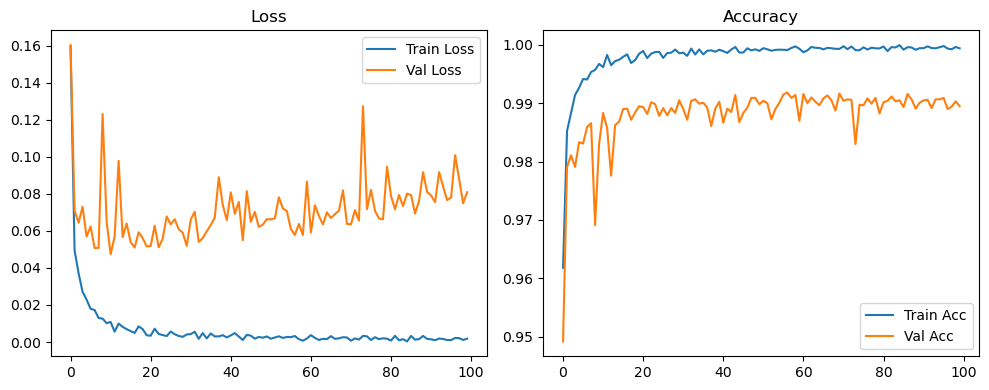

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2042, Acc: 0.9465 | Val Loss: 0.8869, Acc: 0.7099


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0725, Acc: 0.9780 | Val Loss: 1.0528, Acc: 0.6562


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0569, Acc: 0.9821 | Val Loss: 0.4167, Acc: 0.8582


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0447, Acc: 0.9856 | Val Loss: 0.6379, Acc: 0.8031


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0404, Acc: 0.9878 | Val Loss: 0.3764, Acc: 0.8860


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0363, Acc: 0.9891 | Val Loss: 0.9487, Acc: 0.7475


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0330, Acc: 0.9895 | Val Loss: 0.5481, Acc: 0.8393


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0290, Acc: 0.9901 | Val Loss: 0.3558, Acc: 0.8955


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0289, Acc: 0.9907 | Val Loss: 0.4190, Acc: 0.8738


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0248, Acc: 0.9919 | Val Loss: 0.4760, Acc: 0.8700


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0229, Acc: 0.9921 | Val Loss: 0.3094, Acc: 0.9142


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0226, Acc: 0.9925 | Val Loss: 0.3604, Acc: 0.9018


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9929 | Val Loss: 0.2881, Acc: 0.9197


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9936 | Val Loss: 0.2050, Acc: 0.9423


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9938 | Val Loss: 0.3185, Acc: 0.9196


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9943 | Val Loss: 0.3500, Acc: 0.9149


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9941 | Val Loss: 0.3588, Acc: 0.9184


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9946 | Val Loss: 0.4488, Acc: 0.8981


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9951 | Val Loss: 0.3694, Acc: 0.9163


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9954 | Val Loss: 0.3524, Acc: 0.9248


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9955 | Val Loss: 0.2670, Acc: 0.9386


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9950 | Val Loss: 0.2187, Acc: 0.9502


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9958 | Val Loss: 0.3785, Acc: 0.9228


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9963 | Val Loss: 0.2237, Acc: 0.9526


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.3606, Acc: 0.9247


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9955 | Val Loss: 0.3040, Acc: 0.9394


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9954 | Val Loss: 0.1681, Acc: 0.9636


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9964 | Val Loss: 0.3016, Acc: 0.9363


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9962 | Val Loss: 0.2120, Acc: 0.9565


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9960 | Val Loss: 0.2603, Acc: 0.9502


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9971 | Val Loss: 0.1737, Acc: 0.9649


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.1430, Acc: 0.9686


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9963 | Val Loss: 0.2223, Acc: 0.9532


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9969 | Val Loss: 0.1785, Acc: 0.9639


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9967 | Val Loss: 0.1715, Acc: 0.9654


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9967 | Val Loss: 0.1365, Acc: 0.9738


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9964 | Val Loss: 0.2422, Acc: 0.9552


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.1572, Acc: 0.9712


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.1635, Acc: 0.9698


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.2007, Acc: 0.9629


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.1942, Acc: 0.9604


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.2256, Acc: 0.9587


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.1836, Acc: 0.9669


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.2702, Acc: 0.9557


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.3087, Acc: 0.9497


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.1891, Acc: 0.9686


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9962 | Val Loss: 0.1535, Acc: 0.9753


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9970 | Val Loss: 0.1786, Acc: 0.9698


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1333, Acc: 0.9772


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9971 | Val Loss: 0.1443, Acc: 0.9739


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.1901, Acc: 0.9693


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.1712, Acc: 0.9711


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9974 | Val Loss: 0.1847, Acc: 0.9686


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9982 | Val Loss: 0.1730, Acc: 0.9718


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.3085, Acc: 0.9531


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1597, Acc: 0.9757


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.1639, Acc: 0.9732


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.1834, Acc: 0.9716


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.1912, Acc: 0.9718


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.2206, Acc: 0.9673


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.1789, Acc: 0.9717


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9974 | Val Loss: 0.2408, Acc: 0.9649


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9975 | Val Loss: 0.1987, Acc: 0.9714


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1657, Acc: 0.9754


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.1971, Acc: 0.9696


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1813, Acc: 0.9722


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1956, Acc: 0.9702


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.2254, Acc: 0.9666


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9974 | Val Loss: 0.2766, Acc: 0.9598


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.2168, Acc: 0.9687


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1863, Acc: 0.9736


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1681, Acc: 0.9752


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.2353, Acc: 0.9663


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.2197, Acc: 0.9675


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.2038, Acc: 0.9719


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.2092, Acc: 0.9709


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.2518, Acc: 0.9666


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1603, Acc: 0.9783


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.2485, Acc: 0.9673


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.2170, Acc: 0.9713


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.2308, Acc: 0.9679


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.2592, Acc: 0.9654


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.2243, Acc: 0.9711


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.2767, Acc: 0.9665


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.2268, Acc: 0.9714


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.2528, Acc: 0.9681


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.2360, Acc: 0.9710


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.2035, Acc: 0.9728


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9982 | Val Loss: 0.2292, Acc: 0.9694


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.1977, Acc: 0.9740


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.2064, Acc: 0.9754


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.2254, Acc: 0.9722


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1748, Acc: 0.9768


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.2022, Acc: 0.9744


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.2387, Acc: 0.9698


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.2900, Acc: 0.9637


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.1842, Acc: 0.9758


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.2016, Acc: 0.9742


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1907, Acc: 0.9764


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1399, Acc: 0.9821


Final Test Loss: 0.1344 Accuracy: 0.9825


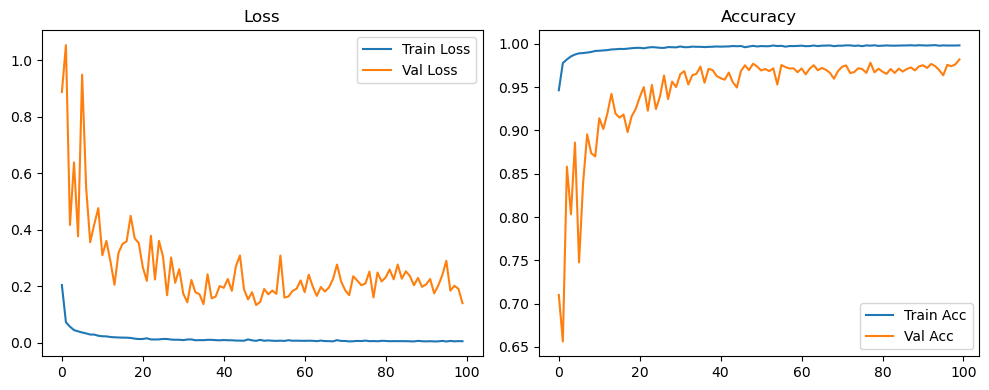

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3678, Acc: 0.8911 | Val Loss: 2.4172, Acc: 0.3162


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1459, Acc: 0.9565 | Val Loss: 3.7002, Acc: 0.2176


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1226, Acc: 0.9635 | Val Loss: 2.8233, Acc: 0.3205


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1038, Acc: 0.9685 | Val Loss: 2.7360, Acc: 0.3602


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0985, Acc: 0.9704 | Val Loss: 2.1923, Acc: 0.4098


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0903, Acc: 0.9731 | Val Loss: 3.0622, Acc: 0.3527


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0877, Acc: 0.9737 | Val Loss: 1.9882, Acc: 0.4753


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0835, Acc: 0.9751 | Val Loss: 2.1225, Acc: 0.4467


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0767, Acc: 0.9760 | Val Loss: 1.2811, Acc: 0.6012


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0744, Acc: 0.9768 | Val Loss: 1.6456, Acc: 0.5161


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0714, Acc: 0.9775 | Val Loss: 1.7065, Acc: 0.5645


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0711, Acc: 0.9783 | Val Loss: 1.2817, Acc: 0.6488


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0683, Acc: 0.9787 | Val Loss: 1.7319, Acc: 0.5779


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0636, Acc: 0.9804 | Val Loss: 1.4450, Acc: 0.5763


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0629, Acc: 0.9806 | Val Loss: 1.1429, Acc: 0.6577


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0611, Acc: 0.9815 | Val Loss: 1.5335, Acc: 0.5954


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0627, Acc: 0.9809 | Val Loss: 1.3173, Acc: 0.6158


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0615, Acc: 0.9811 | Val Loss: 1.1185, Acc: 0.6471


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0576, Acc: 0.9812 | Val Loss: 1.8673, Acc: 0.4961


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0557, Acc: 0.9825 | Val Loss: 1.2398, Acc: 0.6203


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0547, Acc: 0.9826 | Val Loss: 1.6130, Acc: 0.5477


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0551, Acc: 0.9831 | Val Loss: 1.7069, Acc: 0.5285


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0531, Acc: 0.9834 | Val Loss: 1.1983, Acc: 0.6222


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0520, Acc: 0.9838 | Val Loss: 1.0132, Acc: 0.6295


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0488, Acc: 0.9845 | Val Loss: 1.4865, Acc: 0.5758


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0533, Acc: 0.9831 | Val Loss: 1.5409, Acc: 0.5463


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0532, Acc: 0.9835 | Val Loss: 1.5035, Acc: 0.5550


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0494, Acc: 0.9842 | Val Loss: 1.4222, Acc: 0.5858


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0486, Acc: 0.9851 | Val Loss: 1.5418, Acc: 0.5573


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0463, Acc: 0.9853 | Val Loss: 1.4379, Acc: 0.5209


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0495, Acc: 0.9842 | Val Loss: 1.4713, Acc: 0.4995


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0449, Acc: 0.9859 | Val Loss: 1.5867, Acc: 0.5139


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0436, Acc: 0.9858 | Val Loss: 1.4570, Acc: 0.5467


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0479, Acc: 0.9845 | Val Loss: 0.9904, Acc: 0.6265


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0458, Acc: 0.9856 | Val Loss: 1.1530, Acc: 0.5885


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0453, Acc: 0.9857 | Val Loss: 0.9791, Acc: 0.6413


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0416, Acc: 0.9865 | Val Loss: 1.1388, Acc: 0.6091


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0426, Acc: 0.9864 | Val Loss: 0.9469, Acc: 0.6432


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0437, Acc: 0.9865 | Val Loss: 0.8734, Acc: 0.6481


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0417, Acc: 0.9869 | Val Loss: 1.1281, Acc: 0.5927


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9856 | Val Loss: 0.8268, Acc: 0.6783


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0399, Acc: 0.9870 | Val Loss: 1.0244, Acc: 0.5865


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0414, Acc: 0.9871 | Val Loss: 1.1165, Acc: 0.5468


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9863 | Val Loss: 1.0595, Acc: 0.5841


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0409, Acc: 0.9869 | Val Loss: 1.0824, Acc: 0.5799


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0407, Acc: 0.9870 | Val Loss: 0.8130, Acc: 0.6339


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0396, Acc: 0.9874 | Val Loss: 1.2322, Acc: 0.5342


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0393, Acc: 0.9878 | Val Loss: 1.0541, Acc: 0.5387


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0388, Acc: 0.9875 | Val Loss: 1.1090, Acc: 0.5492


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0385, Acc: 0.9878 | Val Loss: 1.0882, Acc: 0.5042


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0367, Acc: 0.9881 | Val Loss: 0.9890, Acc: 0.6284


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0395, Acc: 0.9874 | Val Loss: 1.2489, Acc: 0.4942


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0367, Acc: 0.9881 | Val Loss: 0.9248, Acc: 0.6134


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0361, Acc: 0.9884 | Val Loss: 1.4022, Acc: 0.4708


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0378, Acc: 0.9881 | Val Loss: 1.4561, Acc: 0.4125


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0371, Acc: 0.9885 | Val Loss: 1.1135, Acc: 0.5390


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0356, Acc: 0.9881 | Val Loss: 1.2281, Acc: 0.5067


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0369, Acc: 0.9886 | Val Loss: 1.2649, Acc: 0.4665


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0377, Acc: 0.9882 | Val Loss: 1.1873, Acc: 0.4838


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0351, Acc: 0.9884 | Val Loss: 1.1122, Acc: 0.5094


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0371, Acc: 0.9876 | Val Loss: 1.1001, Acc: 0.4741


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0350, Acc: 0.9886 | Val Loss: 1.2892, Acc: 0.4296


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0384, Acc: 0.9881 | Val Loss: 1.2015, Acc: 0.4363


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0347, Acc: 0.9888 | Val Loss: 1.2162, Acc: 0.4504


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0372, Acc: 0.9882 | Val Loss: 1.3145, Acc: 0.4159


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0335, Acc: 0.9891 | Val Loss: 1.0795, Acc: 0.4815


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0339, Acc: 0.9895 | Val Loss: 1.0165, Acc: 0.5129


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0343, Acc: 0.9889 | Val Loss: 1.2192, Acc: 0.4403


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0335, Acc: 0.9890 | Val Loss: 1.5409, Acc: 0.3344


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9886 | Val Loss: 1.1455, Acc: 0.4384


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0345, Acc: 0.9890 | Val Loss: 1.2642, Acc: 0.3953


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0324, Acc: 0.9899 | Val Loss: 1.3132, Acc: 0.4079


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0348, Acc: 0.9888 | Val Loss: 1.1667, Acc: 0.4413


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0336, Acc: 0.9887 | Val Loss: 1.3361, Acc: 0.3757


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9896 | Val Loss: 1.1927, Acc: 0.4525


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0334, Acc: 0.9896 | Val Loss: 1.3956, Acc: 0.3649


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0332, Acc: 0.9891 | Val Loss: 1.4787, Acc: 0.3157


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0320, Acc: 0.9896 | Val Loss: 1.4105, Acc: 0.3382


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0299, Acc: 0.9901 | Val Loss: 1.3835, Acc: 0.3620


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0346, Acc: 0.9888 | Val Loss: 1.5758, Acc: 0.2815


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0335, Acc: 0.9886 | Val Loss: 1.7315, Acc: 0.2612


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0336, Acc: 0.9885 | Val Loss: 1.5956, Acc: 0.2921


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0320, Acc: 0.9893 | Val Loss: 1.6365, Acc: 0.2562


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0333, Acc: 0.9892 | Val Loss: 1.4256, Acc: 0.3437


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0352, Acc: 0.9885 | Val Loss: 1.5452, Acc: 0.2995


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0320, Acc: 0.9895 | Val Loss: 1.4760, Acc: 0.3226


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0311, Acc: 0.9900 | Val Loss: 1.4865, Acc: 0.3093


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0282, Acc: 0.9907 | Val Loss: 1.5264, Acc: 0.2823


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9896 | Val Loss: 1.5962, Acc: 0.3190


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9900 | Val Loss: 1.5582, Acc: 0.3073


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0311, Acc: 0.9899 | Val Loss: 1.5664, Acc: 0.2709


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0303, Acc: 0.9909 | Val Loss: 1.6698, Acc: 0.2577


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9898 | Val Loss: 1.6393, Acc: 0.2684


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0300, Acc: 0.9905 | Val Loss: 1.5425, Acc: 0.3173


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9909 | Val Loss: 1.5725, Acc: 0.2722


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0324, Acc: 0.9894 | Val Loss: 1.5322, Acc: 0.2629


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0297, Acc: 0.9903 | Val Loss: 1.4428, Acc: 0.3383


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9895 | Val Loss: 1.5681, Acc: 0.2939


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0303, Acc: 0.9904 | Val Loss: 1.4795, Acc: 0.3326


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9902 | Val Loss: 1.4699, Acc: 0.3306


Final Test Loss: 1.4714 Accuracy: 0.3294


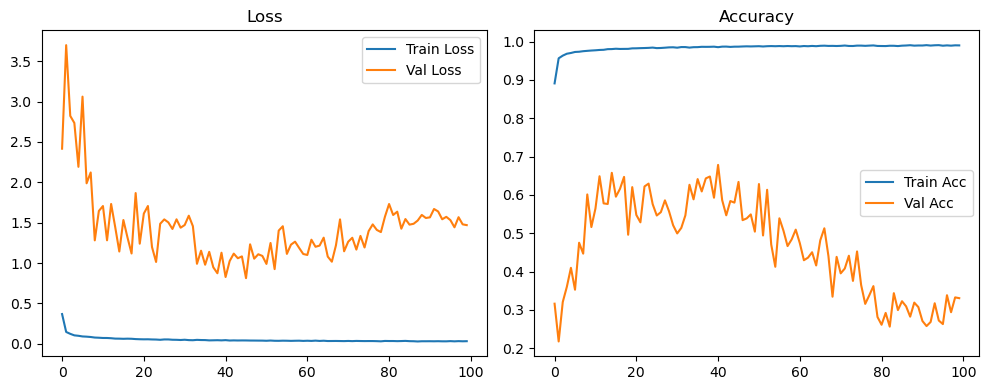

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1594, Acc: 0.9622 | Val Loss: 0.1747, Acc: 0.9455


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0505, Acc: 0.9847 | Val Loss: 0.0621, Acc: 0.9812


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0367, Acc: 0.9882 | Val Loss: 0.0644, Acc: 0.9800


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9913 | Val Loss: 0.0750, Acc: 0.9769


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0235, Acc: 0.9924 | Val Loss: 0.0573, Acc: 0.9837


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9938 | Val Loss: 0.0496, Acc: 0.9863


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9944 | Val Loss: 0.0519, Acc: 0.9862


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9948 | Val Loss: 0.0501, Acc: 0.9860


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9956 | Val Loss: 0.0656, Acc: 0.9825


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.0564, Acc: 0.9854


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.0684, Acc: 0.9821


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.0473, Acc: 0.9888


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.0603, Acc: 0.9860


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.0682, Acc: 0.9843


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.0844, Acc: 0.9821


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9975 | Val Loss: 0.0873, Acc: 0.9816


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9980 | Val Loss: 0.0446, Acc: 0.9906


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0692, Acc: 0.9853


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9969 | Val Loss: 0.0670, Acc: 0.9859


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.0537, Acc: 0.9883


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0645, Acc: 0.9863


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0640, Acc: 0.9863


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9981 | Val Loss: 0.0510, Acc: 0.9896


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0494, Acc: 0.9898


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.0638, Acc: 0.9889


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.0599, Acc: 0.9878


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0665, Acc: 0.9872


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0615, Acc: 0.9880


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0670, Acc: 0.9885


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0582, Acc: 0.9890


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.0571, Acc: 0.9905


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0826, Acc: 0.9853


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.0557, Acc: 0.9908


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0697, Acc: 0.9896


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.0655, Acc: 0.9888


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0663, Acc: 0.9890


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0640, Acc: 0.9896


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0607, Acc: 0.9895


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0722, Acc: 0.9888


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0671, Acc: 0.9890


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0664, Acc: 0.9889


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9986 | Val Loss: 0.0647, Acc: 0.9892


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0626, Acc: 0.9902


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0667, Acc: 0.9892


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0774, Acc: 0.9868


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0696, Acc: 0.9888


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0587, Acc: 0.9903


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0705, Acc: 0.9898


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.0759, Acc: 0.9879


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0647, Acc: 0.9902


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0583, Acc: 0.9912


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0590, Acc: 0.9908


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0613, Acc: 0.9903


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0636, Acc: 0.9901


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0544, Acc: 0.9920


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0619, Acc: 0.9899


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0665, Acc: 0.9906


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0604, Acc: 0.9913


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0581, Acc: 0.9919


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0596, Acc: 0.9907


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0602, Acc: 0.9912


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0658, Acc: 0.9902


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0602, Acc: 0.9911


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0617, Acc: 0.9910


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0579, Acc: 0.9917


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0548, Acc: 0.9913


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0571, Acc: 0.9916


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0594, Acc: 0.9913


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0559, Acc: 0.9917


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0843, Acc: 0.9879


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0610, Acc: 0.9910


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0571, Acc: 0.9918


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0633, Acc: 0.9914


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0659, Acc: 0.9914


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0616, Acc: 0.9916


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0590, Acc: 0.9914


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0663, Acc: 0.9909


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0654, Acc: 0.9907


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0632, Acc: 0.9910


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0648, Acc: 0.9912


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0620, Acc: 0.9913


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0633, Acc: 0.9916


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0640, Acc: 0.9916


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0618, Acc: 0.9915


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0609, Acc: 0.9917


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0623, Acc: 0.9918


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0607, Acc: 0.9918


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0606, Acc: 0.9918


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0629, Acc: 0.9912


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0599, Acc: 0.9918


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0591, Acc: 0.9917


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0626, Acc: 0.9911


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0615, Acc: 0.9918


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0599, Acc: 0.9917


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0620, Acc: 0.9916


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0610, Acc: 0.9916


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0585, Acc: 0.9927


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0586, Acc: 0.9928


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0593, Acc: 0.9923


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0593, Acc: 0.9927


Final Test Loss: 0.0572 Accuracy: 0.9907


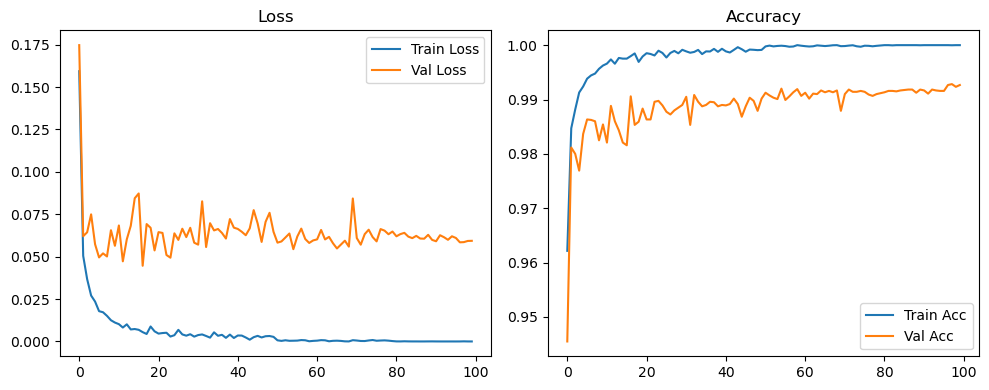

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2049, Acc: 0.9467 | Val Loss: 0.9902, Acc: 0.6760


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0720, Acc: 0.9782 | Val Loss: 1.1701, Acc: 0.6362


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0581, Acc: 0.9817 | Val Loss: 0.5077, Acc: 0.8260


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0451, Acc: 0.9857 | Val Loss: 0.7926, Acc: 0.7629


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0403, Acc: 0.9873 | Val Loss: 0.4556, Acc: 0.8572


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9881 | Val Loss: 0.9045, Acc: 0.7503


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0328, Acc: 0.9892 | Val Loss: 0.7035, Acc: 0.8091


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0294, Acc: 0.9903 | Val Loss: 0.5327, Acc: 0.8491


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0289, Acc: 0.9904 | Val Loss: 0.2882, Acc: 0.9145


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9919 | Val Loss: 0.4327, Acc: 0.8778


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9926 | Val Loss: 0.4718, Acc: 0.8662


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9929 | Val Loss: 0.3506, Acc: 0.9053


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9928 | Val Loss: 0.2076, Acc: 0.9397


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9935 | Val Loss: 0.1719, Acc: 0.9523


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9936 | Val Loss: 0.2501, Acc: 0.9335


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9937 | Val Loss: 0.3309, Acc: 0.9171


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9946 | Val Loss: 0.2801, Acc: 0.9287


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9945 | Val Loss: 0.3902, Acc: 0.9095


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9952 | Val Loss: 0.3349, Acc: 0.9201


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9948 | Val Loss: 0.1824, Acc: 0.9529


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9948 | Val Loss: 0.1935, Acc: 0.9532


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9951 | Val Loss: 0.1994, Acc: 0.9537


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9963 | Val Loss: 0.2101, Acc: 0.9513


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9956 | Val Loss: 0.2711, Acc: 0.9419


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9955 | Val Loss: 0.3125, Acc: 0.9355


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9961 | Val Loss: 0.2337, Acc: 0.9510


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.1992, Acc: 0.9565


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9956 | Val Loss: 0.3311, Acc: 0.9347


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.2385, Acc: 0.9526


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.1721, Acc: 0.9654


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.2012, Acc: 0.9626


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9964 | Val Loss: 0.1918, Acc: 0.9609


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.2308, Acc: 0.9547


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9971 | Val Loss: 0.2251, Acc: 0.9540


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9962 | Val Loss: 0.2049, Acc: 0.9608


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9966 | Val Loss: 0.1602, Acc: 0.9684


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.2234, Acc: 0.9553


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9967 | Val Loss: 0.1743, Acc: 0.9653


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9971 | Val Loss: 0.1658, Acc: 0.9699


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.2045, Acc: 0.9632


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.2407, Acc: 0.9576


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.1931, Acc: 0.9647


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.2142, Acc: 0.9617


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.2427, Acc: 0.9587


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.1774, Acc: 0.9673


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.1838, Acc: 0.9698


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.1939, Acc: 0.9682


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.1879, Acc: 0.9697


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.1819, Acc: 0.9697


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9970 | Val Loss: 0.1860, Acc: 0.9690


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.2108, Acc: 0.9662


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1752, Acc: 0.9698


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1768, Acc: 0.9709


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.2006, Acc: 0.9668


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.2208, Acc: 0.9653


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1817, Acc: 0.9711


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9986 | Val Loss: 0.2962, Acc: 0.9561


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.2113, Acc: 0.9657


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1787, Acc: 0.9709


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.2051, Acc: 0.9687


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.2035, Acc: 0.9690


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.1814, Acc: 0.9720


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1398, Acc: 0.9786


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.1769, Acc: 0.9728


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1847, Acc: 0.9703


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1607, Acc: 0.9742


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1625, Acc: 0.9746


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1973, Acc: 0.9707


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.2074, Acc: 0.9708


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1910, Acc: 0.9708


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1990, Acc: 0.9708


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.2010, Acc: 0.9698


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1728, Acc: 0.9733


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.2033, Acc: 0.9702


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.2280, Acc: 0.9667


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1992, Acc: 0.9705


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1733, Acc: 0.9738


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1652, Acc: 0.9747


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1559, Acc: 0.9766


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.2185, Acc: 0.9686


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1791, Acc: 0.9749


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1897, Acc: 0.9732


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9991 | Val Loss: 0.1663, Acc: 0.9757


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1921, Acc: 0.9725


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1760, Acc: 0.9748


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1821, Acc: 0.9737


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1965, Acc: 0.9722


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1904, Acc: 0.9734


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1962, Acc: 0.9721


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1795, Acc: 0.9753


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1876, Acc: 0.9738


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.2100, Acc: 0.9715


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1944, Acc: 0.9737


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.2033, Acc: 0.9720


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1938, Acc: 0.9731


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1930, Acc: 0.9744


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1980, Acc: 0.9737


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1789, Acc: 0.9748


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1871, Acc: 0.9742


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1848, Acc: 0.9750


Final Test Loss: 0.1972 Accuracy: 0.9753


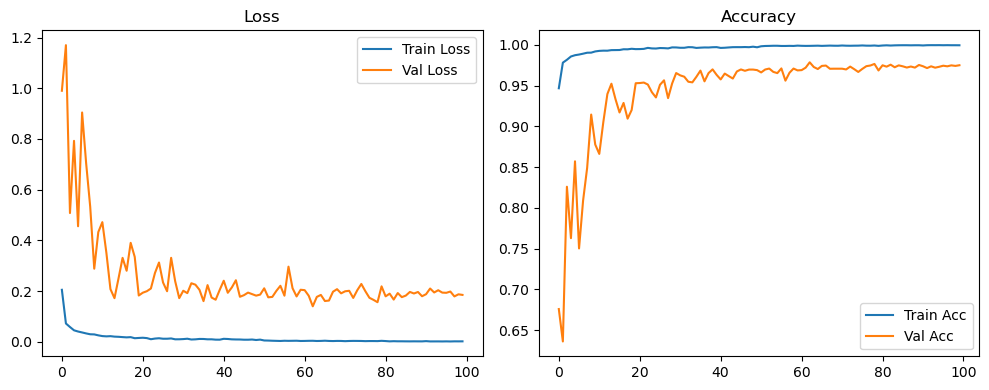

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3680, Acc: 0.8910 | Val Loss: 2.6156, Acc: 0.2691


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1462, Acc: 0.9566 | Val Loss: 3.9174, Acc: 0.1918


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1231, Acc: 0.9634 | Val Loss: 3.1875, Acc: 0.2833


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1047, Acc: 0.9681 | Val Loss: 3.2012, Acc: 0.2806


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0992, Acc: 0.9707 | Val Loss: 2.7274, Acc: 0.3401


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0904, Acc: 0.9726 | Val Loss: 3.1769, Acc: 0.3138


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0891, Acc: 0.9729 | Val Loss: 2.6016, Acc: 0.3628


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0844, Acc: 0.9749 | Val Loss: 1.9429, Acc: 0.4495


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0763, Acc: 0.9765 | Val Loss: 1.2320, Acc: 0.6076


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0743, Acc: 0.9772 | Val Loss: 1.9345, Acc: 0.4921


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0719, Acc: 0.9775 | Val Loss: 1.4819, Acc: 0.6013


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0708, Acc: 0.9786 | Val Loss: 2.0097, Acc: 0.5132


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0700, Acc: 0.9777 | Val Loss: 1.4356, Acc: 0.6350


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0634, Acc: 0.9806 | Val Loss: 1.5272, Acc: 0.5925


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0638, Acc: 0.9810 | Val Loss: 1.0063, Acc: 0.6813


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0612, Acc: 0.9811 | Val Loss: 1.5230, Acc: 0.5745


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0643, Acc: 0.9800 | Val Loss: 1.4036, Acc: 0.5692


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0596, Acc: 0.9818 | Val Loss: 1.2361, Acc: 0.6133


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0579, Acc: 0.9814 | Val Loss: 0.9738, Acc: 0.6874


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0562, Acc: 0.9825 | Val Loss: 0.8777, Acc: 0.7051


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0550, Acc: 0.9830 | Val Loss: 0.8854, Acc: 0.6913


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0572, Acc: 0.9819 | Val Loss: 1.4824, Acc: 0.5484


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0545, Acc: 0.9830 | Val Loss: 1.0345, Acc: 0.6743


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0506, Acc: 0.9835 | Val Loss: 0.6640, Acc: 0.7654


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0524, Acc: 0.9834 | Val Loss: 1.1498, Acc: 0.6361


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0535, Acc: 0.9828 | Val Loss: 1.1170, Acc: 0.6476


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0503, Acc: 0.9840 | Val Loss: 1.2795, Acc: 0.6042


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0506, Acc: 0.9846 | Val Loss: 0.7345, Acc: 0.7547


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0506, Acc: 0.9846 | Val Loss: 0.7572, Acc: 0.7209


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0476, Acc: 0.9843 | Val Loss: 0.8796, Acc: 0.6427


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0478, Acc: 0.9851 | Val Loss: 0.8409, Acc: 0.6790


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0450, Acc: 0.9856 | Val Loss: 1.2208, Acc: 0.5783


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0441, Acc: 0.9860 | Val Loss: 1.2890, Acc: 0.5598


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0488, Acc: 0.9844 | Val Loss: 1.0237, Acc: 0.5987


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0465, Acc: 0.9851 | Val Loss: 1.0741, Acc: 0.5708


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9859 | Val Loss: 0.9547, Acc: 0.6215


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9864 | Val Loss: 1.0222, Acc: 0.5956


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0418, Acc: 0.9868 | Val Loss: 0.7290, Acc: 0.6987


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0431, Acc: 0.9861 | Val Loss: 0.7905, Acc: 0.6453


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9864 | Val Loss: 0.7705, Acc: 0.6673


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0445, Acc: 0.9857 | Val Loss: 0.7380, Acc: 0.6739


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0394, Acc: 0.9876 | Val Loss: 0.7823, Acc: 0.6037


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0413, Acc: 0.9867 | Val Loss: 0.8727, Acc: 0.5911


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0413, Acc: 0.9867 | Val Loss: 0.8293, Acc: 0.6218


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9868 | Val Loss: 1.0736, Acc: 0.5122


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0423, Acc: 0.9869 | Val Loss: 0.7282, Acc: 0.6442


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9861 | Val Loss: 1.0317, Acc: 0.5422


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9880 | Val Loss: 0.9969, Acc: 0.5473


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0403, Acc: 0.9869 | Val Loss: 1.0100, Acc: 0.4878


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9875 | Val Loss: 0.9191, Acc: 0.5041


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0343, Acc: 0.9890 | Val Loss: 0.8491, Acc: 0.5928


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0300, Acc: 0.9902 | Val Loss: 1.0396, Acc: 0.4978


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0307, Acc: 0.9897 | Val Loss: 0.9431, Acc: 0.5473


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0289, Acc: 0.9902 | Val Loss: 0.9791, Acc: 0.5222


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0297, Acc: 0.9902 | Val Loss: 1.1513, Acc: 0.4437


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0310, Acc: 0.9904 | Val Loss: 1.1955, Acc: 0.4408


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0276, Acc: 0.9911 | Val Loss: 1.0127, Acc: 0.5292


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0280, Acc: 0.9908 | Val Loss: 0.8832, Acc: 0.5833


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0302, Acc: 0.9902 | Val Loss: 0.8978, Acc: 0.5563


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9910 | Val Loss: 0.8912, Acc: 0.5635


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0310, Acc: 0.9903 | Val Loss: 0.8757, Acc: 0.5561


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0301, Acc: 0.9910 | Val Loss: 0.9327, Acc: 0.5497


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0304, Acc: 0.9907 | Val Loss: 1.0456, Acc: 0.4848


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0294, Acc: 0.9904 | Val Loss: 0.9942, Acc: 0.5132


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0271, Acc: 0.9910 | Val Loss: 0.8726, Acc: 0.5699


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0250, Acc: 0.9913 | Val Loss: 1.0048, Acc: 0.4986


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0270, Acc: 0.9913 | Val Loss: 0.9795, Acc: 0.5281


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9908 | Val Loss: 1.0761, Acc: 0.4841


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0274, Acc: 0.9904 | Val Loss: 0.9396, Acc: 0.5469


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0263, Acc: 0.9910 | Val Loss: 1.0478, Acc: 0.4833


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0275, Acc: 0.9911 | Val Loss: 1.0399, Acc: 0.4906


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0288, Acc: 0.9915 | Val Loss: 1.0626, Acc: 0.4597


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0278, Acc: 0.9911 | Val Loss: 1.0955, Acc: 0.4570


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0259, Acc: 0.9914 | Val Loss: 1.0788, Acc: 0.4528


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0260, Acc: 0.9915 | Val Loss: 1.1773, Acc: 0.4418


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0247, Acc: 0.9925 | Val Loss: 1.0455, Acc: 0.4842


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0260, Acc: 0.9913 | Val Loss: 1.0551, Acc: 0.4542


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0267, Acc: 0.9915 | Val Loss: 1.1692, Acc: 0.4022


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0269, Acc: 0.9914 | Val Loss: 1.1317, Acc: 0.4147


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0253, Acc: 0.9915 | Val Loss: 1.1691, Acc: 0.4143


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0269, Acc: 0.9912 | Val Loss: 1.0560, Acc: 0.4471


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0232, Acc: 0.9918 | Val Loss: 1.0995, Acc: 0.4449


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0225, Acc: 0.9926 | Val Loss: 1.1592, Acc: 0.4042


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0231, Acc: 0.9927 | Val Loss: 1.0929, Acc: 0.4478


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0242, Acc: 0.9922 | Val Loss: 1.1508, Acc: 0.4082


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0220, Acc: 0.9925 | Val Loss: 1.1668, Acc: 0.4085


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0220, Acc: 0.9923 | Val Loss: 1.1464, Acc: 0.4154


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0213, Acc: 0.9928 | Val Loss: 1.2034, Acc: 0.3797


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0217, Acc: 0.9929 | Val Loss: 1.0602, Acc: 0.4547


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0211, Acc: 0.9931 | Val Loss: 1.0974, Acc: 0.4386


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0213, Acc: 0.9928 | Val Loss: 1.1076, Acc: 0.4246


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0214, Acc: 0.9932 | Val Loss: 1.1187, Acc: 0.4228


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0208, Acc: 0.9930 | Val Loss: 1.0726, Acc: 0.4366


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0222, Acc: 0.9930 | Val Loss: 1.1276, Acc: 0.4246


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0202, Acc: 0.9933 | Val Loss: 1.1686, Acc: 0.3877


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0214, Acc: 0.9931 | Val Loss: 1.2002, Acc: 0.3902


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0209, Acc: 0.9926 | Val Loss: 1.1072, Acc: 0.4370


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0237, Acc: 0.9924 | Val Loss: 1.0695, Acc: 0.4542


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0203, Acc: 0.9936 | Val Loss: 1.1266, Acc: 0.4205


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0202, Acc: 0.9932 | Val Loss: 1.0803, Acc: 0.4561


Final Test Loss: 1.0730 Accuracy: 0.4575


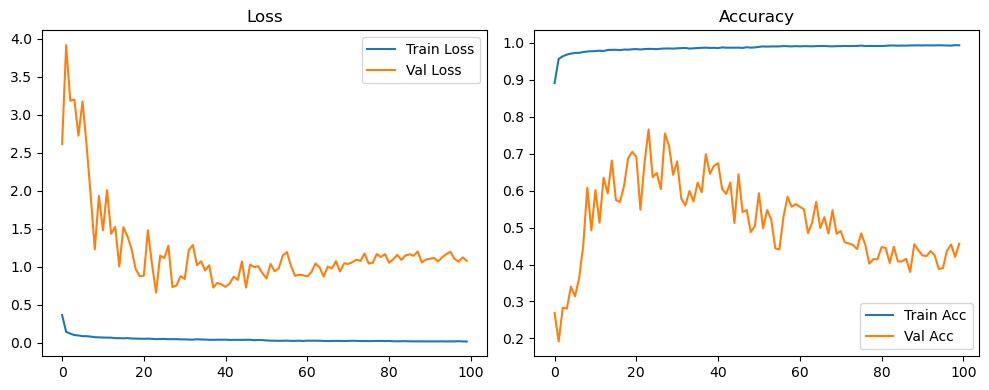

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1591, Acc: 0.9620 | Val Loss: 0.1449, Acc: 0.9542


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0505, Acc: 0.9845 | Val Loss: 0.0716, Acc: 0.9774


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0369, Acc: 0.9884 | Val Loss: 0.0732, Acc: 0.9772


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9915 | Val Loss: 0.1319, Acc: 0.9607


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0233, Acc: 0.9925 | Val Loss: 0.0812, Acc: 0.9754


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9939 | Val Loss: 0.1021, Acc: 0.9714


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9938 | Val Loss: 0.0902, Acc: 0.9751


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.0401, Acc: 0.9889


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9956 | Val Loss: 0.0499, Acc: 0.9869


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9962 | Val Loss: 0.0566, Acc: 0.9867


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.0781, Acc: 0.9809


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.0504, Acc: 0.9868


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.0627, Acc: 0.9864


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.0590, Acc: 0.9859


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9967 | Val Loss: 0.0386, Acc: 0.9894


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9974 | Val Loss: 0.0538, Acc: 0.9866


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9981 | Val Loss: 0.0450, Acc: 0.9902


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0592, Acc: 0.9888


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0542, Acc: 0.9886


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.0562, Acc: 0.9880


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0596, Acc: 0.9878


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.0869, Acc: 0.9831


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.0591, Acc: 0.9889


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0655, Acc: 0.9874


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0737, Acc: 0.9858


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0464, Acc: 0.9906


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0555, Acc: 0.9894


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.0530, Acc: 0.9901


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0609, Acc: 0.9892


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0508, Acc: 0.9915


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0621, Acc: 0.9880


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0529, Acc: 0.9902


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0582, Acc: 0.9895


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0531, Acc: 0.9895


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0535, Acc: 0.9908


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.0558, Acc: 0.9904


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0584, Acc: 0.9902


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.0998, Acc: 0.9834


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0613, Acc: 0.9902


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0640, Acc: 0.9896


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0609, Acc: 0.9893


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0876, Acc: 0.9863


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0611, Acc: 0.9902


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0507, Acc: 0.9916


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0639, Acc: 0.9898


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0750, Acc: 0.9881


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0607, Acc: 0.9898


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9991 | Val Loss: 0.0701, Acc: 0.9887


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0560, Acc: 0.9913


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0636, Acc: 0.9898


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0544, Acc: 0.9913


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0514, Acc: 0.9918


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0539, Acc: 0.9914


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0507, Acc: 0.9920


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0589, Acc: 0.9912


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0598, Acc: 0.9904


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0582, Acc: 0.9915


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0637, Acc: 0.9908


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.0740, Acc: 0.9891


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0628, Acc: 0.9910


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0685, Acc: 0.9907


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0627, Acc: 0.9905


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0611, Acc: 0.9916


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0629, Acc: 0.9912


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0684, Acc: 0.9904


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0662, Acc: 0.9908


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0652, Acc: 0.9917


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0662, Acc: 0.9908


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0695, Acc: 0.9900


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0702, Acc: 0.9904


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0659, Acc: 0.9908


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0665, Acc: 0.9906


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0659, Acc: 0.9912


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0645, Acc: 0.9912


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0842, Acc: 0.9886


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0765, Acc: 0.9902


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0666, Acc: 0.9907


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0808, Acc: 0.9895


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0772, Acc: 0.9904


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0676, Acc: 0.9905


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0688, Acc: 0.9904


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0657, Acc: 0.9908


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0655, Acc: 0.9910


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0635, Acc: 0.9908


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0650, Acc: 0.9911


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0688, Acc: 0.9909


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0629, Acc: 0.9913


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0623, Acc: 0.9918


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0614, Acc: 0.9912


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0599, Acc: 0.9915


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0590, Acc: 0.9914


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0591, Acc: 0.9913


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0595, Acc: 0.9915


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0592, Acc: 0.9912


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0590, Acc: 0.9912


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0583, Acc: 0.9911


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0607, Acc: 0.9919


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0608, Acc: 0.9921


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0611, Acc: 0.9923


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0618, Acc: 0.9921


Final Test Loss: 0.0511 Accuracy: 0.9921


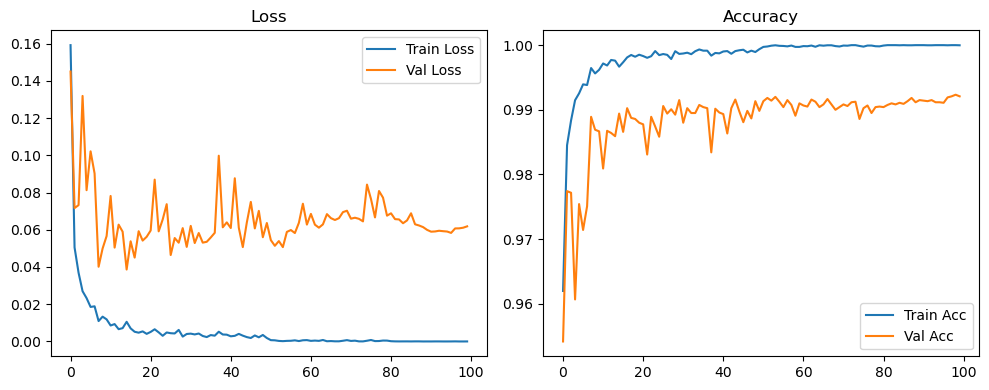

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2043, Acc: 0.9466 | Val Loss: 1.3602, Acc: 0.5765


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0722, Acc: 0.9785 | Val Loss: 0.9312, Acc: 0.6967


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0573, Acc: 0.9824 | Val Loss: 0.3741, Acc: 0.8711


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0455, Acc: 0.9858 | Val Loss: 0.7281, Acc: 0.7800


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0396, Acc: 0.9876 | Val Loss: 0.3252, Acc: 0.8961


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0358, Acc: 0.9886 | Val Loss: 1.0248, Acc: 0.7446


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0328, Acc: 0.9894 | Val Loss: 0.7824, Acc: 0.7827


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0299, Acc: 0.9902 | Val Loss: 0.4356, Acc: 0.8734


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9912 | Val Loss: 0.4819, Acc: 0.8647


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9922 | Val Loss: 0.3440, Acc: 0.9069


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9925 | Val Loss: 0.4193, Acc: 0.8927


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9925 | Val Loss: 0.2970, Acc: 0.9198


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9936 | Val Loss: 0.2801, Acc: 0.9227


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9934 | Val Loss: 0.1985, Acc: 0.9435


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9936 | Val Loss: 0.2568, Acc: 0.9313


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9942 | Val Loss: 0.3485, Acc: 0.9085


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9945 | Val Loss: 0.3828, Acc: 0.9085


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9942 | Val Loss: 0.4373, Acc: 0.8991


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9943 | Val Loss: 0.3994, Acc: 0.9084


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9953 | Val Loss: 0.2864, Acc: 0.9289


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9952 | Val Loss: 0.2183, Acc: 0.9471


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9949 | Val Loss: 0.2649, Acc: 0.9377


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9953 | Val Loss: 0.2707, Acc: 0.9395


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.3490, Acc: 0.9300


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9958 | Val Loss: 0.3898, Acc: 0.9236


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9956 | Val Loss: 0.2160, Acc: 0.9537


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9959 | Val Loss: 0.2755, Acc: 0.9426


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9958 | Val Loss: 0.3338, Acc: 0.9368


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9967 | Val Loss: 0.2743, Acc: 0.9491


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.3348, Acc: 0.9377


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9965 | Val Loss: 0.2230, Acc: 0.9573


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.1677, Acc: 0.9683


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9962 | Val Loss: 0.2897, Acc: 0.9467


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9963 | Val Loss: 0.1970, Acc: 0.9601


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9970 | Val Loss: 0.2816, Acc: 0.9483


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.3633, Acc: 0.9311


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.2748, Acc: 0.9483


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9970 | Val Loss: 0.1246, Acc: 0.9763


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.2069, Acc: 0.9622


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9972 | Val Loss: 0.2150, Acc: 0.9620


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.3358, Acc: 0.9408


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.1851, Acc: 0.9669


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.1778, Acc: 0.9695


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9970 | Val Loss: 0.1723, Acc: 0.9715


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.2240, Acc: 0.9647


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.1948, Acc: 0.9664


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1595, Acc: 0.9738


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1701, Acc: 0.9726


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.2434, Acc: 0.9623


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.1632, Acc: 0.9749


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1528, Acc: 0.9759


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1659, Acc: 0.9727


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9986 | Val Loss: 0.1659, Acc: 0.9728


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.2181, Acc: 0.9664


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.2022, Acc: 0.9676


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.2126, Acc: 0.9675


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.2480, Acc: 0.9623


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.2345, Acc: 0.9640


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.2186, Acc: 0.9670


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9985 | Val Loss: 0.2067, Acc: 0.9691


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.2118, Acc: 0.9685


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.2895, Acc: 0.9587


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.2590, Acc: 0.9624


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.2052, Acc: 0.9704


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.1835, Acc: 0.9738


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1624, Acc: 0.9770


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1984, Acc: 0.9742


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.2387, Acc: 0.9680


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1820, Acc: 0.9736


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1925, Acc: 0.9724


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1978, Acc: 0.9723


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1719, Acc: 0.9756


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9987 | Val Loss: 0.2155, Acc: 0.9702


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.2416, Acc: 0.9668


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.2510, Acc: 0.9667


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.2013, Acc: 0.9731


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1809, Acc: 0.9740


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.1518, Acc: 0.9786


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9988 | Val Loss: 0.1788, Acc: 0.9751


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.1929, Acc: 0.9732


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1428, Acc: 0.9793


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1743, Acc: 0.9753


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1488, Acc: 0.9783


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1782, Acc: 0.9749


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1682, Acc: 0.9768


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1673, Acc: 0.9762


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1656, Acc: 0.9764


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1745, Acc: 0.9761


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1840, Acc: 0.9749


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1751, Acc: 0.9760


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9994 | Val Loss: 0.1760, Acc: 0.9760


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1911, Acc: 0.9728


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1628, Acc: 0.9775


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1706, Acc: 0.9768


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1906, Acc: 0.9738


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1916, Acc: 0.9749


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1757, Acc: 0.9760


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1594, Acc: 0.9785


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1715, Acc: 0.9766


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1634, Acc: 0.9779


Final Test Loss: 0.1619 Accuracy: 0.9782


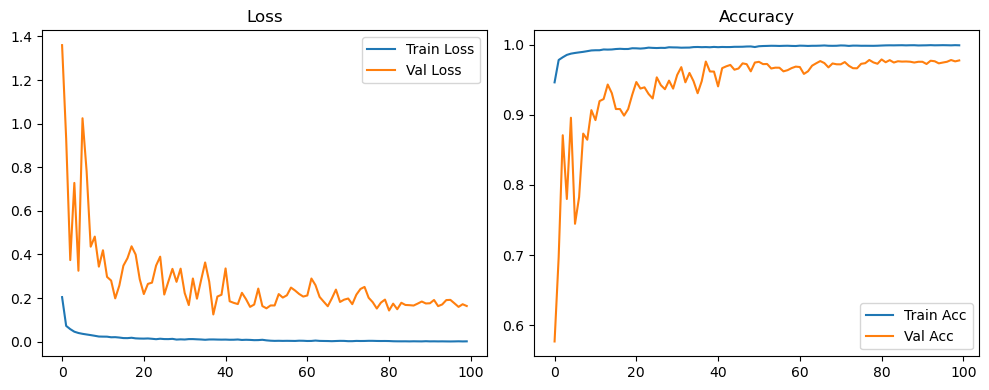

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3679, Acc: 0.8906 | Val Loss: 2.6050, Acc: 0.2846


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1461, Acc: 0.9566 | Val Loss: 3.4152, Acc: 0.2429


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1232, Acc: 0.9639 | Val Loss: 3.1085, Acc: 0.2797


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1050, Acc: 0.9686 | Val Loss: 2.8106, Acc: 0.3215


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0987, Acc: 0.9707 | Val Loss: 2.4567, Acc: 0.3707


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0902, Acc: 0.9720 | Val Loss: 2.8354, Acc: 0.3479


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0880, Acc: 0.9741 | Val Loss: 2.0423, Acc: 0.4663


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0847, Acc: 0.9746 | Val Loss: 2.0443, Acc: 0.4547


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0761, Acc: 0.9760 | Val Loss: 1.9251, Acc: 0.4602


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0741, Acc: 0.9769 | Val Loss: 2.0560, Acc: 0.4562


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0706, Acc: 0.9780 | Val Loss: 2.0217, Acc: 0.5012


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0699, Acc: 0.9792 | Val Loss: 1.5797, Acc: 0.5833


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0692, Acc: 0.9784 | Val Loss: 1.3699, Acc: 0.6174


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0630, Acc: 0.9806 | Val Loss: 1.3252, Acc: 0.6220


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0626, Acc: 0.9809 | Val Loss: 1.1948, Acc: 0.6382


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0620, Acc: 0.9811 | Val Loss: 1.4274, Acc: 0.5529


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0624, Acc: 0.9809 | Val Loss: 1.6415, Acc: 0.5321


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0589, Acc: 0.9815 | Val Loss: 1.0817, Acc: 0.6547


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0582, Acc: 0.9821 | Val Loss: 1.2548, Acc: 0.6260


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0559, Acc: 0.9820 | Val Loss: 0.8584, Acc: 0.7118


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0530, Acc: 0.9831 | Val Loss: 1.3751, Acc: 0.5831


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0549, Acc: 0.9830 | Val Loss: 1.5590, Acc: 0.5188


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0538, Acc: 0.9834 | Val Loss: 1.1371, Acc: 0.6312


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9835 | Val Loss: 0.8607, Acc: 0.6700


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0506, Acc: 0.9842 | Val Loss: 1.3896, Acc: 0.5769


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0528, Acc: 0.9839 | Val Loss: 1.1917, Acc: 0.5954


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0504, Acc: 0.9840 | Val Loss: 0.9019, Acc: 0.6737


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0490, Acc: 0.9850 | Val Loss: 0.7982, Acc: 0.7221


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0492, Acc: 0.9842 | Val Loss: 1.0295, Acc: 0.6480


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0475, Acc: 0.9848 | Val Loss: 0.9716, Acc: 0.6107


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9849 | Val Loss: 0.8784, Acc: 0.6687


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9853 | Val Loss: 1.0925, Acc: 0.6034


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0457, Acc: 0.9856 | Val Loss: 1.2376, Acc: 0.5245


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9856 | Val Loss: 1.1716, Acc: 0.5706


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0452, Acc: 0.9856 | Val Loss: 1.2073, Acc: 0.5672


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0441, Acc: 0.9857 | Val Loss: 0.9257, Acc: 0.6611


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0419, Acc: 0.9863 | Val Loss: 1.1095, Acc: 0.5582


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0431, Acc: 0.9865 | Val Loss: 0.8617, Acc: 0.6539


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9860 | Val Loss: 1.0079, Acc: 0.5941


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0418, Acc: 0.9865 | Val Loss: 0.9112, Acc: 0.6284


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0439, Acc: 0.9866 | Val Loss: 0.7621, Acc: 0.6871


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9871 | Val Loss: 0.7277, Acc: 0.6455


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0414, Acc: 0.9864 | Val Loss: 0.9440, Acc: 0.5856


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0388, Acc: 0.9871 | Val Loss: 0.6764, Acc: 0.7007


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0390, Acc: 0.9874 | Val Loss: 0.9299, Acc: 0.5910


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0409, Acc: 0.9872 | Val Loss: 0.6215, Acc: 0.7033


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0409, Acc: 0.9872 | Val Loss: 0.7030, Acc: 0.6943


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0379, Acc: 0.9874 | Val Loss: 0.7130, Acc: 0.6662


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0386, Acc: 0.9875 | Val Loss: 0.9731, Acc: 0.5542


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0374, Acc: 0.9883 | Val Loss: 1.0094, Acc: 0.5040


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0308, Acc: 0.9897 | Val Loss: 0.8537, Acc: 0.6363


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0311, Acc: 0.9902 | Val Loss: 0.9828, Acc: 0.5875


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0299, Acc: 0.9900 | Val Loss: 0.9001, Acc: 0.6052


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0288, Acc: 0.9910 | Val Loss: 0.9062, Acc: 0.5689


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0302, Acc: 0.9904 | Val Loss: 0.9708, Acc: 0.5457


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0296, Acc: 0.9905 | Val Loss: 0.9468, Acc: 0.5503


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0294, Acc: 0.9903 | Val Loss: 0.8217, Acc: 0.6273


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0289, Acc: 0.9910 | Val Loss: 0.9374, Acc: 0.5921


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0299, Acc: 0.9907 | Val Loss: 0.7968, Acc: 0.6325


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0293, Acc: 0.9909 | Val Loss: 0.9983, Acc: 0.5274


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0290, Acc: 0.9906 | Val Loss: 0.6652, Acc: 0.6785


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0283, Acc: 0.9913 | Val Loss: 0.9077, Acc: 0.5777


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0288, Acc: 0.9911 | Val Loss: 0.8236, Acc: 0.6046


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0284, Acc: 0.9902 | Val Loss: 0.9180, Acc: 0.5652


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0288, Acc: 0.9909 | Val Loss: 0.8459, Acc: 0.5970


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9913 | Val Loss: 0.8761, Acc: 0.5710


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9916 | Val Loss: 0.7837, Acc: 0.6186


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9912 | Val Loss: 0.8806, Acc: 0.5811


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0271, Acc: 0.9908 | Val Loss: 0.9350, Acc: 0.5443


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0265, Acc: 0.9909 | Val Loss: 0.9431, Acc: 0.5383


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0279, Acc: 0.9910 | Val Loss: 0.9244, Acc: 0.5428


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9910 | Val Loss: 0.9363, Acc: 0.5164


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0277, Acc: 0.9909 | Val Loss: 0.8747, Acc: 0.5506


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9910 | Val Loss: 0.9268, Acc: 0.5358


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0270, Acc: 0.9915 | Val Loss: 0.9729, Acc: 0.5203


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0255, Acc: 0.9914 | Val Loss: 0.9336, Acc: 0.5396


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0274, Acc: 0.9910 | Val Loss: 0.8523, Acc: 0.5675


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0252, Acc: 0.9918 | Val Loss: 0.8382, Acc: 0.5824


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0241, Acc: 0.9922 | Val Loss: 0.8459, Acc: 0.5810


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0291, Acc: 0.9904 | Val Loss: 1.1202, Acc: 0.4449


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0254, Acc: 0.9914 | Val Loss: 1.0084, Acc: 0.4863


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0216, Acc: 0.9928 | Val Loss: 1.0800, Acc: 0.4515


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0218, Acc: 0.9929 | Val Loss: 1.0892, Acc: 0.4259


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0236, Acc: 0.9923 | Val Loss: 1.0674, Acc: 0.4550


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0229, Acc: 0.9921 | Val Loss: 1.0763, Acc: 0.4461


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0215, Acc: 0.9932 | Val Loss: 1.0781, Acc: 0.4480


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0224, Acc: 0.9926 | Val Loss: 1.0695, Acc: 0.4486


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0213, Acc: 0.9928 | Val Loss: 1.1088, Acc: 0.4244


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0202, Acc: 0.9934 | Val Loss: 1.0210, Acc: 0.4817


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0204, Acc: 0.9933 | Val Loss: 1.0371, Acc: 0.4681


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0195, Acc: 0.9938 | Val Loss: 1.0427, Acc: 0.4607


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0210, Acc: 0.9934 | Val Loss: 1.0129, Acc: 0.4798


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0189, Acc: 0.9940 | Val Loss: 0.9888, Acc: 0.4834


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0208, Acc: 0.9934 | Val Loss: 1.0417, Acc: 0.4816


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0204, Acc: 0.9932 | Val Loss: 1.1069, Acc: 0.4243


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0205, Acc: 0.9931 | Val Loss: 1.1251, Acc: 0.4276


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0199, Acc: 0.9932 | Val Loss: 1.0668, Acc: 0.4539


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0209, Acc: 0.9929 | Val Loss: 1.0002, Acc: 0.4878


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0186, Acc: 0.9937 | Val Loss: 0.9899, Acc: 0.4908


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0207, Acc: 0.9933 | Val Loss: 0.9405, Acc: 0.5248


Final Test Loss: 0.9298 Accuracy: 0.5268


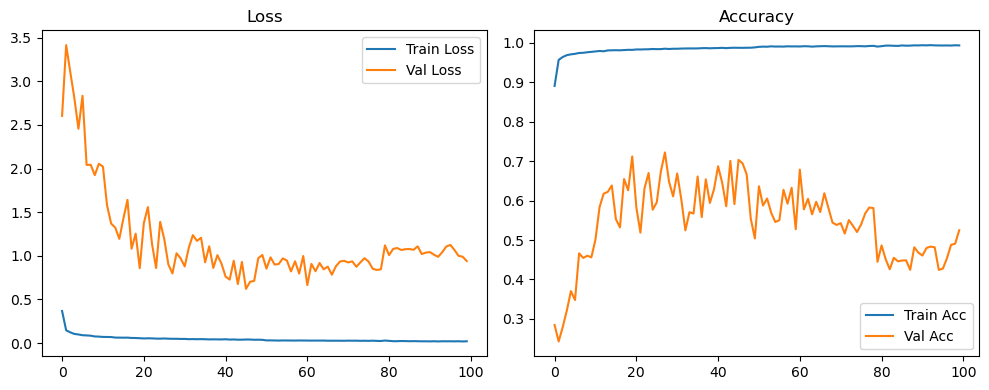

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1596, Acc: 0.9619 | Val Loss: 0.3107, Acc: 0.9017


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0506, Acc: 0.9842 | Val Loss: 0.0632, Acc: 0.9807


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0373, Acc: 0.9884 | Val Loss: 0.0700, Acc: 0.9778


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9915 | Val Loss: 0.0682, Acc: 0.9796


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9921 | Val Loss: 0.0579, Acc: 0.9823


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9949 | Val Loss: 0.0642, Acc: 0.9828


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9934 | Val Loss: 0.0778, Acc: 0.9778


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9956 | Val Loss: 0.0460, Acc: 0.9875


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9958 | Val Loss: 0.0560, Acc: 0.9866


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9963 | Val Loss: 0.0555, Acc: 0.9872


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9962 | Val Loss: 0.0492, Acc: 0.9878


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.0639, Acc: 0.9843


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9964 | Val Loss: 0.0638, Acc: 0.9860


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9972 | Val Loss: 0.1272, Acc: 0.9725


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9971 | Val Loss: 0.0543, Acc: 0.9882


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.0617, Acc: 0.9856


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9978 | Val Loss: 0.0575, Acc: 0.9879


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0641, Acc: 0.9852


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.0606, Acc: 0.9869


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9981 | Val Loss: 0.0488, Acc: 0.9898


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.0582, Acc: 0.9888


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9985 | Val Loss: 0.0505, Acc: 0.9884


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0595, Acc: 0.9878


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.0598, Acc: 0.9881


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0614, Acc: 0.9882


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0610, Acc: 0.9888


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0571, Acc: 0.9874


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0526, Acc: 0.9895


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0648, Acc: 0.9869


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0675, Acc: 0.9881


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0718, Acc: 0.9881


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0659, Acc: 0.9876


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0655, Acc: 0.9883


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.0699, Acc: 0.9888


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0781, Acc: 0.9871


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0651, Acc: 0.9896


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0769, Acc: 0.9865


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0559, Acc: 0.9900


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0657, Acc: 0.9902


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0663, Acc: 0.9896


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0639, Acc: 0.9899


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0752, Acc: 0.9884


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.0687, Acc: 0.9896


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0780, Acc: 0.9873


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0802, Acc: 0.9872


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0653, Acc: 0.9897


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0640, Acc: 0.9900


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0692, Acc: 0.9888


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0726, Acc: 0.9897


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0723, Acc: 0.9892


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0625, Acc: 0.9898


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0603, Acc: 0.9902


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0603, Acc: 0.9906


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0579, Acc: 0.9906


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0583, Acc: 0.9904


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0598, Acc: 0.9905


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0613, Acc: 0.9899


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0582, Acc: 0.9906


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0586, Acc: 0.9910


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0608, Acc: 0.9898


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0625, Acc: 0.9908


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0613, Acc: 0.9906


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0627, Acc: 0.9906


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0631, Acc: 0.9905


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0612, Acc: 0.9905


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0599, Acc: 0.9907


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0602, Acc: 0.9904


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0599, Acc: 0.9908


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0652, Acc: 0.9904


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0614, Acc: 0.9909


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0605, Acc: 0.9912


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0599, Acc: 0.9906


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0632, Acc: 0.9907


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0621, Acc: 0.9912


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0601, Acc: 0.9910


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0609, Acc: 0.9909


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0616, Acc: 0.9906


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0652, Acc: 0.9901


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0603, Acc: 0.9909


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0601, Acc: 0.9910


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0600, Acc: 0.9908


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0603, Acc: 0.9909


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0606, Acc: 0.9912


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0617, Acc: 0.9910


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0612, Acc: 0.9908


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0619, Acc: 0.9910


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0622, Acc: 0.9912


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0614, Acc: 0.9912


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0630, Acc: 0.9914


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0616, Acc: 0.9917


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0594, Acc: 0.9913


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0621, Acc: 0.9913


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0622, Acc: 0.9918


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0626, Acc: 0.9918


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0618, Acc: 0.9911


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0618, Acc: 0.9919


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0627, Acc: 0.9915


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0622, Acc: 0.9914


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0602, Acc: 0.9910


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0616, Acc: 0.9915


Final Test Loss: 0.0447 Accuracy: 0.9934


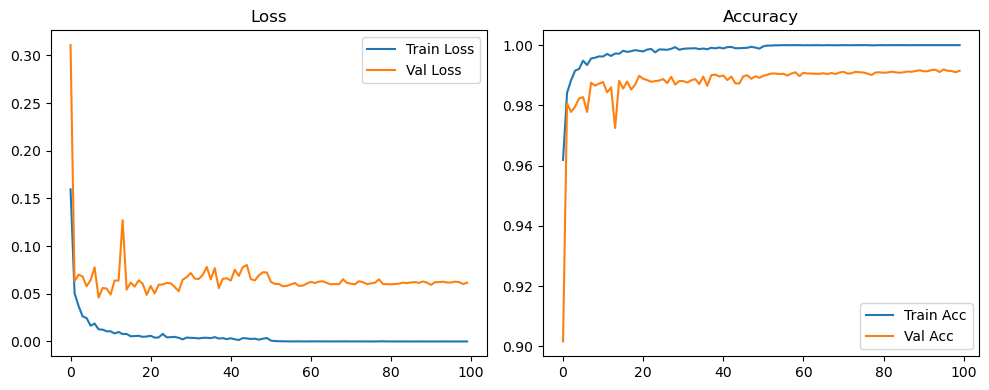

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2048, Acc: 0.9470 | Val Loss: 1.2719, Acc: 0.6066


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0718, Acc: 0.9785 | Val Loss: 1.1754, Acc: 0.6287


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0568, Acc: 0.9829 | Val Loss: 0.5236, Acc: 0.8211


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0463, Acc: 0.9850 | Val Loss: 0.7101, Acc: 0.7847


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0407, Acc: 0.9871 | Val Loss: 0.4512, Acc: 0.8579


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9888 | Val Loss: 0.7570, Acc: 0.7794


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0327, Acc: 0.9898 | Val Loss: 0.6321, Acc: 0.8226


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0300, Acc: 0.9900 | Val Loss: 0.3335, Acc: 0.8971


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9910 | Val Loss: 0.4942, Acc: 0.8595


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9925 | Val Loss: 0.4570, Acc: 0.8738


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9918 | Val Loss: 0.4033, Acc: 0.8883


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0222, Acc: 0.9924 | Val Loss: 0.2678, Acc: 0.9329


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9929 | Val Loss: 0.2343, Acc: 0.9347


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9940 | Val Loss: 0.1928, Acc: 0.9491


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9939 | Val Loss: 0.2008, Acc: 0.9494


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9942 | Val Loss: 0.4447, Acc: 0.8941


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9942 | Val Loss: 0.5022, Acc: 0.8832


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9944 | Val Loss: 0.4729, Acc: 0.8930


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9944 | Val Loss: 0.3545, Acc: 0.9177


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9950 | Val Loss: 0.2583, Acc: 0.9385


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9952 | Val Loss: 0.3185, Acc: 0.9271


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9952 | Val Loss: 0.3481, Acc: 0.9243


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9956 | Val Loss: 0.2010, Acc: 0.9533


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9962 | Val Loss: 0.3264, Acc: 0.9297


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9958 | Val Loss: 0.3500, Acc: 0.9263


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9960 | Val Loss: 0.2103, Acc: 0.9551


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9960 | Val Loss: 0.2045, Acc: 0.9557


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.3246, Acc: 0.9367


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.3373, Acc: 0.9358


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.1939, Acc: 0.9629


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9965 | Val Loss: 0.2438, Acc: 0.9531


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.2026, Acc: 0.9613


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9964 | Val Loss: 0.2482, Acc: 0.9547


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9963 | Val Loss: 0.2696, Acc: 0.9497


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.2172, Acc: 0.9604


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9964 | Val Loss: 0.2191, Acc: 0.9564


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9969 | Val Loss: 0.2609, Acc: 0.9490


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.2153, Acc: 0.9599


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9967 | Val Loss: 0.2266, Acc: 0.9575


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.2356, Acc: 0.9577


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.2008, Acc: 0.9650


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.1931, Acc: 0.9658


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.1652, Acc: 0.9716


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.1820, Acc: 0.9688


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9971 | Val Loss: 0.2063, Acc: 0.9657


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.1463, Acc: 0.9745


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.2470, Acc: 0.9588


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9969 | Val Loss: 0.1698, Acc: 0.9703


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9975 | Val Loss: 0.1673, Acc: 0.9718


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9977 | Val Loss: 0.2934, Acc: 0.9544


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.2484, Acc: 0.9598


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.2179, Acc: 0.9646


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.2204, Acc: 0.9649


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.2345, Acc: 0.9630


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9989 | Val Loss: 0.2458, Acc: 0.9609


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1970, Acc: 0.9684


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9991 | Val Loss: 0.1915, Acc: 0.9689


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.2163, Acc: 0.9668


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1934, Acc: 0.9692


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1954, Acc: 0.9702


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.1715, Acc: 0.9734


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.2109, Acc: 0.9673


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.2038, Acc: 0.9693


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.2087, Acc: 0.9673


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.2658, Acc: 0.9591


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.2158, Acc: 0.9664


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.2460, Acc: 0.9626


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.2455, Acc: 0.9625


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.2450, Acc: 0.9633


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9993 | Val Loss: 0.2139, Acc: 0.9672


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.2126, Acc: 0.9673


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.2224, Acc: 0.9657


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.2528, Acc: 0.9616


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.2076, Acc: 0.9673


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.2117, Acc: 0.9674


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.2172, Acc: 0.9682


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9993 | Val Loss: 0.2114, Acc: 0.9680


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1914, Acc: 0.9713


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.2235, Acc: 0.9671


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1991, Acc: 0.9706


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1810, Acc: 0.9742


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.2116, Acc: 0.9685


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1673, Acc: 0.9748


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1991, Acc: 0.9708


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1936, Acc: 0.9708


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.2039, Acc: 0.9695


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.2256, Acc: 0.9674


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.2331, Acc: 0.9669


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.2435, Acc: 0.9647


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.2207, Acc: 0.9676


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.2144, Acc: 0.9687


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.2265, Acc: 0.9673


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1936, Acc: 0.9726


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.2251, Acc: 0.9672


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.2269, Acc: 0.9673


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9995 | Val Loss: 0.1993, Acc: 0.9704


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1786, Acc: 0.9742


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9994 | Val Loss: 0.1862, Acc: 0.9724


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1837, Acc: 0.9740


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1786, Acc: 0.9749


Final Test Loss: 0.1958 Accuracy: 0.9735


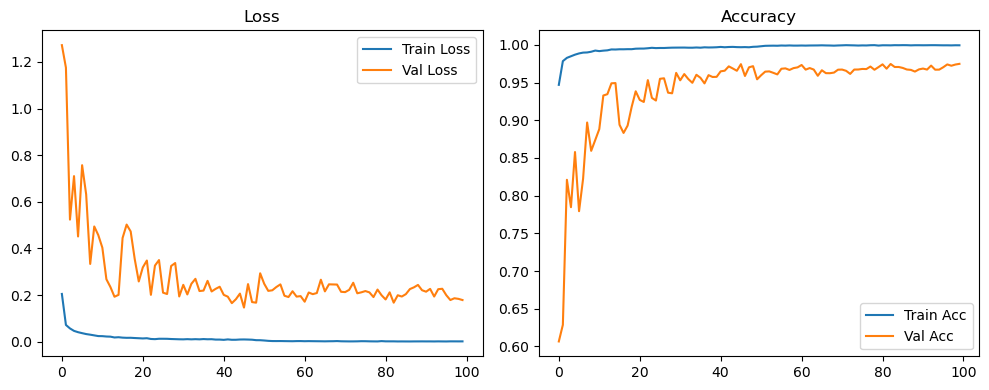

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3679, Acc: 0.8908 | Val Loss: 2.4547, Acc: 0.2976


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1457, Acc: 0.9564 | Val Loss: 3.8979, Acc: 0.2031


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1222, Acc: 0.9637 | Val Loss: 2.8916, Acc: 0.3040


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1052, Acc: 0.9681 | Val Loss: 2.9544, Acc: 0.3200


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0983, Acc: 0.9705 | Val Loss: 2.2216, Acc: 0.4059


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0918, Acc: 0.9723 | Val Loss: 2.8743, Acc: 0.3563


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0879, Acc: 0.9733 | Val Loss: 1.8933, Acc: 0.4771


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0842, Acc: 0.9742 | Val Loss: 1.8977, Acc: 0.4823


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0762, Acc: 0.9768 | Val Loss: 1.1509, Acc: 0.6408


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0730, Acc: 0.9772 | Val Loss: 1.8282, Acc: 0.4462


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0711, Acc: 0.9775 | Val Loss: 1.8749, Acc: 0.5165


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0701, Acc: 0.9788 | Val Loss: 1.9723, Acc: 0.4996


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0689, Acc: 0.9781 | Val Loss: 1.4670, Acc: 0.5628


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0630, Acc: 0.9801 | Val Loss: 1.1528, Acc: 0.6299


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0602, Acc: 0.9816 | Val Loss: 0.9584, Acc: 0.6781


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0626, Acc: 0.9812 | Val Loss: 1.3360, Acc: 0.5963


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0613, Acc: 0.9810 | Val Loss: 1.1581, Acc: 0.6131


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0590, Acc: 0.9812 | Val Loss: 0.9415, Acc: 0.6856


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0573, Acc: 0.9821 | Val Loss: 1.0739, Acc: 0.6534


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0559, Acc: 0.9819 | Val Loss: 0.8239, Acc: 0.7183


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0549, Acc: 0.9825 | Val Loss: 1.2158, Acc: 0.6262


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0544, Acc: 0.9831 | Val Loss: 1.6865, Acc: 0.5207


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0532, Acc: 0.9835 | Val Loss: 1.3047, Acc: 0.6317


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0516, Acc: 0.9840 | Val Loss: 1.0712, Acc: 0.6338


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0503, Acc: 0.9842 | Val Loss: 1.1497, Acc: 0.6397


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0529, Acc: 0.9837 | Val Loss: 1.1778, Acc: 0.6248


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0492, Acc: 0.9843 | Val Loss: 0.9606, Acc: 0.6615


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0479, Acc: 0.9849 | Val Loss: 1.1990, Acc: 0.6086


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9854 | Val Loss: 1.1523, Acc: 0.6396


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0480, Acc: 0.9844 | Val Loss: 0.9265, Acc: 0.6460


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0472, Acc: 0.9852 | Val Loss: 1.1295, Acc: 0.6172


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0458, Acc: 0.9855 | Val Loss: 1.6326, Acc: 0.5094


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9859 | Val Loss: 1.2988, Acc: 0.5297


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0462, Acc: 0.9847 | Val Loss: 1.0415, Acc: 0.5972


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9857 | Val Loss: 1.1921, Acc: 0.5700


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0423, Acc: 0.9866 | Val Loss: 0.8172, Acc: 0.6977


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9859 | Val Loss: 1.1365, Acc: 0.5773


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0409, Acc: 0.9870 | Val Loss: 0.6181, Acc: 0.7393


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0427, Acc: 0.9862 | Val Loss: 0.7917, Acc: 0.6517


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0427, Acc: 0.9867 | Val Loss: 0.8455, Acc: 0.6644


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0427, Acc: 0.9865 | Val Loss: 0.8318, Acc: 0.6712


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0388, Acc: 0.9879 | Val Loss: 0.8609, Acc: 0.5794


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0387, Acc: 0.9879 | Val Loss: 0.9408, Acc: 0.6069


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0400, Acc: 0.9869 | Val Loss: 0.8954, Acc: 0.6149


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0398, Acc: 0.9871 | Val Loss: 0.8503, Acc: 0.6155


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9868 | Val Loss: 0.7614, Acc: 0.6272


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0406, Acc: 0.9874 | Val Loss: 0.9401, Acc: 0.5882


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0384, Acc: 0.9874 | Val Loss: 0.9000, Acc: 0.5608


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0387, Acc: 0.9874 | Val Loss: 1.1696, Acc: 0.4447


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0379, Acc: 0.9879 | Val Loss: 1.0140, Acc: 0.4928


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0301, Acc: 0.9900 | Val Loss: 0.8614, Acc: 0.6048


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0302, Acc: 0.9906 | Val Loss: 0.9268, Acc: 0.5662


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0281, Acc: 0.9910 | Val Loss: 0.9017, Acc: 0.5783


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0269, Acc: 0.9917 | Val Loss: 0.9667, Acc: 0.5341


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0273, Acc: 0.9911 | Val Loss: 1.0314, Acc: 0.5031


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0264, Acc: 0.9912 | Val Loss: 0.9640, Acc: 0.5291


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0256, Acc: 0.9916 | Val Loss: 0.9780, Acc: 0.5343


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0253, Acc: 0.9919 | Val Loss: 0.8842, Acc: 0.5867


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0266, Acc: 0.9910 | Val Loss: 0.8482, Acc: 0.5958


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0247, Acc: 0.9918 | Val Loss: 0.9099, Acc: 0.5578


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0271, Acc: 0.9912 | Val Loss: 0.8156, Acc: 0.5968


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0256, Acc: 0.9920 | Val Loss: 0.8895, Acc: 0.5758


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0258, Acc: 0.9918 | Val Loss: 0.8529, Acc: 0.5837


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0249, Acc: 0.9916 | Val Loss: 0.8730, Acc: 0.5820


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0243, Acc: 0.9922 | Val Loss: 0.8736, Acc: 0.5753


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0245, Acc: 0.9920 | Val Loss: 0.8822, Acc: 0.5553


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0242, Acc: 0.9919 | Val Loss: 0.8928, Acc: 0.5678


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0246, Acc: 0.9925 | Val Loss: 0.8676, Acc: 0.5837


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0236, Acc: 0.9924 | Val Loss: 0.9251, Acc: 0.5455


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0229, Acc: 0.9922 | Val Loss: 0.8829, Acc: 0.5663


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0224, Acc: 0.9927 | Val Loss: 0.8758, Acc: 0.5721


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0243, Acc: 0.9922 | Val Loss: 0.9820, Acc: 0.5112


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0244, Acc: 0.9923 | Val Loss: 0.9201, Acc: 0.5363


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0235, Acc: 0.9916 | Val Loss: 0.8790, Acc: 0.5608


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0234, Acc: 0.9925 | Val Loss: 0.9281, Acc: 0.5463


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0213, Acc: 0.9925 | Val Loss: 0.8636, Acc: 0.5672


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0222, Acc: 0.9926 | Val Loss: 0.8767, Acc: 0.5576


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0214, Acc: 0.9928 | Val Loss: 0.8195, Acc: 0.5879


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0221, Acc: 0.9925 | Val Loss: 0.8810, Acc: 0.5555


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0240, Acc: 0.9919 | Val Loss: 0.8982, Acc: 0.5598


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0238, Acc: 0.9920 | Val Loss: 0.8540, Acc: 0.5658


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0206, Acc: 0.9934 | Val Loss: 0.9322, Acc: 0.5308


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0207, Acc: 0.9930 | Val Loss: 0.9029, Acc: 0.5298


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0225, Acc: 0.9930 | Val Loss: 0.9076, Acc: 0.5471


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0226, Acc: 0.9926 | Val Loss: 0.9350, Acc: 0.5174


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0210, Acc: 0.9930 | Val Loss: 0.9619, Acc: 0.5219


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0221, Acc: 0.9927 | Val Loss: 0.9662, Acc: 0.5137


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0202, Acc: 0.9935 | Val Loss: 0.9794, Acc: 0.5020


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0218, Acc: 0.9929 | Val Loss: 0.9074, Acc: 0.5528


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0208, Acc: 0.9933 | Val Loss: 0.9406, Acc: 0.5315


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0204, Acc: 0.9934 | Val Loss: 0.9365, Acc: 0.5231


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0201, Acc: 0.9933 | Val Loss: 0.9330, Acc: 0.5268


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0203, Acc: 0.9934 | Val Loss: 0.8808, Acc: 0.5454


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0210, Acc: 0.9933 | Val Loss: 0.9126, Acc: 0.5537


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0197, Acc: 0.9931 | Val Loss: 0.9562, Acc: 0.5050


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0199, Acc: 0.9933 | Val Loss: 0.9518, Acc: 0.5125


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0205, Acc: 0.9933 | Val Loss: 0.8912, Acc: 0.5443


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0208, Acc: 0.9929 | Val Loss: 0.8669, Acc: 0.5637


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0193, Acc: 0.9940 | Val Loss: 0.8411, Acc: 0.5674


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0205, Acc: 0.9930 | Val Loss: 0.7812, Acc: 0.6064


Final Test Loss: 0.7699 Accuracy: 0.6141


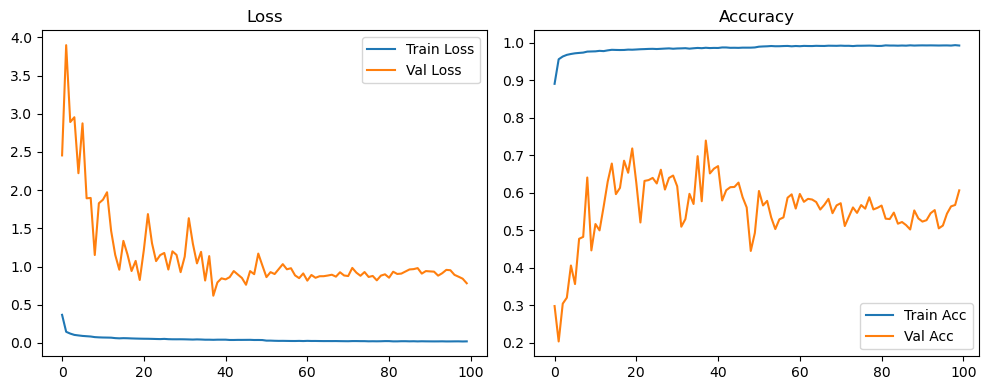

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1949, Acc: 0.9644 | Val Loss: 0.1594, Acc: 0.9509


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0487, Acc: 0.9860 | Val Loss: 0.0598, Acc: 0.9823


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0350, Acc: 0.9891 | Val Loss: 0.0561, Acc: 0.9824


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0248, Acc: 0.9922 | Val Loss: 0.0687, Acc: 0.9795


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0205, Acc: 0.9936 | Val Loss: 0.0567, Acc: 0.9842


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0160, Acc: 0.9949 | Val Loss: 0.0544, Acc: 0.9837


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9952 | Val Loss: 0.0584, Acc: 0.9836


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9967 | Val Loss: 0.0541, Acc: 0.9850


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.0592, Acc: 0.9846


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.0394, Acc: 0.9904


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.0804, Acc: 0.9809


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.0619, Acc: 0.9825


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.2984, Acc: 0.9176


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0465, Acc: 0.9874


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.0451, Acc: 0.9891


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.0428, Acc: 0.9899


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0430, Acc: 0.9892


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.0514, Acc: 0.9872


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0402, Acc: 0.9904


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0538, Acc: 0.9876


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0582, Acc: 0.9862


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0546, Acc: 0.9872


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9981 | Val Loss: 0.0572, Acc: 0.9872


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0460, Acc: 0.9911


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0468, Acc: 0.9900


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0592, Acc: 0.9880


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.0408, Acc: 0.9903


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0414, Acc: 0.9904


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0538, Acc: 0.9883


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.0562, Acc: 0.9882


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0461, Acc: 0.9902


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0416, Acc: 0.9918


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0398, Acc: 0.9920


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0598, Acc: 0.9869


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0484, Acc: 0.9898


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0475, Acc: 0.9912


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0504, Acc: 0.9902


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0485, Acc: 0.9907


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0503, Acc: 0.9905


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0493, Acc: 0.9909


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0637, Acc: 0.9882


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0442, Acc: 0.9912


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1198, Acc: 0.9774


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0462, Acc: 0.9902


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0508, Acc: 0.9898


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0605, Acc: 0.9888


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0506, Acc: 0.9907


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0454, Acc: 0.9914


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0485, Acc: 0.9905


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0496, Acc: 0.9912


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0616, Acc: 0.9881


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0467, Acc: 0.9907


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0508, Acc: 0.9906


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0560, Acc: 0.9897


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0517, Acc: 0.9912


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0624, Acc: 0.9902


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0530, Acc: 0.9912


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0469, Acc: 0.9912


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0546, Acc: 0.9910


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0548, Acc: 0.9892


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.0719, Acc: 0.9883


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0504, Acc: 0.9907


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0481, Acc: 0.9912


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0462, Acc: 0.9919


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0559, Acc: 0.9909


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0608, Acc: 0.9899


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0507, Acc: 0.9921


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0579, Acc: 0.9898


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0576, Acc: 0.9912


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0447, Acc: 0.9918


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0624, Acc: 0.9902


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0556, Acc: 0.9905


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0609, Acc: 0.9898


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0492, Acc: 0.9916


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0642, Acc: 0.9904


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0601, Acc: 0.9903


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0512, Acc: 0.9918


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0620, Acc: 0.9899


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0579, Acc: 0.9903


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0616, Acc: 0.9902


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0566, Acc: 0.9906


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0510, Acc: 0.9920


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0547, Acc: 0.9913


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0617, Acc: 0.9905


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0628, Acc: 0.9907


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0565, Acc: 0.9910


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0491, Acc: 0.9917


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0658, Acc: 0.9905


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0703, Acc: 0.9900


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0604, Acc: 0.9906


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0560, Acc: 0.9908


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0591, Acc: 0.9912


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0533, Acc: 0.9921


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0534, Acc: 0.9912


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0627, Acc: 0.9908


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0673, Acc: 0.9905


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0613, Acc: 0.9912


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0588, Acc: 0.9906


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0583, Acc: 0.9919


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0664, Acc: 0.9902


Final Test Loss: 0.0627 Accuracy: 0.9899


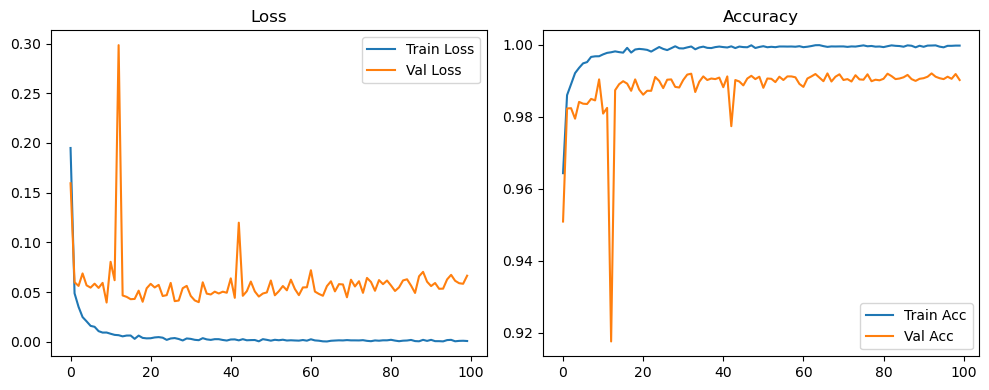

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2487, Acc: 0.9482 | Val Loss: 1.3794, Acc: 0.5964


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0738, Acc: 0.9781 | Val Loss: 1.4919, Acc: 0.5523


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0571, Acc: 0.9825 | Val Loss: 1.1323, Acc: 0.6643


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0460, Acc: 0.9857 | Val Loss: 1.1974, Acc: 0.6836


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0399, Acc: 0.9873 | Val Loss: 0.9456, Acc: 0.7428


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0367, Acc: 0.9888 | Val Loss: 1.4249, Acc: 0.6137


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0318, Acc: 0.9892 | Val Loss: 1.1285, Acc: 0.6875


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0293, Acc: 0.9905 | Val Loss: 1.1027, Acc: 0.7241


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9915 | Val Loss: 0.8894, Acc: 0.7350


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0226, Acc: 0.9928 | Val Loss: 0.6339, Acc: 0.8127


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0222, Acc: 0.9931 | Val Loss: 0.7112, Acc: 0.8360


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0209, Acc: 0.9930 | Val Loss: 0.6635, Acc: 0.8166


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9935 | Val Loss: 0.4956, Acc: 0.8582


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9944 | Val Loss: 0.3379, Acc: 0.9039


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9938 | Val Loss: 0.3682, Acc: 0.8963


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9944 | Val Loss: 0.6114, Acc: 0.8431


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0156, Acc: 0.9948 | Val Loss: 0.6021, Acc: 0.8504


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9949 | Val Loss: 0.4555, Acc: 0.8857


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9956 | Val Loss: 0.7942, Acc: 0.8276


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9955 | Val Loss: 0.5355, Acc: 0.8782


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9959 | Val Loss: 0.5596, Acc: 0.8618


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9957 | Val Loss: 0.4491, Acc: 0.8886


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.4809, Acc: 0.8871


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9962 | Val Loss: 0.4505, Acc: 0.8931


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9964 | Val Loss: 0.5953, Acc: 0.8706


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.2272, Acc: 0.9430


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.3215, Acc: 0.9208


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9966 | Val Loss: 0.4734, Acc: 0.8838


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.2707, Acc: 0.9334


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9965 | Val Loss: 0.3272, Acc: 0.9255


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.3235, Acc: 0.9253


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9964 | Val Loss: 0.2951, Acc: 0.9289


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9965 | Val Loss: 0.4145, Acc: 0.9108


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.4777, Acc: 0.8978


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.4327, Acc: 0.9087


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.2904, Acc: 0.9345


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.4477, Acc: 0.9090


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9974 | Val Loss: 0.2431, Acc: 0.9458


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.2408, Acc: 0.9496


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.2472, Acc: 0.9478


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.2185, Acc: 0.9533


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1629, Acc: 0.9651


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9974 | Val Loss: 0.2499, Acc: 0.9460


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.2607, Acc: 0.9457


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.2569, Acc: 0.9442


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.2672, Acc: 0.9460


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.3259, Acc: 0.9362


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.3369, Acc: 0.9318


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.2345, Acc: 0.9515


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9977 | Val Loss: 0.3102, Acc: 0.9401


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.3080, Acc: 0.9403


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.2928, Acc: 0.9397


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.3699, Acc: 0.9309


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9979 | Val Loss: 0.4447, Acc: 0.9137


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9981 | Val Loss: 0.3546, Acc: 0.9287


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.3822, Acc: 0.9251


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.4495, Acc: 0.9167


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.2605, Acc: 0.9480


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.2119, Acc: 0.9605


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.2289, Acc: 0.9546


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9980 | Val Loss: 0.3544, Acc: 0.9363


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.3334, Acc: 0.9393


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9975 | Val Loss: 0.2401, Acc: 0.9568


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.3669, Acc: 0.9348


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9980 | Val Loss: 0.3243, Acc: 0.9445


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.3145, Acc: 0.9457


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.3089, Acc: 0.9447


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.3859, Acc: 0.9352


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.3429, Acc: 0.9395


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.2303, Acc: 0.9595


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.3764, Acc: 0.9367


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.2827, Acc: 0.9505


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.2393, Acc: 0.9606


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9981 | Val Loss: 0.3335, Acc: 0.9431


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.3600, Acc: 0.9397


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.2899, Acc: 0.9509


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.4521, Acc: 0.9274


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9982 | Val Loss: 0.2544, Acc: 0.9587


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9984 | Val Loss: 0.3297, Acc: 0.9437


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.3011, Acc: 0.9467


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1980, Acc: 0.9667


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.2133, Acc: 0.9636


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.2150, Acc: 0.9643


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.2425, Acc: 0.9583


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.2470, Acc: 0.9566


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.2976, Acc: 0.9499


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.2300, Acc: 0.9615


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.2750, Acc: 0.9541


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.2513, Acc: 0.9583


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.2719, Acc: 0.9539


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9983 | Val Loss: 0.2225, Acc: 0.9628


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.2374, Acc: 0.9603


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.2185, Acc: 0.9641


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.2227, Acc: 0.9660


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.2612, Acc: 0.9577


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.3698, Acc: 0.9406


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.2938, Acc: 0.9531


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.2600, Acc: 0.9617


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.2265, Acc: 0.9645


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.3148, Acc: 0.9516


Final Test Loss: 0.3159 Accuracy: 0.9512


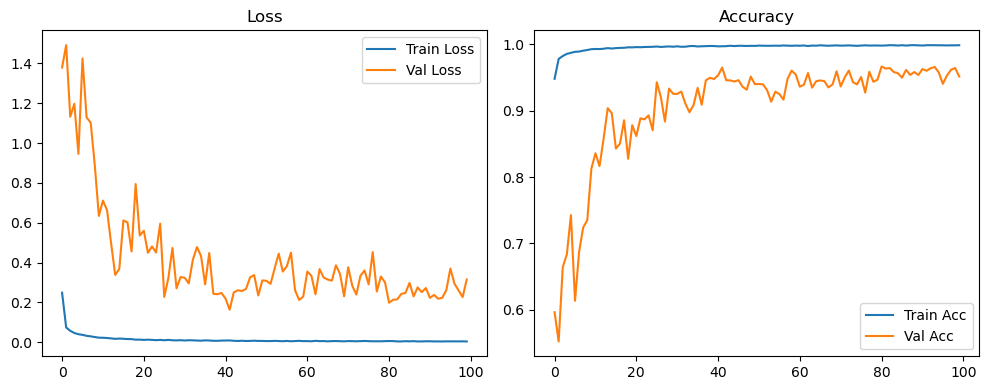

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4465, Acc: 0.8781 | Val Loss: 2.4368, Acc: 0.2182


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1587, Acc: 0.9539 | Val Loss: 4.0420, Acc: 0.1727


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1250, Acc: 0.9626 | Val Loss: 2.3314, Acc: 0.3631


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1066, Acc: 0.9682 | Val Loss: 2.2945, Acc: 0.4025


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0995, Acc: 0.9695 | Val Loss: 2.1595, Acc: 0.4165


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0904, Acc: 0.9723 | Val Loss: 3.0085, Acc: 0.3009


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0867, Acc: 0.9735 | Val Loss: 2.3228, Acc: 0.4069


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0843, Acc: 0.9747 | Val Loss: 2.2455, Acc: 0.4133


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0764, Acc: 0.9768 | Val Loss: 2.0219, Acc: 0.4404


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0729, Acc: 0.9788 | Val Loss: 1.8561, Acc: 0.4855


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0689, Acc: 0.9790 | Val Loss: 2.1605, Acc: 0.4233


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0675, Acc: 0.9789 | Val Loss: 1.6503, Acc: 0.5268


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0673, Acc: 0.9789 | Val Loss: 1.7815, Acc: 0.5068


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0643, Acc: 0.9796 | Val Loss: 2.1871, Acc: 0.4340


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0644, Acc: 0.9814 | Val Loss: 1.9253, Acc: 0.4983


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0605, Acc: 0.9821 | Val Loss: 2.0283, Acc: 0.4501


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0602, Acc: 0.9807 | Val Loss: 1.6586, Acc: 0.5424


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0604, Acc: 0.9811 | Val Loss: 1.4381, Acc: 0.5646


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0575, Acc: 0.9822 | Val Loss: 1.7828, Acc: 0.4958


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0542, Acc: 0.9828 | Val Loss: 1.4199, Acc: 0.5510


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0519, Acc: 0.9834 | Val Loss: 1.1536, Acc: 0.6283


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0547, Acc: 0.9834 | Val Loss: 1.2556, Acc: 0.6023


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0533, Acc: 0.9833 | Val Loss: 1.4691, Acc: 0.5618


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0509, Acc: 0.9831 | Val Loss: 0.9599, Acc: 0.6512


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0508, Acc: 0.9834 | Val Loss: 1.6564, Acc: 0.5325


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0492, Acc: 0.9844 | Val Loss: 1.3530, Acc: 0.5666


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0501, Acc: 0.9842 | Val Loss: 1.4160, Acc: 0.5764


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0492, Acc: 0.9845 | Val Loss: 1.4568, Acc: 0.5589


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0490, Acc: 0.9849 | Val Loss: 2.1483, Acc: 0.4099


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0456, Acc: 0.9856 | Val Loss: 2.1479, Acc: 0.4118


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0475, Acc: 0.9847 | Val Loss: 1.8111, Acc: 0.4772


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0451, Acc: 0.9851 | Val Loss: 1.5854, Acc: 0.5153


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0422, Acc: 0.9867 | Val Loss: 1.6906, Acc: 0.5264


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0456, Acc: 0.9854 | Val Loss: 1.3690, Acc: 0.5317


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0443, Acc: 0.9863 | Val Loss: 1.4359, Acc: 0.4936


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0445, Acc: 0.9861 | Val Loss: 1.4325, Acc: 0.4993


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0424, Acc: 0.9865 | Val Loss: 1.4009, Acc: 0.5179


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0408, Acc: 0.9871 | Val Loss: 1.4142, Acc: 0.4829


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0437, Acc: 0.9860 | Val Loss: 1.2087, Acc: 0.5767


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0418, Acc: 0.9861 | Val Loss: 0.9519, Acc: 0.6576


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0402, Acc: 0.9873 | Val Loss: 0.9680, Acc: 0.6473


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0388, Acc: 0.9875 | Val Loss: 0.9538, Acc: 0.6159


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0394, Acc: 0.9876 | Val Loss: 0.9670, Acc: 0.6198


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0395, Acc: 0.9871 | Val Loss: 1.1757, Acc: 0.5547


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0383, Acc: 0.9879 | Val Loss: 1.4344, Acc: 0.4973


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0422, Acc: 0.9865 | Val Loss: 0.8917, Acc: 0.6188


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0393, Acc: 0.9874 | Val Loss: 0.9281, Acc: 0.6163


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0380, Acc: 0.9876 | Val Loss: 0.7119, Acc: 0.6903


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0384, Acc: 0.9883 | Val Loss: 1.0775, Acc: 0.5521


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0375, Acc: 0.9882 | Val Loss: 0.8722, Acc: 0.6138


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0366, Acc: 0.9888 | Val Loss: 0.6372, Acc: 0.7388


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0378, Acc: 0.9880 | Val Loss: 0.9176, Acc: 0.6125


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0375, Acc: 0.9881 | Val Loss: 0.8013, Acc: 0.6459


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0365, Acc: 0.9879 | Val Loss: 1.1516, Acc: 0.5068


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0374, Acc: 0.9882 | Val Loss: 1.0961, Acc: 0.5297


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0368, Acc: 0.9887 | Val Loss: 0.9880, Acc: 0.5413


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0343, Acc: 0.9890 | Val Loss: 1.0645, Acc: 0.5388


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0343, Acc: 0.9885 | Val Loss: 1.0512, Acc: 0.5529


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0341, Acc: 0.9887 | Val Loss: 0.7608, Acc: 0.6568


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0341, Acc: 0.9892 | Val Loss: 0.7301, Acc: 0.6714


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0384, Acc: 0.9880 | Val Loss: 0.7751, Acc: 0.6396


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0333, Acc: 0.9890 | Val Loss: 0.9921, Acc: 0.5346


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0347, Acc: 0.9892 | Val Loss: 0.6602, Acc: 0.6757


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0338, Acc: 0.9882 | Val Loss: 0.7836, Acc: 0.6136


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0343, Acc: 0.9891 | Val Loss: 0.7751, Acc: 0.6519


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0323, Acc: 0.9893 | Val Loss: 0.7510, Acc: 0.6726


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0325, Acc: 0.9889 | Val Loss: 0.6914, Acc: 0.6915


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0333, Acc: 0.9892 | Val Loss: 0.7727, Acc: 0.6707


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0325, Acc: 0.9892 | Val Loss: 0.7305, Acc: 0.6709


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0328, Acc: 0.9896 | Val Loss: 0.8197, Acc: 0.6132


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0332, Acc: 0.9890 | Val Loss: 0.8340, Acc: 0.6040


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0327, Acc: 0.9894 | Val Loss: 0.9266, Acc: 0.5617


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0329, Acc: 0.9893 | Val Loss: 0.9154, Acc: 0.5267


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0330, Acc: 0.9893 | Val Loss: 0.8849, Acc: 0.5577


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0344, Acc: 0.9893 | Val Loss: 0.9181, Acc: 0.5365


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0304, Acc: 0.9898 | Val Loss: 0.9224, Acc: 0.5601


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0311, Acc: 0.9900 | Val Loss: 0.7134, Acc: 0.6509


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0311, Acc: 0.9901 | Val Loss: 0.9355, Acc: 0.5395


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0295, Acc: 0.9903 | Val Loss: 0.7069, Acc: 0.6498


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0321, Acc: 0.9895 | Val Loss: 0.8215, Acc: 0.6089


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0305, Acc: 0.9900 | Val Loss: 0.8618, Acc: 0.5580


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0303, Acc: 0.9901 | Val Loss: 0.9745, Acc: 0.5454


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0309, Acc: 0.9899 | Val Loss: 0.9474, Acc: 0.4804


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0322, Acc: 0.9898 | Val Loss: 0.8361, Acc: 0.5812


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0309, Acc: 0.9898 | Val Loss: 0.8815, Acc: 0.5716


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0291, Acc: 0.9903 | Val Loss: 0.8583, Acc: 0.5807


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0289, Acc: 0.9903 | Val Loss: 1.0508, Acc: 0.4995


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0294, Acc: 0.9905 | Val Loss: 1.0004, Acc: 0.5107


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0311, Acc: 0.9905 | Val Loss: 1.0158, Acc: 0.4907


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0284, Acc: 0.9908 | Val Loss: 0.9677, Acc: 0.4786


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0282, Acc: 0.9904 | Val Loss: 1.1127, Acc: 0.4318


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0305, Acc: 0.9905 | Val Loss: 1.2920, Acc: 0.3613


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0302, Acc: 0.9903 | Val Loss: 1.0499, Acc: 0.4343


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0302, Acc: 0.9902 | Val Loss: 1.2232, Acc: 0.4065


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0279, Acc: 0.9907 | Val Loss: 1.3124, Acc: 0.3587


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0301, Acc: 0.9901 | Val Loss: 1.1661, Acc: 0.4095


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9898 | Val Loss: 1.0369, Acc: 0.4518


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0315, Acc: 0.9896 | Val Loss: 1.2067, Acc: 0.4267


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0306, Acc: 0.9904 | Val Loss: 1.2840, Acc: 0.4093


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0307, Acc: 0.9901 | Val Loss: 1.1226, Acc: 0.4374


Final Test Loss: 1.1122 Accuracy: 0.4371


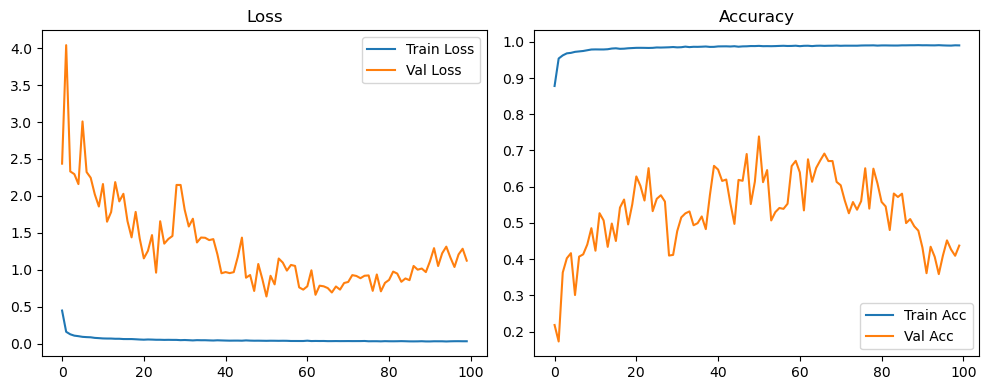

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1949, Acc: 0.9645 | Val Loss: 0.1115, Acc: 0.9678


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0488, Acc: 0.9863 | Val Loss: 0.0757, Acc: 0.9766


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0349, Acc: 0.9891 | Val Loss: 0.0595, Acc: 0.9815


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0248, Acc: 0.9922 | Val Loss: 0.1268, Acc: 0.9577


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0207, Acc: 0.9933 | Val Loss: 0.0641, Acc: 0.9818


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9951 | Val Loss: 0.0695, Acc: 0.9798


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9958 | Val Loss: 0.0385, Acc: 0.9882


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.0438, Acc: 0.9875


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.0769, Acc: 0.9797


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9966 | Val Loss: 0.0373, Acc: 0.9893


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.0513, Acc: 0.9863


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.0502, Acc: 0.9867


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.0374, Acc: 0.9905


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.0488, Acc: 0.9882


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9984 | Val Loss: 0.0455, Acc: 0.9882


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0501, Acc: 0.9882


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0431, Acc: 0.9899


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0488, Acc: 0.9888


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0466, Acc: 0.9896


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.0512, Acc: 0.9892


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0580, Acc: 0.9873


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0441, Acc: 0.9908


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0410, Acc: 0.9906


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0495, Acc: 0.9902


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.0755, Acc: 0.9837


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0597, Acc: 0.9882


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0466, Acc: 0.9898


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0438, Acc: 0.9900


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0439, Acc: 0.9910


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0608, Acc: 0.9874


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0479, Acc: 0.9903


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0454, Acc: 0.9908


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0504, Acc: 0.9905


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0498, Acc: 0.9898


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0483, Acc: 0.9900


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0441, Acc: 0.9902


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0523, Acc: 0.9894


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0692, Acc: 0.9862


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0516, Acc: 0.9907


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0472, Acc: 0.9914


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9999 | Val Loss: 0.0497, Acc: 0.9904


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0956, Acc: 0.9809


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0521, Acc: 0.9895


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0484, Acc: 0.9908


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.0574, Acc: 0.9893


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0500, Acc: 0.9911


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0487, Acc: 0.9910


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0513, Acc: 0.9907


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0564, Acc: 0.9892


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0635, Acc: 0.9885


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0453, Acc: 0.9910


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0435, Acc: 0.9918


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0444, Acc: 0.9910


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0438, Acc: 0.9915


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0474, Acc: 0.9915


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0448, Acc: 0.9912


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0442, Acc: 0.9908


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0411, Acc: 0.9917


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0511, Acc: 0.9911


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0513, Acc: 0.9908


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0429, Acc: 0.9915


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0435, Acc: 0.9916


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0463, Acc: 0.9920


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0471, Acc: 0.9921


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0445, Acc: 0.9920


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0420, Acc: 0.9925


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0437, Acc: 0.9926


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0424, Acc: 0.9924


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0415, Acc: 0.9924


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0418, Acc: 0.9922


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0460, Acc: 0.9922


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0470, Acc: 0.9918


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0446, Acc: 0.9924


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0512, Acc: 0.9914


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0489, Acc: 0.9919


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0438, Acc: 0.9930


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0432, Acc: 0.9931


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0449, Acc: 0.9924


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0435, Acc: 0.9929


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0485, Acc: 0.9913


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0451, Acc: 0.9922


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0451, Acc: 0.9922


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0456, Acc: 0.9921


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0451, Acc: 0.9923


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0451, Acc: 0.9922


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0457, Acc: 0.9922


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0451, Acc: 0.9927


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0474, Acc: 0.9922


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0463, Acc: 0.9922


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0425, Acc: 0.9922


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0446, Acc: 0.9920


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0459, Acc: 0.9915


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0440, Acc: 0.9920


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0446, Acc: 0.9922


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0452, Acc: 0.9918


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0439, Acc: 0.9918


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0454, Acc: 0.9920


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0433, Acc: 0.9921


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0427, Acc: 0.9923


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0435, Acc: 0.9921


Final Test Loss: 0.0528 Accuracy: 0.9916


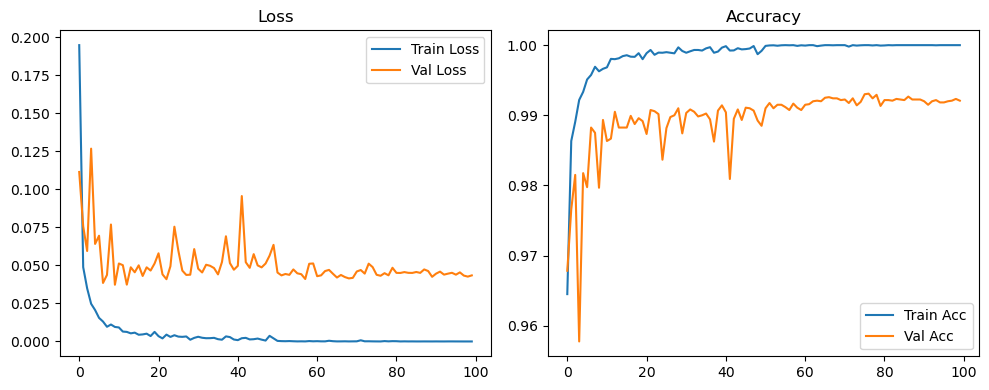

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2482, Acc: 0.9485 | Val Loss: 1.3138, Acc: 0.5990


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0737, Acc: 0.9777 | Val Loss: 1.4090, Acc: 0.5641


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0573, Acc: 0.9821 | Val Loss: 1.2535, Acc: 0.6248


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0459, Acc: 0.9859 | Val Loss: 0.7765, Acc: 0.7546


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0393, Acc: 0.9879 | Val Loss: 1.0153, Acc: 0.7480


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0361, Acc: 0.9890 | Val Loss: 1.4130, Acc: 0.6162


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9897 | Val Loss: 0.9765, Acc: 0.7232


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0291, Acc: 0.9906 | Val Loss: 1.0074, Acc: 0.7067


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0248, Acc: 0.9921 | Val Loss: 0.8352, Acc: 0.7470


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0234, Acc: 0.9924 | Val Loss: 0.6253, Acc: 0.8183


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9935 | Val Loss: 0.5137, Acc: 0.8665


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0216, Acc: 0.9928 | Val Loss: 0.7120, Acc: 0.7998


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0189, Acc: 0.9936 | Val Loss: 0.4312, Acc: 0.8782


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0175, Acc: 0.9943 | Val Loss: 0.3710, Acc: 0.8975


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9941 | Val Loss: 0.5544, Acc: 0.8554


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9942 | Val Loss: 0.8598, Acc: 0.8038


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0156, Acc: 0.9947 | Val Loss: 0.7101, Acc: 0.8241


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9950 | Val Loss: 0.4935, Acc: 0.8771


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9961 | Val Loss: 0.8659, Acc: 0.8124


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9958 | Val Loss: 0.3731, Acc: 0.9048


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9954 | Val Loss: 0.5176, Acc: 0.8752


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9961 | Val Loss: 0.5896, Acc: 0.8534


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.4232, Acc: 0.8966


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.4335, Acc: 0.8929


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9958 | Val Loss: 0.8962, Acc: 0.8167


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9962 | Val Loss: 0.3765, Acc: 0.9089


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9964 | Val Loss: 0.4384, Acc: 0.9002


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.7424, Acc: 0.8321


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.5291, Acc: 0.8819


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9963 | Val Loss: 0.3828, Acc: 0.9118


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9975 | Val Loss: 0.4891, Acc: 0.8922


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9968 | Val Loss: 0.3198, Acc: 0.9290


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9973 | Val Loss: 0.3296, Acc: 0.9263


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.5062, Acc: 0.8912


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9972 | Val Loss: 0.5208, Acc: 0.8876


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.4053, Acc: 0.9135


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.4677, Acc: 0.9003


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.2667, Acc: 0.9414


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9974 | Val Loss: 0.5239, Acc: 0.8966


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.3975, Acc: 0.9214


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.2872, Acc: 0.9389


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9967 | Val Loss: 0.3175, Acc: 0.9321


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9977 | Val Loss: 0.3940, Acc: 0.9222


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.2840, Acc: 0.9426


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.4645, Acc: 0.9041


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.2933, Acc: 0.9400


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.3478, Acc: 0.9334


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9980 | Val Loss: 0.3158, Acc: 0.9369


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.3048, Acc: 0.9408


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.2743, Acc: 0.9433


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.2874, Acc: 0.9450


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.2961, Acc: 0.9413


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.2010, Acc: 0.9596


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.2596, Acc: 0.9475


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.2564, Acc: 0.9511


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.3119, Acc: 0.9407


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.2964, Acc: 0.9431


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.3434, Acc: 0.9370


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.2783, Acc: 0.9481


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.2891, Acc: 0.9457


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.2535, Acc: 0.9525


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.3028, Acc: 0.9444


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.2477, Acc: 0.9542


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.2953, Acc: 0.9475


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.3641, Acc: 0.9337


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.2520, Acc: 0.9541


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.2773, Acc: 0.9483


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.3237, Acc: 0.9407


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.2754, Acc: 0.9504


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.2696, Acc: 0.9517


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.3504, Acc: 0.9394


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.3161, Acc: 0.9429


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.2987, Acc: 0.9478


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.3449, Acc: 0.9393


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.3518, Acc: 0.9374


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.2623, Acc: 0.9546


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.2728, Acc: 0.9509


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.2168, Acc: 0.9610


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.3233, Acc: 0.9440


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.2950, Acc: 0.9485


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.2664, Acc: 0.9545


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.2911, Acc: 0.9488


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.2386, Acc: 0.9585


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.2497, Acc: 0.9553


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.2692, Acc: 0.9536


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.2884, Acc: 0.9517


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.2741, Acc: 0.9533


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.2698, Acc: 0.9536


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.3103, Acc: 0.9479


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.2520, Acc: 0.9569


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.2580, Acc: 0.9564


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.2673, Acc: 0.9555


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.2449, Acc: 0.9591


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.2672, Acc: 0.9545


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.2622, Acc: 0.9548


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.2887, Acc: 0.9511


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.2806, Acc: 0.9513


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.2740, Acc: 0.9535


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.2571, Acc: 0.9557


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.2354, Acc: 0.9594


Final Test Loss: 0.2481 Accuracy: 0.9604


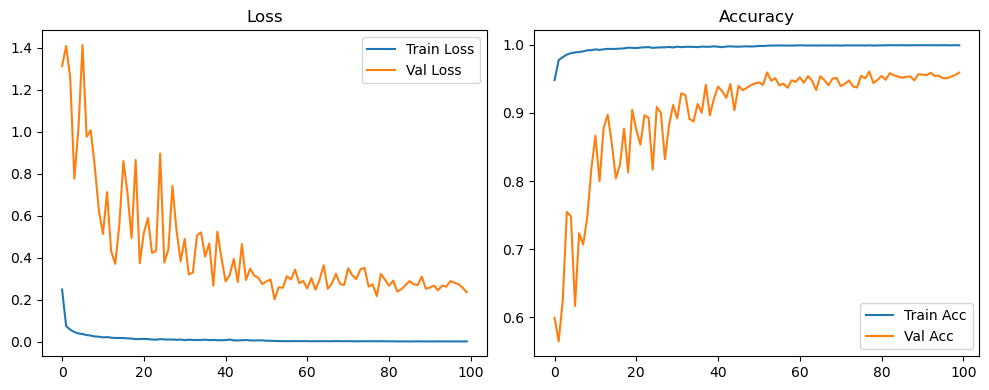

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4464, Acc: 0.8781 | Val Loss: 2.3996, Acc: 0.2292


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1588, Acc: 0.9541 | Val Loss: 3.9905, Acc: 0.1781


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1249, Acc: 0.9629 | Val Loss: 2.3707, Acc: 0.3639


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1066, Acc: 0.9679 | Val Loss: 2.4730, Acc: 0.3713


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0994, Acc: 0.9697 | Val Loss: 2.1305, Acc: 0.4198


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0911, Acc: 0.9722 | Val Loss: 2.8636, Acc: 0.3382


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0872, Acc: 0.9731 | Val Loss: 2.4843, Acc: 0.3847


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0847, Acc: 0.9746 | Val Loss: 2.0898, Acc: 0.4391


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0760, Acc: 0.9774 | Val Loss: 2.0407, Acc: 0.4226


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0729, Acc: 0.9788 | Val Loss: 1.7877, Acc: 0.4966


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0681, Acc: 0.9792 | Val Loss: 2.1117, Acc: 0.4164


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0669, Acc: 0.9790 | Val Loss: 1.6277, Acc: 0.5311


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0672, Acc: 0.9792 | Val Loss: 1.4334, Acc: 0.5827


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0636, Acc: 0.9801 | Val Loss: 1.7797, Acc: 0.5108


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0634, Acc: 0.9808 | Val Loss: 1.7894, Acc: 0.5354


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0610, Acc: 0.9813 | Val Loss: 1.5502, Acc: 0.5570


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0604, Acc: 0.9811 | Val Loss: 1.6911, Acc: 0.5420


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0595, Acc: 0.9810 | Val Loss: 1.4511, Acc: 0.5846


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0582, Acc: 0.9814 | Val Loss: 1.6204, Acc: 0.5565


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0531, Acc: 0.9835 | Val Loss: 1.0663, Acc: 0.6423


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0534, Acc: 0.9832 | Val Loss: 1.3750, Acc: 0.5947


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0543, Acc: 0.9831 | Val Loss: 1.4023, Acc: 0.5862


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0525, Acc: 0.9837 | Val Loss: 1.6817, Acc: 0.5504


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0507, Acc: 0.9839 | Val Loss: 1.2446, Acc: 0.6274


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0507, Acc: 0.9839 | Val Loss: 1.4379, Acc: 0.5818


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0505, Acc: 0.9840 | Val Loss: 1.4218, Acc: 0.5628


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0486, Acc: 0.9845 | Val Loss: 1.6941, Acc: 0.5469


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0489, Acc: 0.9848 | Val Loss: 1.6306, Acc: 0.5470


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0481, Acc: 0.9854 | Val Loss: 1.6574, Acc: 0.5337


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0452, Acc: 0.9854 | Val Loss: 2.1390, Acc: 0.4375


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0460, Acc: 0.9853 | Val Loss: 1.9783, Acc: 0.4635


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0450, Acc: 0.9852 | Val Loss: 1.6795, Acc: 0.5120


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0432, Acc: 0.9870 | Val Loss: 1.7884, Acc: 0.5082


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0466, Acc: 0.9852 | Val Loss: 1.4809, Acc: 0.5178


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0434, Acc: 0.9868 | Val Loss: 1.4510, Acc: 0.5095


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0446, Acc: 0.9861 | Val Loss: 1.2607, Acc: 0.5926


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0421, Acc: 0.9864 | Val Loss: 1.6092, Acc: 0.4993


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0409, Acc: 0.9865 | Val Loss: 1.3011, Acc: 0.5548


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0428, Acc: 0.9863 | Val Loss: 1.3183, Acc: 0.5667


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0418, Acc: 0.9865 | Val Loss: 1.0332, Acc: 0.6198


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0407, Acc: 0.9870 | Val Loss: 1.1119, Acc: 0.5931


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0377, Acc: 0.9876 | Val Loss: 1.0219, Acc: 0.6222


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0396, Acc: 0.9870 | Val Loss: 1.0169, Acc: 0.6208


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0408, Acc: 0.9870 | Val Loss: 1.4432, Acc: 0.5180


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0387, Acc: 0.9875 | Val Loss: 1.3334, Acc: 0.5446


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0422, Acc: 0.9871 | Val Loss: 0.7485, Acc: 0.7061


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0390, Acc: 0.9875 | Val Loss: 0.9788, Acc: 0.6266


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0381, Acc: 0.9873 | Val Loss: 0.7534, Acc: 0.6825


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0373, Acc: 0.9880 | Val Loss: 1.1491, Acc: 0.5644


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0373, Acc: 0.9876 | Val Loss: 0.9251, Acc: 0.6189


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0312, Acc: 0.9895 | Val Loss: 0.9512, Acc: 0.6224


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0314, Acc: 0.9902 | Val Loss: 1.0114, Acc: 0.5988


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0313, Acc: 0.9901 | Val Loss: 0.9318, Acc: 0.6023


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0308, Acc: 0.9897 | Val Loss: 1.1391, Acc: 0.5158


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0287, Acc: 0.9910 | Val Loss: 1.0217, Acc: 0.5497


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0308, Acc: 0.9902 | Val Loss: 1.1329, Acc: 0.5202


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0278, Acc: 0.9911 | Val Loss: 1.1434, Acc: 0.5247


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0260, Acc: 0.9913 | Val Loss: 1.1444, Acc: 0.5413


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0265, Acc: 0.9912 | Val Loss: 1.0031, Acc: 0.5923


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0289, Acc: 0.9907 | Val Loss: 0.9374, Acc: 0.6053


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0295, Acc: 0.9911 | Val Loss: 0.8967, Acc: 0.6124


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0267, Acc: 0.9911 | Val Loss: 1.2071, Acc: 0.5251


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0285, Acc: 0.9908 | Val Loss: 0.9234, Acc: 0.5906


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0272, Acc: 0.9912 | Val Loss: 0.8705, Acc: 0.6232


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0258, Acc: 0.9914 | Val Loss: 0.8257, Acc: 0.6445


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0260, Acc: 0.9915 | Val Loss: 0.7428, Acc: 0.6713


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0267, Acc: 0.9910 | Val Loss: 0.9329, Acc: 0.6132


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0265, Acc: 0.9916 | Val Loss: 0.8688, Acc: 0.6420


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0254, Acc: 0.9917 | Val Loss: 0.9299, Acc: 0.6027


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0256, Acc: 0.9917 | Val Loss: 0.9953, Acc: 0.5725


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0249, Acc: 0.9913 | Val Loss: 0.9937, Acc: 0.5917


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0266, Acc: 0.9912 | Val Loss: 0.9925, Acc: 0.5442


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0268, Acc: 0.9913 | Val Loss: 1.0597, Acc: 0.5274


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0259, Acc: 0.9919 | Val Loss: 0.9096, Acc: 0.5758


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0260, Acc: 0.9910 | Val Loss: 1.0182, Acc: 0.5327


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0260, Acc: 0.9913 | Val Loss: 0.8863, Acc: 0.5802


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0258, Acc: 0.9919 | Val Loss: 0.7877, Acc: 0.6275


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0249, Acc: 0.9921 | Val Loss: 0.8557, Acc: 0.5928


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0236, Acc: 0.9920 | Val Loss: 0.8920, Acc: 0.5809


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0261, Acc: 0.9915 | Val Loss: 0.9444, Acc: 0.5566


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0262, Acc: 0.9911 | Val Loss: 0.8169, Acc: 0.6008


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0226, Acc: 0.9925 | Val Loss: 1.0034, Acc: 0.5262


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0238, Acc: 0.9926 | Val Loss: 0.9151, Acc: 0.5352


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0234, Acc: 0.9926 | Val Loss: 0.9118, Acc: 0.5706


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0236, Acc: 0.9928 | Val Loss: 0.9170, Acc: 0.5579


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0221, Acc: 0.9925 | Val Loss: 0.8864, Acc: 0.5765


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0212, Acc: 0.9930 | Val Loss: 0.9277, Acc: 0.5614


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0233, Acc: 0.9925 | Val Loss: 0.8945, Acc: 0.5744


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0211, Acc: 0.9930 | Val Loss: 0.9739, Acc: 0.5527


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0220, Acc: 0.9932 | Val Loss: 0.9107, Acc: 0.5659


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0214, Acc: 0.9928 | Val Loss: 0.9646, Acc: 0.5441


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0226, Acc: 0.9927 | Val Loss: 0.9252, Acc: 0.5528


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0211, Acc: 0.9931 | Val Loss: 0.8223, Acc: 0.5872


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0225, Acc: 0.9925 | Val Loss: 0.9487, Acc: 0.5734


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0211, Acc: 0.9929 | Val Loss: 0.9661, Acc: 0.5338


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0221, Acc: 0.9927 | Val Loss: 1.0937, Acc: 0.4924


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0222, Acc: 0.9931 | Val Loss: 0.9891, Acc: 0.5180


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0231, Acc: 0.9922 | Val Loss: 0.9626, Acc: 0.5423


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0222, Acc: 0.9927 | Val Loss: 0.9665, Acc: 0.5379


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0228, Acc: 0.9928 | Val Loss: 0.9171, Acc: 0.5607


Final Test Loss: 0.9093 Accuracy: 0.5615


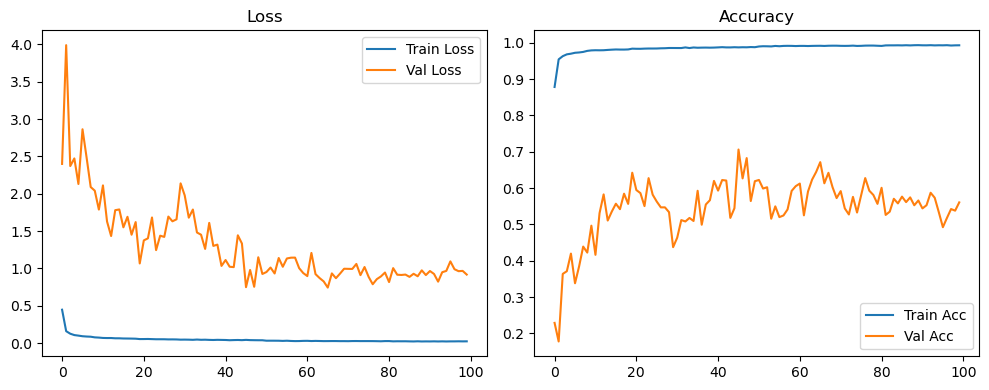

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.3054, Acc: 0.9654 | Val Loss: 0.1494, Acc: 0.9606


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0551, Acc: 0.9870 | Val Loss: 0.1162, Acc: 0.9681


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0371, Acc: 0.9899 | Val Loss: 0.0519, Acc: 0.9841


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0247, Acc: 0.9936 | Val Loss: 0.0696, Acc: 0.9778


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0194, Acc: 0.9948 | Val Loss: 0.1986, Acc: 0.9311


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0154, Acc: 0.9956 | Val Loss: 0.1552, Acc: 0.9524


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0140, Acc: 0.9959 | Val Loss: 0.0780, Acc: 0.9768


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9972 | Val Loss: 0.0388, Acc: 0.9889


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.0497, Acc: 0.9862


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.0508, Acc: 0.9860


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.0533, Acc: 0.9844


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1159, Acc: 0.9688


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9988 | Val Loss: 0.1504, Acc: 0.9581


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.0795, Acc: 0.9789


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.0378, Acc: 0.9900


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9994 | Val Loss: 0.0363, Acc: 0.9909


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0566, Acc: 0.9842


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.0509, Acc: 0.9878


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0412, Acc: 0.9907


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0541, Acc: 0.9862


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0489, Acc: 0.9875


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0642, Acc: 0.9840


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0506, Acc: 0.9883


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.0386, Acc: 0.9899


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0464, Acc: 0.9895


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0433, Acc: 0.9895


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0428, Acc: 0.9892


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0401, Acc: 0.9908


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.0431, Acc: 0.9901


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0406, Acc: 0.9898


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.0450, Acc: 0.9897


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0407, Acc: 0.9902


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0422, Acc: 0.9905


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0404, Acc: 0.9903


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0404, Acc: 0.9915


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0511, Acc: 0.9884


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0440, Acc: 0.9908


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0543, Acc: 0.9883


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0504, Acc: 0.9885


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0410, Acc: 0.9913


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0441, Acc: 0.9902


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9990 | Val Loss: 0.0586, Acc: 0.9867


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0432, Acc: 0.9903


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0399, Acc: 0.9913


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0446, Acc: 0.9905


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0440, Acc: 0.9912


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0662, Acc: 0.9864


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0496, Acc: 0.9888


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0475, Acc: 0.9909


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0534, Acc: 0.9888


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0502, Acc: 0.9900


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0516, Acc: 0.9890


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0516, Acc: 0.9891


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0407, Acc: 0.9915


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0557, Acc: 0.9874


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0553, Acc: 0.9888


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9994 | Val Loss: 0.0459, Acc: 0.9904


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0422, Acc: 0.9915


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0507, Acc: 0.9895


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0530, Acc: 0.9881


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0470, Acc: 0.9900


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0437, Acc: 0.9909


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0429, Acc: 0.9909


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0452, Acc: 0.9911


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0667, Acc: 0.9855


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0533, Acc: 0.9889


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0482, Acc: 0.9902


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.0626, Acc: 0.9872


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0453, Acc: 0.9916


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0467, Acc: 0.9904


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0490, Acc: 0.9911


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0539, Acc: 0.9895


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0477, Acc: 0.9909


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0529, Acc: 0.9899


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0509, Acc: 0.9899


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0462, Acc: 0.9906


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0474, Acc: 0.9910


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0559, Acc: 0.9890


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0466, Acc: 0.9907


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0530, Acc: 0.9900


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0576, Acc: 0.9900


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0668, Acc: 0.9878


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0465, Acc: 0.9911


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0480, Acc: 0.9906


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0497, Acc: 0.9910


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0778, Acc: 0.9852


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0493, Acc: 0.9912


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0826, Acc: 0.9855


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0511, Acc: 0.9902


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0541, Acc: 0.9898


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0479, Acc: 0.9912


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0534, Acc: 0.9900


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0484, Acc: 0.9912


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0572, Acc: 0.9895


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0526, Acc: 0.9903


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0484, Acc: 0.9912


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0492, Acc: 0.9905


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0563, Acc: 0.9885


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0595, Acc: 0.9884


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0496, Acc: 0.9913


Final Test Loss: 0.0485 Accuracy: 0.9898


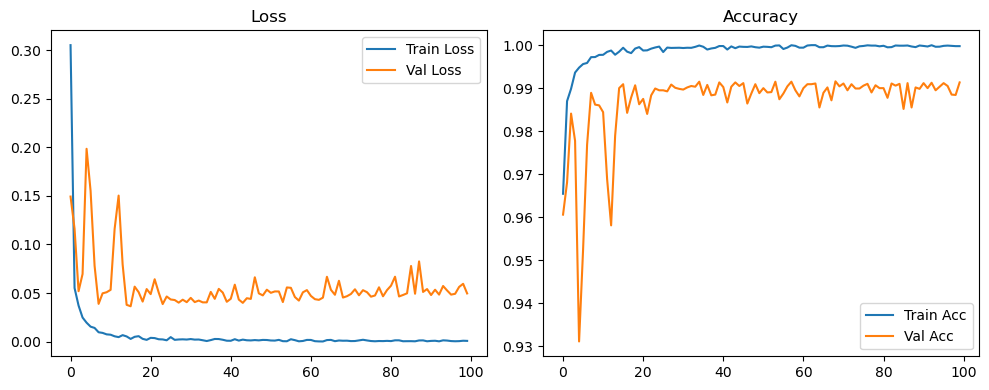

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.3793, Acc: 0.9449 | Val Loss: 1.3254, Acc: 0.4981


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0868, Acc: 0.9774 | Val Loss: 1.7147, Acc: 0.4113


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0646, Acc: 0.9816 | Val Loss: 1.4698, Acc: 0.5316


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0523, Acc: 0.9841 | Val Loss: 1.5500, Acc: 0.5510


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0426, Acc: 0.9876 | Val Loss: 1.3807, Acc: 0.6163


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0393, Acc: 0.9882 | Val Loss: 2.0342, Acc: 0.4155


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0353, Acc: 0.9887 | Val Loss: 1.2848, Acc: 0.6260


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0313, Acc: 0.9900 | Val Loss: 1.6466, Acc: 0.5038


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0275, Acc: 0.9913 | Val Loss: 1.5027, Acc: 0.5655


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0255, Acc: 0.9918 | Val Loss: 1.3185, Acc: 0.6581


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0236, Acc: 0.9922 | Val Loss: 1.5435, Acc: 0.6205


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0222, Acc: 0.9928 | Val Loss: 1.1935, Acc: 0.6547


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0217, Acc: 0.9925 | Val Loss: 1.1697, Acc: 0.6849


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0190, Acc: 0.9939 | Val Loss: 0.9435, Acc: 0.7072


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0181, Acc: 0.9939 | Val Loss: 0.7785, Acc: 0.7595


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0172, Acc: 0.9946 | Val Loss: 1.2450, Acc: 0.6666


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0172, Acc: 0.9944 | Val Loss: 1.0591, Acc: 0.7089


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0157, Acc: 0.9944 | Val Loss: 0.9676, Acc: 0.7309


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9959 | Val Loss: 1.2727, Acc: 0.6596


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0139, Acc: 0.9955 | Val Loss: 0.5380, Acc: 0.8373


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9958 | Val Loss: 0.7648, Acc: 0.7733


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.8461, Acc: 0.7535


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9955 | Val Loss: 0.9751, Acc: 0.7613


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.7017, Acc: 0.8007


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.9348, Acc: 0.7571


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9957 | Val Loss: 0.6381, Acc: 0.8210


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9960 | Val Loss: 0.5924, Acc: 0.8291


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.6006, Acc: 0.8415


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.4619, Acc: 0.8679


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.5300, Acc: 0.8518


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.5580, Acc: 0.8450


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.3761, Acc: 0.8952


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.4666, Acc: 0.8747


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.4883, Acc: 0.8711


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.5131, Acc: 0.8641


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9969 | Val Loss: 0.3687, Acc: 0.9042


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9973 | Val Loss: 0.3877, Acc: 0.9001


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9972 | Val Loss: 0.3113, Acc: 0.9156


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.2728, Acc: 0.9283


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9973 | Val Loss: 0.3424, Acc: 0.9081


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9972 | Val Loss: 0.2927, Acc: 0.9227


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.2671, Acc: 0.9314


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.4685, Acc: 0.8854


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.3533, Acc: 0.9095


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.3740, Acc: 0.9022


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.2484, Acc: 0.9367


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.3023, Acc: 0.9216


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.2839, Acc: 0.9288


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.3469, Acc: 0.9140


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.3409, Acc: 0.9189


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.4453, Acc: 0.8924


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.4066, Acc: 0.9033


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.3925, Acc: 0.9069


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.3660, Acc: 0.9097


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.3577, Acc: 0.9116


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.3149, Acc: 0.9212


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.3843, Acc: 0.9052


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.3247, Acc: 0.9178


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9978 | Val Loss: 0.3186, Acc: 0.9255


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.3586, Acc: 0.9124


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9981 | Val Loss: 0.3117, Acc: 0.9259


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.4199, Acc: 0.9068


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.3611, Acc: 0.9192


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.3418, Acc: 0.9188


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.3063, Acc: 0.9274


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.2643, Acc: 0.9328


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.3515, Acc: 0.9190


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9983 | Val Loss: 0.3206, Acc: 0.9251


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9982 | Val Loss: 0.3368, Acc: 0.9231


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.2320, Acc: 0.9453


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.2863, Acc: 0.9355


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.2728, Acc: 0.9360


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.3927, Acc: 0.9113


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.3997, Acc: 0.9103


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.3916, Acc: 0.9113


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.2661, Acc: 0.9395


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.3508, Acc: 0.9214


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.2997, Acc: 0.9333


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.3731, Acc: 0.9172


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.2825, Acc: 0.9358


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.3314, Acc: 0.9276


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.4176, Acc: 0.9091


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.3538, Acc: 0.9249


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.4011, Acc: 0.9144


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.3584, Acc: 0.9227


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9984 | Val Loss: 0.4840, Acc: 0.9013


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.3833, Acc: 0.9214


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.3010, Acc: 0.9367


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.3584, Acc: 0.9273


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.2920, Acc: 0.9413


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.2648, Acc: 0.9447


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.3582, Acc: 0.9243


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.3725, Acc: 0.9251


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.3322, Acc: 0.9322


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.3486, Acc: 0.9283


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.3023, Acc: 0.9383


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9986 | Val Loss: 0.3561, Acc: 0.9270


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.2749, Acc: 0.9447


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.2916, Acc: 0.9433


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.2690, Acc: 0.9476


Final Test Loss: 0.2834 Accuracy: 0.9461


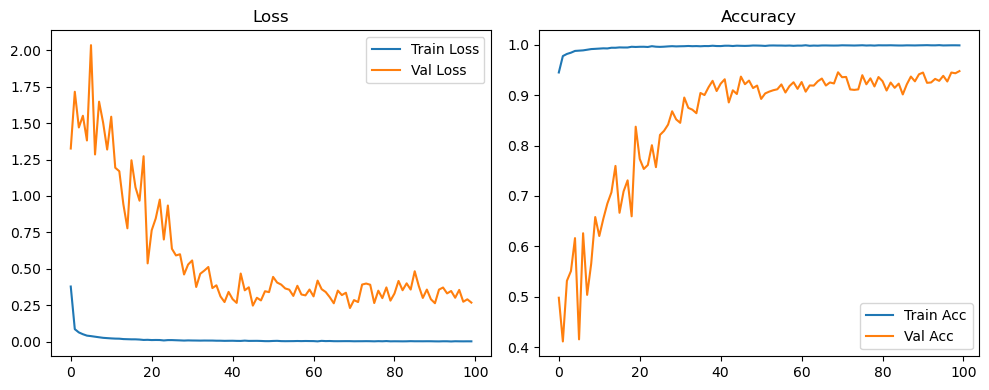

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.6519, Acc: 0.8414 | Val Loss: 2.9671, Acc: 0.1181


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.2078, Acc: 0.9436 | Val Loss: 3.8370, Acc: 0.1307


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1514, Acc: 0.9575 | Val Loss: 3.1732, Acc: 0.2113


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.1253, Acc: 0.9632 | Val Loss: 3.2267, Acc: 0.2123


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.1119, Acc: 0.9666 | Val Loss: 3.0897, Acc: 0.2330


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0990, Acc: 0.9702 | Val Loss: 3.5244, Acc: 0.2222


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0957, Acc: 0.9712 | Val Loss: 4.1484, Acc: 0.2097


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0891, Acc: 0.9736 | Val Loss: 3.7423, Acc: 0.2411


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0837, Acc: 0.9745 | Val Loss: 3.4496, Acc: 0.2227


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0784, Acc: 0.9771 | Val Loss: 3.3334, Acc: 0.2614


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0742, Acc: 0.9773 | Val Loss: 3.5398, Acc: 0.2822


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0734, Acc: 0.9778 | Val Loss: 3.1794, Acc: 0.2547


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0710, Acc: 0.9778 | Val Loss: 2.8831, Acc: 0.2787


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0676, Acc: 0.9792 | Val Loss: 2.7733, Acc: 0.3068


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0655, Acc: 0.9808 | Val Loss: 3.1434, Acc: 0.2684


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0650, Acc: 0.9798 | Val Loss: 2.5528, Acc: 0.3327


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0635, Acc: 0.9812 | Val Loss: 2.6186, Acc: 0.3349


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0640, Acc: 0.9808 | Val Loss: 2.4402, Acc: 0.3526


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0603, Acc: 0.9814 | Val Loss: 3.2118, Acc: 0.2637


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0583, Acc: 0.9823 | Val Loss: 2.2676, Acc: 0.3817


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0567, Acc: 0.9828 | Val Loss: 1.8141, Acc: 0.4413


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0569, Acc: 0.9829 | Val Loss: 2.6468, Acc: 0.3280


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0538, Acc: 0.9834 | Val Loss: 2.3766, Acc: 0.3767


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0543, Acc: 0.9835 | Val Loss: 1.7355, Acc: 0.4762


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0540, Acc: 0.9834 | Val Loss: 2.1101, Acc: 0.4328


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0540, Acc: 0.9826 | Val Loss: 2.0751, Acc: 0.4188


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0519, Acc: 0.9839 | Val Loss: 2.5198, Acc: 0.3773


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0514, Acc: 0.9838 | Val Loss: 2.1405, Acc: 0.4112


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0507, Acc: 0.9845 | Val Loss: 1.9157, Acc: 0.4674


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0457, Acc: 0.9861 | Val Loss: 2.0102, Acc: 0.4521


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0491, Acc: 0.9844 | Val Loss: 2.3520, Acc: 0.3933


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0475, Acc: 0.9856 | Val Loss: 1.7962, Acc: 0.4996


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0466, Acc: 0.9859 | Val Loss: 2.2163, Acc: 0.4415


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0489, Acc: 0.9851 | Val Loss: 1.7298, Acc: 0.4988


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0440, Acc: 0.9864 | Val Loss: 2.0926, Acc: 0.4407


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0481, Acc: 0.9847 | Val Loss: 1.5162, Acc: 0.5637


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0446, Acc: 0.9861 | Val Loss: 1.6329, Acc: 0.5184


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0420, Acc: 0.9869 | Val Loss: 1.6569, Acc: 0.5256


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0430, Acc: 0.9861 | Val Loss: 1.4475, Acc: 0.5798


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0461, Acc: 0.9860 | Val Loss: 1.4677, Acc: 0.5753


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0413, Acc: 0.9870 | Val Loss: 1.5870, Acc: 0.5394


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0427, Acc: 0.9862 | Val Loss: 1.1888, Acc: 0.6260


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0406, Acc: 0.9873 | Val Loss: 1.6056, Acc: 0.5023


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0417, Acc: 0.9865 | Val Loss: 1.6105, Acc: 0.5407


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0378, Acc: 0.9874 | Val Loss: 1.5545, Acc: 0.5586


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0428, Acc: 0.9870 | Val Loss: 1.0741, Acc: 0.6570


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0409, Acc: 0.9869 | Val Loss: 1.2251, Acc: 0.6088


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0389, Acc: 0.9876 | Val Loss: 1.2650, Acc: 0.5797


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0396, Acc: 0.9877 | Val Loss: 1.6566, Acc: 0.5326


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0386, Acc: 0.9880 | Val Loss: 1.3212, Acc: 0.5653


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0385, Acc: 0.9878 | Val Loss: 1.3943, Acc: 0.5854


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0404, Acc: 0.9872 | Val Loss: 1.2532, Acc: 0.6347


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0369, Acc: 0.9881 | Val Loss: 1.1323, Acc: 0.6421


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0376, Acc: 0.9882 | Val Loss: 1.4019, Acc: 0.5852


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0370, Acc: 0.9880 | Val Loss: 1.3119, Acc: 0.5988


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0373, Acc: 0.9885 | Val Loss: 1.7690, Acc: 0.4849


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0351, Acc: 0.9890 | Val Loss: 1.3974, Acc: 0.5723


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0349, Acc: 0.9887 | Val Loss: 1.2546, Acc: 0.6122


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0347, Acc: 0.9891 | Val Loss: 1.1270, Acc: 0.6245


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0371, Acc: 0.9879 | Val Loss: 0.9401, Acc: 0.6647


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0378, Acc: 0.9876 | Val Loss: 0.8553, Acc: 0.6775


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0347, Acc: 0.9893 | Val Loss: 1.2455, Acc: 0.5975


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0360, Acc: 0.9888 | Val Loss: 1.0841, Acc: 0.6290


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0356, Acc: 0.9884 | Val Loss: 1.0253, Acc: 0.6446


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0341, Acc: 0.9892 | Val Loss: 1.2776, Acc: 0.5884


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0318, Acc: 0.9894 | Val Loss: 1.0536, Acc: 0.6269


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0342, Acc: 0.9888 | Val Loss: 1.0323, Acc: 0.6361


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0339, Acc: 0.9895 | Val Loss: 1.3806, Acc: 0.5620


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0330, Acc: 0.9897 | Val Loss: 1.3018, Acc: 0.5846


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0338, Acc: 0.9886 | Val Loss: 1.5001, Acc: 0.4928


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0329, Acc: 0.9893 | Val Loss: 1.1680, Acc: 0.6142


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0316, Acc: 0.9898 | Val Loss: 1.1661, Acc: 0.6056


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0348, Acc: 0.9890 | Val Loss: 1.2413, Acc: 0.5665


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0326, Acc: 0.9895 | Val Loss: 1.0182, Acc: 0.6280


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0331, Acc: 0.9900 | Val Loss: 1.4864, Acc: 0.5385


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0313, Acc: 0.9901 | Val Loss: 1.2447, Acc: 0.5716


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0319, Acc: 0.9897 | Val Loss: 1.1099, Acc: 0.6098


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0319, Acc: 0.9904 | Val Loss: 1.0209, Acc: 0.6393


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0310, Acc: 0.9903 | Val Loss: 1.3931, Acc: 0.5459


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0340, Acc: 0.9895 | Val Loss: 1.1859, Acc: 0.5891


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0331, Acc: 0.9895 | Val Loss: 1.1016, Acc: 0.6252


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0313, Acc: 0.9898 | Val Loss: 1.2488, Acc: 0.5877


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0303, Acc: 0.9902 | Val Loss: 1.3284, Acc: 0.5240


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0313, Acc: 0.9901 | Val Loss: 1.3646, Acc: 0.5464


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0314, Acc: 0.9901 | Val Loss: 1.3862, Acc: 0.5004


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0301, Acc: 0.9900 | Val Loss: 1.3038, Acc: 0.5349


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0294, Acc: 0.9906 | Val Loss: 1.1155, Acc: 0.5893


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0290, Acc: 0.9905 | Val Loss: 1.2296, Acc: 0.5403


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0323, Acc: 0.9901 | Val Loss: 1.4248, Acc: 0.5128


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0308, Acc: 0.9901 | Val Loss: 1.1913, Acc: 0.5614


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0276, Acc: 0.9908 | Val Loss: 1.3005, Acc: 0.5577


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0302, Acc: 0.9898 | Val Loss: 1.4661, Acc: 0.5062


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0306, Acc: 0.9899 | Val Loss: 1.1252, Acc: 0.5378


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0323, Acc: 0.9895 | Val Loss: 1.2470, Acc: 0.5642


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0295, Acc: 0.9899 | Val Loss: 1.2220, Acc: 0.5780


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0287, Acc: 0.9909 | Val Loss: 1.4580, Acc: 0.5019


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0301, Acc: 0.9898 | Val Loss: 1.1343, Acc: 0.5753


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0293, Acc: 0.9904 | Val Loss: 1.0733, Acc: 0.6041


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0293, Acc: 0.9905 | Val Loss: 1.0670, Acc: 0.6320


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0293, Acc: 0.9904 | Val Loss: 1.0444, Acc: 0.6301


Final Test Loss: 1.0332 Accuracy: 0.6289


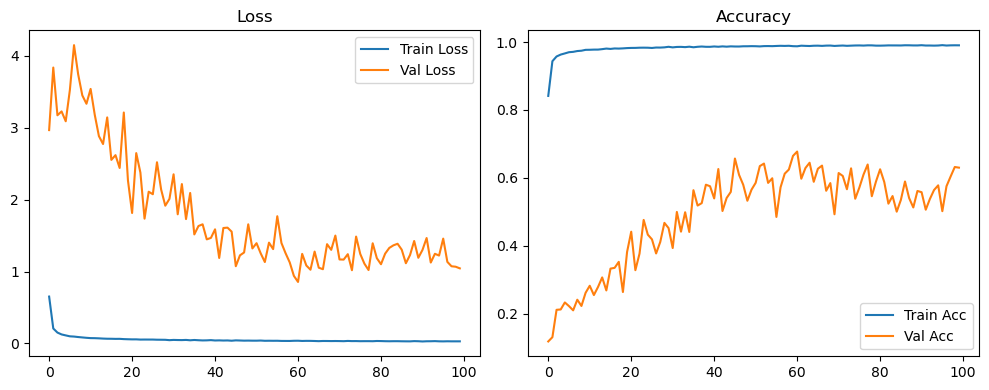

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.4690, Acc: 0.9630 | Val Loss: 0.1876, Acc: 0.9640


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0780, Acc: 0.9867 | Val Loss: 0.0777, Acc: 0.9834


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0465, Acc: 0.9897 | Val Loss: 0.0519, Acc: 0.9871


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0306, Acc: 0.9931 | Val Loss: 0.0658, Acc: 0.9808


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0229, Acc: 0.9947 | Val Loss: 0.0653, Acc: 0.9802


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0164, Acc: 0.9962 | Val Loss: 0.0886, Acc: 0.9740


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0152, Acc: 0.9962 | Val Loss: 0.0636, Acc: 0.9807


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9975 | Val Loss: 0.0485, Acc: 0.9857


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9977 | Val Loss: 0.0406, Acc: 0.9875


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9978 | Val Loss: 0.0470, Acc: 0.9855


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9982 | Val Loss: 0.0407, Acc: 0.9876


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9985 | Val Loss: 0.0543, Acc: 0.9834


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9988 | Val Loss: 0.1411, Acc: 0.9568


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9986 | Val Loss: 0.0511, Acc: 0.9852


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9993 | Val Loss: 0.0500, Acc: 0.9865


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.0458, Acc: 0.9881


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9991 | Val Loss: 0.0726, Acc: 0.9798


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.0516, Acc: 0.9863


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9995 | Val Loss: 0.0451, Acc: 0.9888


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9995 | Val Loss: 0.0590, Acc: 0.9842


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0469, Acc: 0.9872


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.0538, Acc: 0.9852


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0809, Acc: 0.9759


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0477, Acc: 0.9868


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.0594, Acc: 0.9846


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9995 | Val Loss: 0.0361, Acc: 0.9911


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1445, Acc: 0.9633


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0420, Acc: 0.9899


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9998 | Val Loss: 0.0492, Acc: 0.9886


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0371, Acc: 0.9907


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.0655, Acc: 0.9833


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.0425, Acc: 0.9892


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0414, Acc: 0.9891


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.0354, Acc: 0.9910


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.2829, Acc: 0.9334


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0472, Acc: 0.9890


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0432, Acc: 0.9898


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0528, Acc: 0.9862


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0466, Acc: 0.9880


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0474, Acc: 0.9880


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0425, Acc: 0.9898


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0424, Acc: 0.9901


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0690, Acc: 0.9845


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0457, Acc: 0.9895


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0471, Acc: 0.9892


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0450, Acc: 0.9893


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0400, Acc: 0.9897


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0497, Acc: 0.9884


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0417, Acc: 0.9903


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0451, Acc: 0.9888


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1176, Acc: 0.9742


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0468, Acc: 0.9882


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0443, Acc: 0.9896


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.0383, Acc: 0.9903


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0438, Acc: 0.9894


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0571, Acc: 0.9876


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0459, Acc: 0.9898


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0515, Acc: 0.9880


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0447, Acc: 0.9892


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0460, Acc: 0.9902


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0526, Acc: 0.9893


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0449, Acc: 0.9897


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0457, Acc: 0.9896


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0698, Acc: 0.9836


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0499, Acc: 0.9886


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0441, Acc: 0.9905


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0447, Acc: 0.9905


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0777, Acc: 0.9841


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0517, Acc: 0.9890


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0515, Acc: 0.9892


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0488, Acc: 0.9903


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0519, Acc: 0.9898


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0486, Acc: 0.9902


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0506, Acc: 0.9889


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0499, Acc: 0.9901


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0459, Acc: 0.9898


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0463, Acc: 0.9908


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0587, Acc: 0.9871


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0578, Acc: 0.9888


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0489, Acc: 0.9894


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0726, Acc: 0.9860


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0465, Acc: 0.9901


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0459, Acc: 0.9906


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0509, Acc: 0.9884


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0427, Acc: 0.9914


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0829, Acc: 0.9846


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0499, Acc: 0.9895


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0563, Acc: 0.9884


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0480, Acc: 0.9899


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0494, Acc: 0.9906


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0494, Acc: 0.9891


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0456, Acc: 0.9911


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0439, Acc: 0.9903


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0448, Acc: 0.9913


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0473, Acc: 0.9901


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0539, Acc: 0.9888


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0460, Acc: 0.9901


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0447, Acc: 0.9903


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0451, Acc: 0.9908


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0414, Acc: 0.9916


Final Test Loss: 0.0407 Accuracy: 0.9914


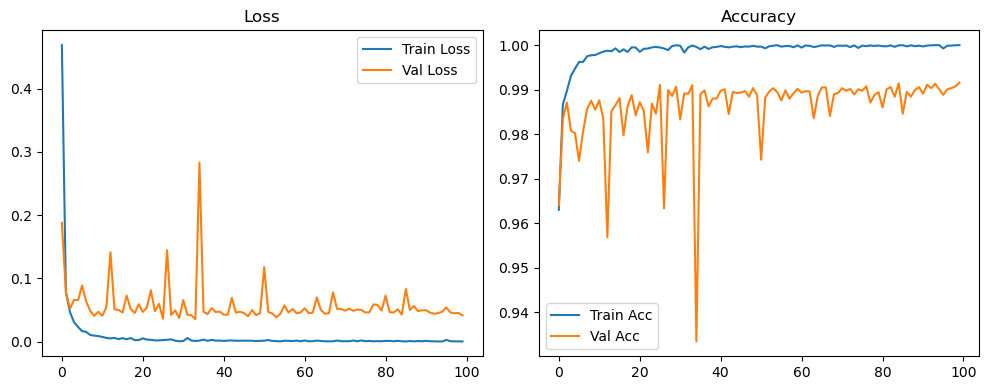

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.5661, Acc: 0.9367 | Val Loss: 1.4346, Acc: 0.4026


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1218, Acc: 0.9757 | Val Loss: 1.4777, Acc: 0.4416


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0794, Acc: 0.9806 | Val Loss: 1.4129, Acc: 0.5258


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0621, Acc: 0.9829 | Val Loss: 1.5477, Acc: 0.5182


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0502, Acc: 0.9861 | Val Loss: 1.2638, Acc: 0.5721


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0442, Acc: 0.9874 | Val Loss: 1.9147, Acc: 0.4105


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0403, Acc: 0.9885 | Val Loss: 1.3942, Acc: 0.5640


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0360, Acc: 0.9889 | Val Loss: 2.2257, Acc: 0.3448


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0313, Acc: 0.9909 | Val Loss: 1.8593, Acc: 0.4480


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0297, Acc: 0.9909 | Val Loss: 2.1657, Acc: 0.4084


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0275, Acc: 0.9911 | Val Loss: 2.2362, Acc: 0.4637


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0248, Acc: 0.9921 | Val Loss: 1.8901, Acc: 0.5058


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0249, Acc: 0.9920 | Val Loss: 2.3363, Acc: 0.4188


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0215, Acc: 0.9933 | Val Loss: 2.1225, Acc: 0.4858


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0203, Acc: 0.9935 | Val Loss: 1.2950, Acc: 0.6543


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0203, Acc: 0.9935 | Val Loss: 1.7189, Acc: 0.5537


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0189, Acc: 0.9944 | Val Loss: 1.5105, Acc: 0.5862


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0169, Acc: 0.9944 | Val Loss: 1.7343, Acc: 0.5863


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0159, Acc: 0.9952 | Val Loss: 1.8730, Acc: 0.5313


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0156, Acc: 0.9948 | Val Loss: 0.8751, Acc: 0.7547


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0150, Acc: 0.9953 | Val Loss: 1.2169, Acc: 0.6640


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0140, Acc: 0.9955 | Val Loss: 1.4796, Acc: 0.5788


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0144, Acc: 0.9950 | Val Loss: 1.1086, Acc: 0.7107


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9960 | Val Loss: 1.2630, Acc: 0.6719


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9957 | Val Loss: 1.1382, Acc: 0.6874


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0127, Acc: 0.9957 | Val Loss: 1.3308, Acc: 0.6440


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0125, Acc: 0.9958 | Val Loss: 0.6754, Acc: 0.8021


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.7998, Acc: 0.7942


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.8114, Acc: 0.7603


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.6435, Acc: 0.8113


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.7062, Acc: 0.7947


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9964 | Val Loss: 0.5505, Acc: 0.8457


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9967 | Val Loss: 0.7760, Acc: 0.7782


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.8778, Acc: 0.7587


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.6892, Acc: 0.8084


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.7833, Acc: 0.7942


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 1.0144, Acc: 0.7484


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.5866, Acc: 0.8414


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.6920, Acc: 0.8281


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.6663, Acc: 0.8259


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.5362, Acc: 0.8599


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9972 | Val Loss: 0.4576, Acc: 0.8692


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.6292, Acc: 0.8403


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.6462, Acc: 0.8315


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.5600, Acc: 0.8488


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9977 | Val Loss: 0.4894, Acc: 0.8709


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.6642, Acc: 0.8281


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.6096, Acc: 0.8361


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.5009, Acc: 0.8716


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9979 | Val Loss: 0.4594, Acc: 0.8784


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.4369, Acc: 0.8853


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.6882, Acc: 0.8336


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.3743, Acc: 0.8997


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.4226, Acc: 0.8872


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.3839, Acc: 0.8950


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.4474, Acc: 0.8813


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9979 | Val Loss: 0.5782, Acc: 0.8601


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.4803, Acc: 0.8845


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.4518, Acc: 0.8886


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.3899, Acc: 0.9065


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.3366, Acc: 0.9183


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.4833, Acc: 0.8818


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.4732, Acc: 0.8928


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.5898, Acc: 0.8626


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.5119, Acc: 0.8817


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.4571, Acc: 0.8882


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.2973, Acc: 0.9267


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.3947, Acc: 0.8996


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.5152, Acc: 0.8748


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9982 | Val Loss: 0.4321, Acc: 0.8959


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9984 | Val Loss: 0.4981, Acc: 0.8861


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.4073, Acc: 0.8973


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.5031, Acc: 0.8786


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9980 | Val Loss: 0.4323, Acc: 0.8957


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.4865, Acc: 0.8830


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.3373, Acc: 0.9203


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.3730, Acc: 0.9094


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.4216, Acc: 0.9012


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.3645, Acc: 0.9159


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.3337, Acc: 0.9196


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.4250, Acc: 0.9011


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.5167, Acc: 0.8786


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.4397, Acc: 0.8963


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.3896, Acc: 0.9062


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.4734, Acc: 0.8894


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.5058, Acc: 0.8840


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.3797, Acc: 0.9118


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.3113, Acc: 0.9281


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.3905, Acc: 0.9113


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.3437, Acc: 0.9222


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.3336, Acc: 0.9263


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.4326, Acc: 0.9098


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.3719, Acc: 0.9182


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.4608, Acc: 0.9012


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.5081, Acc: 0.8855


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.3118, Acc: 0.9291


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.4931, Acc: 0.8952


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.3182, Acc: 0.9331


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.3134, Acc: 0.9263


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.3572, Acc: 0.9203


Final Test Loss: 0.3675 Accuracy: 0.9202


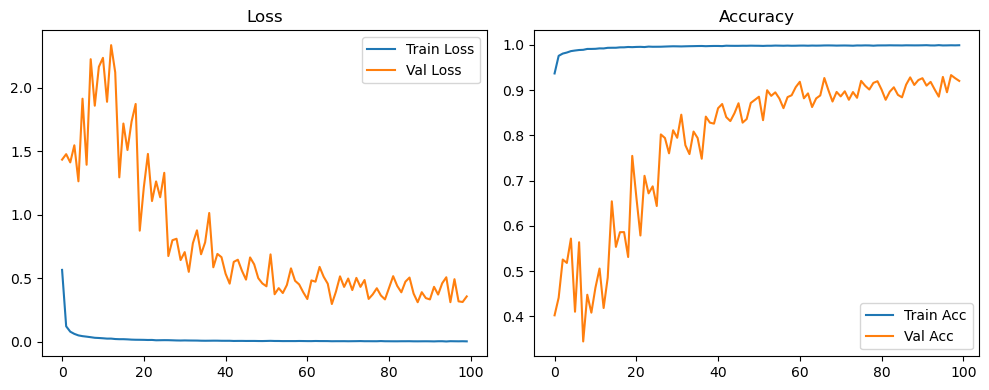

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.9060, Acc: 0.7957 | Val Loss: 3.0027, Acc: 0.1133


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.3071, Acc: 0.9256 | Val Loss: 3.4450, Acc: 0.1178


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.2023, Acc: 0.9469 | Val Loss: 2.8698, Acc: 0.2108


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.1600, Acc: 0.9553 | Val Loss: 2.9751, Acc: 0.2152


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.1378, Acc: 0.9602 | Val Loss: 2.9750, Acc: 0.2182


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.1195, Acc: 0.9659 | Val Loss: 2.9815, Acc: 0.2376


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.1133, Acc: 0.9666 | Val Loss: 3.3155, Acc: 0.2429


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.1024, Acc: 0.9710 | Val Loss: 3.3002, Acc: 0.2269


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0969, Acc: 0.9713 | Val Loss: 3.3116, Acc: 0.2180


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0898, Acc: 0.9738 | Val Loss: 3.1746, Acc: 0.2621


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0843, Acc: 0.9749 | Val Loss: 3.3407, Acc: 0.2270


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0816, Acc: 0.9754 | Val Loss: 3.4869, Acc: 0.2251


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0805, Acc: 0.9754 | Val Loss: 3.5162, Acc: 0.2200


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0771, Acc: 0.9769 | Val Loss: 3.3066, Acc: 0.2388


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0725, Acc: 0.9780 | Val Loss: 3.2574, Acc: 0.2469


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0722, Acc: 0.9781 | Val Loss: 3.1489, Acc: 0.2578


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0687, Acc: 0.9786 | Val Loss: 2.9587, Acc: 0.2714


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0702, Acc: 0.9783 | Val Loss: 3.0226, Acc: 0.2650


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0667, Acc: 0.9801 | Val Loss: 3.4630, Acc: 0.2474


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0646, Acc: 0.9802 | Val Loss: 2.8569, Acc: 0.2918


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0611, Acc: 0.9814 | Val Loss: 2.7412, Acc: 0.3085


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0626, Acc: 0.9804 | Val Loss: 3.3456, Acc: 0.2496


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0601, Acc: 0.9818 | Val Loss: 3.5091, Acc: 0.2620


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0586, Acc: 0.9817 | Val Loss: 2.8591, Acc: 0.3059


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0585, Acc: 0.9815 | Val Loss: 2.8808, Acc: 0.3358


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0584, Acc: 0.9821 | Val Loss: 3.1281, Acc: 0.2962


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0584, Acc: 0.9822 | Val Loss: 3.1622, Acc: 0.3131


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0547, Acc: 0.9832 | Val Loss: 2.6861, Acc: 0.3590


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0556, Acc: 0.9827 | Val Loss: 2.8705, Acc: 0.3463


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0524, Acc: 0.9836 | Val Loss: 2.8005, Acc: 0.3741


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0525, Acc: 0.9836 | Val Loss: 2.8654, Acc: 0.3333


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0519, Acc: 0.9845 | Val Loss: 2.7951, Acc: 0.3384


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0526, Acc: 0.9836 | Val Loss: 2.9161, Acc: 0.3443


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0528, Acc: 0.9836 | Val Loss: 2.3452, Acc: 0.3841


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0495, Acc: 0.9848 | Val Loss: 2.7382, Acc: 0.3247


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0525, Acc: 0.9841 | Val Loss: 2.1859, Acc: 0.4336


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0482, Acc: 0.9851 | Val Loss: 2.2716, Acc: 0.4163


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0456, Acc: 0.9855 | Val Loss: 2.3352, Acc: 0.4113


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0478, Acc: 0.9842 | Val Loss: 1.9946, Acc: 0.4708


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0487, Acc: 0.9858 | Val Loss: 2.0209, Acc: 0.4534


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0456, Acc: 0.9860 | Val Loss: 1.8958, Acc: 0.4888


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0463, Acc: 0.9859 | Val Loss: 1.7036, Acc: 0.5081


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0444, Acc: 0.9866 | Val Loss: 2.4694, Acc: 0.3476


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0464, Acc: 0.9857 | Val Loss: 2.4679, Acc: 0.4168


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0442, Acc: 0.9861 | Val Loss: 2.4126, Acc: 0.3757


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0468, Acc: 0.9853 | Val Loss: 2.0884, Acc: 0.4417


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0446, Acc: 0.9860 | Val Loss: 1.6021, Acc: 0.5322


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0414, Acc: 0.9867 | Val Loss: 1.9622, Acc: 0.4379


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0451, Acc: 0.9863 | Val Loss: 2.4670, Acc: 0.3767


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0438, Acc: 0.9868 | Val Loss: 1.9039, Acc: 0.4483


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0415, Acc: 0.9871 | Val Loss: 1.9999, Acc: 0.4318


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0426, Acc: 0.9867 | Val Loss: 2.0739, Acc: 0.4507


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0414, Acc: 0.9866 | Val Loss: 1.4747, Acc: 0.5554


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0396, Acc: 0.9873 | Val Loss: 2.4062, Acc: 0.3777


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0394, Acc: 0.9872 | Val Loss: 2.2308, Acc: 0.3982


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0411, Acc: 0.9874 | Val Loss: 2.3419, Acc: 0.3995


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0397, Acc: 0.9876 | Val Loss: 2.1413, Acc: 0.4446


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0409, Acc: 0.9874 | Val Loss: 2.1302, Acc: 0.4573


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0390, Acc: 0.9879 | Val Loss: 1.9683, Acc: 0.4494


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0403, Acc: 0.9872 | Val Loss: 1.6552, Acc: 0.5173


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0403, Acc: 0.9874 | Val Loss: 1.2622, Acc: 0.5910


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0389, Acc: 0.9875 | Val Loss: 1.8076, Acc: 0.5005


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0395, Acc: 0.9876 | Val Loss: 1.8497, Acc: 0.4834


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0390, Acc: 0.9874 | Val Loss: 1.7097, Acc: 0.5203


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0368, Acc: 0.9887 | Val Loss: 1.7436, Acc: 0.5169


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0355, Acc: 0.9885 | Val Loss: 1.4739, Acc: 0.5624


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0358, Acc: 0.9889 | Val Loss: 1.7494, Acc: 0.5093


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0370, Acc: 0.9886 | Val Loss: 1.7959, Acc: 0.5131


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0363, Acc: 0.9888 | Val Loss: 2.1430, Acc: 0.4441


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0387, Acc: 0.9879 | Val Loss: 1.7075, Acc: 0.5092


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0360, Acc: 0.9882 | Val Loss: 1.3396, Acc: 0.6111


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0358, Acc: 0.9888 | Val Loss: 1.3633, Acc: 0.5739


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0389, Acc: 0.9875 | Val Loss: 1.4274, Acc: 0.5706


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0348, Acc: 0.9890 | Val Loss: 1.7677, Acc: 0.5025


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0362, Acc: 0.9887 | Val Loss: 1.5396, Acc: 0.5513


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0339, Acc: 0.9890 | Val Loss: 1.1990, Acc: 0.6328


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0354, Acc: 0.9884 | Val Loss: 1.1727, Acc: 0.6458


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0342, Acc: 0.9895 | Val Loss: 1.4036, Acc: 0.5762


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0329, Acc: 0.9895 | Val Loss: 1.4256, Acc: 0.5835


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0352, Acc: 0.9887 | Val Loss: 1.4597, Acc: 0.5483


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0363, Acc: 0.9888 | Val Loss: 1.3177, Acc: 0.6028


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0314, Acc: 0.9897 | Val Loss: 1.4762, Acc: 0.5794


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0328, Acc: 0.9898 | Val Loss: 1.3179, Acc: 0.5903


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0341, Acc: 0.9894 | Val Loss: 1.4632, Acc: 0.5617


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0332, Acc: 0.9894 | Val Loss: 1.4951, Acc: 0.5353


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0344, Acc: 0.9888 | Val Loss: 1.3518, Acc: 0.5954


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0319, Acc: 0.9898 | Val Loss: 1.5909, Acc: 0.5371


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0334, Acc: 0.9894 | Val Loss: 1.4501, Acc: 0.5541


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0325, Acc: 0.9891 | Val Loss: 1.7097, Acc: 0.5142


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0334, Acc: 0.9892 | Val Loss: 1.3736, Acc: 0.5881


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0305, Acc: 0.9901 | Val Loss: 1.5602, Acc: 0.5585


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0338, Acc: 0.9888 | Val Loss: 1.8627, Acc: 0.4825


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0326, Acc: 0.9900 | Val Loss: 1.2697, Acc: 0.5803


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0347, Acc: 0.9886 | Val Loss: 1.4776, Acc: 0.5796


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0307, Acc: 0.9900 | Val Loss: 1.6114, Acc: 0.5518


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0308, Acc: 0.9902 | Val Loss: 1.6084, Acc: 0.5549


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0316, Acc: 0.9898 | Val Loss: 1.3956, Acc: 0.5753


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0320, Acc: 0.9897 | Val Loss: 1.2821, Acc: 0.5965


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0317, Acc: 0.9899 | Val Loss: 1.2448, Acc: 0.6093


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0320, Acc: 0.9893 | Val Loss: 1.0658, Acc: 0.6327


Final Test Loss: 1.0487 Accuracy: 0.6387


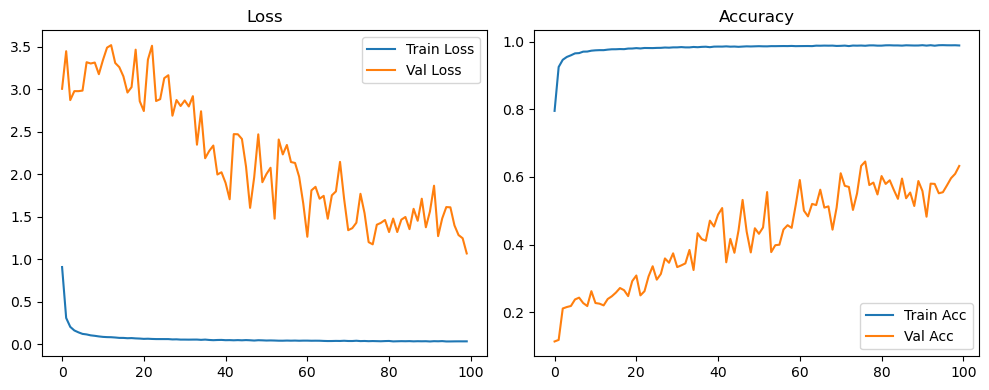

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2018, Acc: 0.9582 | Val Loss: 0.2273, Acc: 0.9305


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0494, Acc: 0.9849 | Val Loss: 0.0622, Acc: 0.9806


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9897 | Val Loss: 0.0912, Acc: 0.9713


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0257, Acc: 0.9919 | Val Loss: 0.1164, Acc: 0.9640


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9951 | Val Loss: 0.1106, Acc: 0.9676


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9955 | Val Loss: 0.0559, Acc: 0.9854


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.0566, Acc: 0.9838


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9973 | Val Loss: 0.0608, Acc: 0.9838


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.1263, Acc: 0.9653


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.0617, Acc: 0.9829


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.0601, Acc: 0.9837


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.1365, Acc: 0.9655


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.0659, Acc: 0.9841


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.0490, Acc: 0.9878


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0506, Acc: 0.9878


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9980 | Val Loss: 0.0537, Acc: 0.9868


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.0525, Acc: 0.9875


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0604, Acc: 0.9878


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9983 | Val Loss: 0.0643, Acc: 0.9852


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.0617, Acc: 0.9844


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0444, Acc: 0.9905


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0577, Acc: 0.9872


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0623, Acc: 0.9863


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0758, Acc: 0.9835


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0590, Acc: 0.9874


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0520, Acc: 0.9892


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0473, Acc: 0.9900


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0479, Acc: 0.9903


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0545, Acc: 0.9891


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.0891, Acc: 0.9809


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0567, Acc: 0.9892


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0492, Acc: 0.9907


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0556, Acc: 0.9880


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0705, Acc: 0.9872


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0686, Acc: 0.9888


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0556, Acc: 0.9890


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0550, Acc: 0.9902


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0605, Acc: 0.9896


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0636, Acc: 0.9882


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0528, Acc: 0.9912


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0621, Acc: 0.9896


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0575, Acc: 0.9906


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0677, Acc: 0.9886


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0811, Acc: 0.9867


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0604, Acc: 0.9901


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0674, Acc: 0.9888


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0627, Acc: 0.9894


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0556, Acc: 0.9908


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0547, Acc: 0.9918


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0487, Acc: 0.9928


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0464, Acc: 0.9928


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0961, Acc: 0.9839


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0653, Acc: 0.9898


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0519, Acc: 0.9912


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0555, Acc: 0.9911


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0626, Acc: 0.9892


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0633, Acc: 0.9906


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0738, Acc: 0.9869


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0609, Acc: 0.9898


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0525, Acc: 0.9902


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0540, Acc: 0.9909


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0520, Acc: 0.9913


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0547, Acc: 0.9915


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0498, Acc: 0.9908


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0584, Acc: 0.9906


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9996 | Val Loss: 0.0483, Acc: 0.9911


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0560, Acc: 0.9905


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0618, Acc: 0.9890


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0581, Acc: 0.9908


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0703, Acc: 0.9891


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0578, Acc: 0.9907


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0637, Acc: 0.9899


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0589, Acc: 0.9911


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0613, Acc: 0.9912


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0621, Acc: 0.9916


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0614, Acc: 0.9911


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0673, Acc: 0.9921


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0682, Acc: 0.9912


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0995, Acc: 0.9851


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.0558, Acc: 0.9917


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0564, Acc: 0.9918


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0577, Acc: 0.9912


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0544, Acc: 0.9918


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0880, Acc: 0.9863


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0646, Acc: 0.9897


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0723, Acc: 0.9898


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0756, Acc: 0.9894


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0597, Acc: 0.9914


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.0618, Acc: 0.9919


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0576, Acc: 0.9919


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0574, Acc: 0.9916


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0565, Acc: 0.9923


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0584, Acc: 0.9926


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0556, Acc: 0.9925


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0558, Acc: 0.9926


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0628, Acc: 0.9917


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9980 | Val Loss: 0.0788, Acc: 0.9889


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0685, Acc: 0.9902


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0660, Acc: 0.9914


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0636, Acc: 0.9913


Final Test Loss: 0.0594 Accuracy: 0.9906


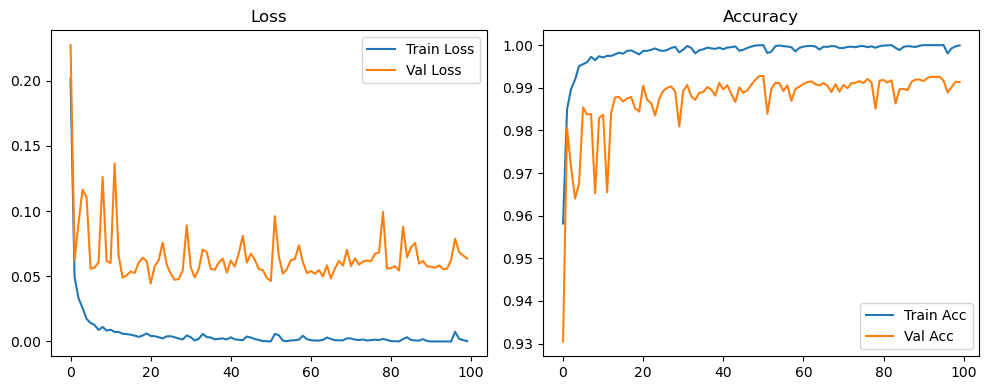

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2558, Acc: 0.9402 | Val Loss: 1.1712, Acc: 0.6471


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0738, Acc: 0.9780 | Val Loss: 0.7683, Acc: 0.7281


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0562, Acc: 0.9826 | Val Loss: 0.5929, Acc: 0.7925


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9862 | Val Loss: 0.6367, Acc: 0.7919


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0379, Acc: 0.9878 | Val Loss: 0.4846, Acc: 0.8375


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0347, Acc: 0.9890 | Val Loss: 0.6655, Acc: 0.7927


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0304, Acc: 0.9903 | Val Loss: 0.3894, Acc: 0.8739


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9910 | Val Loss: 0.3253, Acc: 0.8975


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9923 | Val Loss: 0.3732, Acc: 0.8848


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0221, Acc: 0.9932 | Val Loss: 0.2325, Acc: 0.9313


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9931 | Val Loss: 0.3381, Acc: 0.9033


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9938 | Val Loss: 0.2076, Acc: 0.9414


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9933 | Val Loss: 0.1862, Acc: 0.9418


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9943 | Val Loss: 0.2381, Acc: 0.9337


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9943 | Val Loss: 0.3637, Acc: 0.9032


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9955 | Val Loss: 0.4686, Acc: 0.8932


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9947 | Val Loss: 0.3273, Acc: 0.9147


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9960 | Val Loss: 0.2448, Acc: 0.9377


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9962 | Val Loss: 0.3013, Acc: 0.9213


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9951 | Val Loss: 0.1444, Acc: 0.9634


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.2208, Acc: 0.9449


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.2730, Acc: 0.9337


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9963 | Val Loss: 0.2445, Acc: 0.9426


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9958 | Val Loss: 0.2011, Acc: 0.9531


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9957 | Val Loss: 0.2256, Acc: 0.9474


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9966 | Val Loss: 0.2070, Acc: 0.9517


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9964 | Val Loss: 0.2921, Acc: 0.9327


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.1599, Acc: 0.9614


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.2055, Acc: 0.9518


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9970 | Val Loss: 0.1669, Acc: 0.9621


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.1463, Acc: 0.9646


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9965 | Val Loss: 0.2586, Acc: 0.9401


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9966 | Val Loss: 0.2172, Acc: 0.9523


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.1901, Acc: 0.9562


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.1511, Acc: 0.9644


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9974 | Val Loss: 0.2135, Acc: 0.9541


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.1502, Acc: 0.9663


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9978 | Val Loss: 0.1596, Acc: 0.9639


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9973 | Val Loss: 0.1995, Acc: 0.9569


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9973 | Val Loss: 0.1340, Acc: 0.9717


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.1681, Acc: 0.9614


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9977 | Val Loss: 0.1255, Acc: 0.9738


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9973 | Val Loss: 0.1312, Acc: 0.9734


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.1107, Acc: 0.9780


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.1267, Acc: 0.9745


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.1061, Acc: 0.9782


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.1099, Acc: 0.9770


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9977 | Val Loss: 0.1199, Acc: 0.9761


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.1684, Acc: 0.9678


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9978 | Val Loss: 0.1242, Acc: 0.9739


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1111, Acc: 0.9775


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.1453, Acc: 0.9732


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1035, Acc: 0.9798


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.1232, Acc: 0.9765


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.1139, Acc: 0.9782


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.0968, Acc: 0.9830


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.1652, Acc: 0.9692


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.1288, Acc: 0.9758


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.1423, Acc: 0.9752


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9979 | Val Loss: 0.1223, Acc: 0.9780


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9982 | Val Loss: 0.1338, Acc: 0.9757


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1594, Acc: 0.9722


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.1127, Acc: 0.9812


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1397, Acc: 0.9756


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9983 | Val Loss: 0.1267, Acc: 0.9775


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1358, Acc: 0.9759


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.1290, Acc: 0.9771


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1779, Acc: 0.9698


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9976 | Val Loss: 0.2023, Acc: 0.9674


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.1511, Acc: 0.9751


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9981 | Val Loss: 0.1716, Acc: 0.9722


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.2161, Acc: 0.9663


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1707, Acc: 0.9708


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.1526, Acc: 0.9735


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1219, Acc: 0.9792


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1517, Acc: 0.9756


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.1308, Acc: 0.9782


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1007, Acc: 0.9853


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.1299, Acc: 0.9786


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1487, Acc: 0.9752


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1120, Acc: 0.9818


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1107, Acc: 0.9808


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1153, Acc: 0.9804


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0926, Acc: 0.9852


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1016, Acc: 0.9844


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.1219, Acc: 0.9822


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1286, Acc: 0.9795


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9989 | Val Loss: 0.1319, Acc: 0.9786


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1077, Acc: 0.9824


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.1273, Acc: 0.9798


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9983 | Val Loss: 0.1520, Acc: 0.9758


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1488, Acc: 0.9772


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1313, Acc: 0.9808


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9981 | Val Loss: 0.1338, Acc: 0.9794


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1630, Acc: 0.9749


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.2082, Acc: 0.9674


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1691, Acc: 0.9758


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1432, Acc: 0.9784


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1952, Acc: 0.9713


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.2118, Acc: 0.9698


Final Test Loss: 0.2053 Accuracy: 0.9683


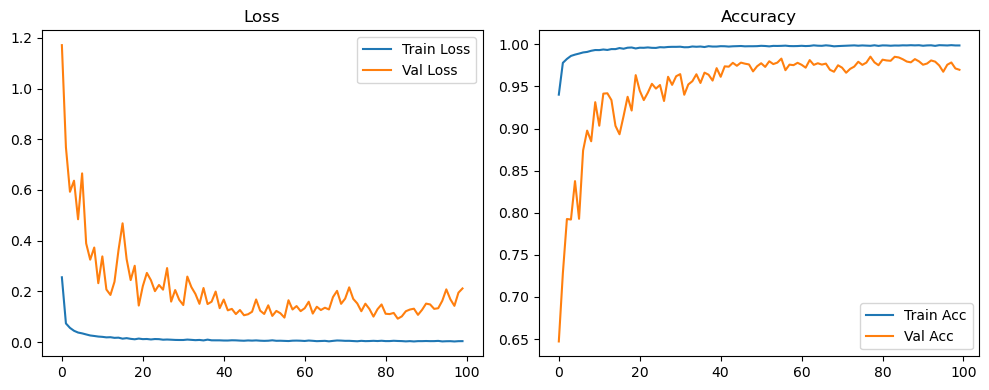

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4468, Acc: 0.8700 | Val Loss: 2.5132, Acc: 0.2079


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1481, Acc: 0.9569 | Val Loss: 3.2575, Acc: 0.2461


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1161, Acc: 0.9655 | Val Loss: 2.6287, Acc: 0.2973


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1032, Acc: 0.9698 | Val Loss: 2.8081, Acc: 0.2483


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0896, Acc: 0.9730 | Val Loss: 2.4320, Acc: 0.3404


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0833, Acc: 0.9745 | Val Loss: 1.9971, Acc: 0.4104


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0803, Acc: 0.9760 | Val Loss: 2.4095, Acc: 0.3757


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0773, Acc: 0.9764 | Val Loss: 1.3414, Acc: 0.5425


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0711, Acc: 0.9783 | Val Loss: 1.5786, Acc: 0.4645


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0698, Acc: 0.9791 | Val Loss: 1.3091, Acc: 0.5725


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0657, Acc: 0.9804 | Val Loss: 1.2865, Acc: 0.5935


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0646, Acc: 0.9804 | Val Loss: 1.3005, Acc: 0.5814


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0626, Acc: 0.9803 | Val Loss: 1.1046, Acc: 0.6329


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0601, Acc: 0.9807 | Val Loss: 0.8562, Acc: 0.7058


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0551, Acc: 0.9824 | Val Loss: 0.7806, Acc: 0.7390


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0580, Acc: 0.9822 | Val Loss: 0.7680, Acc: 0.7402


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0562, Acc: 0.9830 | Val Loss: 1.2233, Acc: 0.6448


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0534, Acc: 0.9840 | Val Loss: 1.5734, Acc: 0.5521


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0495, Acc: 0.9838 | Val Loss: 1.0943, Acc: 0.6517


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0502, Acc: 0.9835 | Val Loss: 0.6905, Acc: 0.7666


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0506, Acc: 0.9844 | Val Loss: 0.8178, Acc: 0.7492


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0516, Acc: 0.9838 | Val Loss: 0.8544, Acc: 0.7123


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0486, Acc: 0.9850 | Val Loss: 0.9866, Acc: 0.6747


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0463, Acc: 0.9854 | Val Loss: 0.7827, Acc: 0.7295


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0467, Acc: 0.9851 | Val Loss: 0.6954, Acc: 0.7473


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0488, Acc: 0.9840 | Val Loss: 0.6558, Acc: 0.7590


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0449, Acc: 0.9850 | Val Loss: 0.6641, Acc: 0.7666


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0418, Acc: 0.9867 | Val Loss: 0.7201, Acc: 0.7632


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0439, Acc: 0.9864 | Val Loss: 1.0496, Acc: 0.6721


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9865 | Val Loss: 0.9093, Acc: 0.7002


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0411, Acc: 0.9861 | Val Loss: 0.8614, Acc: 0.7083


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9863 | Val Loss: 0.6960, Acc: 0.7438


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0417, Acc: 0.9872 | Val Loss: 0.7631, Acc: 0.7385


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0404, Acc: 0.9871 | Val Loss: 0.8643, Acc: 0.6979


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0392, Acc: 0.9869 | Val Loss: 1.0798, Acc: 0.6560


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0378, Acc: 0.9870 | Val Loss: 0.9045, Acc: 0.7103


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0395, Acc: 0.9875 | Val Loss: 0.8254, Acc: 0.7222


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0387, Acc: 0.9878 | Val Loss: 0.7664, Acc: 0.7488


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0382, Acc: 0.9875 | Val Loss: 0.6213, Acc: 0.7802


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0386, Acc: 0.9878 | Val Loss: 0.6485, Acc: 0.7718


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9878 | Val Loss: 1.0429, Acc: 0.6893


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0355, Acc: 0.9883 | Val Loss: 0.6687, Acc: 0.7733


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9871 | Val Loss: 0.6999, Acc: 0.7522


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0352, Acc: 0.9886 | Val Loss: 0.6974, Acc: 0.7517


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0359, Acc: 0.9889 | Val Loss: 0.8127, Acc: 0.7089


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0351, Acc: 0.9882 | Val Loss: 0.5995, Acc: 0.7669


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0361, Acc: 0.9881 | Val Loss: 0.7405, Acc: 0.7352


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0345, Acc: 0.9895 | Val Loss: 0.5394, Acc: 0.7857


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0351, Acc: 0.9879 | Val Loss: 0.7421, Acc: 0.7287


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0325, Acc: 0.9892 | Val Loss: 0.6435, Acc: 0.7482


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0296, Acc: 0.9903 | Val Loss: 0.4902, Acc: 0.8102


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0324, Acc: 0.9896 | Val Loss: 0.5044, Acc: 0.7894


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0317, Acc: 0.9894 | Val Loss: 0.6445, Acc: 0.7652


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0344, Acc: 0.9891 | Val Loss: 0.5898, Acc: 0.7652


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9902 | Val Loss: 0.7536, Acc: 0.7105


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9890 | Val Loss: 0.6108, Acc: 0.7544


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9896 | Val Loss: 0.6184, Acc: 0.7563


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9899 | Val Loss: 0.6357, Acc: 0.7472


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0294, Acc: 0.9909 | Val Loss: 0.5288, Acc: 0.7919


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0317, Acc: 0.9896 | Val Loss: 0.4577, Acc: 0.8168


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9893 | Val Loss: 0.3779, Acc: 0.8463


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0325, Acc: 0.9896 | Val Loss: 0.6772, Acc: 0.7147


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9895 | Val Loss: 0.4354, Acc: 0.8184


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0303, Acc: 0.9899 | Val Loss: 0.5570, Acc: 0.7630


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9895 | Val Loss: 0.6373, Acc: 0.7272


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9907 | Val Loss: 0.5428, Acc: 0.7678


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0313, Acc: 0.9895 | Val Loss: 0.5660, Acc: 0.7652


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9903 | Val Loss: 0.6154, Acc: 0.7502


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9899 | Val Loss: 0.6877, Acc: 0.7092


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9905 | Val Loss: 0.6219, Acc: 0.7419


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9904 | Val Loss: 0.6013, Acc: 0.7323


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9901 | Val Loss: 0.6235, Acc: 0.7222


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0300, Acc: 0.9899 | Val Loss: 0.5433, Acc: 0.7685


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0291, Acc: 0.9905 | Val Loss: 0.5961, Acc: 0.7436


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0293, Acc: 0.9899 | Val Loss: 0.5706, Acc: 0.7631


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9910 | Val Loss: 0.4666, Acc: 0.8056


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0278, Acc: 0.9906 | Val Loss: 0.5453, Acc: 0.7698


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9918 | Val Loss: 0.5335, Acc: 0.7805


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9906 | Val Loss: 0.3883, Acc: 0.8313


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0284, Acc: 0.9907 | Val Loss: 0.4399, Acc: 0.8068


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9907 | Val Loss: 0.4941, Acc: 0.7777


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0266, Acc: 0.9906 | Val Loss: 0.5173, Acc: 0.7774


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9909 | Val Loss: 0.4204, Acc: 0.8205


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0275, Acc: 0.9913 | Val Loss: 0.5059, Acc: 0.7818


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9908 | Val Loss: 0.5925, Acc: 0.7580


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9898 | Val Loss: 0.5777, Acc: 0.7632


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0247, Acc: 0.9916 | Val Loss: 0.5549, Acc: 0.7632


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0255, Acc: 0.9911 | Val Loss: 0.5135, Acc: 0.7840


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0262, Acc: 0.9915 | Val Loss: 0.5378, Acc: 0.7638


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9904 | Val Loss: 0.5108, Acc: 0.7877


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0247, Acc: 0.9920 | Val Loss: 0.4959, Acc: 0.7738


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9916 | Val Loss: 0.6025, Acc: 0.7334


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0262, Acc: 0.9913 | Val Loss: 0.5461, Acc: 0.7496


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0254, Acc: 0.9916 | Val Loss: 0.5318, Acc: 0.7651


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0272, Acc: 0.9912 | Val Loss: 0.5769, Acc: 0.7236


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0253, Acc: 0.9916 | Val Loss: 0.5831, Acc: 0.7362


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9911 | Val Loss: 0.4965, Acc: 0.7834


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9916 | Val Loss: 0.5300, Acc: 0.7608


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0250, Acc: 0.9915 | Val Loss: 0.5693, Acc: 0.7647


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9917 | Val Loss: 0.4969, Acc: 0.7740


Final Test Loss: 0.4725 Accuracy: 0.7874


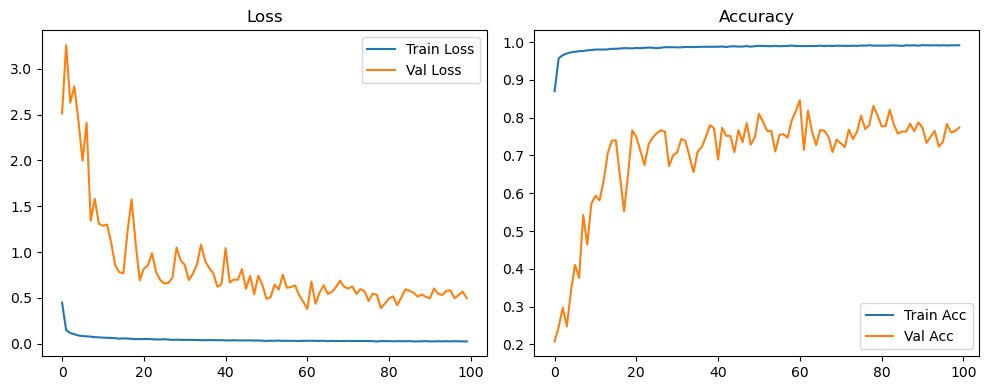

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2021, Acc: 0.9582 | Val Loss: 0.1923, Acc: 0.9413


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0493, Acc: 0.9849 | Val Loss: 0.0846, Acc: 0.9736


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9899 | Val Loss: 0.0527, Acc: 0.9840


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0250, Acc: 0.9920 | Val Loss: 0.1090, Acc: 0.9665


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9944 | Val Loss: 0.0530, Acc: 0.9835


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9961 | Val Loss: 0.1678, Acc: 0.9503


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9956 | Val Loss: 0.0513, Acc: 0.9862


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9967 | Val Loss: 0.0524, Acc: 0.9850


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9973 | Val Loss: 0.1039, Acc: 0.9725


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.0524, Acc: 0.9863


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9964 | Val Loss: 0.0707, Acc: 0.9809


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.2223, Acc: 0.9457


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0405, Acc: 0.9896


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0466, Acc: 0.9885


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9976 | Val Loss: 0.1080, Acc: 0.9738


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9973 | Val Loss: 0.0764, Acc: 0.9827


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.0443, Acc: 0.9901


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0571, Acc: 0.9867


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0412, Acc: 0.9905


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0619, Acc: 0.9862


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9981 | Val Loss: 0.0534, Acc: 0.9875


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.0461, Acc: 0.9910


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0687, Acc: 0.9874


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9982 | Val Loss: 0.0627, Acc: 0.9862


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.0625, Acc: 0.9872


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0531, Acc: 0.9892


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0401, Acc: 0.9923


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0525, Acc: 0.9896


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0619, Acc: 0.9870


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.0551, Acc: 0.9892


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0603, Acc: 0.9895


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0756, Acc: 0.9847


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0489, Acc: 0.9905


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0869, Acc: 0.9849


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0745, Acc: 0.9851


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0452, Acc: 0.9922


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0482, Acc: 0.9912


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0457, Acc: 0.9900


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0519, Acc: 0.9893


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0560, Acc: 0.9906


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0429, Acc: 0.9923


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0518, Acc: 0.9913


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9994 | Val Loss: 0.0681, Acc: 0.9873


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0608, Acc: 0.9901


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0704, Acc: 0.9876


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0606, Acc: 0.9892


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0586, Acc: 0.9905


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0535, Acc: 0.9907


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0499, Acc: 0.9923


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0504, Acc: 0.9921


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0586, Acc: 0.9907


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0499, Acc: 0.9921


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0492, Acc: 0.9925


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0490, Acc: 0.9922


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0484, Acc: 0.9925


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0489, Acc: 0.9925


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0483, Acc: 0.9932


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0473, Acc: 0.9929


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0506, Acc: 0.9922


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0478, Acc: 0.9926


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0470, Acc: 0.9926


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0471, Acc: 0.9926


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0464, Acc: 0.9929


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0470, Acc: 0.9929


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0466, Acc: 0.9926


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0470, Acc: 0.9929


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0473, Acc: 0.9932


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0827, Acc: 0.9868


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0550, Acc: 0.9906


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0545, Acc: 0.9918


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0561, Acc: 0.9917


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0518, Acc: 0.9927


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0503, Acc: 0.9926


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0600, Acc: 0.9923


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0526, Acc: 0.9928


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0542, Acc: 0.9925


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0586, Acc: 0.9918


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0560, Acc: 0.9917


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0696, Acc: 0.9891


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0572, Acc: 0.9912


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0553, Acc: 0.9927


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0534, Acc: 0.9923


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0515, Acc: 0.9928


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0517, Acc: 0.9927


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0516, Acc: 0.9924


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0521, Acc: 0.9924


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0520, Acc: 0.9926


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0520, Acc: 0.9928


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0519, Acc: 0.9928


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0518, Acc: 0.9926


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0509, Acc: 0.9928


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0517, Acc: 0.9930


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0528, Acc: 0.9929


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0521, Acc: 0.9928


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0523, Acc: 0.9928


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0581, Acc: 0.9921


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0547, Acc: 0.9928


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0527, Acc: 0.9928


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0505, Acc: 0.9929


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0530, Acc: 0.9928


Final Test Loss: 0.0549 Accuracy: 0.9905


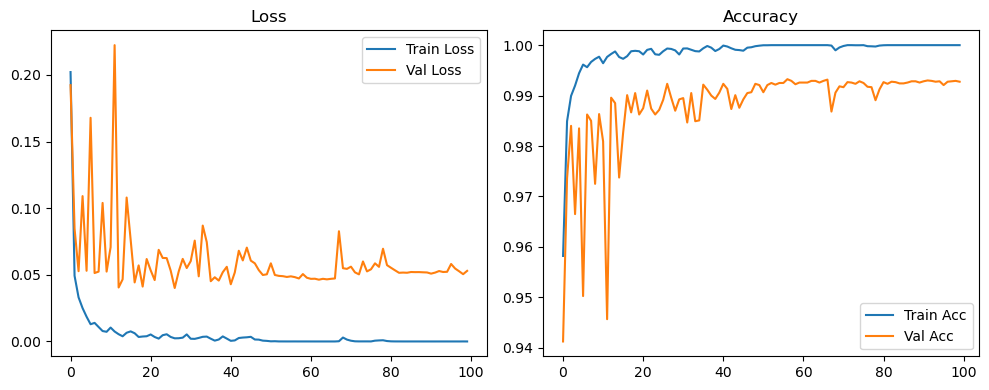

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2557, Acc: 0.9405 | Val Loss: 0.9522, Acc: 0.6945


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0737, Acc: 0.9783 | Val Loss: 0.6371, Acc: 0.7669


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0560, Acc: 0.9826 | Val Loss: 0.6011, Acc: 0.7918


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0443, Acc: 0.9863 | Val Loss: 0.9154, Acc: 0.7462


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0384, Acc: 0.9880 | Val Loss: 0.5650, Acc: 0.8168


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0348, Acc: 0.9887 | Val Loss: 0.6995, Acc: 0.7902


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0294, Acc: 0.9910 | Val Loss: 0.4636, Acc: 0.8501


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0262, Acc: 0.9912 | Val Loss: 0.3791, Acc: 0.8839


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9924 | Val Loss: 0.6911, Acc: 0.7871


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9935 | Val Loss: 0.2155, Acc: 0.9354


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9931 | Val Loss: 0.3020, Acc: 0.9116


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9939 | Val Loss: 0.1655, Acc: 0.9538


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9939 | Val Loss: 0.2722, Acc: 0.9204


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9941 | Val Loss: 0.3250, Acc: 0.9080


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9948 | Val Loss: 0.2354, Acc: 0.9373


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9948 | Val Loss: 0.5296, Acc: 0.8677


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9944 | Val Loss: 0.1745, Acc: 0.9546


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9952 | Val Loss: 0.3427, Acc: 0.9150


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9958 | Val Loss: 0.3316, Acc: 0.9172


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9969 | Val Loss: 0.1814, Acc: 0.9551


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9951 | Val Loss: 0.2313, Acc: 0.9434


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9959 | Val Loss: 0.2552, Acc: 0.9402


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9957 | Val Loss: 0.3240, Acc: 0.9194


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9958 | Val Loss: 0.1967, Acc: 0.9505


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.2016, Acc: 0.9508


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9962 | Val Loss: 0.1934, Acc: 0.9529


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.1490, Acc: 0.9648


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9966 | Val Loss: 0.2484, Acc: 0.9438


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.2012, Acc: 0.9539


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 0.2362, Acc: 0.9441


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.3481, Acc: 0.9274


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.3111, Acc: 0.9297


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.1751, Acc: 0.9614


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.1859, Acc: 0.9596


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.2575, Acc: 0.9478


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.1694, Acc: 0.9635


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.1534, Acc: 0.9652


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.2348, Acc: 0.9532


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9971 | Val Loss: 0.2212, Acc: 0.9553


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9973 | Val Loss: 0.1358, Acc: 0.9721


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1433, Acc: 0.9704


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9977 | Val Loss: 0.1579, Acc: 0.9695


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.1766, Acc: 0.9653


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1439, Acc: 0.9712


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.2206, Acc: 0.9555


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1402, Acc: 0.9731


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.1418, Acc: 0.9709


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.2023, Acc: 0.9628


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.2337, Acc: 0.9567


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.2026, Acc: 0.9633


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1372, Acc: 0.9734


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1771, Acc: 0.9670


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1671, Acc: 0.9687


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1478, Acc: 0.9722


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1465, Acc: 0.9717


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1302, Acc: 0.9758


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1284, Acc: 0.9761


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1379, Acc: 0.9742


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1131, Acc: 0.9800


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1251, Acc: 0.9774


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1325, Acc: 0.9768


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.2193, Acc: 0.9617


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1744, Acc: 0.9718


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1867, Acc: 0.9680


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.1708, Acc: 0.9692


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1725, Acc: 0.9716


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1923, Acc: 0.9657


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1951, Acc: 0.9683


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9987 | Val Loss: 0.1797, Acc: 0.9696


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1713, Acc: 0.9706


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1775, Acc: 0.9700


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1881, Acc: 0.9692


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1932, Acc: 0.9693


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.1602, Acc: 0.9720


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1447, Acc: 0.9748


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1330, Acc: 0.9776


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1201, Acc: 0.9803


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.1123, Acc: 0.9812


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1653, Acc: 0.9722


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1458, Acc: 0.9762


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.1223, Acc: 0.9802


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1497, Acc: 0.9756


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1227, Acc: 0.9803


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1425, Acc: 0.9768


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1134, Acc: 0.9815


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1209, Acc: 0.9812


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1190, Acc: 0.9810


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1368, Acc: 0.9782


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1415, Acc: 0.9772


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1347, Acc: 0.9780


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1379, Acc: 0.9776


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1486, Acc: 0.9751


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1247, Acc: 0.9787


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9994 | Val Loss: 0.1598, Acc: 0.9734


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1248, Acc: 0.9794


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1554, Acc: 0.9750


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1294, Acc: 0.9798


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1221, Acc: 0.9815


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1447, Acc: 0.9772


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1302, Acc: 0.9791


Final Test Loss: 0.1352 Accuracy: 0.9764


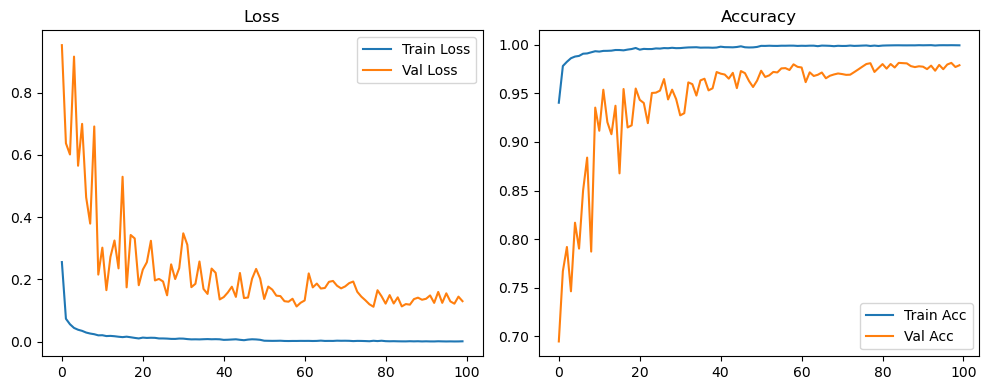

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4470, Acc: 0.8697 | Val Loss: 2.1768, Acc: 0.2805


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1487, Acc: 0.9568 | Val Loss: 2.8370, Acc: 0.2843


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1168, Acc: 0.9654 | Val Loss: 2.3517, Acc: 0.3242


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1033, Acc: 0.9697 | Val Loss: 2.6594, Acc: 0.2742


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0883, Acc: 0.9730 | Val Loss: 2.2371, Acc: 0.3699


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0831, Acc: 0.9744 | Val Loss: 1.8352, Acc: 0.4605


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0808, Acc: 0.9760 | Val Loss: 2.5228, Acc: 0.3521


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0768, Acc: 0.9769 | Val Loss: 1.6413, Acc: 0.4947


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0712, Acc: 0.9783 | Val Loss: 2.1797, Acc: 0.3688


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0685, Acc: 0.9784 | Val Loss: 1.6497, Acc: 0.4946


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0651, Acc: 0.9805 | Val Loss: 1.3436, Acc: 0.5673


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0650, Acc: 0.9796 | Val Loss: 1.3249, Acc: 0.5823


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0620, Acc: 0.9810 | Val Loss: 1.1838, Acc: 0.6261


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0628, Acc: 0.9804 | Val Loss: 0.7198, Acc: 0.7438


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0537, Acc: 0.9834 | Val Loss: 0.8760, Acc: 0.7090


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0584, Acc: 0.9823 | Val Loss: 0.7622, Acc: 0.7321


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0550, Acc: 0.9835 | Val Loss: 1.3607, Acc: 0.6073


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0543, Acc: 0.9835 | Val Loss: 1.5002, Acc: 0.5703


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0502, Acc: 0.9836 | Val Loss: 1.2386, Acc: 0.6013


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0485, Acc: 0.9838 | Val Loss: 0.6992, Acc: 0.7655


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0474, Acc: 0.9853 | Val Loss: 0.7127, Acc: 0.7816


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0510, Acc: 0.9840 | Val Loss: 0.7490, Acc: 0.7482


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0488, Acc: 0.9844 | Val Loss: 0.8188, Acc: 0.7203


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0469, Acc: 0.9855 | Val Loss: 0.5903, Acc: 0.7829


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0467, Acc: 0.9848 | Val Loss: 0.5798, Acc: 0.7853


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0491, Acc: 0.9847 | Val Loss: 0.5211, Acc: 0.7981


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0432, Acc: 0.9854 | Val Loss: 0.6715, Acc: 0.7732


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0422, Acc: 0.9866 | Val Loss: 0.6218, Acc: 0.7826


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0432, Acc: 0.9864 | Val Loss: 0.9120, Acc: 0.6966


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0417, Acc: 0.9869 | Val Loss: 0.5557, Acc: 0.7973


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0409, Acc: 0.9869 | Val Loss: 0.9344, Acc: 0.6899


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0426, Acc: 0.9857 | Val Loss: 0.6391, Acc: 0.7666


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0417, Acc: 0.9865 | Val Loss: 0.6964, Acc: 0.7456


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9875 | Val Loss: 0.6203, Acc: 0.7678


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0409, Acc: 0.9866 | Val Loss: 0.5617, Acc: 0.7878


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0386, Acc: 0.9873 | Val Loss: 0.6842, Acc: 0.7526


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0393, Acc: 0.9877 | Val Loss: 0.5755, Acc: 0.7849


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9873 | Val Loss: 0.5742, Acc: 0.7911


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9879 | Val Loss: 0.5003, Acc: 0.8090


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9876 | Val Loss: 0.5064, Acc: 0.8057


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0361, Acc: 0.9877 | Val Loss: 0.6319, Acc: 0.7652


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0351, Acc: 0.9882 | Val Loss: 0.7000, Acc: 0.7462


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0401, Acc: 0.9866 | Val Loss: 0.5765, Acc: 0.7776


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0345, Acc: 0.9887 | Val Loss: 0.4529, Acc: 0.8153


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0350, Acc: 0.9887 | Val Loss: 0.5416, Acc: 0.7851


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0336, Acc: 0.9889 | Val Loss: 0.4385, Acc: 0.8203


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0328, Acc: 0.9890 | Val Loss: 0.5459, Acc: 0.7915


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0343, Acc: 0.9891 | Val Loss: 0.5156, Acc: 0.7998


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9881 | Val Loss: 0.6220, Acc: 0.7600


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0334, Acc: 0.9893 | Val Loss: 0.5958, Acc: 0.7678


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9911 | Val Loss: 0.4278, Acc: 0.8327


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9913 | Val Loss: 0.4305, Acc: 0.8261


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0264, Acc: 0.9914 | Val Loss: 0.4963, Acc: 0.8092


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9913 | Val Loss: 0.4732, Acc: 0.8047


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0253, Acc: 0.9918 | Val Loss: 0.6112, Acc: 0.7733


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0249, Acc: 0.9919 | Val Loss: 0.4393, Acc: 0.8204


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9915 | Val Loss: 0.4976, Acc: 0.8013


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0244, Acc: 0.9919 | Val Loss: 0.5517, Acc: 0.7827


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0253, Acc: 0.9916 | Val Loss: 0.3884, Acc: 0.8431


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0242, Acc: 0.9922 | Val Loss: 0.4188, Acc: 0.8281


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0253, Acc: 0.9912 | Val Loss: 0.3547, Acc: 0.8548


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0242, Acc: 0.9921 | Val Loss: 0.5655, Acc: 0.7652


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0242, Acc: 0.9922 | Val Loss: 0.3648, Acc: 0.8464


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0249, Acc: 0.9917 | Val Loss: 0.4324, Acc: 0.8169


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9909 | Val Loss: 0.3949, Acc: 0.8368


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0246, Acc: 0.9924 | Val Loss: 0.4286, Acc: 0.8157


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0241, Acc: 0.9918 | Val Loss: 0.4400, Acc: 0.8207


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0233, Acc: 0.9922 | Val Loss: 0.4992, Acc: 0.7913


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0238, Acc: 0.9921 | Val Loss: 0.4978, Acc: 0.7956


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0226, Acc: 0.9919 | Val Loss: 0.4014, Acc: 0.8298


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0241, Acc: 0.9924 | Val Loss: 0.4113, Acc: 0.8233


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0235, Acc: 0.9922 | Val Loss: 0.4038, Acc: 0.8176


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0222, Acc: 0.9925 | Val Loss: 0.4033, Acc: 0.8235


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0224, Acc: 0.9926 | Val Loss: 0.4330, Acc: 0.8122


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0237, Acc: 0.9922 | Val Loss: 0.3814, Acc: 0.8402


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0227, Acc: 0.9922 | Val Loss: 0.3978, Acc: 0.8333


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0212, Acc: 0.9928 | Val Loss: 0.4363, Acc: 0.8146


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0205, Acc: 0.9929 | Val Loss: 0.3767, Acc: 0.8373


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0236, Acc: 0.9923 | Val Loss: 0.3509, Acc: 0.8482


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0229, Acc: 0.9925 | Val Loss: 0.3914, Acc: 0.8270


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0207, Acc: 0.9934 | Val Loss: 0.3845, Acc: 0.8293


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0198, Acc: 0.9934 | Val Loss: 0.3647, Acc: 0.8416


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0183, Acc: 0.9932 | Val Loss: 0.3354, Acc: 0.8511


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0197, Acc: 0.9931 | Val Loss: 0.4020, Acc: 0.8264


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0181, Acc: 0.9939 | Val Loss: 0.3640, Acc: 0.8446


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0199, Acc: 0.9935 | Val Loss: 0.3976, Acc: 0.8347


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0183, Acc: 0.9941 | Val Loss: 0.3635, Acc: 0.8481


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0172, Acc: 0.9943 | Val Loss: 0.4028, Acc: 0.8301


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0175, Acc: 0.9940 | Val Loss: 0.3583, Acc: 0.8485


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0191, Acc: 0.9935 | Val Loss: 0.3528, Acc: 0.8499


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0170, Acc: 0.9947 | Val Loss: 0.3574, Acc: 0.8442


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0172, Acc: 0.9946 | Val Loss: 0.3924, Acc: 0.8297


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0175, Acc: 0.9942 | Val Loss: 0.3434, Acc: 0.8484


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0174, Acc: 0.9939 | Val Loss: 0.3527, Acc: 0.8459


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0179, Acc: 0.9943 | Val Loss: 0.3355, Acc: 0.8588


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0181, Acc: 0.9940 | Val Loss: 0.4138, Acc: 0.8232


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0182, Acc: 0.9937 | Val Loss: 0.3850, Acc: 0.8329


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0171, Acc: 0.9943 | Val Loss: 0.3757, Acc: 0.8338


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0168, Acc: 0.9943 | Val Loss: 0.3700, Acc: 0.8400


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0158, Acc: 0.9950 | Val Loss: 0.3217, Acc: 0.8601


Final Test Loss: 0.3112 Accuracy: 0.8667


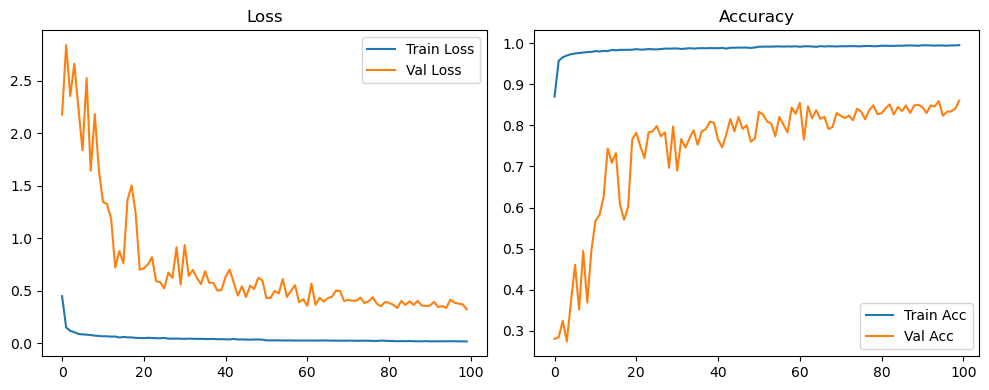

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2021, Acc: 0.9580 | Val Loss: 0.2309, Acc: 0.9281


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0490, Acc: 0.9853 | Val Loss: 0.0567, Acc: 0.9826


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0332, Acc: 0.9899 | Val Loss: 0.0632, Acc: 0.9807


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0251, Acc: 0.9920 | Val Loss: 0.1274, Acc: 0.9592


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9944 | Val Loss: 0.0722, Acc: 0.9772


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9956 | Val Loss: 0.1072, Acc: 0.9686


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.0446, Acc: 0.9872


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9972 | Val Loss: 0.0656, Acc: 0.9817


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.1849, Acc: 0.9539


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.0586, Acc: 0.9851


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9967 | Val Loss: 0.0584, Acc: 0.9822


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.1123, Acc: 0.9708


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0594, Acc: 0.9854


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.0718, Acc: 0.9829


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.1599, Acc: 0.9592


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0603, Acc: 0.9866


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.0642, Acc: 0.9860


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0651, Acc: 0.9844


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.0534, Acc: 0.9867


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.0643, Acc: 0.9849


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9985 | Val Loss: 0.0530, Acc: 0.9887


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0481, Acc: 0.9883


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.0439, Acc: 0.9906


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.0645, Acc: 0.9860


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.0606, Acc: 0.9865


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.0545, Acc: 0.9888


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0400, Acc: 0.9924


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0379, Acc: 0.9924


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0367, Acc: 0.9927


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0760, Acc: 0.9851


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.0771, Acc: 0.9847


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0652, Acc: 0.9855


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0492, Acc: 0.9890


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0705, Acc: 0.9867


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1045, Acc: 0.9800


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0472, Acc: 0.9917


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0516, Acc: 0.9901


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0587, Acc: 0.9894


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0524, Acc: 0.9911


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0522, Acc: 0.9895


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0573, Acc: 0.9889


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0517, Acc: 0.9907


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0495, Acc: 0.9917


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0560, Acc: 0.9909


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0733, Acc: 0.9879


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0732, Acc: 0.9861


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0556, Acc: 0.9910


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0556, Acc: 0.9902


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0545, Acc: 0.9913


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0632, Acc: 0.9889


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0486, Acc: 0.9919


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0488, Acc: 0.9922


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0455, Acc: 0.9927


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0447, Acc: 0.9926


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0465, Acc: 0.9927


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0460, Acc: 0.9928


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0454, Acc: 0.9926


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0443, Acc: 0.9930


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0451, Acc: 0.9930


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0446, Acc: 0.9931


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0475, Acc: 0.9925


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0442, Acc: 0.9935


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0444, Acc: 0.9934


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0454, Acc: 0.9930


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0866, Acc: 0.9858


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0552, Acc: 0.9913


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0539, Acc: 0.9917


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0502, Acc: 0.9919


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0611, Acc: 0.9907


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0573, Acc: 0.9915


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0525, Acc: 0.9924


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0530, Acc: 0.9919


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0546, Acc: 0.9915


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0565, Acc: 0.9922


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0554, Acc: 0.9927


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0539, Acc: 0.9928


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0529, Acc: 0.9926


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0519, Acc: 0.9927


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0532, Acc: 0.9928


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0534, Acc: 0.9926


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0527, Acc: 0.9928


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0517, Acc: 0.9929


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0523, Acc: 0.9928


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0511, Acc: 0.9931


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0510, Acc: 0.9931


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0517, Acc: 0.9932


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0514, Acc: 0.9928


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0517, Acc: 0.9932


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0525, Acc: 0.9927


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0517, Acc: 0.9923


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0511, Acc: 0.9928


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0512, Acc: 0.9932


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0513, Acc: 0.9930


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0514, Acc: 0.9932


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0500, Acc: 0.9929


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0501, Acc: 0.9929


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0512, Acc: 0.9930


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0504, Acc: 0.9932


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0493, Acc: 0.9932


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0498, Acc: 0.9934


Final Test Loss: 0.0494 Accuracy: 0.9920


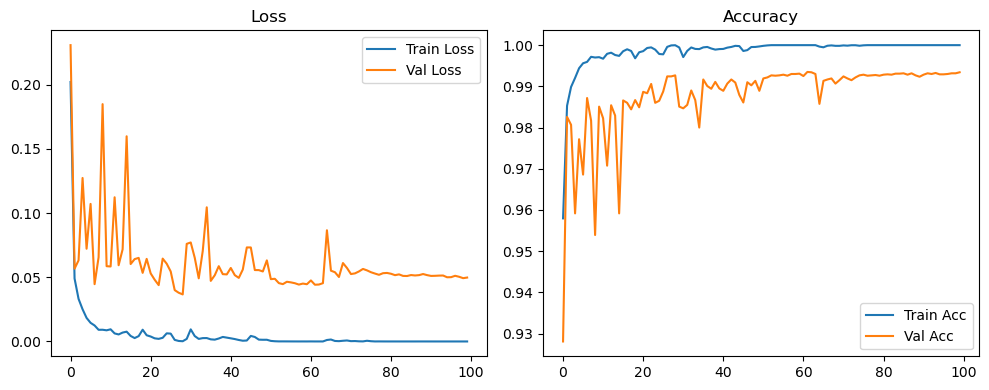

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2560, Acc: 0.9402 | Val Loss: 1.0942, Acc: 0.6589


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0738, Acc: 0.9783 | Val Loss: 0.7500, Acc: 0.7382


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0563, Acc: 0.9823 | Val Loss: 0.5658, Acc: 0.7963


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0444, Acc: 0.9865 | Val Loss: 0.8758, Acc: 0.7432


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9880 | Val Loss: 0.4338, Acc: 0.8534


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0344, Acc: 0.9887 | Val Loss: 0.6062, Acc: 0.8012


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0300, Acc: 0.9906 | Val Loss: 0.3748, Acc: 0.8757


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9906 | Val Loss: 0.2676, Acc: 0.9134


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0236, Acc: 0.9923 | Val Loss: 0.5271, Acc: 0.8393


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9927 | Val Loss: 0.3965, Acc: 0.8774


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9933 | Val Loss: 0.3400, Acc: 0.9008


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9934 | Val Loss: 0.2033, Acc: 0.9424


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9935 | Val Loss: 0.2940, Acc: 0.9163


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9945 | Val Loss: 0.2552, Acc: 0.9257


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9946 | Val Loss: 0.2258, Acc: 0.9358


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9944 | Val Loss: 0.1899, Acc: 0.9507


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9948 | Val Loss: 0.1793, Acc: 0.9503


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9955 | Val Loss: 0.2960, Acc: 0.9217


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9956 | Val Loss: 0.2314, Acc: 0.9403


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9954 | Val Loss: 0.1818, Acc: 0.9525


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9954 | Val Loss: 0.1522, Acc: 0.9599


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9963 | Val Loss: 0.1679, Acc: 0.9565


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.1861, Acc: 0.9526


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.1656, Acc: 0.9584


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9960 | Val Loss: 0.1840, Acc: 0.9546


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9967 | Val Loss: 0.2057, Acc: 0.9494


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 0.1756, Acc: 0.9576


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.1686, Acc: 0.9606


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9970 | Val Loss: 0.2142, Acc: 0.9498


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9965 | Val Loss: 0.1224, Acc: 0.9717


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9968 | Val Loss: 0.1517, Acc: 0.9649


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.2281, Acc: 0.9509


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.1493, Acc: 0.9659


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9974 | Val Loss: 0.1823, Acc: 0.9587


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.2081, Acc: 0.9541


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9973 | Val Loss: 0.1560, Acc: 0.9648


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9969 | Val Loss: 0.1095, Acc: 0.9758


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9973 | Val Loss: 0.1275, Acc: 0.9724


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.1660, Acc: 0.9627


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.1377, Acc: 0.9692


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9975 | Val Loss: 0.1536, Acc: 0.9668


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.1524, Acc: 0.9689


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.2252, Acc: 0.9527


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1388, Acc: 0.9706


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1598, Acc: 0.9671


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9975 | Val Loss: 0.1796, Acc: 0.9642


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.2444, Acc: 0.9523


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.1498, Acc: 0.9707


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9973 | Val Loss: 0.1870, Acc: 0.9628


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.1700, Acc: 0.9651


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1299, Acc: 0.9723


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1314, Acc: 0.9724


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1411, Acc: 0.9708


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1384, Acc: 0.9735


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1327, Acc: 0.9737


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1205, Acc: 0.9757


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1309, Acc: 0.9739


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1596, Acc: 0.9706


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9990 | Val Loss: 0.1330, Acc: 0.9752


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1395, Acc: 0.9732


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1078, Acc: 0.9788


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1881, Acc: 0.9659


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1433, Acc: 0.9736


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1380, Acc: 0.9738


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1506, Acc: 0.9729


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1317, Acc: 0.9754


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1670, Acc: 0.9696


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1630, Acc: 0.9702


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9989 | Val Loss: 0.1882, Acc: 0.9643


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.1738, Acc: 0.9688


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1270, Acc: 0.9760


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1530, Acc: 0.9725


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1270, Acc: 0.9759


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1553, Acc: 0.9720


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1570, Acc: 0.9705


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1344, Acc: 0.9762


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1366, Acc: 0.9746


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0851, Acc: 0.9837


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1229, Acc: 0.9777


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1482, Acc: 0.9729


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9992 | Val Loss: 0.1208, Acc: 0.9780


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1341, Acc: 0.9762


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1135, Acc: 0.9793


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1252, Acc: 0.9768


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1099, Acc: 0.9804


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1137, Acc: 0.9796


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1199, Acc: 0.9780


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1273, Acc: 0.9765


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1237, Acc: 0.9769


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1233, Acc: 0.9776


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1206, Acc: 0.9786


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1283, Acc: 0.9774


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1166, Acc: 0.9793


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1241, Acc: 0.9773


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1262, Acc: 0.9776


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1345, Acc: 0.9765


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1204, Acc: 0.9786


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1249, Acc: 0.9780


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1231, Acc: 0.9787


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1151, Acc: 0.9794


Final Test Loss: 0.1308 Accuracy: 0.9783


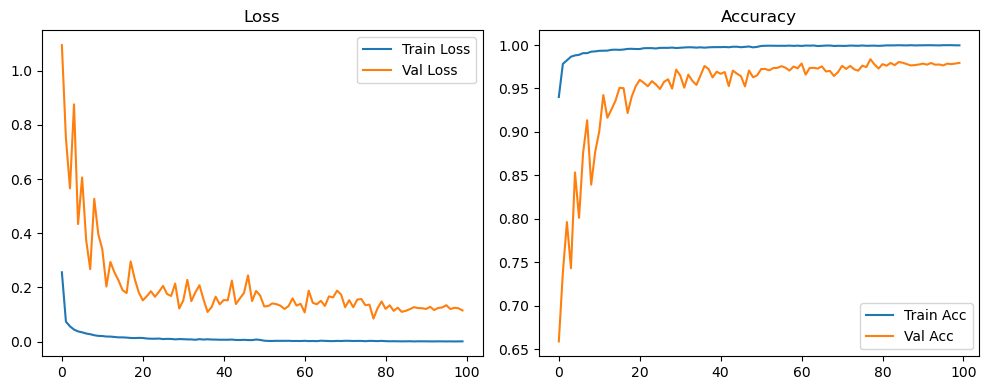

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4468, Acc: 0.8699 | Val Loss: 2.3717, Acc: 0.2343


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1482, Acc: 0.9570 | Val Loss: 2.9971, Acc: 0.2602


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1163, Acc: 0.9655 | Val Loss: 2.5285, Acc: 0.3143


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1033, Acc: 0.9695 | Val Loss: 2.7350, Acc: 0.2677


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0892, Acc: 0.9731 | Val Loss: 2.2191, Acc: 0.3698


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0836, Acc: 0.9736 | Val Loss: 1.5463, Acc: 0.5295


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0812, Acc: 0.9755 | Val Loss: 2.0424, Acc: 0.4270


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0771, Acc: 0.9767 | Val Loss: 1.3095, Acc: 0.5649


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0705, Acc: 0.9785 | Val Loss: 2.1160, Acc: 0.3698


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0690, Acc: 0.9791 | Val Loss: 1.5030, Acc: 0.5241


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0652, Acc: 0.9803 | Val Loss: 1.3695, Acc: 0.5683


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0630, Acc: 0.9809 | Val Loss: 1.3792, Acc: 0.5755


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0633, Acc: 0.9805 | Val Loss: 0.9225, Acc: 0.6896


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0609, Acc: 0.9811 | Val Loss: 0.6579, Acc: 0.7631


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0536, Acc: 0.9830 | Val Loss: 0.9471, Acc: 0.7024


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0579, Acc: 0.9827 | Val Loss: 0.8654, Acc: 0.7183


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0539, Acc: 0.9834 | Val Loss: 1.2041, Acc: 0.6587


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0534, Acc: 0.9833 | Val Loss: 1.3776, Acc: 0.5887


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0492, Acc: 0.9846 | Val Loss: 1.2458, Acc: 0.6229


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0470, Acc: 0.9841 | Val Loss: 0.5168, Acc: 0.8162


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0497, Acc: 0.9844 | Val Loss: 0.7157, Acc: 0.7759


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0498, Acc: 0.9841 | Val Loss: 0.9490, Acc: 0.7025


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0482, Acc: 0.9849 | Val Loss: 1.0426, Acc: 0.6737


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0463, Acc: 0.9854 | Val Loss: 0.6261, Acc: 0.7788


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0468, Acc: 0.9844 | Val Loss: 0.8297, Acc: 0.7182


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0507, Acc: 0.9848 | Val Loss: 0.7055, Acc: 0.7533


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0433, Acc: 0.9857 | Val Loss: 0.6093, Acc: 0.7952


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0413, Acc: 0.9865 | Val Loss: 0.8404, Acc: 0.7360


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0432, Acc: 0.9860 | Val Loss: 0.6601, Acc: 0.7807


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0432, Acc: 0.9865 | Val Loss: 0.6081, Acc: 0.7899


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0395, Acc: 0.9868 | Val Loss: 0.7284, Acc: 0.7558


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0423, Acc: 0.9862 | Val Loss: 0.5750, Acc: 0.7871


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0404, Acc: 0.9867 | Val Loss: 0.7160, Acc: 0.7543


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9864 | Val Loss: 0.5714, Acc: 0.7875


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0393, Acc: 0.9870 | Val Loss: 0.5393, Acc: 0.8093


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0384, Acc: 0.9869 | Val Loss: 0.9087, Acc: 0.6966


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0398, Acc: 0.9870 | Val Loss: 0.5983, Acc: 0.7805


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0391, Acc: 0.9872 | Val Loss: 0.5305, Acc: 0.8114


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0379, Acc: 0.9876 | Val Loss: 0.4793, Acc: 0.8186


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0382, Acc: 0.9880 | Val Loss: 0.5916, Acc: 0.7942


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0364, Acc: 0.9878 | Val Loss: 0.6611, Acc: 0.7609


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0342, Acc: 0.9884 | Val Loss: 0.7100, Acc: 0.7452


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0393, Acc: 0.9871 | Val Loss: 0.5999, Acc: 0.7540


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0345, Acc: 0.9890 | Val Loss: 0.5289, Acc: 0.7933


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0346, Acc: 0.9888 | Val Loss: 0.7322, Acc: 0.7278


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0342, Acc: 0.9889 | Val Loss: 0.5660, Acc: 0.7796


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0336, Acc: 0.9892 | Val Loss: 0.4507, Acc: 0.8297


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0356, Acc: 0.9886 | Val Loss: 0.5144, Acc: 0.7895


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0361, Acc: 0.9879 | Val Loss: 0.6058, Acc: 0.7728


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0328, Acc: 0.9892 | Val Loss: 0.6125, Acc: 0.7626


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0274, Acc: 0.9906 | Val Loss: 0.5553, Acc: 0.7887


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0267, Acc: 0.9914 | Val Loss: 0.5375, Acc: 0.7882


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9916 | Val Loss: 0.5037, Acc: 0.8036


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0273, Acc: 0.9915 | Val Loss: 0.4799, Acc: 0.8067


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0256, Acc: 0.9918 | Val Loss: 0.5723, Acc: 0.7819


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0244, Acc: 0.9916 | Val Loss: 0.5451, Acc: 0.7750


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0251, Acc: 0.9918 | Val Loss: 0.5148, Acc: 0.7855


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0252, Acc: 0.9914 | Val Loss: 0.4809, Acc: 0.8039


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0246, Acc: 0.9918 | Val Loss: 0.4019, Acc: 0.8360


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0252, Acc: 0.9915 | Val Loss: 0.4557, Acc: 0.8148


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0260, Acc: 0.9910 | Val Loss: 0.3561, Acc: 0.8457


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0261, Acc: 0.9913 | Val Loss: 0.4632, Acc: 0.7973


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0255, Acc: 0.9914 | Val Loss: 0.3450, Acc: 0.8498


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0236, Acc: 0.9922 | Val Loss: 0.4721, Acc: 0.7993


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0248, Acc: 0.9920 | Val Loss: 0.4006, Acc: 0.8312


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0232, Acc: 0.9928 | Val Loss: 0.3867, Acc: 0.8320


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0236, Acc: 0.9924 | Val Loss: 0.4317, Acc: 0.8191


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0233, Acc: 0.9929 | Val Loss: 0.4924, Acc: 0.7983


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0243, Acc: 0.9917 | Val Loss: 0.4947, Acc: 0.7988


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0232, Acc: 0.9924 | Val Loss: 0.5210, Acc: 0.7885


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0235, Acc: 0.9920 | Val Loss: 0.4006, Acc: 0.8317


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0225, Acc: 0.9926 | Val Loss: 0.3326, Acc: 0.8568


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0229, Acc: 0.9920 | Val Loss: 0.4122, Acc: 0.8211


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0227, Acc: 0.9927 | Val Loss: 0.4019, Acc: 0.8314


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0237, Acc: 0.9922 | Val Loss: 0.3791, Acc: 0.8418


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9931 | Val Loss: 0.3353, Acc: 0.8549


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0240, Acc: 0.9921 | Val Loss: 0.3839, Acc: 0.8307


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0207, Acc: 0.9928 | Val Loss: 0.4108, Acc: 0.8246


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0232, Acc: 0.9922 | Val Loss: 0.3960, Acc: 0.8297


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9925 | Val Loss: 0.3708, Acc: 0.8404


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0202, Acc: 0.9935 | Val Loss: 0.3800, Acc: 0.8332


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0189, Acc: 0.9938 | Val Loss: 0.3641, Acc: 0.8456


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0192, Acc: 0.9935 | Val Loss: 0.3546, Acc: 0.8439


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0194, Acc: 0.9932 | Val Loss: 0.3970, Acc: 0.8283


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0181, Acc: 0.9933 | Val Loss: 0.3662, Acc: 0.8408


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0186, Acc: 0.9939 | Val Loss: 0.3686, Acc: 0.8418


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0174, Acc: 0.9939 | Val Loss: 0.3602, Acc: 0.8436


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0172, Acc: 0.9942 | Val Loss: 0.3960, Acc: 0.8287


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0173, Acc: 0.9943 | Val Loss: 0.3632, Acc: 0.8424


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0191, Acc: 0.9938 | Val Loss: 0.4034, Acc: 0.8263


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0175, Acc: 0.9940 | Val Loss: 0.3613, Acc: 0.8440


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0169, Acc: 0.9946 | Val Loss: 0.3900, Acc: 0.8286


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0165, Acc: 0.9945 | Val Loss: 0.3754, Acc: 0.8346


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0177, Acc: 0.9940 | Val Loss: 0.4049, Acc: 0.8238


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0178, Acc: 0.9940 | Val Loss: 0.3758, Acc: 0.8345


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0178, Acc: 0.9943 | Val Loss: 0.4174, Acc: 0.8133


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0182, Acc: 0.9939 | Val Loss: 0.3888, Acc: 0.8280


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0161, Acc: 0.9948 | Val Loss: 0.3783, Acc: 0.8315


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0167, Acc: 0.9940 | Val Loss: 0.3736, Acc: 0.8358


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0162, Acc: 0.9945 | Val Loss: 0.3567, Acc: 0.8444


Final Test Loss: 0.3409 Accuracy: 0.8526


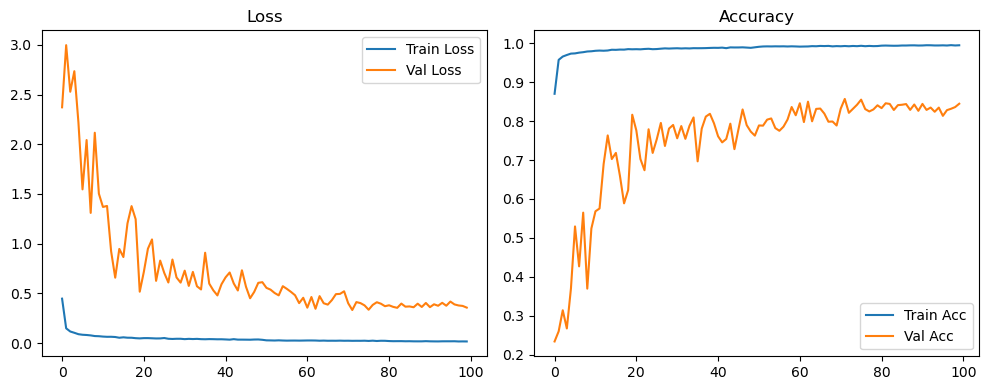

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2020, Acc: 0.9582 | Val Loss: 0.2212, Acc: 0.9306


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0491, Acc: 0.9850 | Val Loss: 0.0956, Acc: 0.9715


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0332, Acc: 0.9899 | Val Loss: 0.0751, Acc: 0.9766


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9923 | Val Loss: 0.1280, Acc: 0.9598


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9943 | Val Loss: 0.1050, Acc: 0.9683


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9954 | Val Loss: 0.0524, Acc: 0.9852


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9958 | Val Loss: 0.0391, Acc: 0.9886


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.0661, Acc: 0.9822


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.0910, Acc: 0.9746


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.0958, Acc: 0.9757


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9968 | Val Loss: 0.0480, Acc: 0.9868


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9971 | Val Loss: 0.0751, Acc: 0.9816


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0592, Acc: 0.9848


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0676, Acc: 0.9844


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.0599, Acc: 0.9855


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.0658, Acc: 0.9839


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.0535, Acc: 0.9886


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0658, Acc: 0.9863


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.0779, Acc: 0.9833


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0562, Acc: 0.9882


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0549, Acc: 0.9875


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0531, Acc: 0.9886


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.0567, Acc: 0.9867


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.0828, Acc: 0.9828


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0605, Acc: 0.9877


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.0435, Acc: 0.9906


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0658, Acc: 0.9862


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.0498, Acc: 0.9902


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0582, Acc: 0.9882


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.0638, Acc: 0.9866


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0482, Acc: 0.9901


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0512, Acc: 0.9910


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0578, Acc: 0.9892


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0550, Acc: 0.9897


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9989 | Val Loss: 0.0491, Acc: 0.9917


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.0582, Acc: 0.9894


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0785, Acc: 0.9860


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0560, Acc: 0.9897


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0655, Acc: 0.9881


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.0505, Acc: 0.9912


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0519, Acc: 0.9906


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0617, Acc: 0.9894


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0512, Acc: 0.9899


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0624, Acc: 0.9890


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0754, Acc: 0.9865


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0690, Acc: 0.9874


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0487, Acc: 0.9912


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0544, Acc: 0.9911


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0519, Acc: 0.9921


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0738, Acc: 0.9887


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0499, Acc: 0.9922


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0493, Acc: 0.9923


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0492, Acc: 0.9923


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0491, Acc: 0.9922


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0493, Acc: 0.9919


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0483, Acc: 0.9922


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0487, Acc: 0.9924


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0475, Acc: 0.9926


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0481, Acc: 0.9922


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0477, Acc: 0.9927


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0483, Acc: 0.9926


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0477, Acc: 0.9928


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0471, Acc: 0.9928


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0473, Acc: 0.9930


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0466, Acc: 0.9928


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0469, Acc: 0.9928


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0462, Acc: 0.9932


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0459, Acc: 0.9931


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0472, Acc: 0.9930


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0462, Acc: 0.9929


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0493, Acc: 0.9931


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0464, Acc: 0.9930


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0455, Acc: 0.9932


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0470, Acc: 0.9932


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0465, Acc: 0.9936


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0461, Acc: 0.9936


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0465, Acc: 0.9929


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0472, Acc: 0.9932


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0459, Acc: 0.9932


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0469, Acc: 0.9929


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0465, Acc: 0.9932


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0470, Acc: 0.9932


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0469, Acc: 0.9933


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0469, Acc: 0.9936


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0468, Acc: 0.9931


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0473, Acc: 0.9934


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0476, Acc: 0.9934


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0487, Acc: 0.9932


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0481, Acc: 0.9933


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0480, Acc: 0.9933


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0473, Acc: 0.9931


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0493, Acc: 0.9930


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0493, Acc: 0.9932


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0490, Acc: 0.9933


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0492, Acc: 0.9931


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0491, Acc: 0.9929


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0500, Acc: 0.9932


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0491, Acc: 0.9934


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0490, Acc: 0.9931


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0499, Acc: 0.9935


Final Test Loss: 0.0518 Accuracy: 0.9920


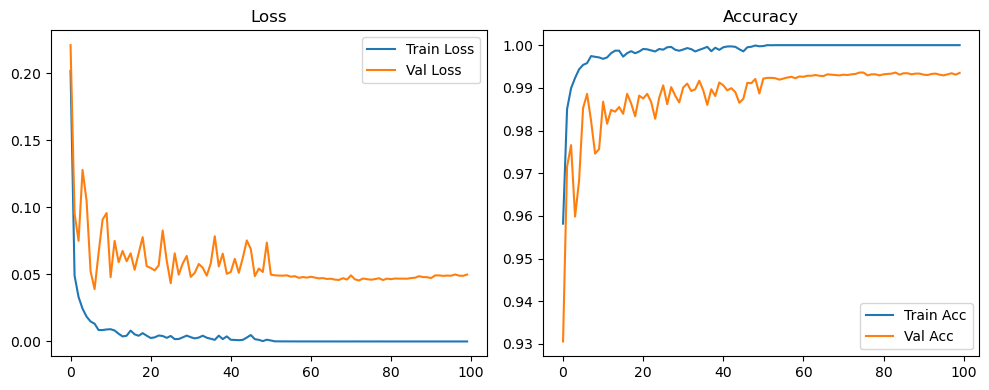

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2559, Acc: 0.9403 | Val Loss: 1.1720, Acc: 0.6408


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0741, Acc: 0.9785 | Val Loss: 0.6987, Acc: 0.7564


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0555, Acc: 0.9827 | Val Loss: 0.6837, Acc: 0.7676


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0447, Acc: 0.9863 | Val Loss: 0.6197, Acc: 0.7944


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0378, Acc: 0.9879 | Val Loss: 0.6996, Acc: 0.7832


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0347, Acc: 0.9889 | Val Loss: 0.7652, Acc: 0.7702


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0297, Acc: 0.9908 | Val Loss: 0.2788, Acc: 0.9095


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9914 | Val Loss: 0.4090, Acc: 0.8680


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9922 | Val Loss: 0.3641, Acc: 0.8775


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9934 | Val Loss: 0.2354, Acc: 0.9271


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9928 | Val Loss: 0.3382, Acc: 0.9001


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9932 | Val Loss: 0.1507, Acc: 0.9588


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9940 | Val Loss: 0.2311, Acc: 0.9307


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9940 | Val Loss: 0.1924, Acc: 0.9423


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9944 | Val Loss: 0.1730, Acc: 0.9516


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9945 | Val Loss: 0.2042, Acc: 0.9451


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9950 | Val Loss: 0.2310, Acc: 0.9392


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9956 | Val Loss: 0.4153, Acc: 0.8986


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9958 | Val Loss: 0.4047, Acc: 0.9038


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.1983, Acc: 0.9523


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9959 | Val Loss: 0.2183, Acc: 0.9456


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9954 | Val Loss: 0.2248, Acc: 0.9449


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.3120, Acc: 0.9253


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9960 | Val Loss: 0.2654, Acc: 0.9337


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9958 | Val Loss: 0.2822, Acc: 0.9354


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.2741, Acc: 0.9356


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9966 | Val Loss: 0.2138, Acc: 0.9493


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9966 | Val Loss: 0.1817, Acc: 0.9555


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.2662, Acc: 0.9410


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9969 | Val Loss: 0.2306, Acc: 0.9478


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.1550, Acc: 0.9644


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.1965, Acc: 0.9573


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.1807, Acc: 0.9604


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.3200, Acc: 0.9299


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9968 | Val Loss: 0.2334, Acc: 0.9499


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.3938, Acc: 0.9209


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.2779, Acc: 0.9421


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.3229, Acc: 0.9364


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.3352, Acc: 0.9354


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9972 | Val Loss: 0.2726, Acc: 0.9465


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.2082, Acc: 0.9588


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.2775, Acc: 0.9442


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.2955, Acc: 0.9467


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.2305, Acc: 0.9536


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.2033, Acc: 0.9587


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.2119, Acc: 0.9574


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9974 | Val Loss: 0.2793, Acc: 0.9457


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.2245, Acc: 0.9559


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.3569, Acc: 0.9349


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9977 | Val Loss: 0.3550, Acc: 0.9368


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.2571, Acc: 0.9505


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.2664, Acc: 0.9503


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.2887, Acc: 0.9463


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.2483, Acc: 0.9538


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.2243, Acc: 0.9570


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.2018, Acc: 0.9610


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.2621, Acc: 0.9507


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.2170, Acc: 0.9600


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.2017, Acc: 0.9627


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.2256, Acc: 0.9588


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.2080, Acc: 0.9616


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.2600, Acc: 0.9537


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.2417, Acc: 0.9570


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.2432, Acc: 0.9566


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.2368, Acc: 0.9574


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.2362, Acc: 0.9578


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.2275, Acc: 0.9589


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.2531, Acc: 0.9544


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.2704, Acc: 0.9514


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.2536, Acc: 0.9543


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.2182, Acc: 0.9608


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.2463, Acc: 0.9554


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.2651, Acc: 0.9526


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.2401, Acc: 0.9571


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1950, Acc: 0.9643


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1965, Acc: 0.9638


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1964, Acc: 0.9650


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1791, Acc: 0.9673


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1985, Acc: 0.9647


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.2461, Acc: 0.9573


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.2097, Acc: 0.9631


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.2285, Acc: 0.9613


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1811, Acc: 0.9681


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.2060, Acc: 0.9637


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1843, Acc: 0.9673


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1878, Acc: 0.9672


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1775, Acc: 0.9687


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1916, Acc: 0.9666


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1903, Acc: 0.9665


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.2007, Acc: 0.9643


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1924, Acc: 0.9657


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.2147, Acc: 0.9623


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1678, Acc: 0.9703


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.2084, Acc: 0.9635


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.2048, Acc: 0.9653


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.2265, Acc: 0.9621


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1821, Acc: 0.9679


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1776, Acc: 0.9692


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1861, Acc: 0.9676


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1890, Acc: 0.9670


Final Test Loss: 0.2011 Accuracy: 0.9653


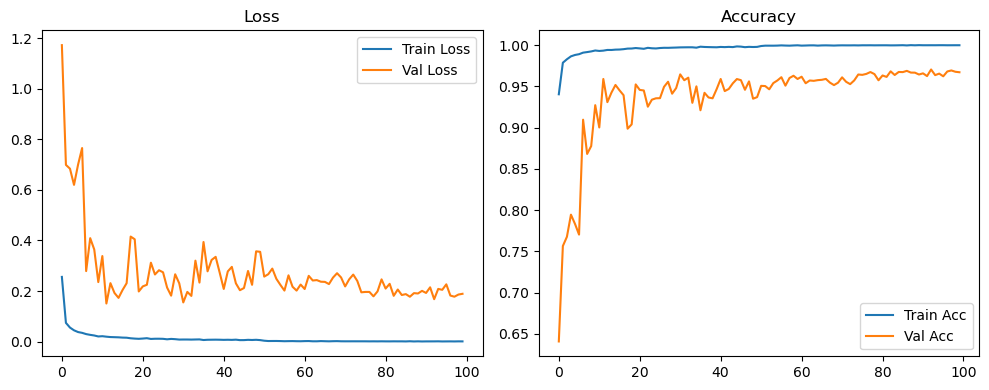

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4466, Acc: 0.8699 | Val Loss: 2.3764, Acc: 0.2361


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1482, Acc: 0.9574 | Val Loss: 3.2564, Acc: 0.2525


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1161, Acc: 0.9656 | Val Loss: 2.6117, Acc: 0.2928


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1039, Acc: 0.9695 | Val Loss: 2.8704, Acc: 0.2518


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0890, Acc: 0.9728 | Val Loss: 2.3470, Acc: 0.3569


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0838, Acc: 0.9742 | Val Loss: 1.7996, Acc: 0.4670


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0810, Acc: 0.9758 | Val Loss: 2.0940, Acc: 0.4179


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0781, Acc: 0.9765 | Val Loss: 1.4343, Acc: 0.5307


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0699, Acc: 0.9789 | Val Loss: 1.7923, Acc: 0.4353


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0710, Acc: 0.9785 | Val Loss: 1.4547, Acc: 0.5407


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0651, Acc: 0.9800 | Val Loss: 1.6559, Acc: 0.5078


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0638, Acc: 0.9807 | Val Loss: 1.4892, Acc: 0.5439


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0623, Acc: 0.9804 | Val Loss: 1.1961, Acc: 0.6148


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0625, Acc: 0.9801 | Val Loss: 0.9825, Acc: 0.6733


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0566, Acc: 0.9823 | Val Loss: 0.9159, Acc: 0.7002


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0577, Acc: 0.9817 | Val Loss: 0.9856, Acc: 0.6775


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0555, Acc: 0.9826 | Val Loss: 1.2757, Acc: 0.6334


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0525, Acc: 0.9835 | Val Loss: 1.3592, Acc: 0.5937


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0509, Acc: 0.9837 | Val Loss: 1.4155, Acc: 0.5684


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0485, Acc: 0.9842 | Val Loss: 0.7033, Acc: 0.7644


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0493, Acc: 0.9847 | Val Loss: 0.7183, Acc: 0.7666


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0508, Acc: 0.9840 | Val Loss: 0.9149, Acc: 0.6899


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0480, Acc: 0.9850 | Val Loss: 1.3392, Acc: 0.5876


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0475, Acc: 0.9854 | Val Loss: 0.9760, Acc: 0.6673


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0476, Acc: 0.9849 | Val Loss: 0.7745, Acc: 0.7226


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0480, Acc: 0.9844 | Val Loss: 0.7765, Acc: 0.7375


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0444, Acc: 0.9855 | Val Loss: 0.7336, Acc: 0.7560


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0418, Acc: 0.9867 | Val Loss: 0.9423, Acc: 0.7078


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0429, Acc: 0.9867 | Val Loss: 0.7001, Acc: 0.7582


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0437, Acc: 0.9858 | Val Loss: 0.7880, Acc: 0.7357


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0407, Acc: 0.9868 | Val Loss: 0.8951, Acc: 0.7255


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0420, Acc: 0.9859 | Val Loss: 0.8949, Acc: 0.7103


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0403, Acc: 0.9874 | Val Loss: 0.8355, Acc: 0.7219


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0432, Acc: 0.9859 | Val Loss: 0.6293, Acc: 0.7622


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0405, Acc: 0.9872 | Val Loss: 0.5717, Acc: 0.7948


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0378, Acc: 0.9875 | Val Loss: 0.5763, Acc: 0.7976


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0386, Acc: 0.9879 | Val Loss: 0.5992, Acc: 0.7871


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0382, Acc: 0.9879 | Val Loss: 0.4879, Acc: 0.8247


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0385, Acc: 0.9879 | Val Loss: 0.4748, Acc: 0.8207


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0384, Acc: 0.9877 | Val Loss: 0.6360, Acc: 0.7904


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0389, Acc: 0.9876 | Val Loss: 0.8017, Acc: 0.7321


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0369, Acc: 0.9882 | Val Loss: 0.6059, Acc: 0.7781


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0390, Acc: 0.9878 | Val Loss: 0.5787, Acc: 0.7781


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0358, Acc: 0.9884 | Val Loss: 0.4868, Acc: 0.8150


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0345, Acc: 0.9886 | Val Loss: 0.8327, Acc: 0.7029


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0351, Acc: 0.9879 | Val Loss: 0.6540, Acc: 0.7566


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9882 | Val Loss: 0.5156, Acc: 0.7991


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0332, Acc: 0.9894 | Val Loss: 0.6071, Acc: 0.7747


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9879 | Val Loss: 0.4774, Acc: 0.8043


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0324, Acc: 0.9893 | Val Loss: 0.4870, Acc: 0.8154


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0268, Acc: 0.9911 | Val Loss: 0.4487, Acc: 0.8292


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0256, Acc: 0.9913 | Val Loss: 0.4538, Acc: 0.8232


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0253, Acc: 0.9915 | Val Loss: 0.4384, Acc: 0.8311


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0254, Acc: 0.9916 | Val Loss: 0.4635, Acc: 0.8151


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0235, Acc: 0.9926 | Val Loss: 0.5007, Acc: 0.8040


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0227, Acc: 0.9924 | Val Loss: 0.4117, Acc: 0.8356


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0236, Acc: 0.9921 | Val Loss: 0.4823, Acc: 0.8093


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0223, Acc: 0.9923 | Val Loss: 0.4924, Acc: 0.8077


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0238, Acc: 0.9921 | Val Loss: 0.4237, Acc: 0.8337


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0212, Acc: 0.9928 | Val Loss: 0.4936, Acc: 0.8056


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0221, Acc: 0.9926 | Val Loss: 0.3745, Acc: 0.8511


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0223, Acc: 0.9928 | Val Loss: 0.4139, Acc: 0.8362


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0224, Acc: 0.9925 | Val Loss: 0.3545, Acc: 0.8541


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0211, Acc: 0.9928 | Val Loss: 0.4416, Acc: 0.8263


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0229, Acc: 0.9920 | Val Loss: 0.3710, Acc: 0.8545


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0223, Acc: 0.9928 | Val Loss: 0.3656, Acc: 0.8496


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0217, Acc: 0.9929 | Val Loss: 0.4288, Acc: 0.8297


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0213, Acc: 0.9929 | Val Loss: 0.4050, Acc: 0.8385


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0228, Acc: 0.9928 | Val Loss: 0.4581, Acc: 0.8186


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0201, Acc: 0.9930 | Val Loss: 0.4030, Acc: 0.8382


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0212, Acc: 0.9929 | Val Loss: 0.3924, Acc: 0.8435


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0195, Acc: 0.9933 | Val Loss: 0.3770, Acc: 0.8464


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0200, Acc: 0.9928 | Val Loss: 0.4520, Acc: 0.8153


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0201, Acc: 0.9931 | Val Loss: 0.4306, Acc: 0.8257


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0227, Acc: 0.9928 | Val Loss: 0.4027, Acc: 0.8372


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0199, Acc: 0.9935 | Val Loss: 0.3554, Acc: 0.8553


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0195, Acc: 0.9934 | Val Loss: 0.3495, Acc: 0.8548


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0183, Acc: 0.9936 | Val Loss: 0.3268, Acc: 0.8649


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0201, Acc: 0.9938 | Val Loss: 0.3499, Acc: 0.8566


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0203, Acc: 0.9932 | Val Loss: 0.3542, Acc: 0.8578


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0195, Acc: 0.9935 | Val Loss: 0.3485, Acc: 0.8564


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0186, Acc: 0.9939 | Val Loss: 0.3608, Acc: 0.8550


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0193, Acc: 0.9931 | Val Loss: 0.3517, Acc: 0.8524


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0197, Acc: 0.9936 | Val Loss: 0.4212, Acc: 0.8299


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0179, Acc: 0.9938 | Val Loss: 0.3926, Acc: 0.8405


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0191, Acc: 0.9937 | Val Loss: 0.3854, Acc: 0.8469


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0181, Acc: 0.9938 | Val Loss: 0.3985, Acc: 0.8409


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0181, Acc: 0.9940 | Val Loss: 0.4335, Acc: 0.8281


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0177, Acc: 0.9941 | Val Loss: 0.3902, Acc: 0.8427


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0190, Acc: 0.9935 | Val Loss: 0.4061, Acc: 0.8378


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0175, Acc: 0.9939 | Val Loss: 0.3727, Acc: 0.8478


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0176, Acc: 0.9945 | Val Loss: 0.4163, Acc: 0.8341


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0174, Acc: 0.9945 | Val Loss: 0.3834, Acc: 0.8405


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0167, Acc: 0.9943 | Val Loss: 0.4171, Acc: 0.8342


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0188, Acc: 0.9939 | Val Loss: 0.3900, Acc: 0.8397


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0194, Acc: 0.9936 | Val Loss: 0.4170, Acc: 0.8301


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0187, Acc: 0.9937 | Val Loss: 0.3827, Acc: 0.8448


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0183, Acc: 0.9942 | Val Loss: 0.3720, Acc: 0.8469


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0174, Acc: 0.9942 | Val Loss: 0.3858, Acc: 0.8440


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0167, Acc: 0.9941 | Val Loss: 0.3674, Acc: 0.8506


Final Test Loss: 0.3533 Accuracy: 0.8583


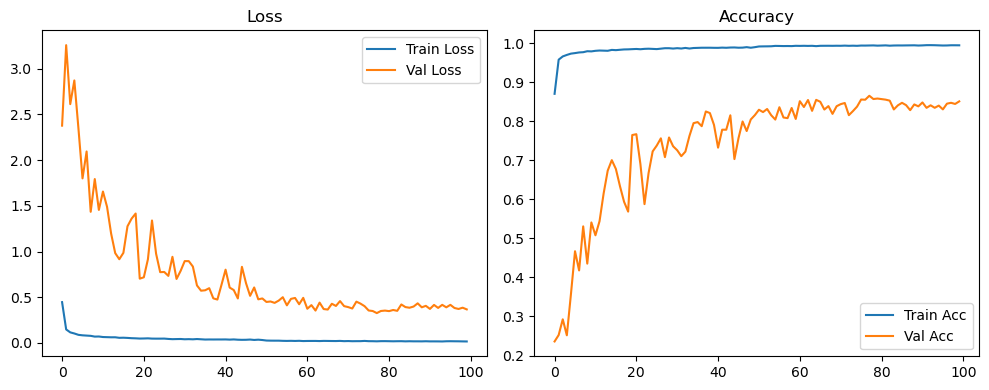

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2625, Acc: 0.9605 | Val Loss: 0.4481, Acc: 0.8433


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0506, Acc: 0.9866 | Val Loss: 0.0863, Acc: 0.9737


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0338, Acc: 0.9905 | Val Loss: 0.0834, Acc: 0.9749


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0242, Acc: 0.9931 | Val Loss: 0.0865, Acc: 0.9716


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0175, Acc: 0.9950 | Val Loss: 0.0759, Acc: 0.9747


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9964 | Val Loss: 0.2575, Acc: 0.9202


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9965 | Val Loss: 0.0692, Acc: 0.9794


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1049, Acc: 0.9680


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9979 | Val Loss: 0.1803, Acc: 0.9527


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.0548, Acc: 0.9852


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9981 | Val Loss: 0.0842, Acc: 0.9771


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.1425, Acc: 0.9604


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9992 | Val Loss: 0.0603, Acc: 0.9840


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1367, Acc: 0.9643


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.0664, Acc: 0.9818


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0617, Acc: 0.9830


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0367, Acc: 0.9909


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0415, Acc: 0.9901


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.0375, Acc: 0.9913


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0331, Acc: 0.9913


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0347, Acc: 0.9913


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9951 | Val Loss: 0.0676, Acc: 0.9838


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.0478, Acc: 0.9878


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0630, Acc: 0.9848


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0355, Acc: 0.9919


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.0425, Acc: 0.9904


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0403, Acc: 0.9902


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.2104, Acc: 0.9509


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0555, Acc: 0.9871


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0415, Acc: 0.9899


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0440, Acc: 0.9894


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0521, Acc: 0.9875


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0741, Acc: 0.9847


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0765, Acc: 0.9824


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0474, Acc: 0.9880


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0415, Acc: 0.9917


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0395, Acc: 0.9915


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0393, Acc: 0.9916


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0385, Acc: 0.9918


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0379, Acc: 0.9918


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0993, Acc: 0.9808


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9965 | Val Loss: 0.0592, Acc: 0.9872


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0454, Acc: 0.9902


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0493, Acc: 0.9896


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0432, Acc: 0.9908


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0401, Acc: 0.9914


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0384, Acc: 0.9921


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0375, Acc: 0.9919


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0709, Acc: 0.9843


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0464, Acc: 0.9906


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0432, Acc: 0.9902


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0434, Acc: 0.9909


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0402, Acc: 0.9915


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0830, Acc: 0.9836


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0977, Acc: 0.9819


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0505, Acc: 0.9892


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0499, Acc: 0.9898


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0490, Acc: 0.9903


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0430, Acc: 0.9919


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0456, Acc: 0.9912


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0464, Acc: 0.9912


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0449, Acc: 0.9918


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0439, Acc: 0.9917


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0474, Acc: 0.9912


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9975 | Val Loss: 0.0608, Acc: 0.9872


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0505, Acc: 0.9892


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0492, Acc: 0.9911


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0485, Acc: 0.9906


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0461, Acc: 0.9911


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0571, Acc: 0.9890


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0619, Acc: 0.9877


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0550, Acc: 0.9884


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0536, Acc: 0.9898


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0564, Acc: 0.9888


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0485, Acc: 0.9902


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0599, Acc: 0.9886


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0490, Acc: 0.9902


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0521, Acc: 0.9893


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0520, Acc: 0.9896


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0468, Acc: 0.9915


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0453, Acc: 0.9912


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0456, Acc: 0.9914


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0450, Acc: 0.9912


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0461, Acc: 0.9910


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0459, Acc: 0.9910


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0455, Acc: 0.9912


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0455, Acc: 0.9917


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0457, Acc: 0.9918


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0471, Acc: 0.9918


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0474, Acc: 0.9912


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0454, Acc: 0.9913


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0464, Acc: 0.9915


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1296, Acc: 0.9772


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.0695, Acc: 0.9877


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0550, Acc: 0.9892


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0551, Acc: 0.9902


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0511, Acc: 0.9911


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0498, Acc: 0.9911


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0488, Acc: 0.9911


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0496, Acc: 0.9911


Final Test Loss: 0.0478 Accuracy: 0.9903


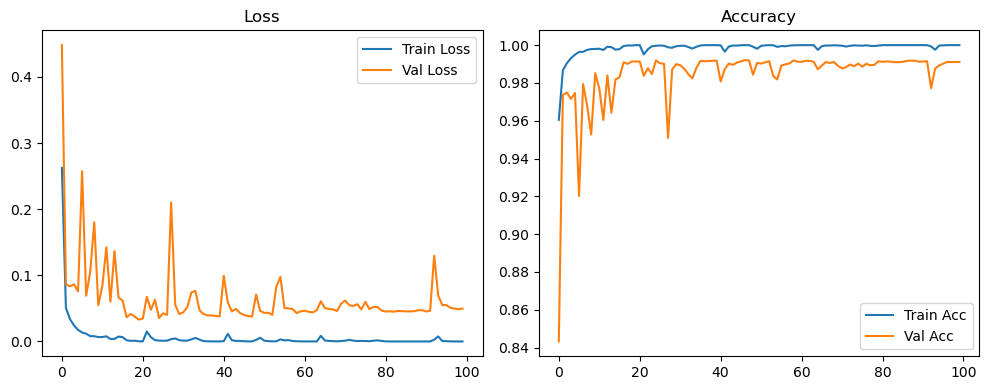

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3276, Acc: 0.9407 | Val Loss: 0.8000, Acc: 0.7047


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0790, Acc: 0.9781 | Val Loss: 0.8321, Acc: 0.7645


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0587, Acc: 0.9825 | Val Loss: 0.9399, Acc: 0.6805


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0479, Acc: 0.9851 | Val Loss: 1.0717, Acc: 0.6651


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0407, Acc: 0.9876 | Val Loss: 0.9067, Acc: 0.7128


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0356, Acc: 0.9887 | Val Loss: 1.4342, Acc: 0.5665


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0313, Acc: 0.9901 | Val Loss: 0.8967, Acc: 0.7082


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0281, Acc: 0.9908 | Val Loss: 0.6337, Acc: 0.7985


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9917 | Val Loss: 1.2341, Acc: 0.6657


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9918 | Val Loss: 0.6712, Acc: 0.7933


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0213, Acc: 0.9934 | Val Loss: 0.5883, Acc: 0.8288


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0200, Acc: 0.9935 | Val Loss: 0.4512, Acc: 0.8632


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0189, Acc: 0.9938 | Val Loss: 0.4496, Acc: 0.8649


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9943 | Val Loss: 0.4408, Acc: 0.8654


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9946 | Val Loss: 0.7475, Acc: 0.8229


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9951 | Val Loss: 0.6322, Acc: 0.8525


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9948 | Val Loss: 0.6260, Acc: 0.8537


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9954 | Val Loss: 0.6020, Acc: 0.8461


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9958 | Val Loss: 0.5913, Acc: 0.8425


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9968 | Val Loss: 0.5151, Acc: 0.8766


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.4936, Acc: 0.8741


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9959 | Val Loss: 0.4249, Acc: 0.8848


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9963 | Val Loss: 0.7143, Acc: 0.8380


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 0.4034, Acc: 0.8968


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9965 | Val Loss: 0.5520, Acc: 0.8843


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9970 | Val Loss: 0.6230, Acc: 0.8578


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9965 | Val Loss: 0.4753, Acc: 0.8817


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.3214, Acc: 0.9160


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9975 | Val Loss: 0.3747, Acc: 0.9031


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.4310, Acc: 0.8962


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.3501, Acc: 0.9110


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.3672, Acc: 0.9087


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9974 | Val Loss: 0.3277, Acc: 0.9180


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.3342, Acc: 0.9147


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.2032, Acc: 0.9498


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.3475, Acc: 0.9212


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9977 | Val Loss: 0.3284, Acc: 0.9235


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.3847, Acc: 0.9182


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.4669, Acc: 0.8991


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9974 | Val Loss: 0.5922, Acc: 0.8839


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.5781, Acc: 0.8815


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.4929, Acc: 0.8936


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9977 | Val Loss: 0.5357, Acc: 0.8905


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.4547, Acc: 0.9042


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.5179, Acc: 0.8997


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.4043, Acc: 0.9142


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.2370, Acc: 0.9457


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.4208, Acc: 0.9103


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.5014, Acc: 0.9030


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.4460, Acc: 0.9077


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.3989, Acc: 0.9180


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.4439, Acc: 0.9121


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.3120, Acc: 0.9311


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.3285, Acc: 0.9310


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.3284, Acc: 0.9312


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.2633, Acc: 0.9443


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.3641, Acc: 0.9262


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.3032, Acc: 0.9377


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.2634, Acc: 0.9457


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9984 | Val Loss: 0.3164, Acc: 0.9343


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9980 | Val Loss: 0.3328, Acc: 0.9321


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.2966, Acc: 0.9377


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9983 | Val Loss: 0.2450, Acc: 0.9481


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.3727, Acc: 0.9262


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.3869, Acc: 0.9238


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.2526, Acc: 0.9490


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.3767, Acc: 0.9265


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.4685, Acc: 0.9130


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.6182, Acc: 0.8816


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.4032, Acc: 0.9221


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.4384, Acc: 0.9158


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.3387, Acc: 0.9321


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9987 | Val Loss: 0.2775, Acc: 0.9438


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.3307, Acc: 0.9327


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9985 | Val Loss: 0.2872, Acc: 0.9446


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.2905, Acc: 0.9396


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.3149, Acc: 0.9380


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.2597, Acc: 0.9480


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.2758, Acc: 0.9438


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.2785, Acc: 0.9452


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9990 | Val Loss: 0.2458, Acc: 0.9542


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.3207, Acc: 0.9390


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.2438, Acc: 0.9551


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.2851, Acc: 0.9459


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.3248, Acc: 0.9383


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.3770, Acc: 0.9323


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.4730, Acc: 0.9179


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.3665, Acc: 0.9310


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.3963, Acc: 0.9274


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.4750, Acc: 0.9150


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.3737, Acc: 0.9291


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.3082, Acc: 0.9451


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9989 | Val Loss: 0.1960, Acc: 0.9641


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.2814, Acc: 0.9477


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.2262, Acc: 0.9594


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.2891, Acc: 0.9478


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.2248, Acc: 0.9608


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.2315, Acc: 0.9599


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.1737, Acc: 0.9688


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.2265, Acc: 0.9602


Final Test Loss: 0.2061 Accuracy: 0.9628


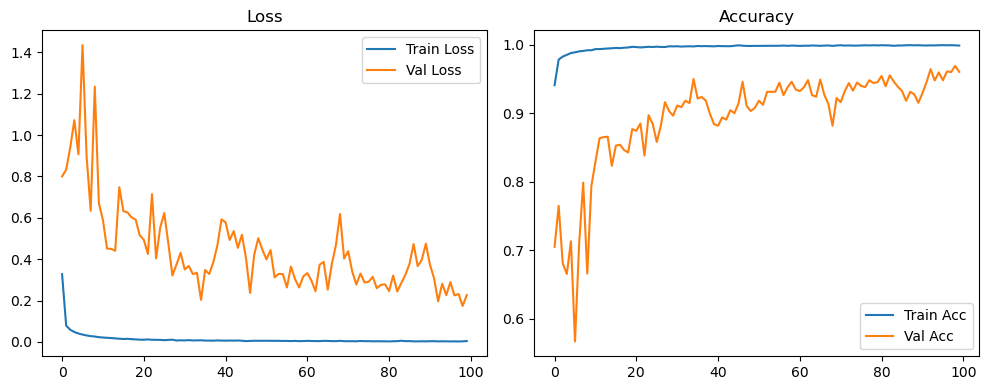

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.5658, Acc: 0.8497 | Val Loss: 2.4578, Acc: 0.1751


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1777, Acc: 0.9499 | Val Loss: 3.0202, Acc: 0.2056


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1308, Acc: 0.9628 | Val Loss: 2.7795, Acc: 0.2434


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1145, Acc: 0.9653 | Val Loss: 3.0418, Acc: 0.2201


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0974, Acc: 0.9713 | Val Loss: 3.2483, Acc: 0.2556


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0903, Acc: 0.9727 | Val Loss: 3.2166, Acc: 0.2397


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0859, Acc: 0.9741 | Val Loss: 3.1731, Acc: 0.2583


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0805, Acc: 0.9759 | Val Loss: 2.9304, Acc: 0.2606


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0767, Acc: 0.9764 | Val Loss: 2.9501, Acc: 0.2672


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0725, Acc: 0.9776 | Val Loss: 2.4534, Acc: 0.3443


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0708, Acc: 0.9784 | Val Loss: 2.3707, Acc: 0.3628


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0650, Acc: 0.9803 | Val Loss: 2.4749, Acc: 0.3563


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0658, Acc: 0.9802 | Val Loss: 1.9753, Acc: 0.4190


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0632, Acc: 0.9804 | Val Loss: 1.6891, Acc: 0.4607


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0594, Acc: 0.9816 | Val Loss: 2.1051, Acc: 0.4160


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0612, Acc: 0.9813 | Val Loss: 2.5230, Acc: 0.3693


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0563, Acc: 0.9818 | Val Loss: 2.0848, Acc: 0.4532


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0559, Acc: 0.9830 | Val Loss: 2.8898, Acc: 0.3383


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0526, Acc: 0.9834 | Val Loss: 2.4153, Acc: 0.3894


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0530, Acc: 0.9835 | Val Loss: 1.6733, Acc: 0.5038


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0521, Acc: 0.9836 | Val Loss: 2.1434, Acc: 0.4128


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0520, Acc: 0.9835 | Val Loss: 1.7741, Acc: 0.4586


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0500, Acc: 0.9848 | Val Loss: 2.4234, Acc: 0.3429


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0483, Acc: 0.9862 | Val Loss: 2.1118, Acc: 0.4104


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0502, Acc: 0.9841 | Val Loss: 1.4467, Acc: 0.5264


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0524, Acc: 0.9838 | Val Loss: 1.1462, Acc: 0.6267


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0469, Acc: 0.9849 | Val Loss: 1.2992, Acc: 0.5674


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0445, Acc: 0.9859 | Val Loss: 2.1252, Acc: 0.4114


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0453, Acc: 0.9858 | Val Loss: 1.7406, Acc: 0.4711


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0442, Acc: 0.9855 | Val Loss: 1.4491, Acc: 0.5514


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0435, Acc: 0.9866 | Val Loss: 1.6038, Acc: 0.5272


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0428, Acc: 0.9865 | Val Loss: 1.6729, Acc: 0.5047


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0428, Acc: 0.9867 | Val Loss: 1.6397, Acc: 0.5046


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0413, Acc: 0.9865 | Val Loss: 1.3608, Acc: 0.5671


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0426, Acc: 0.9863 | Val Loss: 1.6241, Acc: 0.5192


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0392, Acc: 0.9871 | Val Loss: 1.6955, Acc: 0.5251


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0395, Acc: 0.9875 | Val Loss: 1.6568, Acc: 0.5122


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0420, Acc: 0.9867 | Val Loss: 0.9888, Acc: 0.6917


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0411, Acc: 0.9871 | Val Loss: 1.2723, Acc: 0.5929


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0412, Acc: 0.9868 | Val Loss: 1.5525, Acc: 0.5395


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0396, Acc: 0.9874 | Val Loss: 1.5049, Acc: 0.5460


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0386, Acc: 0.9874 | Val Loss: 1.1722, Acc: 0.6214


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0385, Acc: 0.9874 | Val Loss: 1.2711, Acc: 0.6075


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0374, Acc: 0.9884 | Val Loss: 0.8387, Acc: 0.7044


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0385, Acc: 0.9879 | Val Loss: 1.4537, Acc: 0.5497


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0382, Acc: 0.9874 | Val Loss: 0.9249, Acc: 0.6807


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0366, Acc: 0.9880 | Val Loss: 0.9156, Acc: 0.6932


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0360, Acc: 0.9883 | Val Loss: 0.8155, Acc: 0.7247


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0365, Acc: 0.9879 | Val Loss: 0.9860, Acc: 0.6911


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0347, Acc: 0.9887 | Val Loss: 0.9834, Acc: 0.6732


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0326, Acc: 0.9892 | Val Loss: 0.7263, Acc: 0.7431


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0352, Acc: 0.9879 | Val Loss: 1.1170, Acc: 0.6398


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0334, Acc: 0.9893 | Val Loss: 0.8481, Acc: 0.7140


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0348, Acc: 0.9887 | Val Loss: 1.0916, Acc: 0.6448


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0351, Acc: 0.9880 | Val Loss: 1.1083, Acc: 0.6537


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0344, Acc: 0.9886 | Val Loss: 1.4591, Acc: 0.5698


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0325, Acc: 0.9892 | Val Loss: 1.0044, Acc: 0.6787


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0327, Acc: 0.9896 | Val Loss: 0.8570, Acc: 0.7026


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0337, Acc: 0.9895 | Val Loss: 0.8587, Acc: 0.7206


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9898 | Val Loss: 0.9025, Acc: 0.7005


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0325, Acc: 0.9891 | Val Loss: 0.7717, Acc: 0.7324


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0317, Acc: 0.9894 | Val Loss: 0.9045, Acc: 0.6997


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0334, Acc: 0.9887 | Val Loss: 0.6879, Acc: 0.7544


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0311, Acc: 0.9900 | Val Loss: 0.6406, Acc: 0.7658


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0322, Acc: 0.9887 | Val Loss: 0.6587, Acc: 0.7577


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0308, Acc: 0.9898 | Val Loss: 0.6754, Acc: 0.7454


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0317, Acc: 0.9893 | Val Loss: 0.7364, Acc: 0.7361


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0303, Acc: 0.9894 | Val Loss: 0.7183, Acc: 0.7548


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0320, Acc: 0.9904 | Val Loss: 0.9080, Acc: 0.6528


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0296, Acc: 0.9900 | Val Loss: 0.7828, Acc: 0.7244


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0324, Acc: 0.9892 | Val Loss: 0.9499, Acc: 0.6823


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0291, Acc: 0.9904 | Val Loss: 0.5535, Acc: 0.7897


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0306, Acc: 0.9897 | Val Loss: 0.6902, Acc: 0.7432


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0309, Acc: 0.9898 | Val Loss: 0.5849, Acc: 0.7840


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0287, Acc: 0.9904 | Val Loss: 0.6789, Acc: 0.7659


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9898 | Val Loss: 0.8507, Acc: 0.7242


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0294, Acc: 0.9901 | Val Loss: 0.7701, Acc: 0.7387


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9915 | Val Loss: 0.7366, Acc: 0.7513


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0279, Acc: 0.9908 | Val Loss: 0.7437, Acc: 0.7329


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0311, Acc: 0.9895 | Val Loss: 0.6972, Acc: 0.7470


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0294, Acc: 0.9905 | Val Loss: 0.6363, Acc: 0.7628


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0281, Acc: 0.9906 | Val Loss: 0.6607, Acc: 0.7582


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0278, Acc: 0.9908 | Val Loss: 0.6276, Acc: 0.7702


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9913 | Val Loss: 0.8403, Acc: 0.7076


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0282, Acc: 0.9905 | Val Loss: 0.8019, Acc: 0.7083


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0285, Acc: 0.9908 | Val Loss: 0.7481, Acc: 0.7328


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0274, Acc: 0.9913 | Val Loss: 0.7106, Acc: 0.7529


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0261, Acc: 0.9911 | Val Loss: 0.6806, Acc: 0.7603


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0255, Acc: 0.9916 | Val Loss: 0.6603, Acc: 0.7668


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0271, Acc: 0.9905 | Val Loss: 0.6637, Acc: 0.7621


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0271, Acc: 0.9908 | Val Loss: 0.7158, Acc: 0.7482


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0282, Acc: 0.9909 | Val Loss: 0.8209, Acc: 0.7228


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0277, Acc: 0.9909 | Val Loss: 0.6291, Acc: 0.7652


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0268, Acc: 0.9911 | Val Loss: 0.6755, Acc: 0.7704


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0281, Acc: 0.9904 | Val Loss: 0.7595, Acc: 0.7376


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0252, Acc: 0.9921 | Val Loss: 0.7842, Acc: 0.7251


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0268, Acc: 0.9913 | Val Loss: 0.8224, Acc: 0.7134


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0243, Acc: 0.9913 | Val Loss: 0.6125, Acc: 0.7733


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9915 | Val Loss: 0.7688, Acc: 0.7358


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0255, Acc: 0.9913 | Val Loss: 0.6891, Acc: 0.7452


Final Test Loss: 0.6682 Accuracy: 0.7520


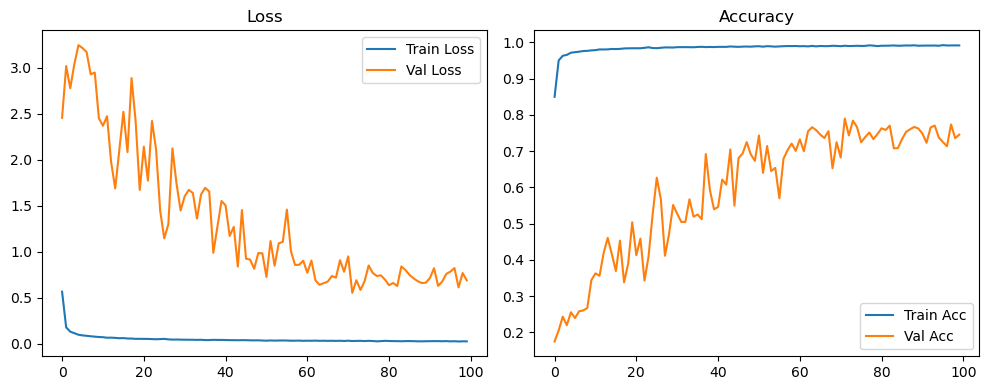

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2628, Acc: 0.9605 | Val Loss: 0.3839, Acc: 0.8745


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0502, Acc: 0.9864 | Val Loss: 0.0910, Acc: 0.9733


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0334, Acc: 0.9908 | Val Loss: 0.0875, Acc: 0.9745


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0240, Acc: 0.9931 | Val Loss: 0.0966, Acc: 0.9683


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9948 | Val Loss: 0.0957, Acc: 0.9695


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9963 | Val Loss: 0.1127, Acc: 0.9660


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9964 | Val Loss: 0.0751, Acc: 0.9781


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9975 | Val Loss: 0.0708, Acc: 0.9786


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9988 | Val Loss: 0.0738, Acc: 0.9789


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9981 | Val Loss: 0.0494, Acc: 0.9863


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9976 | Val Loss: 0.1140, Acc: 0.9637


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.0612, Acc: 0.9824


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.0596, Acc: 0.9833


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0806, Acc: 0.9792


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0533, Acc: 0.9861


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.0473, Acc: 0.9880


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.0542, Acc: 0.9856


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0548, Acc: 0.9872


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0404, Acc: 0.9902


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0710, Acc: 0.9822


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0790, Acc: 0.9808


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0541, Acc: 0.9864


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0477, Acc: 0.9882


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0513, Acc: 0.9878


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0996, Acc: 0.9778


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0505, Acc: 0.9887


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0642, Acc: 0.9849


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0466, Acc: 0.9890


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0383, Acc: 0.9906


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0354, Acc: 0.9919


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0337, Acc: 0.9925


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1992, Acc: 0.9563


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.0451, Acc: 0.9895


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0442, Acc: 0.9889


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0373, Acc: 0.9916


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0365, Acc: 0.9918


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0342, Acc: 0.9924


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0363, Acc: 0.9918


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1131, Acc: 0.9749


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.0512, Acc: 0.9877


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0501, Acc: 0.9886


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.0402, Acc: 0.9913


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0411, Acc: 0.9913


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0436, Acc: 0.9900


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0381, Acc: 0.9915


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0352, Acc: 0.9920


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0353, Acc: 0.9920


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0357, Acc: 0.9917


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0354, Acc: 0.9921


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1597, Acc: 0.9688


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0439, Acc: 0.9894


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0401, Acc: 0.9902


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0402, Acc: 0.9907


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0389, Acc: 0.9907


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0392, Acc: 0.9903


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0380, Acc: 0.9906


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0390, Acc: 0.9911


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0377, Acc: 0.9911


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0381, Acc: 0.9913


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0379, Acc: 0.9918


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0387, Acc: 0.9912


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0374, Acc: 0.9910


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0379, Acc: 0.9912


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0582, Acc: 0.9882


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0430, Acc: 0.9904


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0417, Acc: 0.9912


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0400, Acc: 0.9914


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0440, Acc: 0.9902


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0430, Acc: 0.9912


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0412, Acc: 0.9912


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0402, Acc: 0.9913


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0399, Acc: 0.9914


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0402, Acc: 0.9918


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0851, Acc: 0.9840


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0469, Acc: 0.9908


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0429, Acc: 0.9920


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0455, Acc: 0.9912


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0411, Acc: 0.9915


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0396, Acc: 0.9921


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0416, Acc: 0.9918


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0402, Acc: 0.9918


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0400, Acc: 0.9920


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0395, Acc: 0.9920


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0397, Acc: 0.9918


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0393, Acc: 0.9918


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0401, Acc: 0.9920


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0395, Acc: 0.9922


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0413, Acc: 0.9921


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0400, Acc: 0.9920


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0431, Acc: 0.9917


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0401, Acc: 0.9922


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0412, Acc: 0.9922


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0395, Acc: 0.9926


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0391, Acc: 0.9926


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0397, Acc: 0.9925


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0432, Acc: 0.9923


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0410, Acc: 0.9924


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0406, Acc: 0.9928


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0399, Acc: 0.9926


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0402, Acc: 0.9926


Final Test Loss: 0.0452 Accuracy: 0.9918


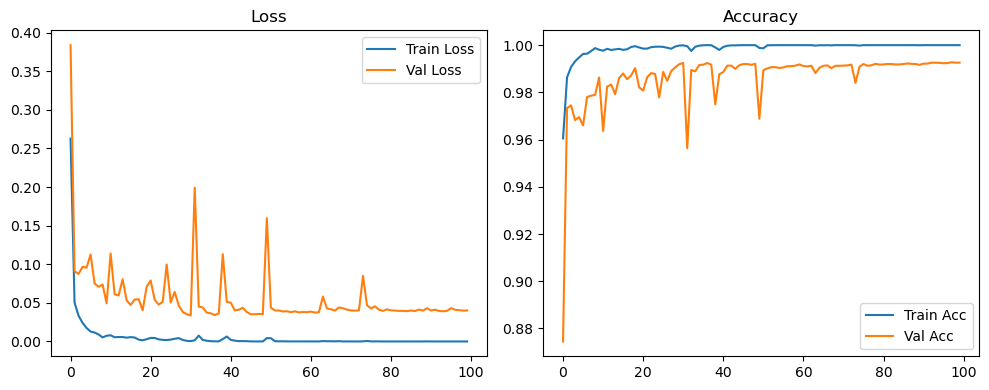

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3276, Acc: 0.9407 | Val Loss: 0.8086, Acc: 0.7176


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0782, Acc: 0.9784 | Val Loss: 0.9876, Acc: 0.7016


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0588, Acc: 0.9819 | Val Loss: 1.1191, Acc: 0.6192


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0478, Acc: 0.9851 | Val Loss: 1.1914, Acc: 0.6473


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0403, Acc: 0.9880 | Val Loss: 1.0716, Acc: 0.6736


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0354, Acc: 0.9886 | Val Loss: 1.5995, Acc: 0.5142


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9899 | Val Loss: 0.8727, Acc: 0.7117


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0277, Acc: 0.9910 | Val Loss: 0.6749, Acc: 0.7866


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0260, Acc: 0.9918 | Val Loss: 1.3325, Acc: 0.6324


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0225, Acc: 0.9927 | Val Loss: 0.5450, Acc: 0.8316


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0202, Acc: 0.9939 | Val Loss: 0.8169, Acc: 0.7762


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0205, Acc: 0.9935 | Val Loss: 0.2644, Acc: 0.9169


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9940 | Val Loss: 0.3981, Acc: 0.8721


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9944 | Val Loss: 0.5305, Acc: 0.8338


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9944 | Val Loss: 1.0363, Acc: 0.7186


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9946 | Val Loss: 0.7912, Acc: 0.8010


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9952 | Val Loss: 0.9996, Acc: 0.7551


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9958 | Val Loss: 0.9873, Acc: 0.7807


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9956 | Val Loss: 0.8047, Acc: 0.8127


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.7648, Acc: 0.8277


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9963 | Val Loss: 0.4296, Acc: 0.8851


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9963 | Val Loss: 0.4168, Acc: 0.8883


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.6320, Acc: 0.8532


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.5365, Acc: 0.8626


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.7313, Acc: 0.8261


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.4636, Acc: 0.8858


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9965 | Val Loss: 0.5084, Acc: 0.8850


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9962 | Val Loss: 0.4746, Acc: 0.8793


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9970 | Val Loss: 0.5597, Acc: 0.8694


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.3763, Acc: 0.9015


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.5533, Acc: 0.8637


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9970 | Val Loss: 0.3183, Acc: 0.9176


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.2936, Acc: 0.9247


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.4312, Acc: 0.8918


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9973 | Val Loss: 0.4464, Acc: 0.8950


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.5189, Acc: 0.8795


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.3438, Acc: 0.9130


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9977 | Val Loss: 0.3780, Acc: 0.9153


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.3578, Acc: 0.9162


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.4166, Acc: 0.9070


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.3076, Acc: 0.9272


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.3755, Acc: 0.9127


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.4888, Acc: 0.8890


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.3719, Acc: 0.9153


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.3536, Acc: 0.9248


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9982 | Val Loss: 0.3030, Acc: 0.9343


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9979 | Val Loss: 0.3048, Acc: 0.9331


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.3077, Acc: 0.9289


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.3652, Acc: 0.9174


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.3542, Acc: 0.9217


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.2920, Acc: 0.9337


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.3030, Acc: 0.9327


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.2876, Acc: 0.9353


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.2911, Acc: 0.9356


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.3102, Acc: 0.9306


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.3035, Acc: 0.9337


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.3335, Acc: 0.9283


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.3257, Acc: 0.9286


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.2906, Acc: 0.9373


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.3675, Acc: 0.9236


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.2636, Acc: 0.9433


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.3409, Acc: 0.9287


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.3393, Acc: 0.9302


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.3661, Acc: 0.9247


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.3037, Acc: 0.9347


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.3603, Acc: 0.9250


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.3322, Acc: 0.9317


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.4658, Acc: 0.9112


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.4953, Acc: 0.9055


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.3776, Acc: 0.9248


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.4744, Acc: 0.9111


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.4138, Acc: 0.9185


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.3691, Acc: 0.9277


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.3031, Acc: 0.9383


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.3722, Acc: 0.9268


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.3478, Acc: 0.9314


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9993 | Val Loss: 0.3232, Acc: 0.9351


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.3120, Acc: 0.9369


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.3658, Acc: 0.9275


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.3554, Acc: 0.9319


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.3541, Acc: 0.9309


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.3878, Acc: 0.9250


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.3361, Acc: 0.9357


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.3524, Acc: 0.9304


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.2631, Acc: 0.9467


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.3103, Acc: 0.9397


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.3535, Acc: 0.9320


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.3414, Acc: 0.9351


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.3073, Acc: 0.9402


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.3232, Acc: 0.9387


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.3025, Acc: 0.9427


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.3204, Acc: 0.9387


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.2758, Acc: 0.9485


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.3667, Acc: 0.9301


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.2980, Acc: 0.9409


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.3361, Acc: 0.9346


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.3504, Acc: 0.9356


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.3201, Acc: 0.9385


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.3190, Acc: 0.9406


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.3343, Acc: 0.9395


Final Test Loss: 0.3356 Accuracy: 0.9386


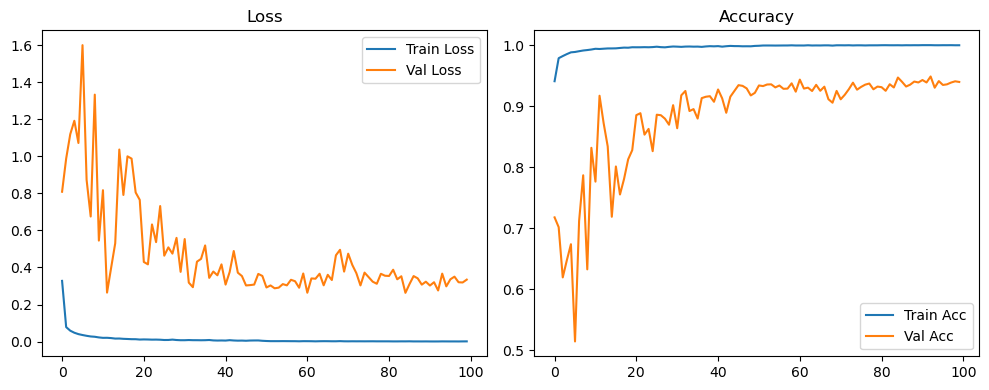

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.5659, Acc: 0.8499 | Val Loss: 2.6124, Acc: 0.1566


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1780, Acc: 0.9499 | Val Loss: 2.9771, Acc: 0.2081


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1307, Acc: 0.9626 | Val Loss: 2.8758, Acc: 0.2401


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1146, Acc: 0.9660 | Val Loss: 3.1669, Acc: 0.2137


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0976, Acc: 0.9712 | Val Loss: 3.0869, Acc: 0.2730


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0908, Acc: 0.9726 | Val Loss: 3.0751, Acc: 0.2525


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0859, Acc: 0.9739 | Val Loss: 3.1587, Acc: 0.2589


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0809, Acc: 0.9760 | Val Loss: 2.8996, Acc: 0.2572


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0767, Acc: 0.9770 | Val Loss: 2.8753, Acc: 0.2811


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0720, Acc: 0.9771 | Val Loss: 2.7712, Acc: 0.3078


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0706, Acc: 0.9779 | Val Loss: 2.3616, Acc: 0.3601


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0645, Acc: 0.9805 | Val Loss: 2.4982, Acc: 0.3731


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0657, Acc: 0.9799 | Val Loss: 2.0026, Acc: 0.4303


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0630, Acc: 0.9807 | Val Loss: 2.1139, Acc: 0.3857


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0587, Acc: 0.9820 | Val Loss: 2.5122, Acc: 0.3734


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0615, Acc: 0.9812 | Val Loss: 2.3879, Acc: 0.4066


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0570, Acc: 0.9819 | Val Loss: 2.1408, Acc: 0.4657


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0564, Acc: 0.9826 | Val Loss: 2.9748, Acc: 0.3303


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0525, Acc: 0.9836 | Val Loss: 2.4107, Acc: 0.3927


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0519, Acc: 0.9836 | Val Loss: 1.3042, Acc: 0.5990


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0517, Acc: 0.9842 | Val Loss: 1.9831, Acc: 0.4649


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0513, Acc: 0.9838 | Val Loss: 1.5863, Acc: 0.5088


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0492, Acc: 0.9853 | Val Loss: 2.9165, Acc: 0.2964


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0484, Acc: 0.9860 | Val Loss: 2.0910, Acc: 0.3997


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0493, Acc: 0.9845 | Val Loss: 1.3733, Acc: 0.5477


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0512, Acc: 0.9839 | Val Loss: 1.2416, Acc: 0.6155


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0462, Acc: 0.9853 | Val Loss: 1.2471, Acc: 0.5910


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0459, Acc: 0.9854 | Val Loss: 1.6277, Acc: 0.5114


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0446, Acc: 0.9861 | Val Loss: 1.4759, Acc: 0.5361


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0441, Acc: 0.9859 | Val Loss: 1.4007, Acc: 0.5653


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0418, Acc: 0.9872 | Val Loss: 1.2887, Acc: 0.5972


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0438, Acc: 0.9866 | Val Loss: 1.5231, Acc: 0.5411


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0432, Acc: 0.9860 | Val Loss: 1.6039, Acc: 0.5048


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0412, Acc: 0.9869 | Val Loss: 1.4181, Acc: 0.5588


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0418, Acc: 0.9864 | Val Loss: 1.6902, Acc: 0.5070


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0401, Acc: 0.9867 | Val Loss: 1.7012, Acc: 0.5365


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0387, Acc: 0.9879 | Val Loss: 1.8174, Acc: 0.4769


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0400, Acc: 0.9874 | Val Loss: 1.0947, Acc: 0.6506


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0396, Acc: 0.9871 | Val Loss: 1.1880, Acc: 0.6158


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0413, Acc: 0.9867 | Val Loss: 1.2994, Acc: 0.5912


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0397, Acc: 0.9870 | Val Loss: 1.4826, Acc: 0.5305


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0364, Acc: 0.9882 | Val Loss: 1.3012, Acc: 0.5840


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0388, Acc: 0.9874 | Val Loss: 1.2944, Acc: 0.5846


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0377, Acc: 0.9883 | Val Loss: 0.8338, Acc: 0.7228


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0383, Acc: 0.9878 | Val Loss: 1.3709, Acc: 0.5683


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0372, Acc: 0.9880 | Val Loss: 0.9343, Acc: 0.6718


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0374, Acc: 0.9877 | Val Loss: 0.9974, Acc: 0.6725


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0367, Acc: 0.9878 | Val Loss: 0.9597, Acc: 0.6872


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0369, Acc: 0.9877 | Val Loss: 1.1682, Acc: 0.6446


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0350, Acc: 0.9884 | Val Loss: 0.9608, Acc: 0.6881


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0293, Acc: 0.9900 | Val Loss: 0.7821, Acc: 0.7329


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0296, Acc: 0.9900 | Val Loss: 0.9606, Acc: 0.6839


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0280, Acc: 0.9911 | Val Loss: 0.8163, Acc: 0.7285


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0280, Acc: 0.9910 | Val Loss: 0.9908, Acc: 0.6809


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0280, Acc: 0.9910 | Val Loss: 0.9267, Acc: 0.6989


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0276, Acc: 0.9914 | Val Loss: 0.9291, Acc: 0.6938


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0267, Acc: 0.9912 | Val Loss: 0.8626, Acc: 0.7109


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0263, Acc: 0.9917 | Val Loss: 0.8274, Acc: 0.7239


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0265, Acc: 0.9913 | Val Loss: 0.8021, Acc: 0.7327


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0250, Acc: 0.9916 | Val Loss: 0.8237, Acc: 0.7266


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0264, Acc: 0.9910 | Val Loss: 0.7043, Acc: 0.7576


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0257, Acc: 0.9914 | Val Loss: 0.9156, Acc: 0.6977


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0271, Acc: 0.9911 | Val Loss: 0.6301, Acc: 0.7782


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0251, Acc: 0.9916 | Val Loss: 0.7080, Acc: 0.7572


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0260, Acc: 0.9914 | Val Loss: 0.6414, Acc: 0.7772


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0242, Acc: 0.9920 | Val Loss: 0.6825, Acc: 0.7543


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0252, Acc: 0.9916 | Val Loss: 0.7127, Acc: 0.7545


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0245, Acc: 0.9920 | Val Loss: 0.7648, Acc: 0.7492


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0263, Acc: 0.9921 | Val Loss: 0.9159, Acc: 0.6900


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0251, Acc: 0.9916 | Val Loss: 0.7159, Acc: 0.7519


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0253, Acc: 0.9916 | Val Loss: 0.8574, Acc: 0.7085


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0240, Acc: 0.9916 | Val Loss: 0.7421, Acc: 0.7451


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0242, Acc: 0.9914 | Val Loss: 0.8422, Acc: 0.7114


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0239, Acc: 0.9920 | Val Loss: 0.7711, Acc: 0.7286


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0237, Acc: 0.9922 | Val Loss: 0.7423, Acc: 0.7498


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0242, Acc: 0.9919 | Val Loss: 0.7210, Acc: 0.7527


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0238, Acc: 0.9919 | Val Loss: 0.7355, Acc: 0.7462


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0217, Acc: 0.9931 | Val Loss: 0.7141, Acc: 0.7559


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0227, Acc: 0.9927 | Val Loss: 0.6655, Acc: 0.7655


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0237, Acc: 0.9915 | Val Loss: 0.7430, Acc: 0.7408


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0229, Acc: 0.9926 | Val Loss: 0.6593, Acc: 0.7660


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0222, Acc: 0.9924 | Val Loss: 0.7250, Acc: 0.7473


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0213, Acc: 0.9928 | Val Loss: 0.6780, Acc: 0.7595


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0202, Acc: 0.9934 | Val Loss: 0.8279, Acc: 0.7152


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0203, Acc: 0.9933 | Val Loss: 0.7324, Acc: 0.7432


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0213, Acc: 0.9932 | Val Loss: 0.7152, Acc: 0.7510


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0210, Acc: 0.9930 | Val Loss: 0.7085, Acc: 0.7520


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0194, Acc: 0.9936 | Val Loss: 0.7660, Acc: 0.7434


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0187, Acc: 0.9939 | Val Loss: 0.6349, Acc: 0.7802


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0213, Acc: 0.9924 | Val Loss: 0.6473, Acc: 0.7755


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0209, Acc: 0.9930 | Val Loss: 0.6172, Acc: 0.7839


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0207, Acc: 0.9931 | Val Loss: 0.7336, Acc: 0.7488


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0211, Acc: 0.9927 | Val Loss: 0.5757, Acc: 0.7947


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0188, Acc: 0.9939 | Val Loss: 0.6446, Acc: 0.7732


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0205, Acc: 0.9938 | Val Loss: 0.7133, Acc: 0.7548


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0198, Acc: 0.9936 | Val Loss: 0.7657, Acc: 0.7383


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0211, Acc: 0.9929 | Val Loss: 0.7330, Acc: 0.7432


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0187, Acc: 0.9937 | Val Loss: 0.6339, Acc: 0.7720


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0205, Acc: 0.9930 | Val Loss: 0.6650, Acc: 0.7664


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0200, Acc: 0.9931 | Val Loss: 0.6153, Acc: 0.7777


Final Test Loss: 0.5927 Accuracy: 0.7839


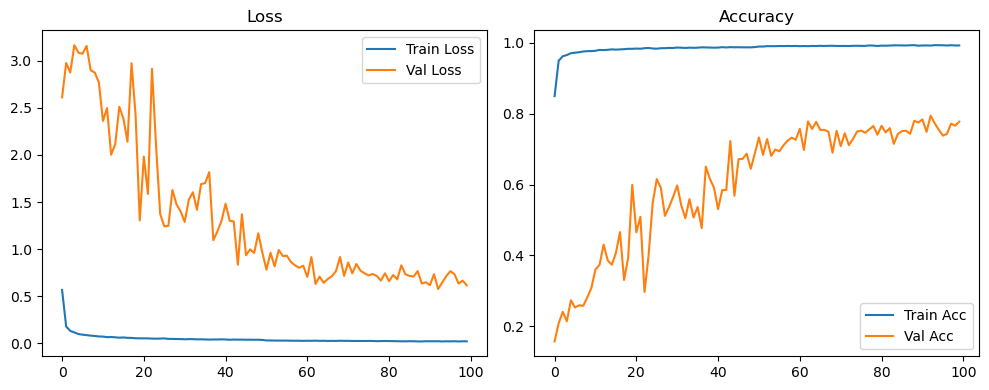

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.4382, Acc: 0.9602 | Val Loss: 0.3674, Acc: 0.9133


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0708, Acc: 0.9871 | Val Loss: 0.1151, Acc: 0.9748


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0420, Acc: 0.9910 | Val Loss: 0.0746, Acc: 0.9806


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0286, Acc: 0.9936 | Val Loss: 0.0925, Acc: 0.9731


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0210, Acc: 0.9953 | Val Loss: 0.0764, Acc: 0.9782


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0144, Acc: 0.9972 | Val Loss: 0.0902, Acc: 0.9706


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9968 | Val Loss: 0.0513, Acc: 0.9851


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9984 | Val Loss: 0.0634, Acc: 0.9818


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9987 | Val Loss: 0.0980, Acc: 0.9708


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9982 | Val Loss: 0.2042, Acc: 0.9364


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9983 | Val Loss: 0.0637, Acc: 0.9804


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9992 | Val Loss: 0.0469, Acc: 0.9865


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9984 | Val Loss: 0.0785, Acc: 0.9772


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9984 | Val Loss: 0.0509, Acc: 0.9855


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9995 | Val Loss: 0.0828, Acc: 0.9737


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9997 | Val Loss: 0.0428, Acc: 0.9896


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9992 | Val Loss: 0.1338, Acc: 0.9623


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 0.0980, Acc: 0.9723


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0371, Acc: 0.9891


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0546, Acc: 0.9849


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9995 | Val Loss: 0.0402, Acc: 0.9889


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0454, Acc: 0.9893


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0351, Acc: 0.9913


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0374, Acc: 0.9909


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1001, Acc: 0.9751


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9975 | Val Loss: 0.0420, Acc: 0.9884


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.0382, Acc: 0.9897


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9997 | Val Loss: 0.0383, Acc: 0.9901


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0362, Acc: 0.9912


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0353, Acc: 0.9911


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0351, Acc: 0.9918


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.3118, Acc: 0.9160


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.0455, Acc: 0.9888


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0386, Acc: 0.9901


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0367, Acc: 0.9908


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0355, Acc: 0.9912


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0353, Acc: 0.9916


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0397, Acc: 0.9903


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1264, Acc: 0.9635


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0503, Acc: 0.9882


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9998 | Val Loss: 0.0394, Acc: 0.9906


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0368, Acc: 0.9907


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0368, Acc: 0.9912


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0370, Acc: 0.9909


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0364, Acc: 0.9916


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0371, Acc: 0.9912


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0369, Acc: 0.9918


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0373, Acc: 0.9913


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0390, Acc: 0.9915


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9983 | Val Loss: 0.1952, Acc: 0.9493


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.0452, Acc: 0.9880


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0399, Acc: 0.9907


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0372, Acc: 0.9908


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0356, Acc: 0.9913


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0351, Acc: 0.9914


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0346, Acc: 0.9916


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0347, Acc: 0.9917


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0344, Acc: 0.9917


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0358, Acc: 0.9917


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0375, Acc: 0.9917


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0367, Acc: 0.9918


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0368, Acc: 0.9918


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0367, Acc: 0.9919


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0379, Acc: 0.9920


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0366, Acc: 0.9922


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0366, Acc: 0.9923


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0376, Acc: 0.9922


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.5385, Acc: 0.8757


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9963 | Val Loss: 0.0449, Acc: 0.9892


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9999 | Val Loss: 0.0454, Acc: 0.9885


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0440, Acc: 0.9891


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0405, Acc: 0.9908


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0408, Acc: 0.9909


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0408, Acc: 0.9908


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0410, Acc: 0.9909


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0409, Acc: 0.9910


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0406, Acc: 0.9905


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0404, Acc: 0.9912


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0403, Acc: 0.9914


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0407, Acc: 0.9911


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0404, Acc: 0.9912


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0404, Acc: 0.9914


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0422, Acc: 0.9911


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0410, Acc: 0.9912


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.1120, Acc: 0.9737


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.0636, Acc: 0.9845


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.0421, Acc: 0.9909


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0424, Acc: 0.9910


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0412, Acc: 0.9911


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0417, Acc: 0.9912


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0397, Acc: 0.9915


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0406, Acc: 0.9913


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0404, Acc: 0.9918


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0401, Acc: 0.9918


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0409, Acc: 0.9920


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0397, Acc: 0.9917


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0422, Acc: 0.9917


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0411, Acc: 0.9919


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0404, Acc: 0.9924


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0417, Acc: 0.9921


Final Test Loss: 0.0375 Accuracy: 0.9913


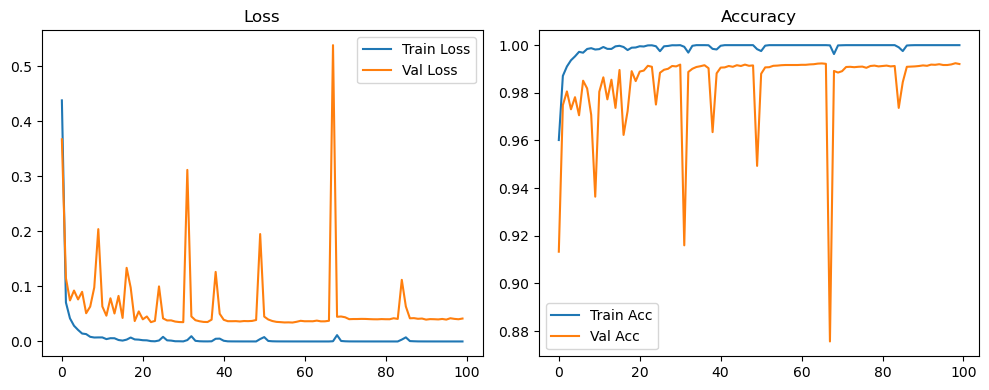

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.5275, Acc: 0.9342 | Val Loss: 0.6093, Acc: 0.8090


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1119, Acc: 0.9761 | Val Loss: 1.1681, Acc: 0.6113


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0746, Acc: 0.9809 | Val Loss: 1.2289, Acc: 0.5380


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0566, Acc: 0.9849 | Val Loss: 1.2717, Acc: 0.5913


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0493, Acc: 0.9859 | Val Loss: 1.4741, Acc: 0.5326


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0425, Acc: 0.9875 | Val Loss: 2.5492, Acc: 0.3061


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0370, Acc: 0.9891 | Val Loss: 1.6876, Acc: 0.4751


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0335, Acc: 0.9906 | Val Loss: 1.4704, Acc: 0.5719


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0315, Acc: 0.9902 | Val Loss: 1.4541, Acc: 0.5705


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0273, Acc: 0.9915 | Val Loss: 1.1564, Acc: 0.6407


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0252, Acc: 0.9924 | Val Loss: 1.4508, Acc: 0.6408


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0239, Acc: 0.9923 | Val Loss: 1.1373, Acc: 0.6532


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0228, Acc: 0.9929 | Val Loss: 1.0501, Acc: 0.6990


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0202, Acc: 0.9938 | Val Loss: 0.9075, Acc: 0.7381


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0191, Acc: 0.9939 | Val Loss: 1.3137, Acc: 0.6368


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0162, Acc: 0.9949 | Val Loss: 0.9846, Acc: 0.7310


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0165, Acc: 0.9944 | Val Loss: 0.7051, Acc: 0.8013


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0160, Acc: 0.9950 | Val Loss: 1.3149, Acc: 0.6690


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9952 | Val Loss: 0.7951, Acc: 0.7678


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0131, Acc: 0.9956 | Val Loss: 0.8265, Acc: 0.7650


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9953 | Val Loss: 0.5983, Acc: 0.8209


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9956 | Val Loss: 0.6380, Acc: 0.8086


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9971 | Val Loss: 0.7096, Acc: 0.7903


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.9220, Acc: 0.7450


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9958 | Val Loss: 0.5626, Acc: 0.8421


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9961 | Val Loss: 0.8923, Acc: 0.7630


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9963 | Val Loss: 0.4095, Acc: 0.8784


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9966 | Val Loss: 1.0713, Acc: 0.7339


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.7854, Acc: 0.7812


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 1.1694, Acc: 0.7145


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 1.0242, Acc: 0.7315


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.7314, Acc: 0.8002


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.5126, Acc: 0.8548


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9970 | Val Loss: 0.6284, Acc: 0.8291


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.9710, Acc: 0.7630


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.6288, Acc: 0.8368


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9971 | Val Loss: 0.5139, Acc: 0.8610


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.6406, Acc: 0.8387


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.4683, Acc: 0.8887


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.4358, Acc: 0.8829


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9976 | Val Loss: 0.4806, Acc: 0.8833


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.4431, Acc: 0.8838


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.5631, Acc: 0.8627


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.3545, Acc: 0.9122


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.3791, Acc: 0.9012


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.3512, Acc: 0.9126


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.2740, Acc: 0.9284


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9980 | Val Loss: 0.5219, Acc: 0.8709


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.3361, Acc: 0.9179


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.3981, Acc: 0.8978


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.4209, Acc: 0.8964


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.3153, Acc: 0.9233


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.3752, Acc: 0.9059


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.4419, Acc: 0.8878


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.4147, Acc: 0.8980


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.4899, Acc: 0.8823


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.6019, Acc: 0.8688


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.6062, Acc: 0.8710


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.4499, Acc: 0.8915


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.5007, Acc: 0.8788


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.4081, Acc: 0.9020


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.4744, Acc: 0.8892


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.4457, Acc: 0.8944


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.5599, Acc: 0.8706


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.4522, Acc: 0.8924


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.4269, Acc: 0.8988


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9983 | Val Loss: 0.3942, Acc: 0.9062


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.4641, Acc: 0.8959


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.4299, Acc: 0.8984


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.3874, Acc: 0.9131


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.3593, Acc: 0.9162


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.3506, Acc: 0.9168


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.4240, Acc: 0.8981


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.3453, Acc: 0.9173


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.3111, Acc: 0.9287


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9983 | Val Loss: 0.1879, Acc: 0.9557


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.2659, Acc: 0.9392


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.2777, Acc: 0.9381


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.2467, Acc: 0.9454


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.2207, Acc: 0.9499


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.2615, Acc: 0.9393


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.3386, Acc: 0.9233


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.2588, Acc: 0.9391


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.2697, Acc: 0.9391


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.2591, Acc: 0.9389


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.2501, Acc: 0.9401


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.3052, Acc: 0.9336


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.3252, Acc: 0.9276


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.2672, Acc: 0.9378


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.2125, Acc: 0.9535


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.2745, Acc: 0.9407


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.3400, Acc: 0.9233


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.2746, Acc: 0.9369


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.3537, Acc: 0.9213


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.3007, Acc: 0.9312


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.3083, Acc: 0.9306


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.3734, Acc: 0.9181


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.2677, Acc: 0.9397


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.3079, Acc: 0.9293


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.3310, Acc: 0.9263


Final Test Loss: 0.3364 Accuracy: 0.9259


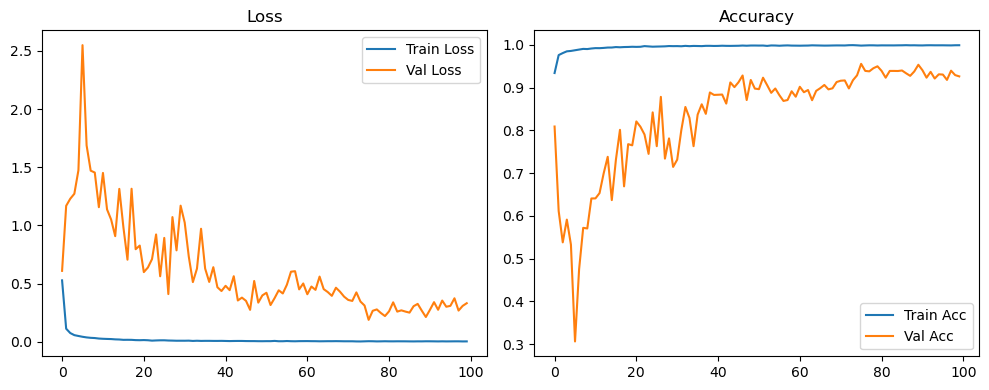

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.8449, Acc: 0.8015 | Val Loss: 2.7472, Acc: 0.1139


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.2760, Acc: 0.9302 | Val Loss: 2.8336, Acc: 0.2008


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1827, Acc: 0.9501 | Val Loss: 2.6398, Acc: 0.2164


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.1478, Acc: 0.9581 | Val Loss: 2.7248, Acc: 0.2361


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.1252, Acc: 0.9643 | Val Loss: 3.0138, Acc: 0.2379


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.1123, Acc: 0.9676 | Val Loss: 3.0135, Acc: 0.2587


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.1046, Acc: 0.9695 | Val Loss: 2.6671, Acc: 0.3036


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0972, Acc: 0.9715 | Val Loss: 3.0295, Acc: 0.2460


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0914, Acc: 0.9729 | Val Loss: 2.8777, Acc: 0.2733


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0841, Acc: 0.9749 | Val Loss: 2.7304, Acc: 0.3081


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0817, Acc: 0.9754 | Val Loss: 3.1824, Acc: 0.2536


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0776, Acc: 0.9764 | Val Loss: 3.2121, Acc: 0.2470


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0725, Acc: 0.9783 | Val Loss: 2.6974, Acc: 0.3378


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0697, Acc: 0.9793 | Val Loss: 2.8618, Acc: 0.3234


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0675, Acc: 0.9789 | Val Loss: 2.6360, Acc: 0.3598


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0673, Acc: 0.9801 | Val Loss: 2.5978, Acc: 0.3503


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0618, Acc: 0.9811 | Val Loss: 2.8137, Acc: 0.3438


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0632, Acc: 0.9811 | Val Loss: 2.7946, Acc: 0.3515


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0598, Acc: 0.9822 | Val Loss: 2.6704, Acc: 0.4092


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0598, Acc: 0.9819 | Val Loss: 2.0670, Acc: 0.4413


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0561, Acc: 0.9831 | Val Loss: 2.5371, Acc: 0.3599


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0558, Acc: 0.9829 | Val Loss: 2.2792, Acc: 0.4159


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0545, Acc: 0.9833 | Val Loss: 2.2267, Acc: 0.4554


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0525, Acc: 0.9843 | Val Loss: 2.4274, Acc: 0.3698


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0538, Acc: 0.9838 | Val Loss: 2.1776, Acc: 0.4113


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0545, Acc: 0.9831 | Val Loss: 1.9389, Acc: 0.4559


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0522, Acc: 0.9837 | Val Loss: 1.9757, Acc: 0.4683


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0477, Acc: 0.9848 | Val Loss: 2.2490, Acc: 0.4261


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0491, Acc: 0.9846 | Val Loss: 2.2693, Acc: 0.4348


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0468, Acc: 0.9857 | Val Loss: 1.9740, Acc: 0.4636


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0466, Acc: 0.9858 | Val Loss: 2.0020, Acc: 0.4661


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0480, Acc: 0.9846 | Val Loss: 1.6648, Acc: 0.5074


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0472, Acc: 0.9851 | Val Loss: 1.9981, Acc: 0.4502


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0442, Acc: 0.9855 | Val Loss: 1.4267, Acc: 0.5574


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0458, Acc: 0.9852 | Val Loss: 1.7186, Acc: 0.4846


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0445, Acc: 0.9859 | Val Loss: 1.9919, Acc: 0.4628


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0431, Acc: 0.9865 | Val Loss: 1.7407, Acc: 0.4660


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0431, Acc: 0.9866 | Val Loss: 1.6767, Acc: 0.5122


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0406, Acc: 0.9874 | Val Loss: 1.8114, Acc: 0.4916


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0448, Acc: 0.9865 | Val Loss: 1.5324, Acc: 0.5413


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0426, Acc: 0.9865 | Val Loss: 1.7251, Acc: 0.5077


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0400, Acc: 0.9872 | Val Loss: 1.6691, Acc: 0.5186


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0406, Acc: 0.9872 | Val Loss: 1.8697, Acc: 0.5017


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0398, Acc: 0.9876 | Val Loss: 1.4368, Acc: 0.5703


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0399, Acc: 0.9875 | Val Loss: 1.4738, Acc: 0.5678


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0408, Acc: 0.9869 | Val Loss: 1.4203, Acc: 0.5941


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0397, Acc: 0.9875 | Val Loss: 1.4133, Acc: 0.5643


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0406, Acc: 0.9870 | Val Loss: 1.3978, Acc: 0.5701


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0407, Acc: 0.9869 | Val Loss: 1.9664, Acc: 0.4773


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0392, Acc: 0.9871 | Val Loss: 1.6887, Acc: 0.5179


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0369, Acc: 0.9885 | Val Loss: 1.4527, Acc: 0.5703


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0361, Acc: 0.9887 | Val Loss: 1.8566, Acc: 0.5072


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0344, Acc: 0.9890 | Val Loss: 1.7714, Acc: 0.5142


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0359, Acc: 0.9886 | Val Loss: 1.5823, Acc: 0.5608


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0371, Acc: 0.9879 | Val Loss: 1.5918, Acc: 0.5529


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0362, Acc: 0.9879 | Val Loss: 1.8091, Acc: 0.5112


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0354, Acc: 0.9886 | Val Loss: 1.6105, Acc: 0.5495


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0344, Acc: 0.9889 | Val Loss: 1.5695, Acc: 0.5582


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0340, Acc: 0.9894 | Val Loss: 1.3188, Acc: 0.6179


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0336, Acc: 0.9893 | Val Loss: 1.2769, Acc: 0.6095


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0344, Acc: 0.9887 | Val Loss: 1.1230, Acc: 0.6577


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0336, Acc: 0.9893 | Val Loss: 1.6035, Acc: 0.5685


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0339, Acc: 0.9892 | Val Loss: 1.3542, Acc: 0.6096


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0332, Acc: 0.9896 | Val Loss: 1.3748, Acc: 0.6271


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0332, Acc: 0.9894 | Val Loss: 0.9668, Acc: 0.7007


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0329, Acc: 0.9893 | Val Loss: 1.2841, Acc: 0.5831


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0327, Acc: 0.9893 | Val Loss: 1.6253, Acc: 0.5433


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0336, Acc: 0.9891 | Val Loss: 1.5145, Acc: 0.5775


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0345, Acc: 0.9894 | Val Loss: 1.5887, Acc: 0.5575


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0312, Acc: 0.9900 | Val Loss: 1.2439, Acc: 0.6304


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0349, Acc: 0.9887 | Val Loss: 1.4632, Acc: 0.5853


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0315, Acc: 0.9899 | Val Loss: 1.6196, Acc: 0.5447


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0324, Acc: 0.9895 | Val Loss: 1.3485, Acc: 0.6168


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0307, Acc: 0.9896 | Val Loss: 1.1975, Acc: 0.6421


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0319, Acc: 0.9900 | Val Loss: 1.1996, Acc: 0.6442


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0321, Acc: 0.9897 | Val Loss: 1.3551, Acc: 0.6038


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0312, Acc: 0.9899 | Val Loss: 1.2320, Acc: 0.6495


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0281, Acc: 0.9904 | Val Loss: 1.1486, Acc: 0.6492


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0307, Acc: 0.9897 | Val Loss: 1.1089, Acc: 0.6684


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0317, Acc: 0.9898 | Val Loss: 1.3240, Acc: 0.6027


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0299, Acc: 0.9901 | Val Loss: 1.0819, Acc: 0.6463


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0318, Acc: 0.9896 | Val Loss: 1.1597, Acc: 0.6358


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0297, Acc: 0.9902 | Val Loss: 1.0665, Acc: 0.6532


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0292, Acc: 0.9905 | Val Loss: 0.9993, Acc: 0.6731


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0294, Acc: 0.9903 | Val Loss: 1.0158, Acc: 0.6846


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0308, Acc: 0.9898 | Val Loss: 1.3379, Acc: 0.6102


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0291, Acc: 0.9903 | Val Loss: 1.2998, Acc: 0.6282


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0262, Acc: 0.9909 | Val Loss: 1.2476, Acc: 0.6192


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0285, Acc: 0.9908 | Val Loss: 1.1206, Acc: 0.6538


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0310, Acc: 0.9895 | Val Loss: 1.2800, Acc: 0.6164


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0286, Acc: 0.9902 | Val Loss: 1.0526, Acc: 0.6668


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0278, Acc: 0.9913 | Val Loss: 1.2588, Acc: 0.6287


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0283, Acc: 0.9909 | Val Loss: 0.9814, Acc: 0.6973


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0267, Acc: 0.9912 | Val Loss: 0.7845, Acc: 0.7533


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0300, Acc: 0.9900 | Val Loss: 1.1946, Acc: 0.6244


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0294, Acc: 0.9904 | Val Loss: 1.2553, Acc: 0.6152


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0286, Acc: 0.9909 | Val Loss: 0.9656, Acc: 0.6723


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0275, Acc: 0.9907 | Val Loss: 0.9041, Acc: 0.6989


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0268, Acc: 0.9910 | Val Loss: 0.9947, Acc: 0.6847


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0265, Acc: 0.9917 | Val Loss: 0.8076, Acc: 0.7309


Final Test Loss: 0.7707 Accuracy: 0.7356


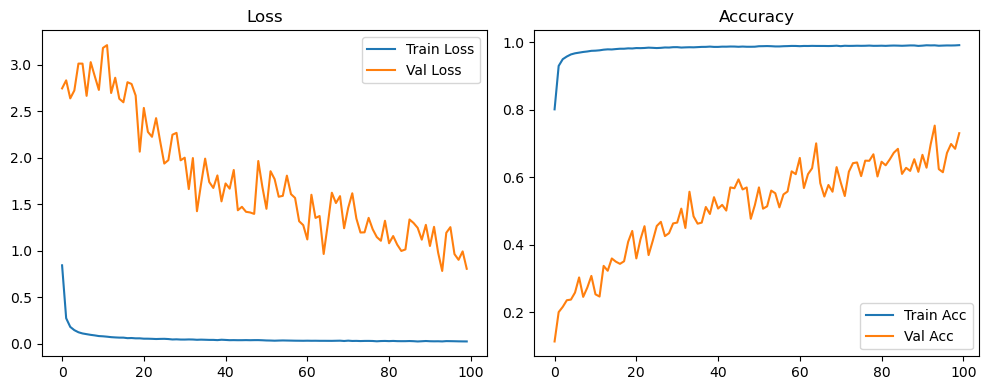

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.6722, Acc: 0.9554 | Val Loss: 0.2995, Acc: 0.9629


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1285, Acc: 0.9858 | Val Loss: 0.1322, Acc: 0.9797


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0669, Acc: 0.9902 | Val Loss: 0.1217, Acc: 0.9758


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0427, Acc: 0.9930 | Val Loss: 0.2497, Acc: 0.9243


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0311, Acc: 0.9945 | Val Loss: 0.0552, Acc: 0.9855


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0229, Acc: 0.9962 | Val Loss: 0.3071, Acc: 0.9041


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0175, Acc: 0.9974 | Val Loss: 0.1089, Acc: 0.9663


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9987 | Val Loss: 0.0495, Acc: 0.9850


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9985 | Val Loss: 0.0715, Acc: 0.9806


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9992 | Val Loss: 0.0724, Acc: 0.9773


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9994 | Val Loss: 0.2078, Acc: 0.9353


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9986 | Val Loss: 0.0579, Acc: 0.9828


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9987 | Val Loss: 0.0446, Acc: 0.9854


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9999 | Val Loss: 0.0498, Acc: 0.9858


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9992 | Val Loss: 0.2008, Acc: 0.9384


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9994 | Val Loss: 0.5292, Acc: 0.8387


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9981 | Val Loss: 0.0644, Acc: 0.9805


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9997 | Val Loss: 0.0598, Acc: 0.9846


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9992 | Val Loss: 0.0679, Acc: 0.9793


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9991 | Val Loss: 0.0529, Acc: 0.9856


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 1.0000 | Val Loss: 0.0307, Acc: 0.9910


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9999 | Val Loss: 0.0348, Acc: 0.9896


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 1.0000 | Val Loss: 0.0301, Acc: 0.9917


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0303, Acc: 0.9922


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0299, Acc: 0.9914


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0298, Acc: 0.9918


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0305, Acc: 0.9918


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0306, Acc: 0.9918


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0306, Acc: 0.9914


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0340, Acc: 0.9912


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0334, Acc: 0.9913


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0330, Acc: 0.9911


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0327, Acc: 0.9911


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0366, Acc: 0.9911


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0355, Acc: 0.9912


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0332, Acc: 0.9923


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0339, Acc: 0.9916


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0199, Acc: 0.9936 | Val Loss: 0.2326, Acc: 0.9293


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9976 | Val Loss: 0.0457, Acc: 0.9862


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9996 | Val Loss: 0.0405, Acc: 0.9893


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9999 | Val Loss: 0.0351, Acc: 0.9903


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0328, Acc: 0.9910


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0333, Acc: 0.9909


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0353, Acc: 0.9908


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0340, Acc: 0.9917


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0337, Acc: 0.9914


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0329, Acc: 0.9912


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0362, Acc: 0.9906


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0345, Acc: 0.9914


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0351, Acc: 0.9912


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0340, Acc: 0.9912


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0333, Acc: 0.9918


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0340, Acc: 0.9914


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0350, Acc: 0.9917


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0350, Acc: 0.9916


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0350, Acc: 0.9910


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0347, Acc: 0.9917


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0350, Acc: 0.9917


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0379, Acc: 0.9912


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 1.6568, Acc: 0.6443


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0171, Acc: 0.9947 | Val Loss: 0.0478, Acc: 0.9863


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0427, Acc: 0.9897


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 1.0000 | Val Loss: 0.0359, Acc: 0.9908


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0368, Acc: 0.9903


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0360, Acc: 0.9913


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0345, Acc: 0.9918


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0346, Acc: 0.9918


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0348, Acc: 0.9915


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0357, Acc: 0.9918


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0353, Acc: 0.9918


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0375, Acc: 0.9912


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0358, Acc: 0.9910


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0360, Acc: 0.9912


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0357, Acc: 0.9912


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1613, Acc: 0.9553


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.0485, Acc: 0.9880


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0395, Acc: 0.9904


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0356, Acc: 0.9918


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0351, Acc: 0.9916


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0358, Acc: 0.9913


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0364, Acc: 0.9912


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0361, Acc: 0.9915


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0365, Acc: 0.9916


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0362, Acc: 0.9917


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0366, Acc: 0.9918


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0369, Acc: 0.9922


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0364, Acc: 0.9918


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0387, Acc: 0.9915


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0376, Acc: 0.9917


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0383, Acc: 0.9918


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0375, Acc: 0.9918


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9981 | Val Loss: 0.0740, Acc: 0.9832


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.0412, Acc: 0.9896


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 1.0000 | Val Loss: 0.0370, Acc: 0.9909


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0370, Acc: 0.9908


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0389, Acc: 0.9903


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0382, Acc: 0.9913


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0379, Acc: 0.9908


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0377, Acc: 0.9913


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0385, Acc: 0.9911


Final Test Loss: 0.0314 Accuracy: 0.9920


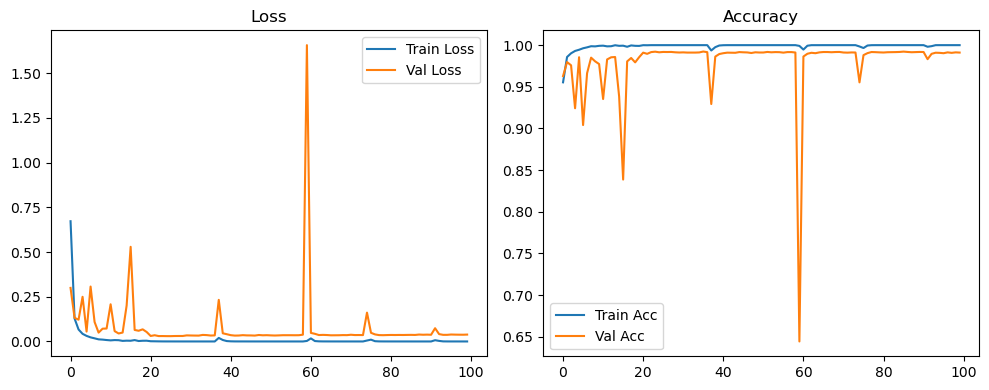

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.7816, Acc: 0.9226 | Val Loss: 1.0186, Acc: 0.6024


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1935, Acc: 0.9722 | Val Loss: 0.9944, Acc: 0.6381


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1112, Acc: 0.9788 | Val Loss: 1.1052, Acc: 0.5493


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0788, Acc: 0.9834 | Val Loss: 1.4143, Acc: 0.5088


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0652, Acc: 0.9848 | Val Loss: 1.5045, Acc: 0.4698


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0552, Acc: 0.9863 | Val Loss: 1.8538, Acc: 0.3972


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0469, Acc: 0.9880 | Val Loss: 1.9925, Acc: 0.3752


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0427, Acc: 0.9883 | Val Loss: 1.6947, Acc: 0.4553


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0381, Acc: 0.9897 | Val Loss: 1.4593, Acc: 0.5172


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0341, Acc: 0.9905 | Val Loss: 1.9026, Acc: 0.4426


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0315, Acc: 0.9908 | Val Loss: 1.6150, Acc: 0.5593


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0297, Acc: 0.9914 | Val Loss: 1.2744, Acc: 0.5859


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0284, Acc: 0.9918 | Val Loss: 1.3554, Acc: 0.5949


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0245, Acc: 0.9924 | Val Loss: 1.8415, Acc: 0.5455


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0235, Acc: 0.9927 | Val Loss: 1.7613, Acc: 0.5768


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0202, Acc: 0.9941 | Val Loss: 1.3630, Acc: 0.6559


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0216, Acc: 0.9932 | Val Loss: 0.9444, Acc: 0.7053


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0195, Acc: 0.9940 | Val Loss: 1.4217, Acc: 0.6272


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0164, Acc: 0.9948 | Val Loss: 1.3830, Acc: 0.5917


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0162, Acc: 0.9950 | Val Loss: 1.3319, Acc: 0.6522


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0168, Acc: 0.9946 | Val Loss: 1.3193, Acc: 0.6249


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0157, Acc: 0.9948 | Val Loss: 1.2412, Acc: 0.6320


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0136, Acc: 0.9959 | Val Loss: 1.0188, Acc: 0.7027


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0133, Acc: 0.9959 | Val Loss: 1.4638, Acc: 0.6085


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0125, Acc: 0.9961 | Val Loss: 1.1237, Acc: 0.6879


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0133, Acc: 0.9956 | Val Loss: 1.5559, Acc: 0.6025


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 1.1065, Acc: 0.6879


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9969 | Val Loss: 1.3118, Acc: 0.6708


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 1.1708, Acc: 0.6855


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9967 | Val Loss: 1.8507, Acc: 0.5924


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 1.8350, Acc: 0.5615


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9963 | Val Loss: 1.7154, Acc: 0.6065


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.8924, Acc: 0.7437


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.7253, Acc: 0.7813


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 1.5339, Acc: 0.6342


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 1.1195, Acc: 0.7080


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.7811, Acc: 0.7803


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 1.0698, Acc: 0.7238


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.5649, Acc: 0.8428


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9973 | Val Loss: 0.6300, Acc: 0.8255


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.7659, Acc: 0.7949


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.8090, Acc: 0.7768


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9978 | Val Loss: 0.8578, Acc: 0.7758


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.7107, Acc: 0.8123


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.5190, Acc: 0.8526


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.5446, Acc: 0.8502


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.5694, Acc: 0.8413


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.6205, Acc: 0.8195


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.5348, Acc: 0.8596


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.6470, Acc: 0.8213


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.6968, Acc: 0.8273


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.4958, Acc: 0.8693


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9984 | Val Loss: 0.7799, Acc: 0.8068


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.6066, Acc: 0.8442


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.6039, Acc: 0.8374


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9985 | Val Loss: 0.7090, Acc: 0.8217


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.6873, Acc: 0.8271


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.7721, Acc: 0.8010


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.8823, Acc: 0.7763


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.6739, Acc: 0.8234


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9981 | Val Loss: 0.8305, Acc: 0.8000


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.4930, Acc: 0.8674


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.6234, Acc: 0.8403


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.8541, Acc: 0.7975


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.4896, Acc: 0.8708


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.5349, Acc: 0.8612


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.3953, Acc: 0.8985


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.4267, Acc: 0.8921


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.6521, Acc: 0.8360


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.5477, Acc: 0.8613


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.7025, Acc: 0.8307


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.6628, Acc: 0.8324


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.5444, Acc: 0.8649


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.6226, Acc: 0.8376


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.6459, Acc: 0.8344


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.5924, Acc: 0.8474


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.6965, Acc: 0.8252


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.6669, Acc: 0.8292


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.5123, Acc: 0.8680


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.4997, Acc: 0.8755


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.4340, Acc: 0.8901


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.5828, Acc: 0.8561


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.4419, Acc: 0.8846


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.5812, Acc: 0.8585


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.5480, Acc: 0.8701


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.4888, Acc: 0.8714


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.4443, Acc: 0.8853


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.4370, Acc: 0.8859


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.6230, Acc: 0.8518


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.5144, Acc: 0.8753


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.6439, Acc: 0.8383


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.6084, Acc: 0.8490


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.4188, Acc: 0.8912


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.7053, Acc: 0.8308


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.5919, Acc: 0.8460


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.6539, Acc: 0.8454


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.5340, Acc: 0.8652


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.3890, Acc: 0.9030


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.3852, Acc: 0.9035


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.5224, Acc: 0.8748


Final Test Loss: 0.5098 Accuracy: 0.8783


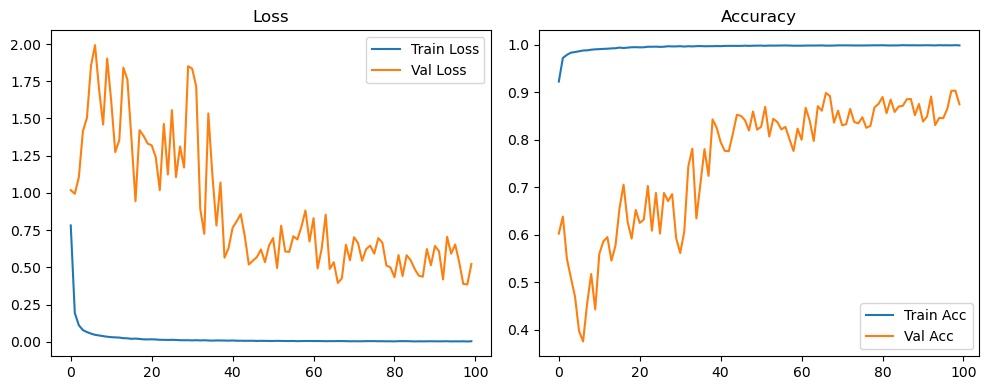

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 1.1331, Acc: 0.7484 | Val Loss: 2.6639, Acc: 0.1133


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.4561, Acc: 0.9008 | Val Loss: 2.8736, Acc: 0.1418


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.2825, Acc: 0.9314 | Val Loss: 2.5633, Acc: 0.2129


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.2134, Acc: 0.9447 | Val Loss: 2.7308, Acc: 0.2144


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.1754, Acc: 0.9537 | Val Loss: 2.8309, Acc: 0.2375


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.1520, Acc: 0.9581 | Val Loss: 2.7703, Acc: 0.2692


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.1371, Acc: 0.9613 | Val Loss: 2.7187, Acc: 0.2677


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.1246, Acc: 0.9645 | Val Loss: 2.8575, Acc: 0.2511


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.1158, Acc: 0.9666 | Val Loss: 2.9840, Acc: 0.2575


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.1050, Acc: 0.9695 | Val Loss: 2.7695, Acc: 0.2645


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.1011, Acc: 0.9710 | Val Loss: 2.9433, Acc: 0.2580


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0957, Acc: 0.9720 | Val Loss: 3.1698, Acc: 0.2450


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0895, Acc: 0.9736 | Val Loss: 2.9293, Acc: 0.2747


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0868, Acc: 0.9740 | Val Loss: 3.2024, Acc: 0.2525


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0829, Acc: 0.9746 | Val Loss: 3.0585, Acc: 0.2671


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0787, Acc: 0.9763 | Val Loss: 3.0756, Acc: 0.2756


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0756, Acc: 0.9779 | Val Loss: 2.9678, Acc: 0.2807


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0745, Acc: 0.9781 | Val Loss: 3.1867, Acc: 0.2611


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0708, Acc: 0.9791 | Val Loss: 3.0636, Acc: 0.2975


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0705, Acc: 0.9787 | Val Loss: 2.9653, Acc: 0.2818


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0656, Acc: 0.9808 | Val Loss: 3.1240, Acc: 0.2737


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0656, Acc: 0.9801 | Val Loss: 2.8394, Acc: 0.2930


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0629, Acc: 0.9814 | Val Loss: 2.7265, Acc: 0.3084


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0637, Acc: 0.9808 | Val Loss: 3.1140, Acc: 0.2699


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0620, Acc: 0.9817 | Val Loss: 2.9544, Acc: 0.2943


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0617, Acc: 0.9822 | Val Loss: 2.6998, Acc: 0.3094


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0597, Acc: 0.9816 | Val Loss: 2.6685, Acc: 0.3325


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0565, Acc: 0.9831 | Val Loss: 2.7230, Acc: 0.2953


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0564, Acc: 0.9831 | Val Loss: 2.6484, Acc: 0.3520


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0547, Acc: 0.9832 | Val Loss: 2.5430, Acc: 0.3628


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0533, Acc: 0.9837 | Val Loss: 2.6246, Acc: 0.3282


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0536, Acc: 0.9834 | Val Loss: 2.5398, Acc: 0.3392


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0543, Acc: 0.9834 | Val Loss: 2.7151, Acc: 0.3096


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0515, Acc: 0.9834 | Val Loss: 2.6352, Acc: 0.3372


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0518, Acc: 0.9839 | Val Loss: 2.6346, Acc: 0.3373


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0503, Acc: 0.9849 | Val Loss: 2.7731, Acc: 0.3414


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0479, Acc: 0.9854 | Val Loss: 2.5564, Acc: 0.3468


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0495, Acc: 0.9845 | Val Loss: 2.6214, Acc: 0.3362


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0472, Acc: 0.9858 | Val Loss: 2.8492, Acc: 0.3273


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0488, Acc: 0.9852 | Val Loss: 2.6793, Acc: 0.3380


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0486, Acc: 0.9847 | Val Loss: 2.8352, Acc: 0.3379


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0462, Acc: 0.9853 | Val Loss: 2.7229, Acc: 0.3243


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0464, Acc: 0.9854 | Val Loss: 2.5815, Acc: 0.3770


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0460, Acc: 0.9860 | Val Loss: 2.3729, Acc: 0.3938


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0444, Acc: 0.9868 | Val Loss: 2.7051, Acc: 0.3469


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0474, Acc: 0.9854 | Val Loss: 2.4574, Acc: 0.3667


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0434, Acc: 0.9862 | Val Loss: 2.6098, Acc: 0.3453


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0449, Acc: 0.9865 | Val Loss: 2.5901, Acc: 0.3743


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0434, Acc: 0.9866 | Val Loss: 2.9935, Acc: 0.3113


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0416, Acc: 0.9871 | Val Loss: 2.7074, Acc: 0.3761


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0425, Acc: 0.9859 | Val Loss: 2.5464, Acc: 0.3609


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0416, Acc: 0.9870 | Val Loss: 3.0437, Acc: 0.3062


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0402, Acc: 0.9874 | Val Loss: 2.8682, Acc: 0.3382


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0402, Acc: 0.9876 | Val Loss: 2.6728, Acc: 0.3828


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0408, Acc: 0.9871 | Val Loss: 2.8457, Acc: 0.3361


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0397, Acc: 0.9872 | Val Loss: 2.7730, Acc: 0.3612


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0393, Acc: 0.9881 | Val Loss: 2.8575, Acc: 0.3497


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0382, Acc: 0.9884 | Val Loss: 2.7434, Acc: 0.3688


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0381, Acc: 0.9881 | Val Loss: 2.4460, Acc: 0.4153


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0385, Acc: 0.9882 | Val Loss: 2.1913, Acc: 0.4537


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0386, Acc: 0.9874 | Val Loss: 1.9319, Acc: 0.4873


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0375, Acc: 0.9879 | Val Loss: 2.5631, Acc: 0.4196


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0387, Acc: 0.9880 | Val Loss: 2.3702, Acc: 0.4153


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0360, Acc: 0.9886 | Val Loss: 2.3787, Acc: 0.4348


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0378, Acc: 0.9880 | Val Loss: 1.8878, Acc: 0.4957


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0367, Acc: 0.9885 | Val Loss: 1.8292, Acc: 0.5112


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0358, Acc: 0.9881 | Val Loss: 2.3647, Acc: 0.4134


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0369, Acc: 0.9887 | Val Loss: 2.4239, Acc: 0.4118


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0389, Acc: 0.9881 | Val Loss: 2.8185, Acc: 0.3738


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0351, Acc: 0.9889 | Val Loss: 1.9610, Acc: 0.4893


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0371, Acc: 0.9882 | Val Loss: 2.5282, Acc: 0.4214


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0354, Acc: 0.9888 | Val Loss: 2.1801, Acc: 0.4424


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0351, Acc: 0.9886 | Val Loss: 1.8215, Acc: 0.4995


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0345, Acc: 0.9891 | Val Loss: 1.8105, Acc: 0.5080


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0350, Acc: 0.9888 | Val Loss: 1.7617, Acc: 0.5182


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0347, Acc: 0.9886 | Val Loss: 1.9839, Acc: 0.4894


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0357, Acc: 0.9887 | Val Loss: 2.1167, Acc: 0.4617


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0320, Acc: 0.9898 | Val Loss: 1.9712, Acc: 0.4952


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0346, Acc: 0.9887 | Val Loss: 2.1500, Acc: 0.4593


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0339, Acc: 0.9895 | Val Loss: 2.1347, Acc: 0.4584


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0310, Acc: 0.9902 | Val Loss: 1.5658, Acc: 0.5384


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0339, Acc: 0.9894 | Val Loss: 1.9890, Acc: 0.4884


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0316, Acc: 0.9899 | Val Loss: 1.5394, Acc: 0.5589


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0335, Acc: 0.9892 | Val Loss: 2.0213, Acc: 0.4790


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0321, Acc: 0.9899 | Val Loss: 2.0208, Acc: 0.4847


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0345, Acc: 0.9892 | Val Loss: 1.6506, Acc: 0.5351


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0298, Acc: 0.9904 | Val Loss: 1.9502, Acc: 0.4911


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0306, Acc: 0.9899 | Val Loss: 1.8788, Acc: 0.4869


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0311, Acc: 0.9899 | Val Loss: 1.8635, Acc: 0.5131


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0329, Acc: 0.9892 | Val Loss: 1.5301, Acc: 0.5813


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0326, Acc: 0.9896 | Val Loss: 1.5618, Acc: 0.5770


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0307, Acc: 0.9899 | Val Loss: 2.2059, Acc: 0.4883


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0304, Acc: 0.9905 | Val Loss: 1.5704, Acc: 0.5714


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0308, Acc: 0.9902 | Val Loss: 2.1026, Acc: 0.4980


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0314, Acc: 0.9901 | Val Loss: 2.0767, Acc: 0.5062


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0292, Acc: 0.9900 | Val Loss: 2.2785, Acc: 0.4618


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0305, Acc: 0.9904 | Val Loss: 2.0707, Acc: 0.5131


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0292, Acc: 0.9906 | Val Loss: 1.5806, Acc: 0.5732


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0291, Acc: 0.9901 | Val Loss: 1.8233, Acc: 0.5476


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0297, Acc: 0.9902 | Val Loss: 1.5912, Acc: 0.5720


Final Test Loss: 1.5580 Accuracy: 0.5741


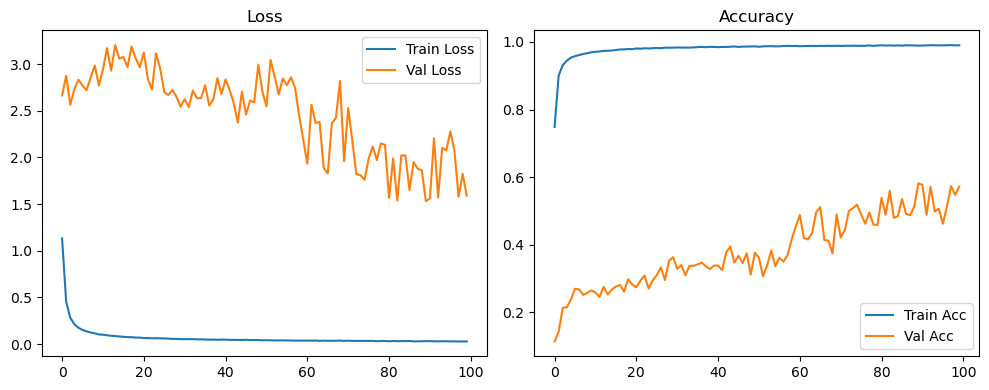

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2837, Acc: 0.9471 | Val Loss: 0.2084, Acc: 0.9367


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0516, Acc: 0.9852 | Val Loss: 0.1070, Acc: 0.9688


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0344, Acc: 0.9897 | Val Loss: 0.0858, Acc: 0.9731


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9929 | Val Loss: 0.0811, Acc: 0.9720


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9945 | Val Loss: 0.1475, Acc: 0.9543


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9964 | Val Loss: 0.0618, Acc: 0.9823


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9976 | Val Loss: 0.0423, Acc: 0.9868


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9983 | Val Loss: 0.0543, Acc: 0.9846


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9983 | Val Loss: 0.1769, Acc: 0.9448


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 0.0516, Acc: 0.9866


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9981 | Val Loss: 0.2393, Acc: 0.9353


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.0694, Acc: 0.9822


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1818, Acc: 0.9526


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.0500, Acc: 0.9871


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1478, Acc: 0.9582


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0641, Acc: 0.9831


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0548, Acc: 0.9861


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0594, Acc: 0.9860


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.0447, Acc: 0.9888


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0490, Acc: 0.9878


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.0480, Acc: 0.9878


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0390, Acc: 0.9902


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0358, Acc: 0.9899


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0348, Acc: 0.9913


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0338, Acc: 0.9913


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0346, Acc: 0.9912


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0342, Acc: 0.9911


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0342, Acc: 0.9912


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0341, Acc: 0.9913


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.7403, Acc: 0.8306


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9935 | Val Loss: 0.0712, Acc: 0.9827


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0475, Acc: 0.9879


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0364, Acc: 0.9907


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0358, Acc: 0.9910


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0350, Acc: 0.9914


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0336, Acc: 0.9918


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0340, Acc: 0.9918


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0338, Acc: 0.9919


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0341, Acc: 0.9920


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0341, Acc: 0.9918


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0342, Acc: 0.9918


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0339, Acc: 0.9921


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0338, Acc: 0.9920


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0339, Acc: 0.9920


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0343, Acc: 0.9918


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0344, Acc: 0.9919


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0344, Acc: 0.9919


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0347, Acc: 0.9922


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0350, Acc: 0.9925


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0355, Acc: 0.9923


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0350, Acc: 0.9922


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0345, Acc: 0.9924


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0357, Acc: 0.9922


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0353, Acc: 0.9922


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0355, Acc: 0.9924


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0357, Acc: 0.9922


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0358, Acc: 0.9923


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0358, Acc: 0.9925


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0372, Acc: 0.9921


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0371, Acc: 0.9919


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0371, Acc: 0.9922


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9987 | Val Loss: 2.0440, Acc: 0.6864


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9900 | Val Loss: 0.0579, Acc: 0.9853


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.0463, Acc: 0.9891


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0401, Acc: 0.9904


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0379, Acc: 0.9911


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0381, Acc: 0.9916


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0369, Acc: 0.9911


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0379, Acc: 0.9913


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0375, Acc: 0.9913


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0372, Acc: 0.9915


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0373, Acc: 0.9915


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0378, Acc: 0.9918


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0374, Acc: 0.9918


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0376, Acc: 0.9918


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0381, Acc: 0.9915


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0376, Acc: 0.9918


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0380, Acc: 0.9920


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0379, Acc: 0.9921


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0383, Acc: 0.9918


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0383, Acc: 0.9922


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0384, Acc: 0.9921


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0386, Acc: 0.9918


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0392, Acc: 0.9919


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0386, Acc: 0.9919


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0387, Acc: 0.9921


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0395, Acc: 0.9922


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0403, Acc: 0.9922


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0391, Acc: 0.9920


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0396, Acc: 0.9919


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0395, Acc: 0.9920


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0396, Acc: 0.9923


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0396, Acc: 0.9925


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0396, Acc: 0.9921


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0398, Acc: 0.9921


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0399, Acc: 0.9925


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0406, Acc: 0.9924


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0394, Acc: 0.9924


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0405, Acc: 0.9926


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0403, Acc: 0.9925


Final Test Loss: 0.0422 Accuracy: 0.9909


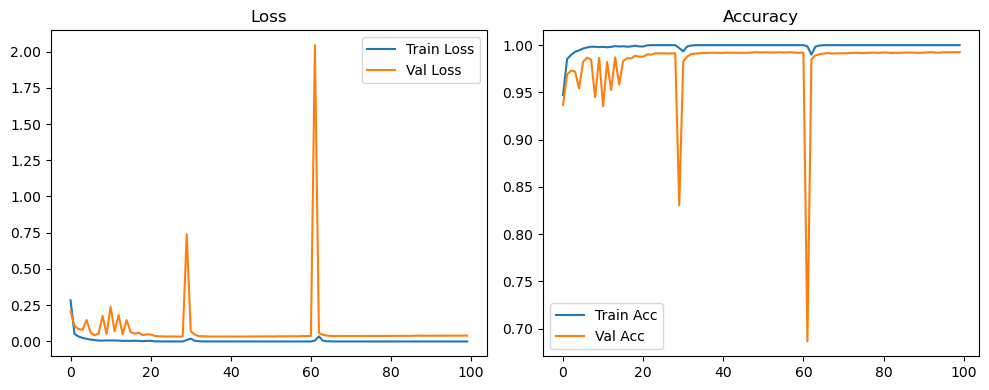

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3547, Acc: 0.9228 | Val Loss: 1.3561, Acc: 0.5772


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0785, Acc: 0.9782 | Val Loss: 0.8382, Acc: 0.7277


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0609, Acc: 0.9816 | Val Loss: 0.5180, Acc: 0.8361


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0499, Acc: 0.9848 | Val Loss: 0.8590, Acc: 0.6998


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0401, Acc: 0.9873 | Val Loss: 1.0617, Acc: 0.6638


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0328, Acc: 0.9892 | Val Loss: 0.5733, Acc: 0.8186


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9901 | Val Loss: 0.4524, Acc: 0.8723


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0286, Acc: 0.9909 | Val Loss: 0.8327, Acc: 0.7588


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9922 | Val Loss: 0.6232, Acc: 0.8051


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9926 | Val Loss: 0.3213, Acc: 0.8960


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9929 | Val Loss: 0.1890, Acc: 0.9400


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9939 | Val Loss: 0.4113, Acc: 0.8672


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9941 | Val Loss: 0.4766, Acc: 0.8538


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9947 | Val Loss: 0.2870, Acc: 0.9117


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9945 | Val Loss: 0.3060, Acc: 0.9096


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9954 | Val Loss: 0.2444, Acc: 0.9286


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9962 | Val Loss: 0.2935, Acc: 0.9162


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9955 | Val Loss: 0.2031, Acc: 0.9363


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.1910, Acc: 0.9453


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9959 | Val Loss: 0.1783, Acc: 0.9480


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9961 | Val Loss: 0.2063, Acc: 0.9401


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.1543, Acc: 0.9570


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9962 | Val Loss: 0.2386, Acc: 0.9368


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.3754, Acc: 0.9018


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.1357, Acc: 0.9624


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.2280, Acc: 0.9398


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9961 | Val Loss: 0.2833, Acc: 0.9250


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9964 | Val Loss: 0.1446, Acc: 0.9599


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.2431, Acc: 0.9376


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9970 | Val Loss: 0.1626, Acc: 0.9578


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9973 | Val Loss: 0.2206, Acc: 0.9431


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9967 | Val Loss: 0.1260, Acc: 0.9669


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.1399, Acc: 0.9652


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.2644, Acc: 0.9349


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.1517, Acc: 0.9620


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9975 | Val Loss: 0.1671, Acc: 0.9578


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9975 | Val Loss: 0.2121, Acc: 0.9497


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9973 | Val Loss: 0.1184, Acc: 0.9706


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.2087, Acc: 0.9498


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.1941, Acc: 0.9522


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9973 | Val Loss: 0.1356, Acc: 0.9676


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1447, Acc: 0.9647


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.2519, Acc: 0.9415


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.1950, Acc: 0.9565


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9979 | Val Loss: 0.1888, Acc: 0.9582


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9984 | Val Loss: 0.1621, Acc: 0.9627


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1725, Acc: 0.9613


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.2382, Acc: 0.9471


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1932, Acc: 0.9574


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1913, Acc: 0.9578


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.2530, Acc: 0.9496


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1698, Acc: 0.9624


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1656, Acc: 0.9628


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.1477, Acc: 0.9664


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.1848, Acc: 0.9619


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1588, Acc: 0.9650


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.2020, Acc: 0.9572


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1655, Acc: 0.9657


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9980 | Val Loss: 0.2059, Acc: 0.9584


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1696, Acc: 0.9627


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1540, Acc: 0.9657


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1595, Acc: 0.9674


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.2253, Acc: 0.9557


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.2372, Acc: 0.9508


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9981 | Val Loss: 0.1503, Acc: 0.9706


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.1214, Acc: 0.9759


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9984 | Val Loss: 0.1700, Acc: 0.9650


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.1997, Acc: 0.9603


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9983 | Val Loss: 0.3143, Acc: 0.9377


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1840, Acc: 0.9640


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1935, Acc: 0.9633


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1452, Acc: 0.9700


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.2042, Acc: 0.9604


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.2010, Acc: 0.9582


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1963, Acc: 0.9624


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.2540, Acc: 0.9505


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9985 | Val Loss: 0.2574, Acc: 0.9506


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1616, Acc: 0.9691


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9985 | Val Loss: 0.2064, Acc: 0.9607


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.2061, Acc: 0.9615


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1890, Acc: 0.9603


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.1685, Acc: 0.9663


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.1504, Acc: 0.9712


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.2204, Acc: 0.9591


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.2195, Acc: 0.9579


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1985, Acc: 0.9634


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1779, Acc: 0.9638


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1815, Acc: 0.9654


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.1589, Acc: 0.9690


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1546, Acc: 0.9689


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1421, Acc: 0.9730


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1548, Acc: 0.9707


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1402, Acc: 0.9732


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.1786, Acc: 0.9653


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1728, Acc: 0.9665


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.2160, Acc: 0.9616


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.2469, Acc: 0.9554


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.2718, Acc: 0.9515


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1771, Acc: 0.9665


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1729, Acc: 0.9690


Final Test Loss: 0.1745 Accuracy: 0.9673


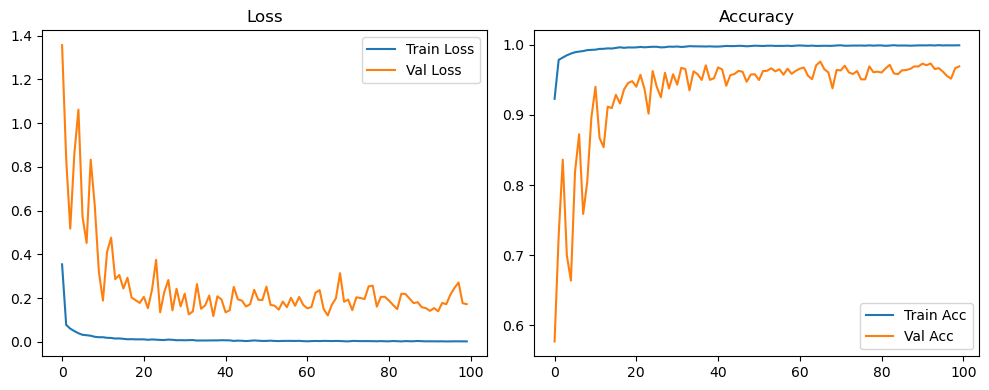

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6023, Acc: 0.8285 | Val Loss: 2.2119, Acc: 0.2531


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1714, Acc: 0.9512 | Val Loss: 1.9437, Acc: 0.3469


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1295, Acc: 0.9618 | Val Loss: 1.6967, Acc: 0.3782


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1055, Acc: 0.9688 | Val Loss: 2.1534, Acc: 0.3952


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0967, Acc: 0.9719 | Val Loss: 1.4929, Acc: 0.4805


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0831, Acc: 0.9747 | Val Loss: 1.3002, Acc: 0.5707


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0761, Acc: 0.9773 | Val Loss: 1.6260, Acc: 0.5129


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0731, Acc: 0.9774 | Val Loss: 1.2610, Acc: 0.6014


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0683, Acc: 0.9790 | Val Loss: 1.4242, Acc: 0.5534


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0682, Acc: 0.9791 | Val Loss: 1.3581, Acc: 0.5749


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0653, Acc: 0.9806 | Val Loss: 1.5891, Acc: 0.5199


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0607, Acc: 0.9812 | Val Loss: 1.1978, Acc: 0.6256


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0597, Acc: 0.9823 | Val Loss: 0.8098, Acc: 0.7353


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0591, Acc: 0.9816 | Val Loss: 0.9891, Acc: 0.7032


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0543, Acc: 0.9830 | Val Loss: 1.0530, Acc: 0.6685


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0547, Acc: 0.9830 | Val Loss: 1.0967, Acc: 0.6683


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0512, Acc: 0.9844 | Val Loss: 0.9969, Acc: 0.7054


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0514, Acc: 0.9835 | Val Loss: 1.0102, Acc: 0.6829


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0487, Acc: 0.9841 | Val Loss: 1.4259, Acc: 0.6078


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0465, Acc: 0.9857 | Val Loss: 1.4614, Acc: 0.5887


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0479, Acc: 0.9849 | Val Loss: 0.8446, Acc: 0.7269


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0468, Acc: 0.9852 | Val Loss: 0.8964, Acc: 0.7330


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0481, Acc: 0.9847 | Val Loss: 1.1848, Acc: 0.6694


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9852 | Val Loss: 1.5340, Acc: 0.6033


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0444, Acc: 0.9850 | Val Loss: 0.8723, Acc: 0.7378


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0433, Acc: 0.9862 | Val Loss: 0.8267, Acc: 0.7456


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0443, Acc: 0.9859 | Val Loss: 0.9325, Acc: 0.7292


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9861 | Val Loss: 0.6449, Acc: 0.7928


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0411, Acc: 0.9869 | Val Loss: 0.9805, Acc: 0.7247


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0398, Acc: 0.9864 | Val Loss: 0.8205, Acc: 0.7652


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0399, Acc: 0.9875 | Val Loss: 0.7186, Acc: 0.7774


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0385, Acc: 0.9878 | Val Loss: 0.6802, Acc: 0.7791


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0396, Acc: 0.9876 | Val Loss: 1.0698, Acc: 0.7022


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0382, Acc: 0.9873 | Val Loss: 0.7151, Acc: 0.8093


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0381, Acc: 0.9878 | Val Loss: 0.9580, Acc: 0.7479


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9877 | Val Loss: 0.9156, Acc: 0.7358


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0380, Acc: 0.9875 | Val Loss: 0.9304, Acc: 0.7443


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0360, Acc: 0.9885 | Val Loss: 0.7171, Acc: 0.7813


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9882 | Val Loss: 0.8742, Acc: 0.7414


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9879 | Val Loss: 0.6282, Acc: 0.7977


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0382, Acc: 0.9874 | Val Loss: 0.7623, Acc: 0.7692


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0365, Acc: 0.9877 | Val Loss: 0.7304, Acc: 0.7732


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0327, Acc: 0.9893 | Val Loss: 0.8016, Acc: 0.7608


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0358, Acc: 0.9884 | Val Loss: 0.4336, Acc: 0.8500


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9891 | Val Loss: 0.5199, Acc: 0.8283


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0339, Acc: 0.9888 | Val Loss: 0.7266, Acc: 0.7658


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0345, Acc: 0.9888 | Val Loss: 0.4843, Acc: 0.8349


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0325, Acc: 0.9896 | Val Loss: 0.6597, Acc: 0.7929


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0345, Acc: 0.9888 | Val Loss: 0.7011, Acc: 0.8007


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9900 | Val Loss: 0.6776, Acc: 0.8009


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9893 | Val Loss: 0.6357, Acc: 0.8030


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9896 | Val Loss: 0.5266, Acc: 0.8328


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0319, Acc: 0.9897 | Val Loss: 0.5355, Acc: 0.8358


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0304, Acc: 0.9905 | Val Loss: 0.5434, Acc: 0.8277


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9898 | Val Loss: 0.4093, Acc: 0.8695


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0296, Acc: 0.9906 | Val Loss: 0.4966, Acc: 0.8377


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0311, Acc: 0.9891 | Val Loss: 0.4527, Acc: 0.8514


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0300, Acc: 0.9904 | Val Loss: 0.5339, Acc: 0.8329


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0303, Acc: 0.9906 | Val Loss: 0.4934, Acc: 0.8405


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9899 | Val Loss: 0.4842, Acc: 0.8400


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0328, Acc: 0.9893 | Val Loss: 0.5915, Acc: 0.8163


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9904 | Val Loss: 0.4127, Acc: 0.8708


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0299, Acc: 0.9902 | Val Loss: 0.4297, Acc: 0.8677


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9905 | Val Loss: 0.7146, Acc: 0.7913


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0284, Acc: 0.9911 | Val Loss: 0.3245, Acc: 0.8854


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0290, Acc: 0.9902 | Val Loss: 0.2971, Acc: 0.8975


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0286, Acc: 0.9901 | Val Loss: 0.4748, Acc: 0.8481


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9911 | Val Loss: 0.5787, Acc: 0.8253


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9910 | Val Loss: 0.4661, Acc: 0.8501


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9913 | Val Loss: 0.5585, Acc: 0.8265


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0281, Acc: 0.9911 | Val Loss: 0.5510, Acc: 0.8262


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9903 | Val Loss: 0.3937, Acc: 0.8682


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9907 | Val Loss: 0.3756, Acc: 0.8754


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9911 | Val Loss: 0.5533, Acc: 0.8195


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0292, Acc: 0.9908 | Val Loss: 0.4211, Acc: 0.8628


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9904 | Val Loss: 0.3691, Acc: 0.8758


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9920 | Val Loss: 0.4402, Acc: 0.8640


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0276, Acc: 0.9910 | Val Loss: 0.3694, Acc: 0.8704


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9913 | Val Loss: 0.3662, Acc: 0.8800


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9909 | Val Loss: 0.3345, Acc: 0.8938


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9914 | Val Loss: 0.2612, Acc: 0.9099


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0248, Acc: 0.9916 | Val Loss: 0.4613, Acc: 0.8641


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9917 | Val Loss: 0.4257, Acc: 0.8721


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9906 | Val Loss: 0.4077, Acc: 0.8730


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0247, Acc: 0.9920 | Val Loss: 0.4705, Acc: 0.8561


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0247, Acc: 0.9921 | Val Loss: 0.4612, Acc: 0.8554


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0255, Acc: 0.9915 | Val Loss: 0.3935, Acc: 0.8759


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0251, Acc: 0.9920 | Val Loss: 0.4171, Acc: 0.8652


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9915 | Val Loss: 0.4466, Acc: 0.8562


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9918 | Val Loss: 0.4660, Acc: 0.8523


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9914 | Val Loss: 0.4623, Acc: 0.8498


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9909 | Val Loss: 0.4864, Acc: 0.8445


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0224, Acc: 0.9925 | Val Loss: 0.4110, Acc: 0.8667


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9919 | Val Loss: 0.4759, Acc: 0.8500


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9919 | Val Loss: 0.4994, Acc: 0.8452


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9915 | Val Loss: 0.4845, Acc: 0.8482


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9924 | Val Loss: 0.4508, Acc: 0.8570


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9926 | Val Loss: 0.3505, Acc: 0.8790


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9923 | Val Loss: 0.4486, Acc: 0.8518


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9919 | Val Loss: 0.4678, Acc: 0.8455


Final Test Loss: 0.4636 Accuracy: 0.8456


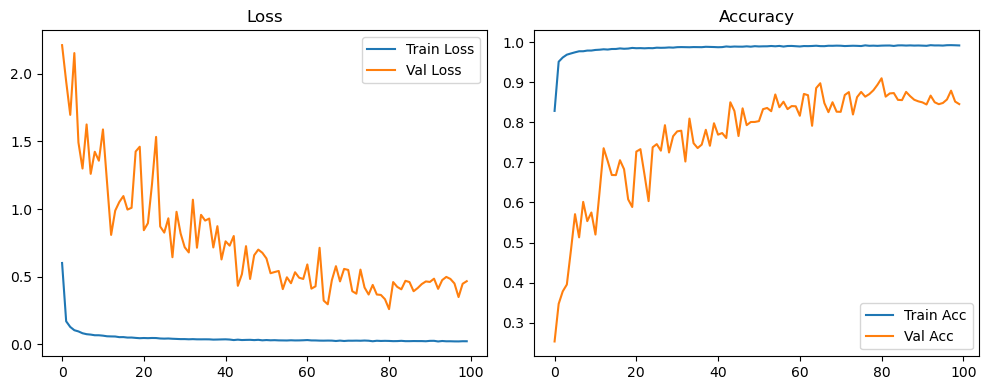

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2835, Acc: 0.9473 | Val Loss: 0.1487, Acc: 0.9592


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0514, Acc: 0.9857 | Val Loss: 0.2219, Acc: 0.9364


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0344, Acc: 0.9899 | Val Loss: 0.0960, Acc: 0.9691


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9930 | Val Loss: 0.0899, Acc: 0.9697


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9950 | Val Loss: 0.0795, Acc: 0.9757


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9964 | Val Loss: 0.0790, Acc: 0.9771


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9976 | Val Loss: 0.0474, Acc: 0.9842


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9985 | Val Loss: 0.0605, Acc: 0.9819


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9983 | Val Loss: 0.3540, Acc: 0.9037


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.2966, Acc: 0.9158


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9972 | Val Loss: 0.0735, Acc: 0.9797


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9990 | Val Loss: 0.0592, Acc: 0.9844


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9997 | Val Loss: 0.0776, Acc: 0.9794


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9999 | Val Loss: 0.0351, Acc: 0.9902


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0335, Acc: 0.9908


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0314, Acc: 0.9913


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0317, Acc: 0.9918


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0320, Acc: 0.9918


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0324, Acc: 0.9915


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0320, Acc: 0.9918


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0318, Acc: 0.9921


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0322, Acc: 0.9922


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0327, Acc: 0.9919


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0332, Acc: 0.9918


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0325, Acc: 0.9915


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0330, Acc: 0.9918


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0335, Acc: 0.9919


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0336, Acc: 0.9920


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0337, Acc: 0.9920


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0336, Acc: 0.9921


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0343, Acc: 0.9919


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0342, Acc: 0.9922


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0337, Acc: 0.9921


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0347, Acc: 0.9922


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0355, Acc: 0.9920


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0352, Acc: 0.9921


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0351, Acc: 0.9922


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0351, Acc: 0.9922


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0361, Acc: 0.9922


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0360, Acc: 0.9918


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0359, Acc: 0.9923


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0360, Acc: 0.9921


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0363, Acc: 0.9920


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0365, Acc: 0.9919


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0367, Acc: 0.9920


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0372, Acc: 0.9919


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0377, Acc: 0.9922


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0379, Acc: 0.9918


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0392, Acc: 0.9920


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0393, Acc: 0.9918


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0381, Acc: 0.9916


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0378, Acc: 0.9915


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0389, Acc: 0.9922


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0384, Acc: 0.9920


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0385, Acc: 0.9918


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0390, Acc: 0.9918


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0391, Acc: 0.9918


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0390, Acc: 0.9918


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0396, Acc: 0.9919


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0399, Acc: 0.9917


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0403, Acc: 0.9917


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0399, Acc: 0.9916


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0406, Acc: 0.9918


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0405, Acc: 0.9916


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0402, Acc: 0.9918


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0405, Acc: 0.9918


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0408, Acc: 0.9920


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0411, Acc: 0.9917


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0413, Acc: 0.9917


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0414, Acc: 0.9916


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0408, Acc: 0.9916


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0407, Acc: 0.9919


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0420, Acc: 0.9917


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0320, Acc: 0.9910 | Val Loss: 0.0790, Acc: 0.9780


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.0561, Acc: 0.9848


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.0388, Acc: 0.9896


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 1.0000 | Val Loss: 0.0376, Acc: 0.9901


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0341, Acc: 0.9913


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0339, Acc: 0.9910


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0348, Acc: 0.9906


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0346, Acc: 0.9913


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0345, Acc: 0.9917


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0344, Acc: 0.9912


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0349, Acc: 0.9912


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0347, Acc: 0.9914


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0347, Acc: 0.9915


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0347, Acc: 0.9918


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0355, Acc: 0.9915


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0352, Acc: 0.9915


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0353, Acc: 0.9916


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0348, Acc: 0.9918


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0356, Acc: 0.9917


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0353, Acc: 0.9917


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0353, Acc: 0.9918


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0358, Acc: 0.9917


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0359, Acc: 0.9918


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0363, Acc: 0.9917


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0362, Acc: 0.9917


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0361, Acc: 0.9920


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0362, Acc: 0.9918


Final Test Loss: 0.0374 Accuracy: 0.9913


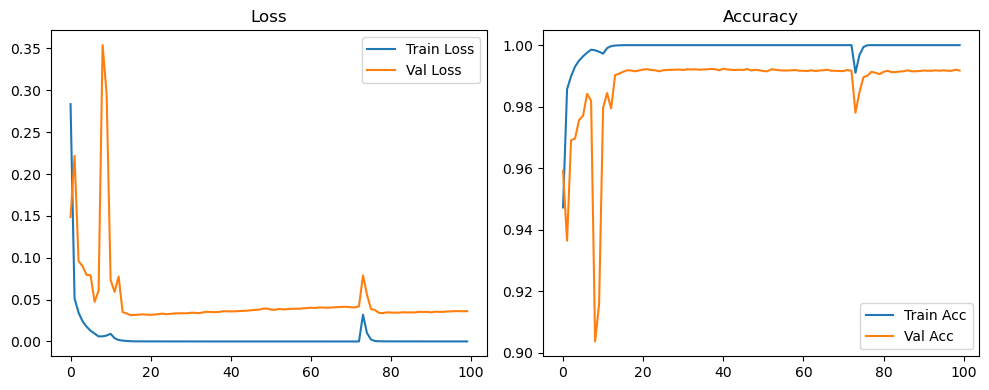

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3547, Acc: 0.9231 | Val Loss: 1.1627, Acc: 0.6246


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0782, Acc: 0.9780 | Val Loss: 0.9733, Acc: 0.6877


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0606, Acc: 0.9820 | Val Loss: 0.6204, Acc: 0.8048


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0493, Acc: 0.9853 | Val Loss: 0.7643, Acc: 0.7282


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0398, Acc: 0.9876 | Val Loss: 1.2267, Acc: 0.6452


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0336, Acc: 0.9890 | Val Loss: 0.5818, Acc: 0.8141


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9898 | Val Loss: 0.3679, Acc: 0.8865


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0276, Acc: 0.9914 | Val Loss: 0.8948, Acc: 0.7355


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0229, Acc: 0.9929 | Val Loss: 0.7629, Acc: 0.7618


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9930 | Val Loss: 0.3538, Acc: 0.8838


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9935 | Val Loss: 0.2970, Acc: 0.9015


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9936 | Val Loss: 0.4218, Acc: 0.8639


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9947 | Val Loss: 0.4351, Acc: 0.8638


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9948 | Val Loss: 0.2379, Acc: 0.9258


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9947 | Val Loss: 0.2688, Acc: 0.9140


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9955 | Val Loss: 0.3741, Acc: 0.8886


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9958 | Val Loss: 0.2852, Acc: 0.9166


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9953 | Val Loss: 0.2495, Acc: 0.9223


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9956 | Val Loss: 0.2534, Acc: 0.9285


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9960 | Val Loss: 0.2770, Acc: 0.9239


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9960 | Val Loss: 0.2354, Acc: 0.9311


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.1947, Acc: 0.9427


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.2899, Acc: 0.9188


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.2944, Acc: 0.9166


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.1393, Acc: 0.9608


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9962 | Val Loss: 0.2434, Acc: 0.9332


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9967 | Val Loss: 0.2454, Acc: 0.9356


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.2327, Acc: 0.9362


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9970 | Val Loss: 0.1590, Acc: 0.9549


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9971 | Val Loss: 0.2500, Acc: 0.9338


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.1584, Acc: 0.9570


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.2244, Acc: 0.9413


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.2364, Acc: 0.9377


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9974 | Val Loss: 0.2585, Acc: 0.9346


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.1655, Acc: 0.9563


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9976 | Val Loss: 0.0925, Acc: 0.9752


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9973 | Val Loss: 0.1736, Acc: 0.9548


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.1328, Acc: 0.9670


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.1792, Acc: 0.9558


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.1320, Acc: 0.9650


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.1284, Acc: 0.9683


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.1278, Acc: 0.9683


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.1968, Acc: 0.9525


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.1642, Acc: 0.9618


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.2137, Acc: 0.9517


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.2324, Acc: 0.9458


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.2513, Acc: 0.9411


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.2331, Acc: 0.9453


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.2856, Acc: 0.9347


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.2664, Acc: 0.9413


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1740, Acc: 0.9614


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1764, Acc: 0.9618


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1972, Acc: 0.9567


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1517, Acc: 0.9654


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1488, Acc: 0.9668


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1473, Acc: 0.9683


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1722, Acc: 0.9635


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1869, Acc: 0.9598


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1617, Acc: 0.9647


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1755, Acc: 0.9623


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1533, Acc: 0.9667


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1921, Acc: 0.9589


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1338, Acc: 0.9702


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1878, Acc: 0.9616


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1391, Acc: 0.9694


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1374, Acc: 0.9704


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1606, Acc: 0.9656


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1480, Acc: 0.9697


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.2266, Acc: 0.9547


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1600, Acc: 0.9663


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1638, Acc: 0.9663


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.2082, Acc: 0.9558


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.2464, Acc: 0.9497


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.1896, Acc: 0.9613


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.2107, Acc: 0.9582


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9993 | Val Loss: 0.2005, Acc: 0.9591


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1737, Acc: 0.9646


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1712, Acc: 0.9662


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1977, Acc: 0.9597


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.2426, Acc: 0.9515


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1828, Acc: 0.9637


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1897, Acc: 0.9617


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9994 | Val Loss: 0.1793, Acc: 0.9642


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1767, Acc: 0.9643


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1798, Acc: 0.9637


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1501, Acc: 0.9694


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1603, Acc: 0.9687


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1462, Acc: 0.9712


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1597, Acc: 0.9681


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1777, Acc: 0.9647


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9996 | Val Loss: 0.1489, Acc: 0.9695


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1652, Acc: 0.9669


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1574, Acc: 0.9686


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1587, Acc: 0.9679


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1579, Acc: 0.9694


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1725, Acc: 0.9666


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1539, Acc: 0.9698


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1700, Acc: 0.9670


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1587, Acc: 0.9700


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1457, Acc: 0.9722


Final Test Loss: 0.1472 Accuracy: 0.9694


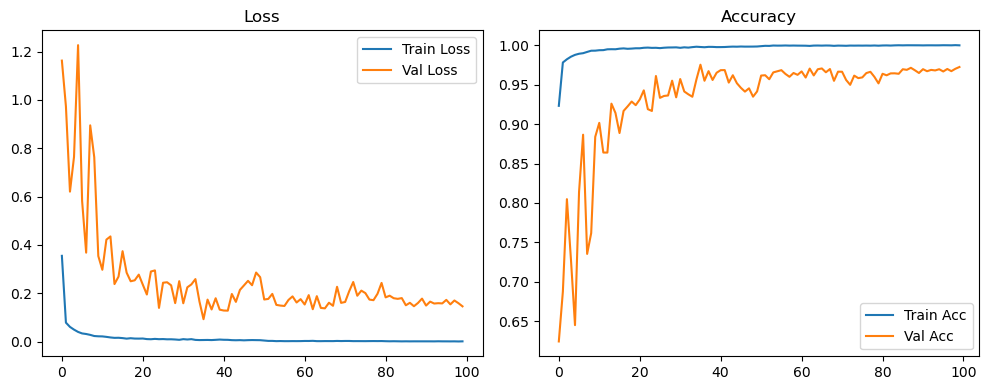

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6023, Acc: 0.8282 | Val Loss: 2.2080, Acc: 0.2588


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1715, Acc: 0.9511 | Val Loss: 1.9823, Acc: 0.3422


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1297, Acc: 0.9617 | Val Loss: 1.5649, Acc: 0.4123


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1058, Acc: 0.9688 | Val Loss: 2.0929, Acc: 0.4001


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0967, Acc: 0.9717 | Val Loss: 1.3649, Acc: 0.5171


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0833, Acc: 0.9751 | Val Loss: 1.3752, Acc: 0.5534


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0771, Acc: 0.9766 | Val Loss: 1.7021, Acc: 0.4864


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0733, Acc: 0.9779 | Val Loss: 1.2307, Acc: 0.5989


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0678, Acc: 0.9794 | Val Loss: 1.4018, Acc: 0.5703


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0682, Acc: 0.9787 | Val Loss: 1.3193, Acc: 0.5886


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0654, Acc: 0.9804 | Val Loss: 1.6362, Acc: 0.5118


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0608, Acc: 0.9818 | Val Loss: 1.1904, Acc: 0.6279


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0605, Acc: 0.9814 | Val Loss: 0.7957, Acc: 0.7401


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0580, Acc: 0.9821 | Val Loss: 1.0226, Acc: 0.6937


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0550, Acc: 0.9829 | Val Loss: 1.1365, Acc: 0.6485


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0546, Acc: 0.9831 | Val Loss: 1.2908, Acc: 0.6212


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0506, Acc: 0.9844 | Val Loss: 1.1019, Acc: 0.6715


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0517, Acc: 0.9835 | Val Loss: 0.9665, Acc: 0.6922


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0491, Acc: 0.9845 | Val Loss: 1.4658, Acc: 0.5934


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0469, Acc: 0.9852 | Val Loss: 1.4995, Acc: 0.5861


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0492, Acc: 0.9843 | Val Loss: 0.8952, Acc: 0.7098


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0475, Acc: 0.9849 | Val Loss: 1.1220, Acc: 0.6822


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0474, Acc: 0.9847 | Val Loss: 1.0182, Acc: 0.7066


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0476, Acc: 0.9851 | Val Loss: 1.4572, Acc: 0.6034


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0437, Acc: 0.9860 | Val Loss: 0.9346, Acc: 0.7225


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0433, Acc: 0.9862 | Val Loss: 0.9613, Acc: 0.7202


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0440, Acc: 0.9861 | Val Loss: 1.0005, Acc: 0.7157


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9862 | Val Loss: 0.9344, Acc: 0.7143


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0415, Acc: 0.9870 | Val Loss: 1.1480, Acc: 0.6673


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0406, Acc: 0.9864 | Val Loss: 0.9708, Acc: 0.7156


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0405, Acc: 0.9874 | Val Loss: 0.8607, Acc: 0.7435


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0394, Acc: 0.9869 | Val Loss: 0.7763, Acc: 0.7529


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9869 | Val Loss: 0.8212, Acc: 0.7602


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0372, Acc: 0.9875 | Val Loss: 0.6618, Acc: 0.8017


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0380, Acc: 0.9879 | Val Loss: 0.8436, Acc: 0.7669


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9876 | Val Loss: 0.8457, Acc: 0.7533


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0371, Acc: 0.9880 | Val Loss: 0.9983, Acc: 0.7365


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0356, Acc: 0.9886 | Val Loss: 0.7897, Acc: 0.7690


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0361, Acc: 0.9882 | Val Loss: 0.7508, Acc: 0.7678


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0389, Acc: 0.9873 | Val Loss: 0.7354, Acc: 0.7752


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0378, Acc: 0.9877 | Val Loss: 0.7896, Acc: 0.7670


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0363, Acc: 0.9884 | Val Loss: 0.7936, Acc: 0.7604


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0334, Acc: 0.9890 | Val Loss: 0.9629, Acc: 0.7232


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0360, Acc: 0.9886 | Val Loss: 0.4230, Acc: 0.8548


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9888 | Val Loss: 0.6352, Acc: 0.8104


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0333, Acc: 0.9888 | Val Loss: 0.7905, Acc: 0.7689


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0344, Acc: 0.9886 | Val Loss: 0.6021, Acc: 0.8099


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0323, Acc: 0.9895 | Val Loss: 0.6853, Acc: 0.7911


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0360, Acc: 0.9888 | Val Loss: 0.6475, Acc: 0.8035


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9901 | Val Loss: 0.6946, Acc: 0.7893


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0291, Acc: 0.9907 | Val Loss: 0.5193, Acc: 0.8347


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9920 | Val Loss: 0.5416, Acc: 0.8327


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9913 | Val Loss: 0.5618, Acc: 0.8246


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0250, Acc: 0.9922 | Val Loss: 0.5294, Acc: 0.8353


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0244, Acc: 0.9919 | Val Loss: 0.3847, Acc: 0.8727


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0240, Acc: 0.9926 | Val Loss: 0.4662, Acc: 0.8459


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0252, Acc: 0.9916 | Val Loss: 0.5974, Acc: 0.8216


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0248, Acc: 0.9920 | Val Loss: 0.6509, Acc: 0.8160


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9917 | Val Loss: 0.5230, Acc: 0.8367


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0252, Acc: 0.9919 | Val Loss: 0.4981, Acc: 0.8437


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0248, Acc: 0.9917 | Val Loss: 0.5653, Acc: 0.8291


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0244, Acc: 0.9922 | Val Loss: 0.5035, Acc: 0.8449


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0242, Acc: 0.9919 | Val Loss: 0.5369, Acc: 0.8366


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0234, Acc: 0.9922 | Val Loss: 0.5646, Acc: 0.8253


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0232, Acc: 0.9926 | Val Loss: 0.3772, Acc: 0.8752


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9924 | Val Loss: 0.4145, Acc: 0.8633


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0239, Acc: 0.9917 | Val Loss: 0.5627, Acc: 0.8229


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0233, Acc: 0.9925 | Val Loss: 0.7128, Acc: 0.7896


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0232, Acc: 0.9923 | Val Loss: 0.5280, Acc: 0.8327


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0216, Acc: 0.9923 | Val Loss: 0.4463, Acc: 0.8610


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0221, Acc: 0.9929 | Val Loss: 0.5732, Acc: 0.8223


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9919 | Val Loss: 0.4628, Acc: 0.8507


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0221, Acc: 0.9930 | Val Loss: 0.5341, Acc: 0.8327


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0225, Acc: 0.9925 | Val Loss: 0.5247, Acc: 0.8307


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0240, Acc: 0.9919 | Val Loss: 0.4496, Acc: 0.8562


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0234, Acc: 0.9919 | Val Loss: 0.3683, Acc: 0.8789


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0213, Acc: 0.9924 | Val Loss: 0.3811, Acc: 0.8756


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0224, Acc: 0.9926 | Val Loss: 0.3810, Acc: 0.8714


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0218, Acc: 0.9926 | Val Loss: 0.4145, Acc: 0.8674


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0224, Acc: 0.9926 | Val Loss: 0.4481, Acc: 0.8598


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0205, Acc: 0.9935 | Val Loss: 0.3568, Acc: 0.8830


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0192, Acc: 0.9937 | Val Loss: 0.4201, Acc: 0.8652


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0181, Acc: 0.9941 | Val Loss: 0.4114, Acc: 0.8695


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0202, Acc: 0.9932 | Val Loss: 0.4392, Acc: 0.8620


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0185, Acc: 0.9938 | Val Loss: 0.4638, Acc: 0.8520


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0178, Acc: 0.9940 | Val Loss: 0.4317, Acc: 0.8615


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0179, Acc: 0.9942 | Val Loss: 0.4533, Acc: 0.8562


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0178, Acc: 0.9939 | Val Loss: 0.4572, Acc: 0.8560


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0179, Acc: 0.9941 | Val Loss: 0.4629, Acc: 0.8555


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0163, Acc: 0.9946 | Val Loss: 0.4380, Acc: 0.8629


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0187, Acc: 0.9935 | Val Loss: 0.4064, Acc: 0.8697


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0182, Acc: 0.9941 | Val Loss: 0.4627, Acc: 0.8541


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0167, Acc: 0.9940 | Val Loss: 0.4278, Acc: 0.8627


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0185, Acc: 0.9936 | Val Loss: 0.4973, Acc: 0.8437


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0168, Acc: 0.9941 | Val Loss: 0.4361, Acc: 0.8583


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0168, Acc: 0.9943 | Val Loss: 0.4389, Acc: 0.8602


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0164, Acc: 0.9946 | Val Loss: 0.4442, Acc: 0.8601


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0173, Acc: 0.9941 | Val Loss: 0.4063, Acc: 0.8700


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0162, Acc: 0.9945 | Val Loss: 0.4678, Acc: 0.8524


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0162, Acc: 0.9944 | Val Loss: 0.4251, Acc: 0.8671


Final Test Loss: 0.4127 Accuracy: 0.8645


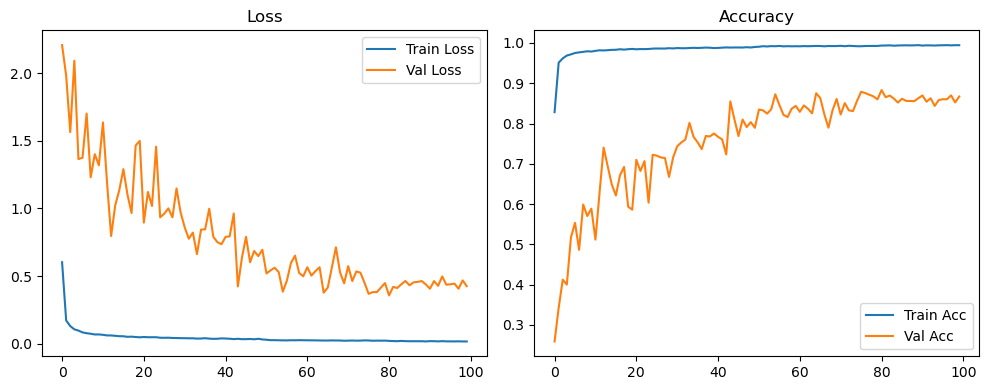

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2836, Acc: 0.9473 | Val Loss: 0.1463, Acc: 0.9589


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9857 | Val Loss: 0.2491, Acc: 0.9281


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0348, Acc: 0.9897 | Val Loss: 0.0792, Acc: 0.9755


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0248, Acc: 0.9928 | Val Loss: 0.0970, Acc: 0.9670


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9946 | Val Loss: 0.0803, Acc: 0.9753


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9970 | Val Loss: 0.0496, Acc: 0.9849


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9973 | Val Loss: 0.1057, Acc: 0.9686


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9982 | Val Loss: 0.0553, Acc: 0.9840


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9985 | Val Loss: 0.0929, Acc: 0.9741


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9986 | Val Loss: 0.0486, Acc: 0.9862


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.1948, Acc: 0.9497


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9988 | Val Loss: 0.0529, Acc: 0.9852


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9996 | Val Loss: 0.0355, Acc: 0.9901


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.0584, Acc: 0.9838


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.1042, Acc: 0.9729


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9966 | Val Loss: 0.1158, Acc: 0.9682


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.0618, Acc: 0.9853


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0551, Acc: 0.9858


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.0352, Acc: 0.9909


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0330, Acc: 0.9920


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0319, Acc: 0.9924


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0313, Acc: 0.9925


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0317, Acc: 0.9927


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0318, Acc: 0.9928


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0313, Acc: 0.9931


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0315, Acc: 0.9929


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0320, Acc: 0.9925


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0318, Acc: 0.9930


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0317, Acc: 0.9927


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0314, Acc: 0.9929


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0321, Acc: 0.9928


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0319, Acc: 0.9928


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0315, Acc: 0.9931


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0321, Acc: 0.9929


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0324, Acc: 0.9928


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0324, Acc: 0.9928


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0325, Acc: 0.9931


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0322, Acc: 0.9928


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0327, Acc: 0.9928


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0330, Acc: 0.9928


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0326, Acc: 0.9931


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0330, Acc: 0.9929


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0330, Acc: 0.9930


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0335, Acc: 0.9928


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0336, Acc: 0.9932


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0339, Acc: 0.9932


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0339, Acc: 0.9929


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0350, Acc: 0.9926


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0353, Acc: 0.9930


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0351, Acc: 0.9929


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0347, Acc: 0.9931


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0345, Acc: 0.9931


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0349, Acc: 0.9932


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0346, Acc: 0.9931


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0349, Acc: 0.9930


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0353, Acc: 0.9932


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0353, Acc: 0.9932


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0351, Acc: 0.9930


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0357, Acc: 0.9929


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0359, Acc: 0.9932


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0362, Acc: 0.9930


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0365, Acc: 0.9931


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0367, Acc: 0.9932


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0371, Acc: 0.9929


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0362, Acc: 0.9929


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0365, Acc: 0.9929


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0369, Acc: 0.9928


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0370, Acc: 0.9930


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0373, Acc: 0.9931


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0374, Acc: 0.9933


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0372, Acc: 0.9931


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0372, Acc: 0.9932


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0379, Acc: 0.9930


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0378, Acc: 0.9930


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0377, Acc: 0.9930


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0384, Acc: 0.9931


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0382, Acc: 0.9931


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0382, Acc: 0.9931


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0389, Acc: 0.9930


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0390, Acc: 0.9929


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0392, Acc: 0.9928


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0389, Acc: 0.9931


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0391, Acc: 0.9931


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0393, Acc: 0.9930


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0391, Acc: 0.9931


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0394, Acc: 0.9929


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0395, Acc: 0.9930


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0398, Acc: 0.9931


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0397, Acc: 0.9931


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0399, Acc: 0.9930


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0393, Acc: 0.9928


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0398, Acc: 0.9929


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0396, Acc: 0.9930


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0399, Acc: 0.9931


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0401, Acc: 0.9928


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0401, Acc: 0.9931


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0408, Acc: 0.9931


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0401, Acc: 0.9929


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0404, Acc: 0.9929


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0404, Acc: 0.9930


Final Test Loss: 0.0434 Accuracy: 0.9910


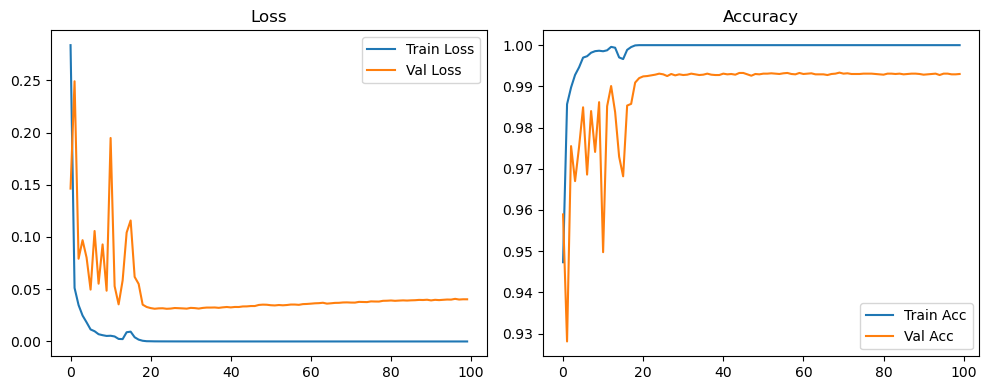

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3550, Acc: 0.9231 | Val Loss: 1.1952, Acc: 0.6146


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0781, Acc: 0.9781 | Val Loss: 0.8769, Acc: 0.7176


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0603, Acc: 0.9819 | Val Loss: 0.7686, Acc: 0.7742


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0501, Acc: 0.9849 | Val Loss: 0.7581, Acc: 0.7210


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9871 | Val Loss: 0.9865, Acc: 0.6855


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0327, Acc: 0.9898 | Val Loss: 0.6006, Acc: 0.8077


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9900 | Val Loss: 0.4728, Acc: 0.8628


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0275, Acc: 0.9915 | Val Loss: 0.6977, Acc: 0.7914


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0236, Acc: 0.9923 | Val Loss: 0.7200, Acc: 0.7709


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9928 | Val Loss: 0.3351, Acc: 0.8907


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9934 | Val Loss: 0.3117, Acc: 0.8961


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9934 | Val Loss: 0.3775, Acc: 0.8738


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9942 | Val Loss: 0.3688, Acc: 0.8862


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9951 | Val Loss: 0.2519, Acc: 0.9202


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9945 | Val Loss: 0.3020, Acc: 0.9063


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9954 | Val Loss: 0.4350, Acc: 0.8762


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9960 | Val Loss: 0.3492, Acc: 0.8958


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9959 | Val Loss: 0.2375, Acc: 0.9287


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.2474, Acc: 0.9289


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.1890, Acc: 0.9473


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9959 | Val Loss: 0.1755, Acc: 0.9463


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.2074, Acc: 0.9377


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.2531, Acc: 0.9279


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9965 | Val Loss: 0.2513, Acc: 0.9303


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.1964, Acc: 0.9460


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9970 | Val Loss: 0.2886, Acc: 0.9208


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.2866, Acc: 0.9217


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9970 | Val Loss: 0.2917, Acc: 0.9196


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.2715, Acc: 0.9279


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9967 | Val Loss: 0.2031, Acc: 0.9451


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9971 | Val Loss: 0.2195, Acc: 0.9431


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9973 | Val Loss: 0.2183, Acc: 0.9426


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9970 | Val Loss: 0.1969, Acc: 0.9515


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.2153, Acc: 0.9443


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9977 | Val Loss: 0.1683, Acc: 0.9583


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1601, Acc: 0.9607


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.2149, Acc: 0.9467


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.1533, Acc: 0.9609


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.1389, Acc: 0.9643


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.1695, Acc: 0.9591


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.1114, Acc: 0.9736


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1099, Acc: 0.9732


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1923, Acc: 0.9523


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1489, Acc: 0.9638


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1626, Acc: 0.9603


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.1827, Acc: 0.9576


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1241, Acc: 0.9701


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1840, Acc: 0.9566


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.1381, Acc: 0.9673


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1554, Acc: 0.9627


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0871, Acc: 0.9784


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.1010, Acc: 0.9745


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1128, Acc: 0.9743


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1154, Acc: 0.9728


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1055, Acc: 0.9747


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1141, Acc: 0.9734


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1202, Acc: 0.9726


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1365, Acc: 0.9702


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.1173, Acc: 0.9736


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1120, Acc: 0.9757


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1370, Acc: 0.9694


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1472, Acc: 0.9683


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9989 | Val Loss: 0.1373, Acc: 0.9708


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1559, Acc: 0.9663


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1153, Acc: 0.9749


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1180, Acc: 0.9732


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1555, Acc: 0.9662


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1520, Acc: 0.9657


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1286, Acc: 0.9718


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1344, Acc: 0.9712


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1257, Acc: 0.9730


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1396, Acc: 0.9692


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1839, Acc: 0.9621


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.1472, Acc: 0.9688


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1770, Acc: 0.9653


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1766, Acc: 0.9631


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1223, Acc: 0.9746


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1448, Acc: 0.9705


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1124, Acc: 0.9764


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9991 | Val Loss: 0.1575, Acc: 0.9671


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.1325, Acc: 0.9723


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1413, Acc: 0.9708


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1240, Acc: 0.9752


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1341, Acc: 0.9730


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1306, Acc: 0.9737


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1325, Acc: 0.9734


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1249, Acc: 0.9753


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1285, Acc: 0.9741


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1236, Acc: 0.9749


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1279, Acc: 0.9748


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1322, Acc: 0.9736


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1337, Acc: 0.9732


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1264, Acc: 0.9754


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1365, Acc: 0.9728


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1255, Acc: 0.9755


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1358, Acc: 0.9730


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1239, Acc: 0.9754


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1275, Acc: 0.9748


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1251, Acc: 0.9758


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1174, Acc: 0.9767


Final Test Loss: 0.1143 Accuracy: 0.9759


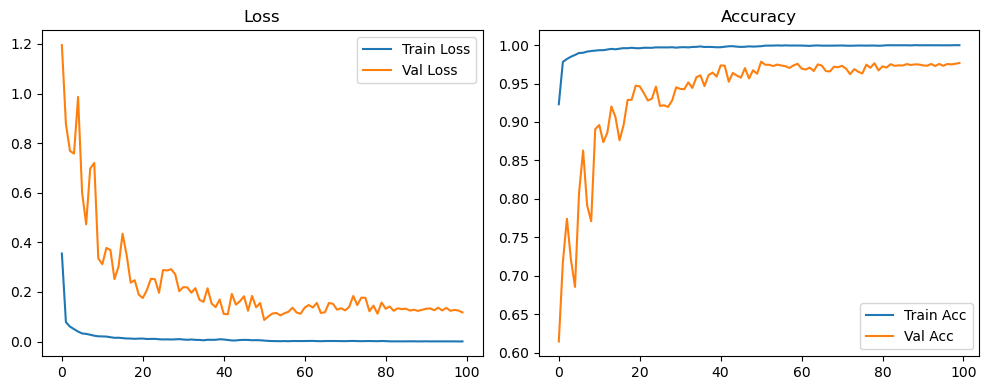

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6022, Acc: 0.8285 | Val Loss: 2.1289, Acc: 0.2712


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1714, Acc: 0.9513 | Val Loss: 2.0030, Acc: 0.3396


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1296, Acc: 0.9618 | Val Loss: 1.6123, Acc: 0.4049


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1058, Acc: 0.9689 | Val Loss: 2.0797, Acc: 0.4042


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0964, Acc: 0.9720 | Val Loss: 1.4367, Acc: 0.5000


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0830, Acc: 0.9749 | Val Loss: 1.4274, Acc: 0.5302


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0767, Acc: 0.9771 | Val Loss: 1.6797, Acc: 0.4977


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0729, Acc: 0.9776 | Val Loss: 1.2963, Acc: 0.5923


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0683, Acc: 0.9785 | Val Loss: 1.4299, Acc: 0.5754


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0677, Acc: 0.9793 | Val Loss: 1.4261, Acc: 0.5603


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0651, Acc: 0.9802 | Val Loss: 1.7806, Acc: 0.4794


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0609, Acc: 0.9814 | Val Loss: 1.2227, Acc: 0.6271


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0610, Acc: 0.9811 | Val Loss: 0.7817, Acc: 0.7412


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0582, Acc: 0.9821 | Val Loss: 0.9635, Acc: 0.7209


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0542, Acc: 0.9834 | Val Loss: 0.9669, Acc: 0.6977


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0540, Acc: 0.9830 | Val Loss: 1.0592, Acc: 0.6849


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0506, Acc: 0.9845 | Val Loss: 1.0699, Acc: 0.6756


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0515, Acc: 0.9834 | Val Loss: 0.9723, Acc: 0.7070


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0491, Acc: 0.9846 | Val Loss: 1.3544, Acc: 0.6400


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0461, Acc: 0.9853 | Val Loss: 1.5016, Acc: 0.5979


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0493, Acc: 0.9842 | Val Loss: 0.8106, Acc: 0.7337


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0472, Acc: 0.9849 | Val Loss: 1.2050, Acc: 0.6646


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0470, Acc: 0.9856 | Val Loss: 1.3282, Acc: 0.6504


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0472, Acc: 0.9850 | Val Loss: 1.5470, Acc: 0.6022


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0447, Acc: 0.9854 | Val Loss: 0.7752, Acc: 0.7635


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0438, Acc: 0.9863 | Val Loss: 1.0160, Acc: 0.7140


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0441, Acc: 0.9861 | Val Loss: 0.8772, Acc: 0.7512


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0428, Acc: 0.9866 | Val Loss: 0.9511, Acc: 0.7166


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9871 | Val Loss: 1.1491, Acc: 0.6741


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0399, Acc: 0.9870 | Val Loss: 1.0285, Acc: 0.7102


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0400, Acc: 0.9874 | Val Loss: 0.8941, Acc: 0.7378


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0387, Acc: 0.9876 | Val Loss: 0.8414, Acc: 0.7344


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0396, Acc: 0.9870 | Val Loss: 0.8730, Acc: 0.7492


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0393, Acc: 0.9873 | Val Loss: 0.6952, Acc: 0.8031


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0387, Acc: 0.9880 | Val Loss: 0.8079, Acc: 0.7773


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0374, Acc: 0.9878 | Val Loss: 0.8217, Acc: 0.7592


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0363, Acc: 0.9887 | Val Loss: 1.0368, Acc: 0.7381


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0356, Acc: 0.9883 | Val Loss: 0.6613, Acc: 0.7958


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0355, Acc: 0.9880 | Val Loss: 0.7670, Acc: 0.7650


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0373, Acc: 0.9877 | Val Loss: 0.7718, Acc: 0.7722


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0372, Acc: 0.9878 | Val Loss: 0.8787, Acc: 0.7389


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9882 | Val Loss: 0.7924, Acc: 0.7681


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0328, Acc: 0.9896 | Val Loss: 0.8406, Acc: 0.7414


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0343, Acc: 0.9889 | Val Loss: 0.5055, Acc: 0.8274


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9894 | Val Loss: 0.5848, Acc: 0.8159


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9889 | Val Loss: 0.8180, Acc: 0.7554


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0341, Acc: 0.9886 | Val Loss: 0.7007, Acc: 0.7785


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9893 | Val Loss: 0.5014, Acc: 0.8331


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0348, Acc: 0.9889 | Val Loss: 0.5630, Acc: 0.8277


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0327, Acc: 0.9893 | Val Loss: 0.6938, Acc: 0.7929


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0290, Acc: 0.9908 | Val Loss: 0.4905, Acc: 0.8409


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0253, Acc: 0.9918 | Val Loss: 0.5271, Acc: 0.8349


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0254, Acc: 0.9918 | Val Loss: 0.5049, Acc: 0.8377


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0249, Acc: 0.9919 | Val Loss: 0.6510, Acc: 0.8106


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0240, Acc: 0.9920 | Val Loss: 0.4287, Acc: 0.8624


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0243, Acc: 0.9921 | Val Loss: 0.4919, Acc: 0.8417


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0252, Acc: 0.9917 | Val Loss: 0.5792, Acc: 0.8267


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0250, Acc: 0.9919 | Val Loss: 0.6107, Acc: 0.8261


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0248, Acc: 0.9921 | Val Loss: 0.5886, Acc: 0.8234


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0260, Acc: 0.9917 | Val Loss: 0.4846, Acc: 0.8442


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0246, Acc: 0.9916 | Val Loss: 0.5461, Acc: 0.8298


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0246, Acc: 0.9917 | Val Loss: 0.5675, Acc: 0.8329


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0238, Acc: 0.9916 | Val Loss: 0.5090, Acc: 0.8442


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0235, Acc: 0.9925 | Val Loss: 0.7160, Acc: 0.7945


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0234, Acc: 0.9924 | Val Loss: 0.3701, Acc: 0.8799


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0244, Acc: 0.9920 | Val Loss: 0.4074, Acc: 0.8665


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0229, Acc: 0.9919 | Val Loss: 0.4825, Acc: 0.8452


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0222, Acc: 0.9928 | Val Loss: 0.5980, Acc: 0.8122


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0237, Acc: 0.9918 | Val Loss: 0.5374, Acc: 0.8268


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0224, Acc: 0.9925 | Val Loss: 0.5622, Acc: 0.8272


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9930 | Val Loss: 0.6006, Acc: 0.8125


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0226, Acc: 0.9922 | Val Loss: 0.5110, Acc: 0.8359


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0222, Acc: 0.9929 | Val Loss: 0.5355, Acc: 0.8313


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0224, Acc: 0.9923 | Val Loss: 0.6346, Acc: 0.8069


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0239, Acc: 0.9924 | Val Loss: 0.5377, Acc: 0.8352


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0234, Acc: 0.9918 | Val Loss: 0.4204, Acc: 0.8598


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0213, Acc: 0.9927 | Val Loss: 0.4851, Acc: 0.8451


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9931 | Val Loss: 0.4742, Acc: 0.8397


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0212, Acc: 0.9927 | Val Loss: 0.5302, Acc: 0.8231


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9925 | Val Loss: 0.4840, Acc: 0.8508


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0195, Acc: 0.9931 | Val Loss: 0.4347, Acc: 0.8577


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0189, Acc: 0.9937 | Val Loss: 0.4969, Acc: 0.8408


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0171, Acc: 0.9942 | Val Loss: 0.4972, Acc: 0.8443


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0193, Acc: 0.9935 | Val Loss: 0.4624, Acc: 0.8522


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0175, Acc: 0.9942 | Val Loss: 0.4787, Acc: 0.8468


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0170, Acc: 0.9947 | Val Loss: 0.4831, Acc: 0.8449


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0171, Acc: 0.9945 | Val Loss: 0.5052, Acc: 0.8411


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0175, Acc: 0.9941 | Val Loss: 0.5133, Acc: 0.8390


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0181, Acc: 0.9940 | Val Loss: 0.5214, Acc: 0.8391


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0160, Acc: 0.9945 | Val Loss: 0.5086, Acc: 0.8413


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0185, Acc: 0.9938 | Val Loss: 0.4427, Acc: 0.8589


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0183, Acc: 0.9941 | Val Loss: 0.5006, Acc: 0.8427


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0163, Acc: 0.9944 | Val Loss: 0.4445, Acc: 0.8573


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0187, Acc: 0.9939 | Val Loss: 0.5111, Acc: 0.8401


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0165, Acc: 0.9944 | Val Loss: 0.5006, Acc: 0.8389


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0168, Acc: 0.9945 | Val Loss: 0.5076, Acc: 0.8407


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0162, Acc: 0.9948 | Val Loss: 0.4547, Acc: 0.8538


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0170, Acc: 0.9940 | Val Loss: 0.4106, Acc: 0.8686


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0166, Acc: 0.9948 | Val Loss: 0.4331, Acc: 0.8593


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0163, Acc: 0.9942 | Val Loss: 0.4030, Acc: 0.8702


Final Test Loss: 0.3915 Accuracy: 0.8708


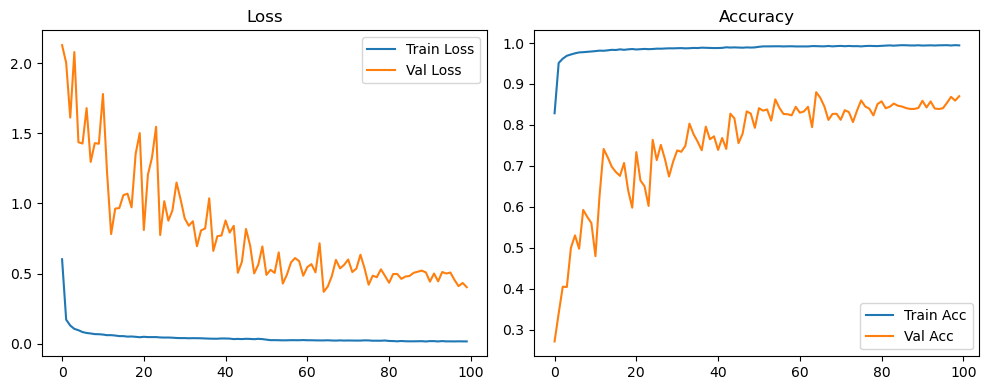

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2836, Acc: 0.9472 | Val Loss: 0.1837, Acc: 0.9453


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0517, Acc: 0.9856 | Val Loss: 0.3628, Acc: 0.8770


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0342, Acc: 0.9899 | Val Loss: 0.1083, Acc: 0.9646


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9932 | Val Loss: 0.0869, Acc: 0.9722


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9948 | Val Loss: 0.0833, Acc: 0.9740


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9965 | Val Loss: 0.0890, Acc: 0.9729


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9973 | Val Loss: 0.0505, Acc: 0.9837


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9984 | Val Loss: 0.0696, Acc: 0.9782


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9987 | Val Loss: 0.0781, Acc: 0.9760


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9963 | Val Loss: 0.0997, Acc: 0.9711


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.1919, Acc: 0.9423


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9991 | Val Loss: 0.0529, Acc: 0.9848


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9999 | Val Loss: 0.0456, Acc: 0.9868


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0006, Acc: 1.0000 | Val Loss: 0.0357, Acc: 0.9909


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0326, Acc: 0.9912


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0327, Acc: 0.9910


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0326, Acc: 0.9913


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0327, Acc: 0.9916


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0333, Acc: 0.9918


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0330, Acc: 0.9914


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0335, Acc: 0.9916


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0333, Acc: 0.9919


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0340, Acc: 0.9917


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0346, Acc: 0.9914


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0341, Acc: 0.9918


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0344, Acc: 0.9918


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0346, Acc: 0.9922


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0349, Acc: 0.9917


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0352, Acc: 0.9918


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0345, Acc: 0.9921


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0356, Acc: 0.9916


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0352, Acc: 0.9921


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0350, Acc: 0.9922


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0358, Acc: 0.9923


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0365, Acc: 0.9921


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0365, Acc: 0.9918


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0368, Acc: 0.9922


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0364, Acc: 0.9920


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0371, Acc: 0.9917


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0374, Acc: 0.9916


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0372, Acc: 0.9917


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0375, Acc: 0.9918


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0377, Acc: 0.9918


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0381, Acc: 0.9922


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0376, Acc: 0.9924


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0383, Acc: 0.9918


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0386, Acc: 0.9922


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0395, Acc: 0.9918


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0404, Acc: 0.9915


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0406, Acc: 0.9914


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0398, Acc: 0.9918


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0394, Acc: 0.9920


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0398, Acc: 0.9918


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0395, Acc: 0.9917


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0397, Acc: 0.9919


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0401, Acc: 0.9918


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0401, Acc: 0.9919


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0396, Acc: 0.9920


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0402, Acc: 0.9918


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0403, Acc: 0.9917


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0406, Acc: 0.9917


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0406, Acc: 0.9916


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0408, Acc: 0.9920


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0411, Acc: 0.9918


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0403, Acc: 0.9918


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0405, Acc: 0.9916


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0412, Acc: 0.9913


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0411, Acc: 0.9918


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0419, Acc: 0.9918


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0417, Acc: 0.9917


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0409, Acc: 0.9915


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0409, Acc: 0.9914


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0416, Acc: 0.9917


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0421, Acc: 0.9918


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0418, Acc: 0.9916


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0421, Acc: 0.9918


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0423, Acc: 0.9919


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0419, Acc: 0.9917


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0422, Acc: 0.9916


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0421, Acc: 0.9914


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0426, Acc: 0.9919


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0425, Acc: 0.9915


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0432, Acc: 0.9918


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0433, Acc: 0.9918


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0430, Acc: 0.9916


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0431, Acc: 0.9915


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0438, Acc: 0.9918


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0439, Acc: 0.9914


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0439, Acc: 0.9916


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0440, Acc: 0.9918


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0433, Acc: 0.9917


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0440, Acc: 0.9917


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0442, Acc: 0.9918


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0441, Acc: 0.9915


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0443, Acc: 0.9918


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0452, Acc: 0.9912


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0456, Acc: 0.9915


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0449, Acc: 0.9918


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0453, Acc: 0.9917


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0453, Acc: 0.9916


Final Test Loss: 0.0441 Accuracy: 0.9918


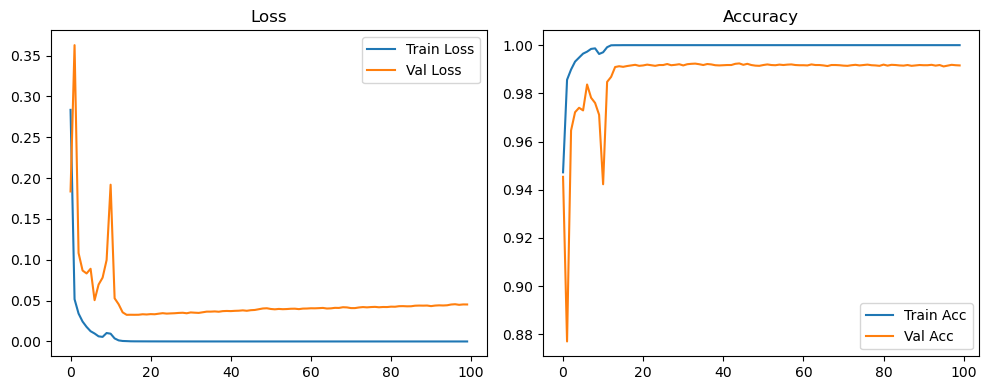

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3550, Acc: 0.9228 | Val Loss: 1.3501, Acc: 0.5881


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0786, Acc: 0.9779 | Val Loss: 0.9221, Acc: 0.7098


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0602, Acc: 0.9824 | Val Loss: 0.6133, Acc: 0.8099


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0495, Acc: 0.9848 | Val Loss: 0.7821, Acc: 0.7128


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0405, Acc: 0.9873 | Val Loss: 1.0975, Acc: 0.6637


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9895 | Val Loss: 0.5276, Acc: 0.8406


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0313, Acc: 0.9899 | Val Loss: 0.3945, Acc: 0.8840


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0281, Acc: 0.9914 | Val Loss: 0.7116, Acc: 0.7818


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9927 | Val Loss: 0.6432, Acc: 0.7969


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0221, Acc: 0.9931 | Val Loss: 0.3312, Acc: 0.8921


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9934 | Val Loss: 0.3782, Acc: 0.8790


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9936 | Val Loss: 0.4546, Acc: 0.8538


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9949 | Val Loss: 0.6286, Acc: 0.8163


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9951 | Val Loss: 0.3554, Acc: 0.8932


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9945 | Val Loss: 0.2798, Acc: 0.9100


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9952 | Val Loss: 0.5708, Acc: 0.8465


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9961 | Val Loss: 0.2209, Acc: 0.9343


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9954 | Val Loss: 0.2759, Acc: 0.9203


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9962 | Val Loss: 0.2615, Acc: 0.9274


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9961 | Val Loss: 0.3964, Acc: 0.8881


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9964 | Val Loss: 0.3402, Acc: 0.9035


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 0.1775, Acc: 0.9488


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.2338, Acc: 0.9337


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9968 | Val Loss: 0.2996, Acc: 0.9169


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9974 | Val Loss: 0.2268, Acc: 0.9347


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9961 | Val Loss: 0.3550, Acc: 0.9090


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.3107, Acc: 0.9190


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9966 | Val Loss: 0.1785, Acc: 0.9515


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9972 | Val Loss: 0.2054, Acc: 0.9467


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.2246, Acc: 0.9410


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9973 | Val Loss: 0.2293, Acc: 0.9376


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9970 | Val Loss: 0.2288, Acc: 0.9395


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9967 | Val Loss: 0.2274, Acc: 0.9393


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9974 | Val Loss: 0.2464, Acc: 0.9393


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.2696, Acc: 0.9347


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9973 | Val Loss: 0.1876, Acc: 0.9528


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.2404, Acc: 0.9441


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9976 | Val Loss: 0.2144, Acc: 0.9467


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.3501, Acc: 0.9182


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9973 | Val Loss: 0.2238, Acc: 0.9447


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.1648, Acc: 0.9575


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1555, Acc: 0.9634


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.2226, Acc: 0.9453


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.1477, Acc: 0.9649


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1596, Acc: 0.9626


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1874, Acc: 0.9580


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.1410, Acc: 0.9641


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.2021, Acc: 0.9536


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.2183, Acc: 0.9512


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1954, Acc: 0.9563


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1657, Acc: 0.9627


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1552, Acc: 0.9653


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1457, Acc: 0.9667


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1439, Acc: 0.9665


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1424, Acc: 0.9677


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1582, Acc: 0.9649


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1436, Acc: 0.9681


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1501, Acc: 0.9663


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1437, Acc: 0.9682


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1385, Acc: 0.9692


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1235, Acc: 0.9717


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1517, Acc: 0.9663


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1429, Acc: 0.9688


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1551, Acc: 0.9660


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1379, Acc: 0.9693


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1281, Acc: 0.9705


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1250, Acc: 0.9717


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1466, Acc: 0.9675


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1668, Acc: 0.9639


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1589, Acc: 0.9658


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1547, Acc: 0.9666


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1322, Acc: 0.9722


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1424, Acc: 0.9696


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1413, Acc: 0.9694


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1403, Acc: 0.9699


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1727, Acc: 0.9640


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1359, Acc: 0.9709


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1243, Acc: 0.9732


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1345, Acc: 0.9717


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1586, Acc: 0.9668


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1519, Acc: 0.9674


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1632, Acc: 0.9657


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1520, Acc: 0.9688


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1619, Acc: 0.9657


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1681, Acc: 0.9653


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1630, Acc: 0.9666


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1504, Acc: 0.9685


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1583, Acc: 0.9675


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1629, Acc: 0.9668


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1564, Acc: 0.9684


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1462, Acc: 0.9699


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.1532, Acc: 0.9689


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1398, Acc: 0.9708


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1579, Acc: 0.9672


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1569, Acc: 0.9691


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1674, Acc: 0.9667


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.1456, Acc: 0.9708


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1418, Acc: 0.9706


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1466, Acc: 0.9702


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1336, Acc: 0.9729


Final Test Loss: 0.1456 Accuracy: 0.9698


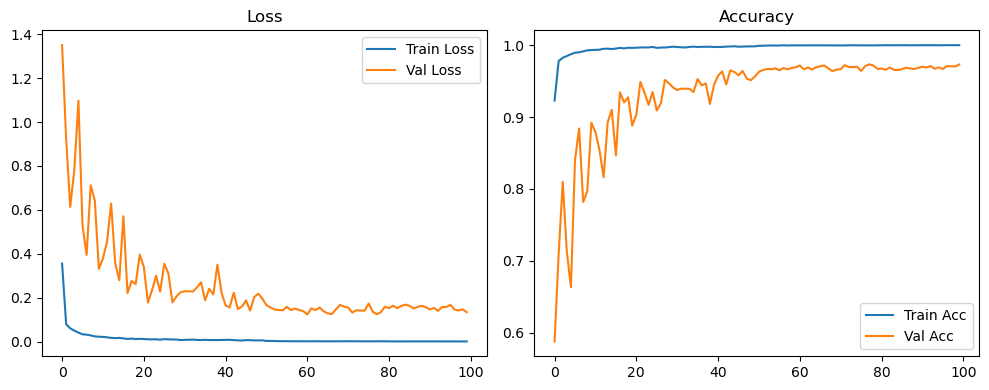

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6023, Acc: 0.8285 | Val Loss: 2.2692, Acc: 0.2349


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1715, Acc: 0.9514 | Val Loss: 2.0627, Acc: 0.3314


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1296, Acc: 0.9614 | Val Loss: 1.6693, Acc: 0.3888


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1057, Acc: 0.9691 | Val Loss: 2.1576, Acc: 0.3877


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0966, Acc: 0.9714 | Val Loss: 1.5829, Acc: 0.4682


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0828, Acc: 0.9749 | Val Loss: 1.3640, Acc: 0.5553


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0767, Acc: 0.9765 | Val Loss: 1.6076, Acc: 0.5197


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0731, Acc: 0.9771 | Val Loss: 1.2735, Acc: 0.5912


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0685, Acc: 0.9785 | Val Loss: 1.4120, Acc: 0.5520


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0678, Acc: 0.9794 | Val Loss: 1.5997, Acc: 0.5128


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0654, Acc: 0.9808 | Val Loss: 1.7735, Acc: 0.4804


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0611, Acc: 0.9816 | Val Loss: 1.3448, Acc: 0.5787


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0612, Acc: 0.9817 | Val Loss: 0.8537, Acc: 0.7242


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0589, Acc: 0.9815 | Val Loss: 0.9830, Acc: 0.6989


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0547, Acc: 0.9829 | Val Loss: 1.0738, Acc: 0.6567


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0548, Acc: 0.9831 | Val Loss: 1.2422, Acc: 0.6340


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0511, Acc: 0.9844 | Val Loss: 1.2248, Acc: 0.6420


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0520, Acc: 0.9834 | Val Loss: 1.0373, Acc: 0.6891


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0496, Acc: 0.9844 | Val Loss: 1.2381, Acc: 0.6430


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0468, Acc: 0.9848 | Val Loss: 1.2935, Acc: 0.6173


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0478, Acc: 0.9847 | Val Loss: 0.9958, Acc: 0.6868


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0473, Acc: 0.9846 | Val Loss: 1.0980, Acc: 0.6782


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0476, Acc: 0.9851 | Val Loss: 1.1124, Acc: 0.6727


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0470, Acc: 0.9852 | Val Loss: 1.3619, Acc: 0.6297


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0450, Acc: 0.9852 | Val Loss: 0.9486, Acc: 0.7272


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0431, Acc: 0.9862 | Val Loss: 1.0073, Acc: 0.7148


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0437, Acc: 0.9860 | Val Loss: 0.9947, Acc: 0.7306


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0422, Acc: 0.9861 | Val Loss: 0.9036, Acc: 0.7192


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0415, Acc: 0.9868 | Val Loss: 1.1115, Acc: 0.6783


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9872 | Val Loss: 1.1788, Acc: 0.6710


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0414, Acc: 0.9865 | Val Loss: 0.9609, Acc: 0.7248


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0391, Acc: 0.9871 | Val Loss: 0.8188, Acc: 0.7474


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0403, Acc: 0.9868 | Val Loss: 1.1235, Acc: 0.6981


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0380, Acc: 0.9874 | Val Loss: 0.8669, Acc: 0.7745


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0381, Acc: 0.9875 | Val Loss: 0.8334, Acc: 0.7694


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0392, Acc: 0.9876 | Val Loss: 0.8795, Acc: 0.7468


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0371, Acc: 0.9880 | Val Loss: 0.9922, Acc: 0.7312


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0354, Acc: 0.9888 | Val Loss: 0.7436, Acc: 0.7758


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0372, Acc: 0.9881 | Val Loss: 0.6657, Acc: 0.7877


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0382, Acc: 0.9877 | Val Loss: 0.6862, Acc: 0.7791


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0377, Acc: 0.9876 | Val Loss: 0.9183, Acc: 0.7338


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0341, Acc: 0.9889 | Val Loss: 0.7881, Acc: 0.7689


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0327, Acc: 0.9889 | Val Loss: 0.8488, Acc: 0.7499


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0357, Acc: 0.9885 | Val Loss: 0.4256, Acc: 0.8492


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0335, Acc: 0.9889 | Val Loss: 0.5401, Acc: 0.8194


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9888 | Val Loss: 0.7489, Acc: 0.7688


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0340, Acc: 0.9885 | Val Loss: 0.5580, Acc: 0.8173


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9895 | Val Loss: 0.6235, Acc: 0.8055


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0356, Acc: 0.9884 | Val Loss: 0.6533, Acc: 0.8089


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0318, Acc: 0.9894 | Val Loss: 0.6723, Acc: 0.8044


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0285, Acc: 0.9906 | Val Loss: 0.5681, Acc: 0.8297


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0253, Acc: 0.9915 | Val Loss: 0.5938, Acc: 0.8221


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0247, Acc: 0.9918 | Val Loss: 0.5367, Acc: 0.8333


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0239, Acc: 0.9924 | Val Loss: 0.6065, Acc: 0.8170


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0225, Acc: 0.9925 | Val Loss: 0.5479, Acc: 0.8340


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0221, Acc: 0.9925 | Val Loss: 0.5383, Acc: 0.8343


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0229, Acc: 0.9922 | Val Loss: 0.6148, Acc: 0.8159


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0226, Acc: 0.9927 | Val Loss: 0.6272, Acc: 0.8197


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0232, Acc: 0.9927 | Val Loss: 0.6369, Acc: 0.8126


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0235, Acc: 0.9928 | Val Loss: 0.5296, Acc: 0.8381


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0236, Acc: 0.9923 | Val Loss: 0.5432, Acc: 0.8303


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0227, Acc: 0.9926 | Val Loss: 0.5325, Acc: 0.8400


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0221, Acc: 0.9926 | Val Loss: 0.5806, Acc: 0.8247


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0212, Acc: 0.9930 | Val Loss: 0.6059, Acc: 0.8199


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0213, Acc: 0.9928 | Val Loss: 0.4862, Acc: 0.8446


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0213, Acc: 0.9933 | Val Loss: 0.4423, Acc: 0.8538


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0212, Acc: 0.9928 | Val Loss: 0.4622, Acc: 0.8520


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0209, Acc: 0.9930 | Val Loss: 0.5369, Acc: 0.8331


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0207, Acc: 0.9929 | Val Loss: 0.5327, Acc: 0.8323


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0196, Acc: 0.9931 | Val Loss: 0.5015, Acc: 0.8448


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0209, Acc: 0.9934 | Val Loss: 0.5320, Acc: 0.8376


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0201, Acc: 0.9933 | Val Loss: 0.5091, Acc: 0.8393


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0208, Acc: 0.9936 | Val Loss: 0.5492, Acc: 0.8283


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0202, Acc: 0.9932 | Val Loss: 0.5113, Acc: 0.8369


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0212, Acc: 0.9929 | Val Loss: 0.5081, Acc: 0.8421


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0214, Acc: 0.9924 | Val Loss: 0.4205, Acc: 0.8652


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0190, Acc: 0.9934 | Val Loss: 0.4509, Acc: 0.8562


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0211, Acc: 0.9932 | Val Loss: 0.4285, Acc: 0.8608


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0192, Acc: 0.9933 | Val Loss: 0.4679, Acc: 0.8538


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0208, Acc: 0.9931 | Val Loss: 0.4579, Acc: 0.8568


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0189, Acc: 0.9942 | Val Loss: 0.4054, Acc: 0.8683


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0187, Acc: 0.9935 | Val Loss: 0.4370, Acc: 0.8623


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0170, Acc: 0.9941 | Val Loss: 0.4372, Acc: 0.8612


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0198, Acc: 0.9932 | Val Loss: 0.4844, Acc: 0.8522


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0178, Acc: 0.9939 | Val Loss: 0.4777, Acc: 0.8526


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0178, Acc: 0.9943 | Val Loss: 0.4744, Acc: 0.8518


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0183, Acc: 0.9939 | Val Loss: 0.4873, Acc: 0.8501


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0180, Acc: 0.9938 | Val Loss: 0.5303, Acc: 0.8386


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0189, Acc: 0.9938 | Val Loss: 0.5031, Acc: 0.8459


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0168, Acc: 0.9941 | Val Loss: 0.4810, Acc: 0.8523


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0198, Acc: 0.9934 | Val Loss: 0.4322, Acc: 0.8642


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0182, Acc: 0.9940 | Val Loss: 0.4974, Acc: 0.8475


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0170, Acc: 0.9939 | Val Loss: 0.4509, Acc: 0.8568


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0192, Acc: 0.9935 | Val Loss: 0.5229, Acc: 0.8436


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0182, Acc: 0.9937 | Val Loss: 0.4705, Acc: 0.8528


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0179, Acc: 0.9941 | Val Loss: 0.4953, Acc: 0.8478


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0171, Acc: 0.9942 | Val Loss: 0.4083, Acc: 0.8688


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0181, Acc: 0.9940 | Val Loss: 0.3943, Acc: 0.8729


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0174, Acc: 0.9941 | Val Loss: 0.4388, Acc: 0.8602


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0174, Acc: 0.9939 | Val Loss: 0.4055, Acc: 0.8723


Final Test Loss: 0.3936 Accuracy: 0.8719


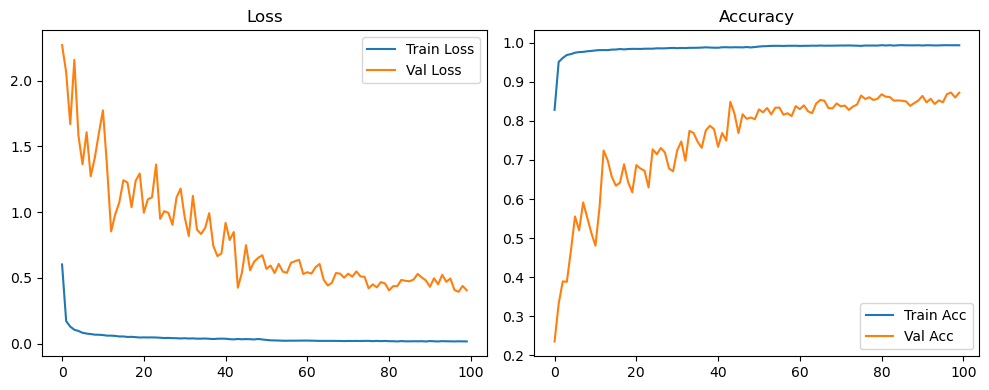

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3891, Acc: 0.9497 | Val Loss: 0.3934, Acc: 0.8836


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0609, Acc: 0.9864 | Val Loss: 0.3283, Acc: 0.8855


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0381, Acc: 0.9909 | Val Loss: 0.0862, Acc: 0.9781


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0281, Acc: 0.9931 | Val Loss: 0.0683, Acc: 0.9789


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0201, Acc: 0.9948 | Val Loss: 0.0858, Acc: 0.9758


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9973 | Val Loss: 0.1575, Acc: 0.9529


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9972 | Val Loss: 0.1080, Acc: 0.9674


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9985 | Val Loss: 0.0565, Acc: 0.9822


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9994 | Val Loss: 0.0789, Acc: 0.9764


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9997 | Val Loss: 0.0660, Acc: 0.9819


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9989 | Val Loss: 0.1096, Acc: 0.9638


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9978 | Val Loss: 0.0678, Acc: 0.9788


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9985 | Val Loss: 0.0659, Acc: 0.9795


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9992 | Val Loss: 0.0510, Acc: 0.9846


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9989 | Val Loss: 0.0798, Acc: 0.9768


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9999 | Val Loss: 0.0491, Acc: 0.9862


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 1.0000 | Val Loss: 0.0314, Acc: 0.9912


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0305, Acc: 0.9920


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0308, Acc: 0.9922


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0308, Acc: 0.9921


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0302, Acc: 0.9926


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0306, Acc: 0.9925


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0312, Acc: 0.9923


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0319, Acc: 0.9920


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0316, Acc: 0.9919


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0311, Acc: 0.9925


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0320, Acc: 0.9921


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0324, Acc: 0.9921


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0322, Acc: 0.9920


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0322, Acc: 0.9922


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0329, Acc: 0.9921


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0328, Acc: 0.9920


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0329, Acc: 0.9920


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0336, Acc: 0.9922


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0349, Acc: 0.9916


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0337, Acc: 0.9921


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0341, Acc: 0.9922


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0338, Acc: 0.9922


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0345, Acc: 0.9919


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0352, Acc: 0.9918


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0352, Acc: 0.9915


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0350, Acc: 0.9919


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0349, Acc: 0.9923


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0351, Acc: 0.9922


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0348, Acc: 0.9923


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0363, Acc: 0.9919


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0354, Acc: 0.9919


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0367, Acc: 0.9916


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0374, Acc: 0.9920


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0379, Acc: 0.9918


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0368, Acc: 0.9917


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0374, Acc: 0.9918


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0381, Acc: 0.9918


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0377, Acc: 0.9916


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0391, Acc: 0.9920


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0395, Acc: 0.9916


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0389, Acc: 0.9917


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0392, Acc: 0.9917


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0399, Acc: 0.9920


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0396, Acc: 0.9916


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0397, Acc: 0.9918


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0406, Acc: 0.9917


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0409, Acc: 0.9913


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0405, Acc: 0.9918


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0411, Acc: 0.9915


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0406, Acc: 0.9915


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0412, Acc: 0.9913


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0408, Acc: 0.9920


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0424, Acc: 0.9916


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0424, Acc: 0.9914


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0415, Acc: 0.9916


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0421, Acc: 0.9917


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0413, Acc: 0.9918


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0428, Acc: 0.9919


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0442, Acc: 0.9916


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0431, Acc: 0.9920


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0437, Acc: 0.9919


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0450, Acc: 0.9915


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0430, Acc: 0.9920


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0436, Acc: 0.9918


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0437, Acc: 0.9922


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0443, Acc: 0.9920


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0454, Acc: 0.9915


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0458, Acc: 0.9916


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0444, Acc: 0.9920


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0450, Acc: 0.9916


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0458, Acc: 0.9915


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0469, Acc: 0.9915


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0471, Acc: 0.9919


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0475, Acc: 0.9916


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0457, Acc: 0.9922


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0474, Acc: 0.9913


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0470, Acc: 0.9917


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0480, Acc: 0.9918


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0482, Acc: 0.9918


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0494, Acc: 0.9922


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0458, Acc: 0.9892 | Val Loss: 0.1318, Acc: 0.9631


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0238, Acc: 0.9926 | Val Loss: 0.0892, Acc: 0.9758


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.0369, Acc: 0.9891


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9994 | Val Loss: 0.0330, Acc: 0.9902


Final Test Loss: 0.0326 Accuracy: 0.9916


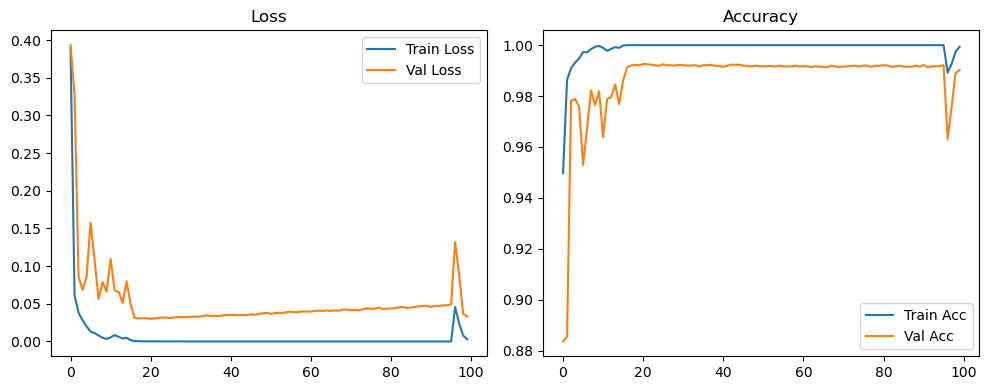

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4678, Acc: 0.9240 | Val Loss: 1.0184, Acc: 0.6405


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0941, Acc: 0.9776 | Val Loss: 1.0258, Acc: 0.6957


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0678, Acc: 0.9811 | Val Loss: 0.8742, Acc: 0.7171


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0552, Acc: 0.9841 | Val Loss: 1.3761, Acc: 0.5668


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0459, Acc: 0.9866 | Val Loss: 1.0005, Acc: 0.6555


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0386, Acc: 0.9883 | Val Loss: 0.7977, Acc: 0.7678


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0358, Acc: 0.9896 | Val Loss: 1.1161, Acc: 0.6842


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0309, Acc: 0.9908 | Val Loss: 1.1699, Acc: 0.6963


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0276, Acc: 0.9917 | Val Loss: 1.0308, Acc: 0.6438


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9916 | Val Loss: 0.5483, Acc: 0.8079


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0226, Acc: 0.9931 | Val Loss: 0.9574, Acc: 0.7045


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0213, Acc: 0.9932 | Val Loss: 0.6443, Acc: 0.7910


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0186, Acc: 0.9945 | Val Loss: 0.7912, Acc: 0.7707


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9943 | Val Loss: 0.6806, Acc: 0.7980


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0172, Acc: 0.9945 | Val Loss: 0.7633, Acc: 0.7658


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0156, Acc: 0.9952 | Val Loss: 0.4760, Acc: 0.8499


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9955 | Val Loss: 0.5120, Acc: 0.8363


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9954 | Val Loss: 0.5842, Acc: 0.8147


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9960 | Val Loss: 0.7596, Acc: 0.7729


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.5948, Acc: 0.8163


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 1.1039, Acc: 0.6857


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.3395, Acc: 0.8926


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9967 | Val Loss: 0.5467, Acc: 0.8374


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9963 | Val Loss: 0.4892, Acc: 0.8451


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.4019, Acc: 0.8821


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.4660, Acc: 0.8658


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.5555, Acc: 0.8309


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.5172, Acc: 0.8521


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.3199, Acc: 0.9084


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.4354, Acc: 0.8720


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.2506, Acc: 0.9282


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.5150, Acc: 0.8593


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.4071, Acc: 0.8889


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.3538, Acc: 0.9014


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9974 | Val Loss: 0.4516, Acc: 0.8808


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.2524, Acc: 0.9289


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.1451, Acc: 0.9586


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.3251, Acc: 0.9098


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.3638, Acc: 0.9025


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9975 | Val Loss: 0.1451, Acc: 0.9598


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.2459, Acc: 0.9310


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.1980, Acc: 0.9480


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.3385, Acc: 0.9121


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.3061, Acc: 0.9228


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9982 | Val Loss: 0.3283, Acc: 0.9181


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.2269, Acc: 0.9415


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.3491, Acc: 0.9117


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.4454, Acc: 0.8918


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.3362, Acc: 0.9185


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.3967, Acc: 0.9012


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.2317, Acc: 0.9421


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.2220, Acc: 0.9476


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.3835, Acc: 0.9060


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.2015, Acc: 0.9513


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.2917, Acc: 0.9302


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.3466, Acc: 0.9169


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.2194, Acc: 0.9466


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.1770, Acc: 0.9557


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9982 | Val Loss: 0.1883, Acc: 0.9560


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.3362, Acc: 0.9249


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.2711, Acc: 0.9369


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.3127, Acc: 0.9249


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.4015, Acc: 0.9084


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.3036, Acc: 0.9289


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9983 | Val Loss: 0.2809, Acc: 0.9343


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.2546, Acc: 0.9395


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.3179, Acc: 0.9272


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.2962, Acc: 0.9319


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.4986, Acc: 0.8912


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.2361, Acc: 0.9461


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.2720, Acc: 0.9372


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.2240, Acc: 0.9468


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.2818, Acc: 0.9369


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.3206, Acc: 0.9296


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.2526, Acc: 0.9457


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.3530, Acc: 0.9221


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.2805, Acc: 0.9385


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9984 | Val Loss: 0.3319, Acc: 0.9277


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1868, Acc: 0.9568


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.2487, Acc: 0.9459


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.2452, Acc: 0.9455


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.2909, Acc: 0.9390


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.3340, Acc: 0.9298


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.2389, Acc: 0.9502


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.2135, Acc: 0.9545


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.2530, Acc: 0.9478


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.2538, Acc: 0.9457


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.3501, Acc: 0.9248


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.2961, Acc: 0.9381


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.2198, Acc: 0.9530


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9992 | Val Loss: 0.2534, Acc: 0.9475


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.2940, Acc: 0.9426


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.2636, Acc: 0.9456


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.2684, Acc: 0.9453


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.2684, Acc: 0.9476


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9988 | Val Loss: 0.2456, Acc: 0.9517


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.2367, Acc: 0.9521


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.2329, Acc: 0.9495


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.2523, Acc: 0.9492


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.2923, Acc: 0.9411


Final Test Loss: 0.2998 Accuracy: 0.9410


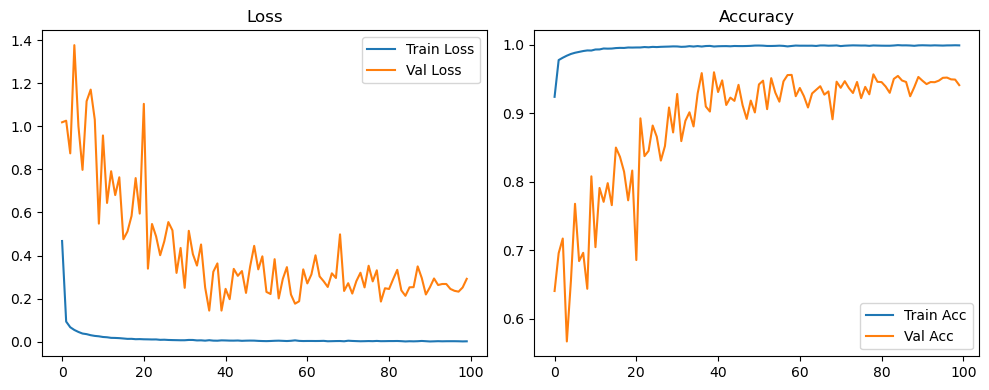

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.7592, Acc: 0.8040 | Val Loss: 2.4269, Acc: 0.1293


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2271, Acc: 0.9393 | Val Loss: 2.4402, Acc: 0.2067


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1610, Acc: 0.9554 | Val Loss: 2.3751, Acc: 0.2367


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1281, Acc: 0.9625 | Val Loss: 2.5510, Acc: 0.2491


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1137, Acc: 0.9669 | Val Loss: 2.4563, Acc: 0.2582


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0970, Acc: 0.9713 | Val Loss: 2.2003, Acc: 0.3311


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0898, Acc: 0.9737 | Val Loss: 2.7720, Acc: 0.3083


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0844, Acc: 0.9746 | Val Loss: 2.3526, Acc: 0.3358


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0785, Acc: 0.9757 | Val Loss: 2.5078, Acc: 0.3084


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0772, Acc: 0.9767 | Val Loss: 2.4124, Acc: 0.3363


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0733, Acc: 0.9781 | Val Loss: 2.7547, Acc: 0.2804


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0672, Acc: 0.9802 | Val Loss: 2.3114, Acc: 0.3745


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0662, Acc: 0.9799 | Val Loss: 2.0488, Acc: 0.4213


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0648, Acc: 0.9806 | Val Loss: 2.5608, Acc: 0.3947


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0607, Acc: 0.9819 | Val Loss: 2.5022, Acc: 0.3909


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0590, Acc: 0.9820 | Val Loss: 2.3612, Acc: 0.4113


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0578, Acc: 0.9831 | Val Loss: 2.5689, Acc: 0.3902


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0546, Acc: 0.9836 | Val Loss: 2.5059, Acc: 0.4099


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0534, Acc: 0.9835 | Val Loss: 2.2127, Acc: 0.4514


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0537, Acc: 0.9833 | Val Loss: 2.4857, Acc: 0.4224


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0496, Acc: 0.9847 | Val Loss: 1.8541, Acc: 0.5078


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0492, Acc: 0.9841 | Val Loss: 2.3173, Acc: 0.4164


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0488, Acc: 0.9846 | Val Loss: 2.2051, Acc: 0.4592


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0518, Acc: 0.9849 | Val Loss: 2.6890, Acc: 0.4180


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0486, Acc: 0.9846 | Val Loss: 1.8116, Acc: 0.5176


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0472, Acc: 0.9855 | Val Loss: 1.5133, Acc: 0.5656


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0475, Acc: 0.9851 | Val Loss: 1.8096, Acc: 0.5216


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0452, Acc: 0.9861 | Val Loss: 2.0916, Acc: 0.4657


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0436, Acc: 0.9868 | Val Loss: 1.7946, Acc: 0.5103


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0421, Acc: 0.9865 | Val Loss: 2.0316, Acc: 0.4965


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0428, Acc: 0.9868 | Val Loss: 1.5103, Acc: 0.5642


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0435, Acc: 0.9860 | Val Loss: 1.3498, Acc: 0.5797


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0425, Acc: 0.9861 | Val Loss: 1.5155, Acc: 0.5636


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0405, Acc: 0.9871 | Val Loss: 1.4597, Acc: 0.5752


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0399, Acc: 0.9871 | Val Loss: 1.6193, Acc: 0.5491


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0394, Acc: 0.9874 | Val Loss: 1.6271, Acc: 0.5316


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0397, Acc: 0.9872 | Val Loss: 1.4389, Acc: 0.5889


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0380, Acc: 0.9880 | Val Loss: 0.9598, Acc: 0.6963


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0389, Acc: 0.9878 | Val Loss: 1.1844, Acc: 0.6357


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0365, Acc: 0.9887 | Val Loss: 0.9942, Acc: 0.6798


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0387, Acc: 0.9872 | Val Loss: 1.4454, Acc: 0.5690


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0384, Acc: 0.9876 | Val Loss: 1.0789, Acc: 0.6637


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0344, Acc: 0.9892 | Val Loss: 1.1554, Acc: 0.6368


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0364, Acc: 0.9884 | Val Loss: 0.8652, Acc: 0.7211


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0358, Acc: 0.9880 | Val Loss: 0.7606, Acc: 0.7512


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0354, Acc: 0.9889 | Val Loss: 1.1231, Acc: 0.6589


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0356, Acc: 0.9882 | Val Loss: 0.9278, Acc: 0.7025


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0340, Acc: 0.9890 | Val Loss: 0.9812, Acc: 0.7032


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0352, Acc: 0.9884 | Val Loss: 1.2042, Acc: 0.6516


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0349, Acc: 0.9888 | Val Loss: 0.8410, Acc: 0.7328


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0339, Acc: 0.9889 | Val Loss: 0.8242, Acc: 0.7333


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0328, Acc: 0.9896 | Val Loss: 0.6617, Acc: 0.7863


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0340, Acc: 0.9891 | Val Loss: 0.7725, Acc: 0.7402


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0320, Acc: 0.9897 | Val Loss: 0.5330, Acc: 0.8181


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0317, Acc: 0.9896 | Val Loss: 0.8166, Acc: 0.7454


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0310, Acc: 0.9899 | Val Loss: 0.7297, Acc: 0.7629


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0316, Acc: 0.9899 | Val Loss: 0.8467, Acc: 0.7292


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0334, Acc: 0.9894 | Val Loss: 0.8613, Acc: 0.7379


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0327, Acc: 0.9902 | Val Loss: 0.9342, Acc: 0.7143


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0333, Acc: 0.9892 | Val Loss: 0.8918, Acc: 0.7248


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0326, Acc: 0.9895 | Val Loss: 0.9354, Acc: 0.7065


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0305, Acc: 0.9902 | Val Loss: 0.7000, Acc: 0.7699


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0303, Acc: 0.9898 | Val Loss: 0.9274, Acc: 0.7179


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0307, Acc: 0.9899 | Val Loss: 0.8847, Acc: 0.7221


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0301, Acc: 0.9900 | Val Loss: 0.9205, Acc: 0.7127


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0283, Acc: 0.9904 | Val Loss: 0.8518, Acc: 0.7269


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0308, Acc: 0.9892 | Val Loss: 0.7041, Acc: 0.7688


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0283, Acc: 0.9905 | Val Loss: 0.7442, Acc: 0.7705


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0296, Acc: 0.9906 | Val Loss: 0.7796, Acc: 0.7605


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0280, Acc: 0.9910 | Val Loss: 0.8447, Acc: 0.7509


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0288, Acc: 0.9907 | Val Loss: 1.0509, Acc: 0.7095


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0281, Acc: 0.9900 | Val Loss: 0.8010, Acc: 0.7591


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0289, Acc: 0.9905 | Val Loss: 0.7023, Acc: 0.7743


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0269, Acc: 0.9912 | Val Loss: 0.7977, Acc: 0.7535


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0297, Acc: 0.9904 | Val Loss: 0.8433, Acc: 0.7466


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0288, Acc: 0.9903 | Val Loss: 0.5647, Acc: 0.8185


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0267, Acc: 0.9906 | Val Loss: 0.6741, Acc: 0.7970


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9914 | Val Loss: 0.8197, Acc: 0.7564


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9917 | Val Loss: 0.8235, Acc: 0.7498


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0294, Acc: 0.9898 | Val Loss: 0.8935, Acc: 0.7352


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9914 | Val Loss: 0.6816, Acc: 0.7857


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0270, Acc: 0.9908 | Val Loss: 0.9936, Acc: 0.7182


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0263, Acc: 0.9917 | Val Loss: 0.6889, Acc: 0.7865


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0275, Acc: 0.9908 | Val Loss: 0.8786, Acc: 0.7492


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9912 | Val Loss: 0.7031, Acc: 0.7893


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9915 | Val Loss: 0.7171, Acc: 0.7748


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9919 | Val Loss: 0.7740, Acc: 0.7594


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0249, Acc: 0.9914 | Val Loss: 0.8095, Acc: 0.7527


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9917 | Val Loss: 0.8660, Acc: 0.7443


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0287, Acc: 0.9910 | Val Loss: 0.8569, Acc: 0.7432


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9915 | Val Loss: 0.7580, Acc: 0.7656


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9914 | Val Loss: 0.9353, Acc: 0.7304


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0255, Acc: 0.9912 | Val Loss: 0.5592, Acc: 0.8225


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9918 | Val Loss: 0.9137, Acc: 0.7342


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0260, Acc: 0.9912 | Val Loss: 0.7304, Acc: 0.7711


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0250, Acc: 0.9916 | Val Loss: 0.8751, Acc: 0.7376


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0240, Acc: 0.9921 | Val Loss: 0.8786, Acc: 0.7431


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0243, Acc: 0.9917 | Val Loss: 0.5242, Acc: 0.8377


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9913 | Val Loss: 0.9018, Acc: 0.7393


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0239, Acc: 0.9920 | Val Loss: 0.6141, Acc: 0.8153


Final Test Loss: 0.5936 Accuracy: 0.8211


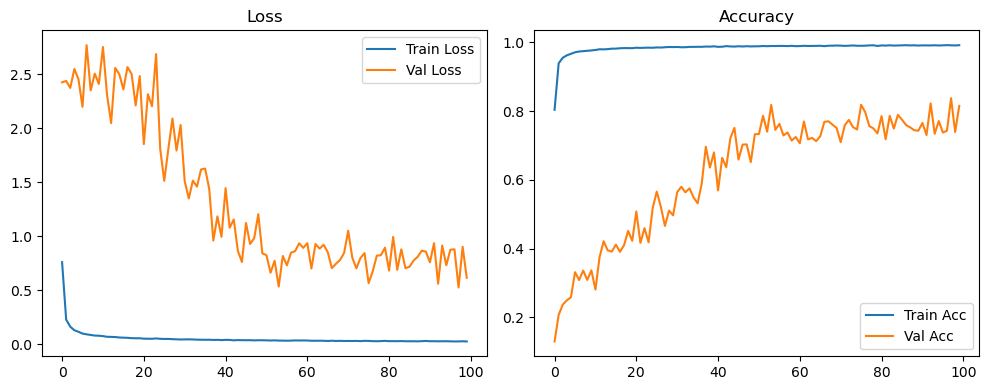

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3891, Acc: 0.9500 | Val Loss: 0.3226, Acc: 0.9080


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0607, Acc: 0.9864 | Val Loss: 0.2448, Acc: 0.9236


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0381, Acc: 0.9910 | Val Loss: 0.0686, Acc: 0.9818


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0279, Acc: 0.9933 | Val Loss: 0.1196, Acc: 0.9601


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0201, Acc: 0.9949 | Val Loss: 0.0999, Acc: 0.9740


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9970 | Val Loss: 0.1270, Acc: 0.9618


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9973 | Val Loss: 0.0887, Acc: 0.9717


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9987 | Val Loss: 0.0484, Acc: 0.9850


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9991 | Val Loss: 0.1603, Acc: 0.9555


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9994 | Val Loss: 0.0646, Acc: 0.9814


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9999 | Val Loss: 0.0375, Acc: 0.9890


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 1.0000 | Val Loss: 0.0308, Acc: 0.9915


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 1.0000 | Val Loss: 0.0338, Acc: 0.9909


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0303, Acc: 0.9914


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0310, Acc: 0.9916


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0310, Acc: 0.9915


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0312, Acc: 0.9918


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0323, Acc: 0.9908


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0321, Acc: 0.9913


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0326, Acc: 0.9912


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0322, Acc: 0.9916


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0322, Acc: 0.9912


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0326, Acc: 0.9914


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0335, Acc: 0.9912


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0336, Acc: 0.9913


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0326, Acc: 0.9914


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0333, Acc: 0.9912


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0343, Acc: 0.9918


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0338, Acc: 0.9917


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0338, Acc: 0.9921


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0348, Acc: 0.9913


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0348, Acc: 0.9911


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0350, Acc: 0.9910


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0355, Acc: 0.9914


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0373, Acc: 0.9909


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0355, Acc: 0.9911


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0360, Acc: 0.9914


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0358, Acc: 0.9914


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0369, Acc: 0.9914


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0373, Acc: 0.9914


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0386, Acc: 0.9908


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0377, Acc: 0.9912


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0369, Acc: 0.9917


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0375, Acc: 0.9913


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0360, Acc: 0.9917


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0382, Acc: 0.9916


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0384, Acc: 0.9912


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0388, Acc: 0.9913


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0396, Acc: 0.9913


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0399, Acc: 0.9910


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0386, Acc: 0.9916


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0386, Acc: 0.9918


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0391, Acc: 0.9913


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0389, Acc: 0.9912


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0392, Acc: 0.9918


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0399, Acc: 0.9916


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0397, Acc: 0.9918


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0397, Acc: 0.9913


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0399, Acc: 0.9912


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0405, Acc: 0.9912


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0401, Acc: 0.9913


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0404, Acc: 0.9915


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0407, Acc: 0.9915


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0404, Acc: 0.9914


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0411, Acc: 0.9913


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0407, Acc: 0.9912


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0410, Acc: 0.9913


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0410, Acc: 0.9910


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0411, Acc: 0.9912


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0423, Acc: 0.9912


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0422, Acc: 0.9921


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0414, Acc: 0.9914


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0418, Acc: 0.9909


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0255, Acc: 0.9922 | Val Loss: 0.0686, Acc: 0.9803


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9964 | Val Loss: 0.0565, Acc: 0.9842


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9996 | Val Loss: 0.0411, Acc: 0.9888


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 1.0000 | Val Loss: 0.0350, Acc: 0.9911


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0341, Acc: 0.9912


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0344, Acc: 0.9915


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0345, Acc: 0.9909


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0346, Acc: 0.9917


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0348, Acc: 0.9917


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0349, Acc: 0.9918


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0352, Acc: 0.9920


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0350, Acc: 0.9918


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0350, Acc: 0.9919


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0351, Acc: 0.9919


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0358, Acc: 0.9922


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0356, Acc: 0.9920


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0358, Acc: 0.9923


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0354, Acc: 0.9923


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0362, Acc: 0.9921


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0362, Acc: 0.9921


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0363, Acc: 0.9924


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0364, Acc: 0.9925


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0367, Acc: 0.9923


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0367, Acc: 0.9922


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0365, Acc: 0.9922


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0367, Acc: 0.9921


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0370, Acc: 0.9919


Final Test Loss: 0.0369 Accuracy: 0.9906


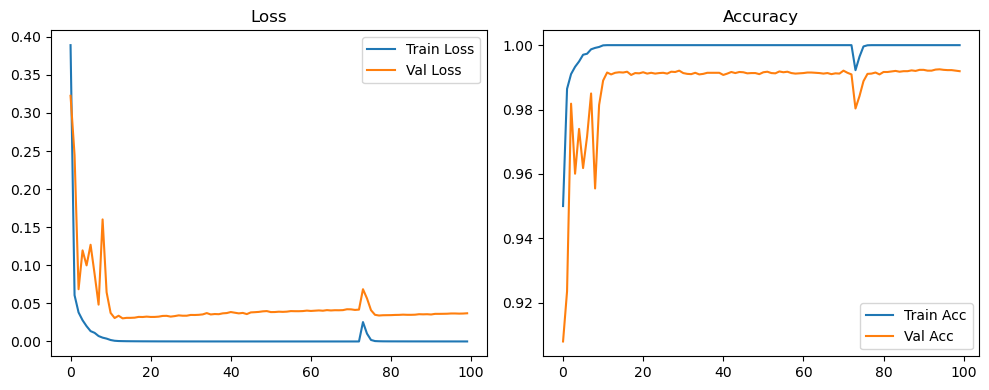

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4676, Acc: 0.9239 | Val Loss: 0.7879, Acc: 0.7374


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0943, Acc: 0.9775 | Val Loss: 1.0274, Acc: 0.6894


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0677, Acc: 0.9811 | Val Loss: 0.8636, Acc: 0.7185


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0551, Acc: 0.9842 | Val Loss: 1.4000, Acc: 0.5917


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0458, Acc: 0.9865 | Val Loss: 1.2606, Acc: 0.5853


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0385, Acc: 0.9883 | Val Loss: 0.7502, Acc: 0.7682


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0356, Acc: 0.9894 | Val Loss: 0.9687, Acc: 0.7051


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0307, Acc: 0.9908 | Val Loss: 0.9317, Acc: 0.7352


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0280, Acc: 0.9915 | Val Loss: 0.8060, Acc: 0.7133


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9915 | Val Loss: 0.7220, Acc: 0.7456


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9928 | Val Loss: 0.9396, Acc: 0.7063


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0215, Acc: 0.9928 | Val Loss: 0.7510, Acc: 0.7649


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0189, Acc: 0.9944 | Val Loss: 0.9739, Acc: 0.7160


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9945 | Val Loss: 1.0026, Acc: 0.7447


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9946 | Val Loss: 0.8964, Acc: 0.7378


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9951 | Val Loss: 0.5109, Acc: 0.8418


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9956 | Val Loss: 0.5074, Acc: 0.8347


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9949 | Val Loss: 0.4748, Acc: 0.8481


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9960 | Val Loss: 0.6423, Acc: 0.8047


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9957 | Val Loss: 0.4299, Acc: 0.8637


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9959 | Val Loss: 0.5186, Acc: 0.8349


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9958 | Val Loss: 0.3368, Acc: 0.8925


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.3470, Acc: 0.8945


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9963 | Val Loss: 0.5903, Acc: 0.8256


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.2666, Acc: 0.9175


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9964 | Val Loss: 0.5069, Acc: 0.8518


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.3742, Acc: 0.8862


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.2918, Acc: 0.9114


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.2677, Acc: 0.9202


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.4159, Acc: 0.8857


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.2950, Acc: 0.9147


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9970 | Val Loss: 0.4081, Acc: 0.8918


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.5166, Acc: 0.8580


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.3944, Acc: 0.8875


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.3476, Acc: 0.9035


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.2533, Acc: 0.9297


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.2498, Acc: 0.9304


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.2140, Acc: 0.9399


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.4661, Acc: 0.8754


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.2614, Acc: 0.9314


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.2096, Acc: 0.9427


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.1939, Acc: 0.9494


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.2309, Acc: 0.9399


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.2855, Acc: 0.9276


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9979 | Val Loss: 0.3360, Acc: 0.9151


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9975 | Val Loss: 0.3147, Acc: 0.9195


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.3215, Acc: 0.9126


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.3287, Acc: 0.9177


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.3100, Acc: 0.9240


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.2892, Acc: 0.9292


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.2666, Acc: 0.9345


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.2638, Acc: 0.9376


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.2706, Acc: 0.9343


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.2442, Acc: 0.9408


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.2249, Acc: 0.9440


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.2269, Acc: 0.9455


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1823, Acc: 0.9567


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.2170, Acc: 0.9468


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.2419, Acc: 0.9438


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.2019, Acc: 0.9520


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1951, Acc: 0.9545


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.2064, Acc: 0.9523


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.2398, Acc: 0.9451


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.2687, Acc: 0.9367


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9993 | Val Loss: 0.2004, Acc: 0.9526


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.2067, Acc: 0.9526


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.2505, Acc: 0.9430


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.2477, Acc: 0.9417


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.2203, Acc: 0.9467


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.2329, Acc: 0.9449


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.2325, Acc: 0.9464


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.2423, Acc: 0.9436


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.2113, Acc: 0.9540


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.2275, Acc: 0.9481


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.2601, Acc: 0.9418


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.2511, Acc: 0.9428


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.3120, Acc: 0.9283


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1936, Acc: 0.9563


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1974, Acc: 0.9550


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.2297, Acc: 0.9469


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1986, Acc: 0.9561


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.2230, Acc: 0.9507


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.2022, Acc: 0.9557


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.2030, Acc: 0.9547


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.2146, Acc: 0.9540


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.2175, Acc: 0.9533


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.2106, Acc: 0.9542


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.2065, Acc: 0.9546


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.2030, Acc: 0.9548


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1965, Acc: 0.9564


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1969, Acc: 0.9570


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.2069, Acc: 0.9538


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1922, Acc: 0.9581


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.2498, Acc: 0.9453


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.2246, Acc: 0.9508


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.2606, Acc: 0.9428


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.2370, Acc: 0.9487


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.2114, Acc: 0.9535


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.2101, Acc: 0.9548


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.2101, Acc: 0.9540


Final Test Loss: 0.2163 Accuracy: 0.9519


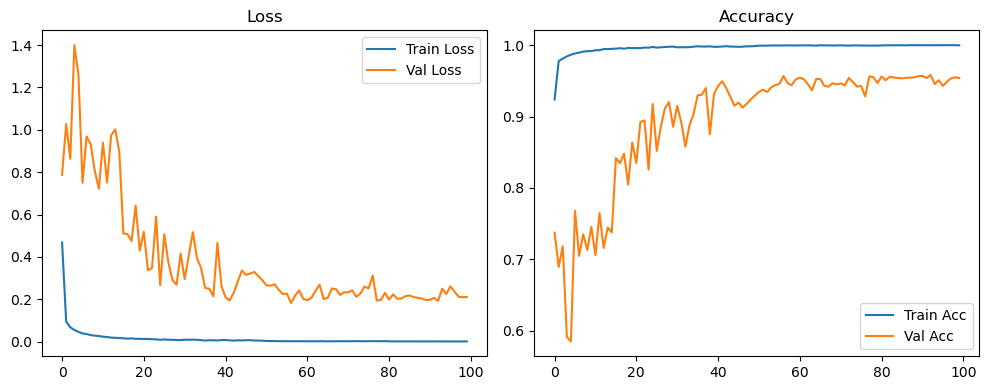

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.7592, Acc: 0.8038 | Val Loss: 2.4699, Acc: 0.1318


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2272, Acc: 0.9391 | Val Loss: 2.4325, Acc: 0.2058


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1610, Acc: 0.9554 | Val Loss: 2.3134, Acc: 0.2440


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1281, Acc: 0.9628 | Val Loss: 2.6110, Acc: 0.2455


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1135, Acc: 0.9669 | Val Loss: 2.4684, Acc: 0.2642


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0972, Acc: 0.9715 | Val Loss: 2.1813, Acc: 0.3332


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0899, Acc: 0.9737 | Val Loss: 2.8135, Acc: 0.3098


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0845, Acc: 0.9752 | Val Loss: 2.4667, Acc: 0.3232


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0786, Acc: 0.9756 | Val Loss: 2.5888, Acc: 0.3038


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0773, Acc: 0.9766 | Val Loss: 2.4577, Acc: 0.3312


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0730, Acc: 0.9781 | Val Loss: 2.8139, Acc: 0.2756


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0670, Acc: 0.9801 | Val Loss: 2.4393, Acc: 0.3553


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0661, Acc: 0.9801 | Val Loss: 2.0449, Acc: 0.4295


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0644, Acc: 0.9805 | Val Loss: 2.6277, Acc: 0.3761


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0608, Acc: 0.9821 | Val Loss: 2.3639, Acc: 0.4084


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0592, Acc: 0.9816 | Val Loss: 2.1606, Acc: 0.4370


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0576, Acc: 0.9824 | Val Loss: 2.5937, Acc: 0.3838


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0545, Acc: 0.9840 | Val Loss: 2.4197, Acc: 0.4242


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0542, Acc: 0.9832 | Val Loss: 2.2099, Acc: 0.4402


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0530, Acc: 0.9832 | Val Loss: 2.8212, Acc: 0.3756


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0495, Acc: 0.9848 | Val Loss: 2.0263, Acc: 0.4746


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0489, Acc: 0.9845 | Val Loss: 2.2550, Acc: 0.4333


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0486, Acc: 0.9849 | Val Loss: 2.5660, Acc: 0.4103


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0514, Acc: 0.9841 | Val Loss: 2.8642, Acc: 0.3923


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0483, Acc: 0.9849 | Val Loss: 1.9191, Acc: 0.5065


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0471, Acc: 0.9855 | Val Loss: 1.6741, Acc: 0.5384


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0475, Acc: 0.9855 | Val Loss: 1.8269, Acc: 0.5254


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0448, Acc: 0.9862 | Val Loss: 2.2211, Acc: 0.4527


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0428, Acc: 0.9865 | Val Loss: 1.8945, Acc: 0.4914


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0428, Acc: 0.9860 | Val Loss: 2.0714, Acc: 0.4853


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0426, Acc: 0.9870 | Val Loss: 1.5284, Acc: 0.5679


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0426, Acc: 0.9862 | Val Loss: 1.4220, Acc: 0.5779


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0423, Acc: 0.9865 | Val Loss: 1.4813, Acc: 0.5721


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0410, Acc: 0.9868 | Val Loss: 1.4307, Acc: 0.5752


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0401, Acc: 0.9874 | Val Loss: 1.5720, Acc: 0.5698


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0396, Acc: 0.9870 | Val Loss: 1.8805, Acc: 0.5007


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0400, Acc: 0.9874 | Val Loss: 1.8094, Acc: 0.5251


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0384, Acc: 0.9879 | Val Loss: 1.0263, Acc: 0.6909


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0388, Acc: 0.9875 | Val Loss: 1.5166, Acc: 0.5747


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0380, Acc: 0.9877 | Val Loss: 1.0611, Acc: 0.6734


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0385, Acc: 0.9875 | Val Loss: 1.5189, Acc: 0.5608


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0388, Acc: 0.9871 | Val Loss: 1.1170, Acc: 0.6599


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0350, Acc: 0.9889 | Val Loss: 1.1161, Acc: 0.6528


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0359, Acc: 0.9891 | Val Loss: 0.8800, Acc: 0.7210


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0360, Acc: 0.9875 | Val Loss: 0.8718, Acc: 0.7213


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0353, Acc: 0.9888 | Val Loss: 0.9662, Acc: 0.7003


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0357, Acc: 0.9881 | Val Loss: 1.0164, Acc: 0.6886


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0342, Acc: 0.9890 | Val Loss: 0.9155, Acc: 0.7222


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0341, Acc: 0.9894 | Val Loss: 1.0617, Acc: 0.6871


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0339, Acc: 0.9895 | Val Loss: 0.8321, Acc: 0.7368


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0314, Acc: 0.9897 | Val Loss: 0.7929, Acc: 0.7482


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0277, Acc: 0.9911 | Val Loss: 0.7339, Acc: 0.7653


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0288, Acc: 0.9911 | Val Loss: 0.6969, Acc: 0.7724


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0268, Acc: 0.9914 | Val Loss: 0.7867, Acc: 0.7532


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0272, Acc: 0.9913 | Val Loss: 0.7189, Acc: 0.7700


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0245, Acc: 0.9917 | Val Loss: 0.7187, Acc: 0.7719


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0260, Acc: 0.9916 | Val Loss: 0.8629, Acc: 0.7301


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0261, Acc: 0.9918 | Val Loss: 0.8436, Acc: 0.7425


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0269, Acc: 0.9918 | Val Loss: 0.7459, Acc: 0.7662


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0277, Acc: 0.9913 | Val Loss: 0.8019, Acc: 0.7500


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0270, Acc: 0.9912 | Val Loss: 0.8364, Acc: 0.7370


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0245, Acc: 0.9918 | Val Loss: 0.6753, Acc: 0.7849


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0249, Acc: 0.9916 | Val Loss: 0.8652, Acc: 0.7392


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0250, Acc: 0.9915 | Val Loss: 0.9260, Acc: 0.7218


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0251, Acc: 0.9921 | Val Loss: 0.8579, Acc: 0.7377


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0246, Acc: 0.9918 | Val Loss: 0.8366, Acc: 0.7368


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0254, Acc: 0.9916 | Val Loss: 0.7914, Acc: 0.7503


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0238, Acc: 0.9920 | Val Loss: 0.7694, Acc: 0.7628


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0233, Acc: 0.9919 | Val Loss: 0.7937, Acc: 0.7536


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0236, Acc: 0.9923 | Val Loss: 0.9156, Acc: 0.7271


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0229, Acc: 0.9926 | Val Loss: 0.9854, Acc: 0.7135


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0230, Acc: 0.9920 | Val Loss: 0.9495, Acc: 0.7170


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0249, Acc: 0.9920 | Val Loss: 0.9262, Acc: 0.7246


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0230, Acc: 0.9924 | Val Loss: 0.9394, Acc: 0.7216


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0250, Acc: 0.9917 | Val Loss: 0.8377, Acc: 0.7498


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0241, Acc: 0.9917 | Val Loss: 0.7443, Acc: 0.7678


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0223, Acc: 0.9921 | Val Loss: 0.7678, Acc: 0.7695


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0220, Acc: 0.9929 | Val Loss: 0.7733, Acc: 0.7689


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0230, Acc: 0.9924 | Val Loss: 0.7887, Acc: 0.7626


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0241, Acc: 0.9921 | Val Loss: 0.8796, Acc: 0.7404


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0209, Acc: 0.9929 | Val Loss: 0.7891, Acc: 0.7574


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0221, Acc: 0.9925 | Val Loss: 0.8513, Acc: 0.7434


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0208, Acc: 0.9932 | Val Loss: 0.7590, Acc: 0.7676


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0207, Acc: 0.9933 | Val Loss: 0.8427, Acc: 0.7522


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0199, Acc: 0.9935 | Val Loss: 0.7592, Acc: 0.7677


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0207, Acc: 0.9931 | Val Loss: 0.7520, Acc: 0.7692


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0200, Acc: 0.9935 | Val Loss: 0.8146, Acc: 0.7535


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0197, Acc: 0.9930 | Val Loss: 0.7868, Acc: 0.7592


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0211, Acc: 0.9928 | Val Loss: 0.8007, Acc: 0.7578


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0213, Acc: 0.9930 | Val Loss: 0.7148, Acc: 0.7790


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0201, Acc: 0.9934 | Val Loss: 0.6758, Acc: 0.7883


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0203, Acc: 0.9935 | Val Loss: 0.7890, Acc: 0.7612


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0198, Acc: 0.9934 | Val Loss: 0.6475, Acc: 0.7957


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0201, Acc: 0.9932 | Val Loss: 0.8413, Acc: 0.7478


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0199, Acc: 0.9934 | Val Loss: 0.8200, Acc: 0.7511


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0185, Acc: 0.9938 | Val Loss: 0.7871, Acc: 0.7620


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0184, Acc: 0.9938 | Val Loss: 0.8343, Acc: 0.7521


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0194, Acc: 0.9933 | Val Loss: 0.7253, Acc: 0.7792


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0199, Acc: 0.9936 | Val Loss: 0.7873, Acc: 0.7654


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0189, Acc: 0.9936 | Val Loss: 0.7234, Acc: 0.7839


Final Test Loss: 0.6864 Accuracy: 0.7926


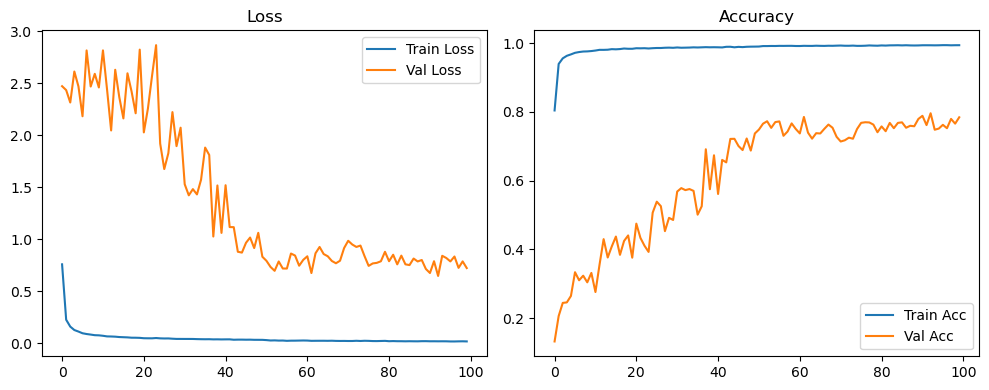

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.6551, Acc: 0.9483 | Val Loss: 0.2420, Acc: 0.9717


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1154, Acc: 0.9858 | Val Loss: 0.1057, Acc: 0.9799


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0607, Acc: 0.9909 | Val Loss: 0.2091, Acc: 0.9479


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0405, Acc: 0.9936 | Val Loss: 0.5121, Acc: 0.8067


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0293, Acc: 0.9949 | Val Loss: 0.0940, Acc: 0.9755


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0205, Acc: 0.9971 | Val Loss: 0.1025, Acc: 0.9728


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0167, Acc: 0.9973 | Val Loss: 0.0554, Acc: 0.9846


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9989 | Val Loss: 0.4718, Acc: 0.8336


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9992 | Val Loss: 0.0929, Acc: 0.9748


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9997 | Val Loss: 0.1361, Acc: 0.9586


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9994 | Val Loss: 0.3391, Acc: 0.8966


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9986 | Val Loss: 0.2126, Acc: 0.9391


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9998 | Val Loss: 0.0513, Acc: 0.9848


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9999 | Val Loss: 0.0316, Acc: 0.9904


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 1.0000 | Val Loss: 0.0305, Acc: 0.9905


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 1.0000 | Val Loss: 0.0336, Acc: 0.9899


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 1.0000 | Val Loss: 0.0300, Acc: 0.9908


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 1.0000 | Val Loss: 0.0330, Acc: 0.9900


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 1.0000 | Val Loss: 0.0322, Acc: 0.9903


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 1.0000 | Val Loss: 0.0333, Acc: 0.9905


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0308, Acc: 0.9904


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0310, Acc: 0.9901


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0313, Acc: 0.9906


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0316, Acc: 0.9905


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0325, Acc: 0.9903


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0329, Acc: 0.9905


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0313, Acc: 0.9908


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0320, Acc: 0.9906


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0327, Acc: 0.9908


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0327, Acc: 0.9901


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0325, Acc: 0.9905


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0330, Acc: 0.9908


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0360, Acc: 0.9898


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0343, Acc: 0.9907


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0354, Acc: 0.9898


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0345, Acc: 0.9902


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0340, Acc: 0.9907


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0351, Acc: 0.9907


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0345, Acc: 0.9906


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0350, Acc: 0.9903


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0368, Acc: 0.9901


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0367, Acc: 0.9897


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0359, Acc: 0.9902


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0375, Acc: 0.9901


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0152, Acc: 0.9954 | Val Loss: 2.8874, Acc: 0.4282


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0419, Acc: 0.9871 | Val Loss: 0.1014, Acc: 0.9673


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0148, Acc: 0.9958 | Val Loss: 0.0474, Acc: 0.9851


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9986 | Val Loss: 0.1172, Acc: 0.9665


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9996 | Val Loss: 0.0326, Acc: 0.9902


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9999 | Val Loss: 0.0420, Acc: 0.9867


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 1.0000 | Val Loss: 0.0341, Acc: 0.9909


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 1.0000 | Val Loss: 0.0299, Acc: 0.9908


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0312, Acc: 0.9908


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0319, Acc: 0.9915


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0322, Acc: 0.9918


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0316, Acc: 0.9914


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0313, Acc: 0.9918


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0313, Acc: 0.9912


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0328, Acc: 0.9912


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0327, Acc: 0.9915


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0323, Acc: 0.9914


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0327, Acc: 0.9917


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0321, Acc: 0.9916


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0331, Acc: 0.9916


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0330, Acc: 0.9912


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0327, Acc: 0.9916


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0336, Acc: 0.9914


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0335, Acc: 0.9913


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0344, Acc: 0.9917


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0344, Acc: 0.9912


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0336, Acc: 0.9916


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0339, Acc: 0.9915


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0339, Acc: 0.9913


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0349, Acc: 0.9910


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0347, Acc: 0.9912


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0355, Acc: 0.9912


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0356, Acc: 0.9908


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0353, Acc: 0.9913


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0354, Acc: 0.9914


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0356, Acc: 0.9912


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0358, Acc: 0.9912


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0358, Acc: 0.9914


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0363, Acc: 0.9914


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0363, Acc: 0.9913


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0367, Acc: 0.9914


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0372, Acc: 0.9913


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0367, Acc: 0.9912


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0373, Acc: 0.9913


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0381, Acc: 0.9909


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0394, Acc: 0.9907


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0371, Acc: 0.9913


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0386, Acc: 0.9910


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0381, Acc: 0.9912


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0389, Acc: 0.9912


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0387, Acc: 0.9910


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0490, Acc: 0.9893


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0271, Acc: 0.9922 | Val Loss: 0.5087, Acc: 0.8782


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.0520, Acc: 0.9853


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.0432, Acc: 0.9874


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9999 | Val Loss: 0.0355, Acc: 0.9907


Final Test Loss: 0.0316 Accuracy: 0.9905


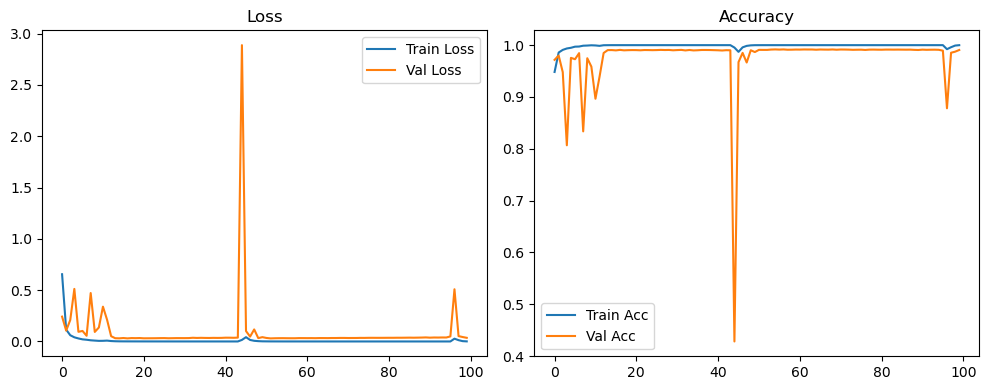

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.7571, Acc: 0.9145 | Val Loss: 1.0630, Acc: 0.5857


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1746, Acc: 0.9738 | Val Loss: 1.3544, Acc: 0.4988


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1034, Acc: 0.9798 | Val Loss: 1.0173, Acc: 0.6063


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0765, Acc: 0.9824 | Val Loss: 1.5989, Acc: 0.4359


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0623, Acc: 0.9848 | Val Loss: 1.7909, Acc: 0.3834


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0520, Acc: 0.9864 | Val Loss: 0.9950, Acc: 0.6332


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0472, Acc: 0.9878 | Val Loss: 1.7112, Acc: 0.4475


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0406, Acc: 0.9891 | Val Loss: 1.3511, Acc: 0.5627


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0363, Acc: 0.9903 | Val Loss: 1.1726, Acc: 0.6280


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0344, Acc: 0.9909 | Val Loss: 0.7707, Acc: 0.7266


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0310, Acc: 0.9910 | Val Loss: 1.1359, Acc: 0.5948


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0280, Acc: 0.9920 | Val Loss: 1.4429, Acc: 0.5485


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0248, Acc: 0.9930 | Val Loss: 1.4302, Acc: 0.5533


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0245, Acc: 0.9932 | Val Loss: 1.2206, Acc: 0.6448


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0230, Acc: 0.9933 | Val Loss: 1.6284, Acc: 0.5229


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0219, Acc: 0.9933 | Val Loss: 0.9111, Acc: 0.7093


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0191, Acc: 0.9945 | Val Loss: 1.2407, Acc: 0.6102


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0179, Acc: 0.9946 | Val Loss: 1.1238, Acc: 0.6305


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0166, Acc: 0.9950 | Val Loss: 1.0947, Acc: 0.6534


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0166, Acc: 0.9951 | Val Loss: 1.7858, Acc: 0.5333


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0150, Acc: 0.9959 | Val Loss: 1.0153, Acc: 0.6723


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0148, Acc: 0.9951 | Val Loss: 0.4928, Acc: 0.8268


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9952 | Val Loss: 0.9977, Acc: 0.6919


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0139, Acc: 0.9958 | Val Loss: 1.1725, Acc: 0.6433


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9963 | Val Loss: 0.6822, Acc: 0.7976


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9965 | Val Loss: 1.1313, Acc: 0.6840


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9964 | Val Loss: 0.6628, Acc: 0.7958


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9969 | Val Loss: 0.6551, Acc: 0.7977


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.5656, Acc: 0.8217


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9972 | Val Loss: 0.6214, Acc: 0.8022


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.9233, Acc: 0.7239


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.6003, Acc: 0.8069


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9959 | Val Loss: 0.9103, Acc: 0.7242


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.4876, Acc: 0.8438


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.5065, Acc: 0.8456


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 1.0947, Acc: 0.6954


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9968 | Val Loss: 0.4413, Acc: 0.8683


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.7713, Acc: 0.7860


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.6224, Acc: 0.8037


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 0.6504, Acc: 0.8060


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.5214, Acc: 0.8491


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.5035, Acc: 0.8489


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.7299, Acc: 0.8030


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.7619, Acc: 0.7947


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 1.0266, Acc: 0.7332


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.6506, Acc: 0.8099


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.8040, Acc: 0.7771


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.7627, Acc: 0.8030


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.7668, Acc: 0.8060


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.6850, Acc: 0.8124


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.6554, Acc: 0.8109


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.3762, Acc: 0.8953


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.4418, Acc: 0.8798


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.4969, Acc: 0.8638


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.4522, Acc: 0.8832


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.5828, Acc: 0.8452


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.8139, Acc: 0.8017


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.4448, Acc: 0.8798


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.4745, Acc: 0.8743


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.3358, Acc: 0.9078


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.5732, Acc: 0.8567


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.6071, Acc: 0.8491


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.3806, Acc: 0.8983


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.5001, Acc: 0.8668


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.3952, Acc: 0.9038


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.3852, Acc: 0.8978


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.4731, Acc: 0.8866


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.4395, Acc: 0.8874


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.4047, Acc: 0.8993


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.3230, Acc: 0.9223


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.5726, Acc: 0.8631


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.6098, Acc: 0.8560


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.4539, Acc: 0.8867


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.3395, Acc: 0.9155


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.3520, Acc: 0.9128


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.3019, Acc: 0.9250


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.4883, Acc: 0.8788


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.3922, Acc: 0.9076


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.4818, Acc: 0.8805


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9986 | Val Loss: 0.3557, Acc: 0.9107


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.4021, Acc: 0.9049


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.3657, Acc: 0.9097


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.3330, Acc: 0.9138


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.5142, Acc: 0.8795


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9994 | Val Loss: 0.5222, Acc: 0.8704


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.4894, Acc: 0.8820


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.3290, Acc: 0.9218


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.3342, Acc: 0.9170


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.2847, Acc: 0.9314


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.2955, Acc: 0.9290


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.4071, Acc: 0.9038


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.3619, Acc: 0.9080


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.4535, Acc: 0.8906


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.3615, Acc: 0.9127


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.2650, Acc: 0.9348


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9988 | Val Loss: 0.3511, Acc: 0.9097


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.2900, Acc: 0.9301


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.3421, Acc: 0.9183


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.2744, Acc: 0.9334


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.3109, Acc: 0.9249


Final Test Loss: 0.3331 Accuracy: 0.9219


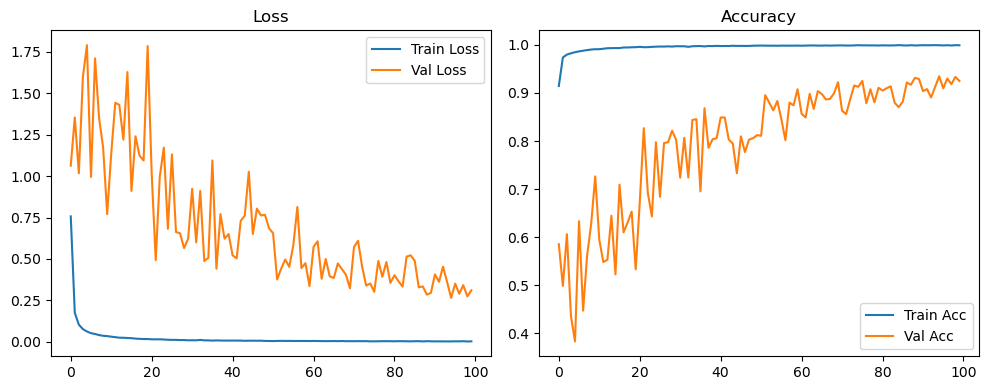

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 1.0936, Acc: 0.7451 | Val Loss: 2.5009, Acc: 0.1133


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.4120, Acc: 0.9045 | Val Loss: 2.6072, Acc: 0.1515


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.2597, Acc: 0.9351 | Val Loss: 2.4871, Acc: 0.2122


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.1957, Acc: 0.9486 | Val Loss: 2.8087, Acc: 0.2128


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.1646, Acc: 0.9556 | Val Loss: 2.8199, Acc: 0.2219


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.1395, Acc: 0.9606 | Val Loss: 2.4480, Acc: 0.2716


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.1234, Acc: 0.9644 | Val Loss: 2.7260, Acc: 0.2753


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.1129, Acc: 0.9672 | Val Loss: 2.5794, Acc: 0.3196


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.1051, Acc: 0.9702 | Val Loss: 2.7675, Acc: 0.2819


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.1008, Acc: 0.9704 | Val Loss: 2.9633, Acc: 0.2428


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0949, Acc: 0.9727 | Val Loss: 3.3411, Acc: 0.2228


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0862, Acc: 0.9748 | Val Loss: 2.8081, Acc: 0.2832


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0845, Acc: 0.9747 | Val Loss: 3.0940, Acc: 0.2522


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0821, Acc: 0.9757 | Val Loss: 3.2682, Acc: 0.2963


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0771, Acc: 0.9770 | Val Loss: 2.9835, Acc: 0.3031


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0740, Acc: 0.9780 | Val Loss: 2.9724, Acc: 0.3118


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0700, Acc: 0.9792 | Val Loss: 2.7317, Acc: 0.3384


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0674, Acc: 0.9793 | Val Loss: 2.7569, Acc: 0.3443


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0663, Acc: 0.9802 | Val Loss: 2.7070, Acc: 0.3653


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0621, Acc: 0.9810 | Val Loss: 2.6602, Acc: 0.3782


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0605, Acc: 0.9812 | Val Loss: 2.7896, Acc: 0.3435


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0586, Acc: 0.9822 | Val Loss: 2.7246, Acc: 0.3154


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0584, Acc: 0.9819 | Val Loss: 2.4410, Acc: 0.4068


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0609, Acc: 0.9818 | Val Loss: 2.9964, Acc: 0.3257


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0549, Acc: 0.9828 | Val Loss: 2.5647, Acc: 0.3588


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0547, Acc: 0.9833 | Val Loss: 2.3638, Acc: 0.3827


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0526, Acc: 0.9837 | Val Loss: 2.4764, Acc: 0.3744


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0546, Acc: 0.9834 | Val Loss: 2.7977, Acc: 0.3221


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0522, Acc: 0.9841 | Val Loss: 2.3417, Acc: 0.4106


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0500, Acc: 0.9846 | Val Loss: 2.2835, Acc: 0.4253


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0491, Acc: 0.9854 | Val Loss: 2.3066, Acc: 0.4098


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0490, Acc: 0.9844 | Val Loss: 2.2288, Acc: 0.3990


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0486, Acc: 0.9845 | Val Loss: 1.9825, Acc: 0.4497


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0470, Acc: 0.9850 | Val Loss: 2.1446, Acc: 0.4400


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0463, Acc: 0.9854 | Val Loss: 2.0155, Acc: 0.4718


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0449, Acc: 0.9855 | Val Loss: 1.7993, Acc: 0.4924


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0451, Acc: 0.9856 | Val Loss: 2.0654, Acc: 0.4612


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0445, Acc: 0.9863 | Val Loss: 1.4955, Acc: 0.5593


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0442, Acc: 0.9857 | Val Loss: 1.6425, Acc: 0.5232


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0424, Acc: 0.9865 | Val Loss: 1.3235, Acc: 0.5847


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0427, Acc: 0.9860 | Val Loss: 1.5829, Acc: 0.5328


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0413, Acc: 0.9869 | Val Loss: 1.2439, Acc: 0.6132


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0407, Acc: 0.9875 | Val Loss: 1.6790, Acc: 0.5288


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0421, Acc: 0.9869 | Val Loss: 1.3299, Acc: 0.5903


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0405, Acc: 0.9872 | Val Loss: 1.7099, Acc: 0.5192


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0404, Acc: 0.9877 | Val Loss: 1.7042, Acc: 0.5159


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0394, Acc: 0.9871 | Val Loss: 1.6541, Acc: 0.5175


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0372, Acc: 0.9881 | Val Loss: 1.6649, Acc: 0.5332


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0394, Acc: 0.9871 | Val Loss: 1.7438, Acc: 0.5239


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0375, Acc: 0.9884 | Val Loss: 1.6371, Acc: 0.5406


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0385, Acc: 0.9879 | Val Loss: 1.4415, Acc: 0.5726


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0354, Acc: 0.9890 | Val Loss: 1.5088, Acc: 0.5543


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0375, Acc: 0.9886 | Val Loss: 1.4009, Acc: 0.5702


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0344, Acc: 0.9891 | Val Loss: 1.4612, Acc: 0.5699


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0359, Acc: 0.9882 | Val Loss: 1.4233, Acc: 0.5767


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0346, Acc: 0.9888 | Val Loss: 1.8669, Acc: 0.5109


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0359, Acc: 0.9888 | Val Loss: 1.6743, Acc: 0.5326


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0359, Acc: 0.9886 | Val Loss: 1.7055, Acc: 0.5587


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0374, Acc: 0.9879 | Val Loss: 1.5227, Acc: 0.5837


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0366, Acc: 0.9886 | Val Loss: 1.3007, Acc: 0.6182


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0360, Acc: 0.9885 | Val Loss: 1.3624, Acc: 0.6031


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0325, Acc: 0.9898 | Val Loss: 1.3187, Acc: 0.6076


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0332, Acc: 0.9898 | Val Loss: 1.5188, Acc: 0.5764


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0323, Acc: 0.9891 | Val Loss: 1.6461, Acc: 0.5688


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0332, Acc: 0.9896 | Val Loss: 1.4089, Acc: 0.5876


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0320, Acc: 0.9897 | Val Loss: 1.1816, Acc: 0.6190


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0330, Acc: 0.9898 | Val Loss: 1.5007, Acc: 0.5633


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0324, Acc: 0.9896 | Val Loss: 1.5795, Acc: 0.5654


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0320, Acc: 0.9896 | Val Loss: 1.4842, Acc: 0.5767


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0309, Acc: 0.9898 | Val Loss: 1.5515, Acc: 0.5833


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0304, Acc: 0.9903 | Val Loss: 1.5513, Acc: 0.5603


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0315, Acc: 0.9896 | Val Loss: 1.4290, Acc: 0.5707


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0322, Acc: 0.9898 | Val Loss: 1.3478, Acc: 0.6113


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0315, Acc: 0.9901 | Val Loss: 1.2775, Acc: 0.6216


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0322, Acc: 0.9897 | Val Loss: 1.3136, Acc: 0.6149


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0293, Acc: 0.9905 | Val Loss: 1.1885, Acc: 0.6474


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0310, Acc: 0.9898 | Val Loss: 1.3715, Acc: 0.6122


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0292, Acc: 0.9906 | Val Loss: 1.4578, Acc: 0.5952


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0293, Acc: 0.9905 | Val Loss: 1.3364, Acc: 0.6069


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0308, Acc: 0.9899 | Val Loss: 1.2237, Acc: 0.6516


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0292, Acc: 0.9906 | Val Loss: 1.1635, Acc: 0.6577


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0290, Acc: 0.9903 | Val Loss: 1.3352, Acc: 0.6428


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0287, Acc: 0.9907 | Val Loss: 1.4628, Acc: 0.5998


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0295, Acc: 0.9902 | Val Loss: 1.5315, Acc: 0.5940


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0270, Acc: 0.9910 | Val Loss: 1.4468, Acc: 0.5999


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0285, Acc: 0.9908 | Val Loss: 1.1727, Acc: 0.6544


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0289, Acc: 0.9911 | Val Loss: 1.2218, Acc: 0.6496


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0284, Acc: 0.9909 | Val Loss: 1.1621, Acc: 0.6583


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0293, Acc: 0.9904 | Val Loss: 1.2145, Acc: 0.6412


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0291, Acc: 0.9906 | Val Loss: 1.1188, Acc: 0.6623


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0282, Acc: 0.9909 | Val Loss: 1.2311, Acc: 0.6363


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0292, Acc: 0.9906 | Val Loss: 1.3466, Acc: 0.6213


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0259, Acc: 0.9918 | Val Loss: 1.2193, Acc: 0.6545


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0270, Acc: 0.9911 | Val Loss: 1.4223, Acc: 0.6171


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0263, Acc: 0.9916 | Val Loss: 1.0871, Acc: 0.6716


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0268, Acc: 0.9909 | Val Loss: 1.2428, Acc: 0.6401


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0274, Acc: 0.9912 | Val Loss: 1.1906, Acc: 0.6518


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0261, Acc: 0.9916 | Val Loss: 1.0981, Acc: 0.6850


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0262, Acc: 0.9917 | Val Loss: 1.2991, Acc: 0.6406


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0281, Acc: 0.9907 | Val Loss: 1.0173, Acc: 0.7008


Final Test Loss: 0.9931 Accuracy: 0.6986


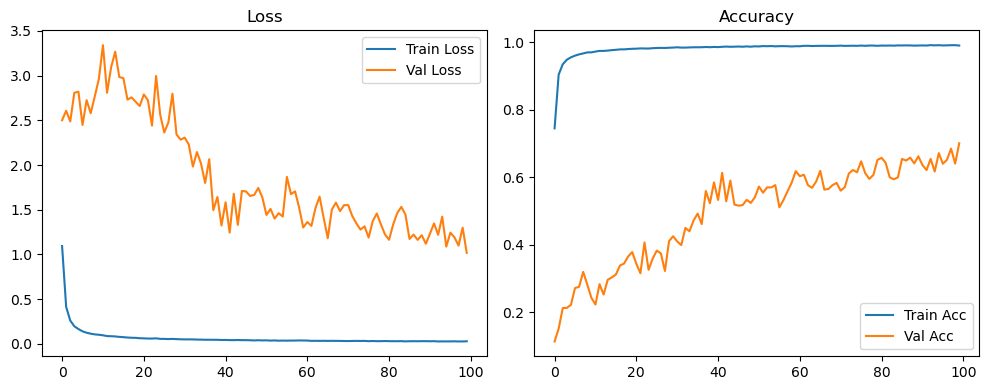

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.9551, Acc: 0.9423 | Val Loss: 0.5583, Acc: 0.9484


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.2618, Acc: 0.9830 | Val Loss: 0.2517, Acc: 0.9748


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1232, Acc: 0.9888 | Val Loss: 0.1561, Acc: 0.9779


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0761, Acc: 0.9922 | Val Loss: 0.2191, Acc: 0.9564


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0533, Acc: 0.9940 | Val Loss: 0.1478, Acc: 0.9669


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0391, Acc: 0.9957 | Val Loss: 0.3023, Acc: 0.9177


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0307, Acc: 0.9968 | Val Loss: 0.1235, Acc: 0.9659


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0227, Acc: 0.9981 | Val Loss: 0.2866, Acc: 0.9077


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0174, Acc: 0.9988 | Val Loss: 0.3581, Acc: 0.8882


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0143, Acc: 0.9991 | Val Loss: 0.1958, Acc: 0.9433


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9994 | Val Loss: 0.1333, Acc: 0.9646


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9997 | Val Loss: 0.0829, Acc: 0.9781


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 1.0000 | Val Loss: 0.0679, Acc: 0.9798


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9999 | Val Loss: 0.0436, Acc: 0.9877


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 1.0000 | Val Loss: 0.0345, Acc: 0.9892


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 1.0000 | Val Loss: 0.0429, Acc: 0.9887


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 1.0000 | Val Loss: 0.0400, Acc: 0.9886


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 1.0000 | Val Loss: 0.0357, Acc: 0.9901


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 1.0000 | Val Loss: 0.0612, Acc: 0.9831


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 1.0000 | Val Loss: 0.0391, Acc: 0.9890


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 1.0000 | Val Loss: 0.0333, Acc: 0.9899


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 1.0000 | Val Loss: 0.0330, Acc: 0.9902


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 1.0000 | Val Loss: 0.0332, Acc: 0.9898


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 1.0000 | Val Loss: 0.0340, Acc: 0.9897


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 1.0000 | Val Loss: 0.0333, Acc: 0.9908


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 1.0000 | Val Loss: 0.0490, Acc: 0.9863


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0351, Acc: 0.9890 | Val Loss: 0.2698, Acc: 0.9213


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0127, Acc: 0.9972 | Val Loss: 0.0621, Acc: 0.9805


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9996 | Val Loss: 0.0384, Acc: 0.9876


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 1.0000 | Val Loss: 0.0686, Acc: 0.9795


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 1.0000 | Val Loss: 0.0299, Acc: 0.9909


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 1.0000 | Val Loss: 0.0293, Acc: 0.9910


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 1.0000 | Val Loss: 0.0299, Acc: 0.9908


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 1.0000 | Val Loss: 0.0296, Acc: 0.9912


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0301, Acc: 0.9911


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0300, Acc: 0.9910


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0297, Acc: 0.9910


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0295, Acc: 0.9912


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0310, Acc: 0.9909


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0305, Acc: 0.9909


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0304, Acc: 0.9914


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0306, Acc: 0.9910


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0305, Acc: 0.9912


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0308, Acc: 0.9912


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0305, Acc: 0.9909


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0309, Acc: 0.9912


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0306, Acc: 0.9912


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0318, Acc: 0.9910


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0325, Acc: 0.9908


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0320, Acc: 0.9911


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0331, Acc: 0.9911


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0318, Acc: 0.9912


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0333, Acc: 0.9908


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0319, Acc: 0.9913


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0353, Acc: 0.9906


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0335, Acc: 0.9912


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0327, Acc: 0.9912


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0340, Acc: 0.9909


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0341, Acc: 0.9912


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0339, Acc: 0.9912


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0357, Acc: 0.9908


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0338, Acc: 0.9915


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0352, Acc: 0.9910


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0351, Acc: 0.9912


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0376, Acc: 0.9908


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0353, Acc: 0.9913


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0371, Acc: 0.9910


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0351, Acc: 0.9908


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0356, Acc: 0.9911


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0364, Acc: 0.9912


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0374, Acc: 0.9908


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 2.6738, Acc: 0.5815


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0337, Acc: 0.9898 | Val Loss: 0.7145, Acc: 0.7945


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9977 | Val Loss: 0.0970, Acc: 0.9713


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9996 | Val Loss: 0.0413, Acc: 0.9880


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 1.0000 | Val Loss: 0.0323, Acc: 0.9918


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0308, Acc: 0.9918


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0313, Acc: 0.9919


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0311, Acc: 0.9919


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0314, Acc: 0.9914


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0312, Acc: 0.9917


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0313, Acc: 0.9919


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0317, Acc: 0.9918


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0315, Acc: 0.9922


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0316, Acc: 0.9919


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0320, Acc: 0.9917


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0316, Acc: 0.9924


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0322, Acc: 0.9921


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0324, Acc: 0.9922


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0328, Acc: 0.9917


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0324, Acc: 0.9918


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0331, Acc: 0.9920


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0327, Acc: 0.9921


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0330, Acc: 0.9920


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0331, Acc: 0.9919


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0331, Acc: 0.9924


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0339, Acc: 0.9919


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0334, Acc: 0.9922


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0342, Acc: 0.9923


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0338, Acc: 0.9922


Final Test Loss: 0.0339 Accuracy: 0.9908


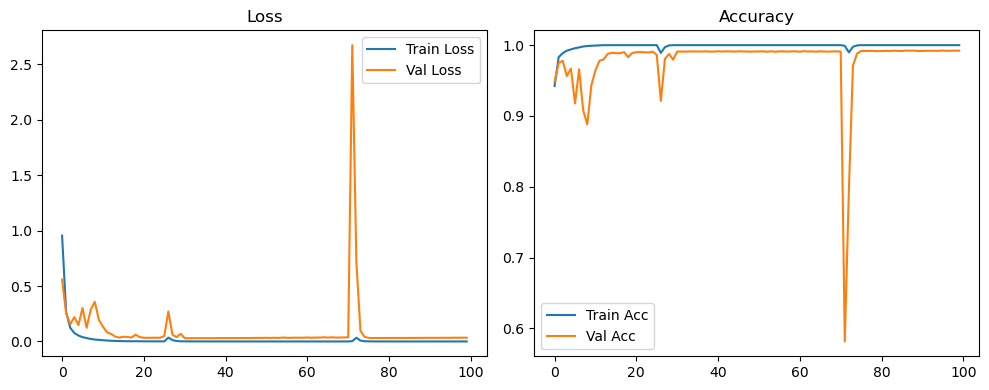

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 1.0577, Acc: 0.8978 | Val Loss: 1.1662, Acc: 0.6011


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.3574, Acc: 0.9670 | Val Loss: 1.3725, Acc: 0.4600


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1882, Acc: 0.9760 | Val Loss: 1.2681, Acc: 0.4542


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.1273, Acc: 0.9799 | Val Loss: 1.5439, Acc: 0.4294


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0977, Acc: 0.9824 | Val Loss: 1.5921, Acc: 0.4023


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0789, Acc: 0.9844 | Val Loss: 1.4705, Acc: 0.4649


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0680, Acc: 0.9863 | Val Loss: 1.3385, Acc: 0.4662


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0580, Acc: 0.9875 | Val Loss: 1.3098, Acc: 0.5327


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0524, Acc: 0.9879 | Val Loss: 1.3265, Acc: 0.5497


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0471, Acc: 0.9892 | Val Loss: 1.2187, Acc: 0.5436


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0437, Acc: 0.9891 | Val Loss: 1.3130, Acc: 0.5597


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0398, Acc: 0.9899 | Val Loss: 1.5089, Acc: 0.5102


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0349, Acc: 0.9915 | Val Loss: 1.5213, Acc: 0.5403


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0334, Acc: 0.9919 | Val Loss: 1.9127, Acc: 0.4059


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0318, Acc: 0.9921 | Val Loss: 1.5506, Acc: 0.5276


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0294, Acc: 0.9921 | Val Loss: 1.0983, Acc: 0.6498


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0273, Acc: 0.9929 | Val Loss: 1.3453, Acc: 0.5768


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0256, Acc: 0.9931 | Val Loss: 1.5286, Acc: 0.5232


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0232, Acc: 0.9937 | Val Loss: 1.5489, Acc: 0.5542


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0227, Acc: 0.9938 | Val Loss: 1.3669, Acc: 0.6215


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0220, Acc: 0.9937 | Val Loss: 1.0092, Acc: 0.6618


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0206, Acc: 0.9941 | Val Loss: 1.3201, Acc: 0.5965


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0179, Acc: 0.9952 | Val Loss: 0.7218, Acc: 0.7569


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0185, Acc: 0.9950 | Val Loss: 1.5070, Acc: 0.5878


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0167, Acc: 0.9955 | Val Loss: 0.9859, Acc: 0.7124


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0163, Acc: 0.9954 | Val Loss: 1.4768, Acc: 0.6013


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0160, Acc: 0.9954 | Val Loss: 1.0223, Acc: 0.6770


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0151, Acc: 0.9958 | Val Loss: 1.0768, Acc: 0.7103


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0148, Acc: 0.9954 | Val Loss: 1.1554, Acc: 0.6634


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0135, Acc: 0.9959 | Val Loss: 1.5990, Acc: 0.6326


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0125, Acc: 0.9962 | Val Loss: 1.9784, Acc: 0.5299


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0131, Acc: 0.9960 | Val Loss: 1.4826, Acc: 0.5946


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0135, Acc: 0.9957 | Val Loss: 1.0832, Acc: 0.6669


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9969 | Val Loss: 0.8970, Acc: 0.7093


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9968 | Val Loss: 1.0104, Acc: 0.7058


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 1.2616, Acc: 0.6577


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9967 | Val Loss: 0.7499, Acc: 0.7725


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9971 | Val Loss: 1.1851, Acc: 0.6818


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9972 | Val Loss: 0.7928, Acc: 0.7252


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 1.1947, Acc: 0.6558


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9970 | Val Loss: 1.3090, Acc: 0.6633


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9972 | Val Loss: 1.1225, Acc: 0.6817


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 1.1428, Acc: 0.7167


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.9409, Acc: 0.7407


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9978 | Val Loss: 0.9876, Acc: 0.7186


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 1.0503, Acc: 0.6894


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.6750, Acc: 0.7993


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.8548, Acc: 0.7572


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 1.3993, Acc: 0.6518


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 1.0909, Acc: 0.6836


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.8528, Acc: 0.7732


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.4914, Acc: 0.8543


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.9087, Acc: 0.7632


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.4892, Acc: 0.8487


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.4057, Acc: 0.8805


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 1.0878, Acc: 0.7032


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9983 | Val Loss: 0.6540, Acc: 0.8025


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.7225, Acc: 0.7836


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 1.1841, Acc: 0.6917


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 1.1416, Acc: 0.7018


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.7741, Acc: 0.7881


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.8290, Acc: 0.7774


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.4252, Acc: 0.8697


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.5414, Acc: 0.8387


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.5964, Acc: 0.8421


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.7123, Acc: 0.7969


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.6179, Acc: 0.8228


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.9264, Acc: 0.7529


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.6158, Acc: 0.8273


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.6292, Acc: 0.8333


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.6314, Acc: 0.8326


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.5944, Acc: 0.8294


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.5027, Acc: 0.8618


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.4857, Acc: 0.8661


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.5102, Acc: 0.8505


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.2768, Acc: 0.9221


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.4699, Acc: 0.8667


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.5906, Acc: 0.8400


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.4922, Acc: 0.8632


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.5405, Acc: 0.8510


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.6906, Acc: 0.8273


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9990 | Val Loss: 0.7826, Acc: 0.7965


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.9844, Acc: 0.7726


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.8214, Acc: 0.7887


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.8647, Acc: 0.7708


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.6355, Acc: 0.8263


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.9348, Acc: 0.7675


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.6014, Acc: 0.8374


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.6899, Acc: 0.8111


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.5926, Acc: 0.8357


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.7016, Acc: 0.8157


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.7110, Acc: 0.8279


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.9691, Acc: 0.7808


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.5336, Acc: 0.8620


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.6453, Acc: 0.8273


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.8177, Acc: 0.7902


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.5714, Acc: 0.8542


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.6127, Acc: 0.8327


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.7644, Acc: 0.8040


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.9185, Acc: 0.7779


Final Test Loss: 0.9243 Accuracy: 0.7781


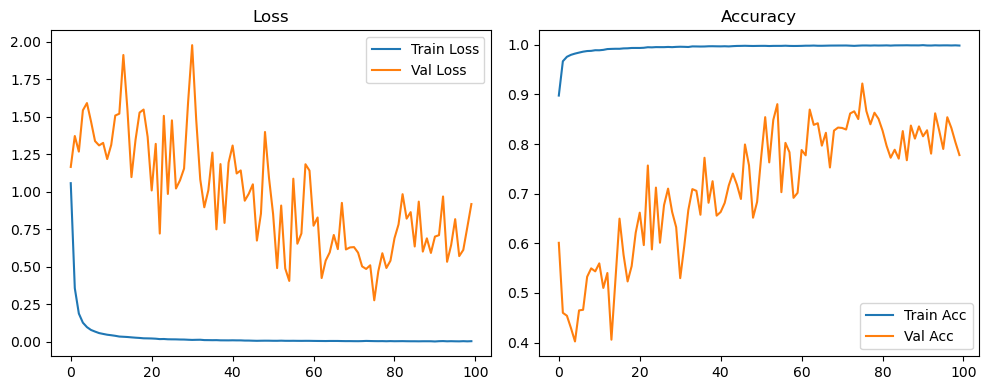

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 1.3728, Acc: 0.6873 | Val Loss: 2.4193, Acc: 0.1133


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.6986, Acc: 0.8594 | Val Loss: 2.7962, Acc: 0.1133


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.4421, Acc: 0.9048 | Val Loss: 2.5153, Acc: 0.2084


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.3207, Acc: 0.9255 | Val Loss: 2.7930, Acc: 0.2081


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.2603, Acc: 0.9357 | Val Loss: 2.6787, Acc: 0.2139


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.2144, Acc: 0.9454 | Val Loss: 2.5436, Acc: 0.2292


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.1854, Acc: 0.9518 | Val Loss: 2.8574, Acc: 0.2178


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.1654, Acc: 0.9557 | Val Loss: 2.7193, Acc: 0.2482


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.1502, Acc: 0.9603 | Val Loss: 2.7820, Acc: 0.2527


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.1421, Acc: 0.9603 | Val Loss: 2.8726, Acc: 0.2365


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.1299, Acc: 0.9641 | Val Loss: 3.0706, Acc: 0.2252


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.1183, Acc: 0.9670 | Val Loss: 2.8250, Acc: 0.2612


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.1140, Acc: 0.9679 | Val Loss: 2.9984, Acc: 0.2492


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.1092, Acc: 0.9694 | Val Loss: 3.0267, Acc: 0.2846


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.1013, Acc: 0.9720 | Val Loss: 2.9409, Acc: 0.2638


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0971, Acc: 0.9726 | Val Loss: 3.0421, Acc: 0.2641


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0922, Acc: 0.9737 | Val Loss: 2.8673, Acc: 0.2973


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0878, Acc: 0.9749 | Val Loss: 2.9268, Acc: 0.2698


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0852, Acc: 0.9750 | Val Loss: 3.0580, Acc: 0.2945


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0802, Acc: 0.9765 | Val Loss: 2.9262, Acc: 0.2801


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0786, Acc: 0.9772 | Val Loss: 2.9676, Acc: 0.2948


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0755, Acc: 0.9774 | Val Loss: 3.0143, Acc: 0.2448


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0741, Acc: 0.9778 | Val Loss: 2.8723, Acc: 0.2961


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0745, Acc: 0.9784 | Val Loss: 3.1581, Acc: 0.2400


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0695, Acc: 0.9783 | Val Loss: 3.2020, Acc: 0.2466


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0713, Acc: 0.9791 | Val Loss: 2.8807, Acc: 0.2764


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0662, Acc: 0.9800 | Val Loss: 2.9940, Acc: 0.2838


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0662, Acc: 0.9805 | Val Loss: 3.1526, Acc: 0.2682


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0653, Acc: 0.9806 | Val Loss: 3.0165, Acc: 0.3202


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0616, Acc: 0.9817 | Val Loss: 2.9879, Acc: 0.3183


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0614, Acc: 0.9824 | Val Loss: 2.8131, Acc: 0.3013


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0599, Acc: 0.9817 | Val Loss: 2.7566, Acc: 0.3184


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0589, Acc: 0.9816 | Val Loss: 2.7208, Acc: 0.3364


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0565, Acc: 0.9827 | Val Loss: 2.6746, Acc: 0.3513


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0567, Acc: 0.9822 | Val Loss: 2.5331, Acc: 0.3745


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0552, Acc: 0.9831 | Val Loss: 2.6886, Acc: 0.3247


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0546, Acc: 0.9833 | Val Loss: 2.4444, Acc: 0.3904


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0534, Acc: 0.9836 | Val Loss: 2.1493, Acc: 0.4412


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0520, Acc: 0.9838 | Val Loss: 2.4555, Acc: 0.3888


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0516, Acc: 0.9842 | Val Loss: 2.1494, Acc: 0.4452


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0525, Acc: 0.9835 | Val Loss: 2.3212, Acc: 0.4201


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0505, Acc: 0.9845 | Val Loss: 2.1351, Acc: 0.4407


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0497, Acc: 0.9844 | Val Loss: 2.5363, Acc: 0.3943


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0484, Acc: 0.9852 | Val Loss: 2.1848, Acc: 0.4269


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0485, Acc: 0.9854 | Val Loss: 2.5590, Acc: 0.3736


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0482, Acc: 0.9851 | Val Loss: 2.5425, Acc: 0.4068


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0478, Acc: 0.9845 | Val Loss: 2.3615, Acc: 0.4238


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0443, Acc: 0.9866 | Val Loss: 2.4945, Acc: 0.3952


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0467, Acc: 0.9855 | Val Loss: 2.4951, Acc: 0.3766


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0441, Acc: 0.9863 | Val Loss: 2.2846, Acc: 0.4304


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0458, Acc: 0.9862 | Val Loss: 2.4727, Acc: 0.4140


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0430, Acc: 0.9868 | Val Loss: 2.4163, Acc: 0.4368


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0439, Acc: 0.9872 | Val Loss: 2.4247, Acc: 0.4328


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0423, Acc: 0.9867 | Val Loss: 2.1763, Acc: 0.4689


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0430, Acc: 0.9864 | Val Loss: 2.2008, Acc: 0.4572


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0409, Acc: 0.9874 | Val Loss: 2.4758, Acc: 0.4237


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0408, Acc: 0.9873 | Val Loss: 2.5042, Acc: 0.4017


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0412, Acc: 0.9876 | Val Loss: 2.3177, Acc: 0.4706


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0423, Acc: 0.9874 | Val Loss: 2.2059, Acc: 0.4688


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0424, Acc: 0.9866 | Val Loss: 2.0251, Acc: 0.4810


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0421, Acc: 0.9867 | Val Loss: 1.9012, Acc: 0.4958


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0384, Acc: 0.9883 | Val Loss: 2.1141, Acc: 0.4596


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0389, Acc: 0.9875 | Val Loss: 2.4770, Acc: 0.4037


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0388, Acc: 0.9871 | Val Loss: 2.2933, Acc: 0.4502


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0379, Acc: 0.9884 | Val Loss: 2.1093, Acc: 0.4486


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0372, Acc: 0.9884 | Val Loss: 2.1767, Acc: 0.4348


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0393, Acc: 0.9881 | Val Loss: 2.0957, Acc: 0.4438


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0382, Acc: 0.9880 | Val Loss: 2.2976, Acc: 0.4264


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0373, Acc: 0.9880 | Val Loss: 2.1486, Acc: 0.4613


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0352, Acc: 0.9889 | Val Loss: 2.0997, Acc: 0.4843


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0357, Acc: 0.9890 | Val Loss: 2.1247, Acc: 0.4560


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0381, Acc: 0.9878 | Val Loss: 1.9978, Acc: 0.4808


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0353, Acc: 0.9888 | Val Loss: 1.7443, Acc: 0.5391


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0351, Acc: 0.9889 | Val Loss: 1.7177, Acc: 0.5375


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0366, Acc: 0.9884 | Val Loss: 1.9150, Acc: 0.5102


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0336, Acc: 0.9889 | Val Loss: 1.8044, Acc: 0.5385


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0349, Acc: 0.9888 | Val Loss: 2.0541, Acc: 0.5172


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0339, Acc: 0.9896 | Val Loss: 2.0843, Acc: 0.5046


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0329, Acc: 0.9894 | Val Loss: 1.9041, Acc: 0.5110


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0331, Acc: 0.9895 | Val Loss: 1.8665, Acc: 0.5407


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0333, Acc: 0.9888 | Val Loss: 1.7965, Acc: 0.5396


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0335, Acc: 0.9890 | Val Loss: 1.9076, Acc: 0.5110


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0322, Acc: 0.9900 | Val Loss: 1.9603, Acc: 0.5205


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0343, Acc: 0.9889 | Val Loss: 2.0319, Acc: 0.5136


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0323, Acc: 0.9897 | Val Loss: 2.0034, Acc: 0.5013


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0325, Acc: 0.9905 | Val Loss: 1.8993, Acc: 0.5023


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0322, Acc: 0.9892 | Val Loss: 1.7635, Acc: 0.5460


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0301, Acc: 0.9902 | Val Loss: 1.9645, Acc: 0.5207


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0339, Acc: 0.9890 | Val Loss: 1.9329, Acc: 0.4963


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0327, Acc: 0.9896 | Val Loss: 1.7326, Acc: 0.5309


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0318, Acc: 0.9896 | Val Loss: 1.7489, Acc: 0.5455


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0323, Acc: 0.9898 | Val Loss: 1.9073, Acc: 0.5344


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0305, Acc: 0.9902 | Val Loss: 1.7656, Acc: 0.5508


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0316, Acc: 0.9902 | Val Loss: 2.1555, Acc: 0.4875


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0299, Acc: 0.9903 | Val Loss: 1.8516, Acc: 0.5314


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0288, Acc: 0.9903 | Val Loss: 1.8633, Acc: 0.5373


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0303, Acc: 0.9903 | Val Loss: 1.7477, Acc: 0.5482


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0313, Acc: 0.9902 | Val Loss: 1.6263, Acc: 0.5748


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0286, Acc: 0.9908 | Val Loss: 2.0258, Acc: 0.5249


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0317, Acc: 0.9901 | Val Loss: 1.6531, Acc: 0.5493


Final Test Loss: 1.6210 Accuracy: 0.5555


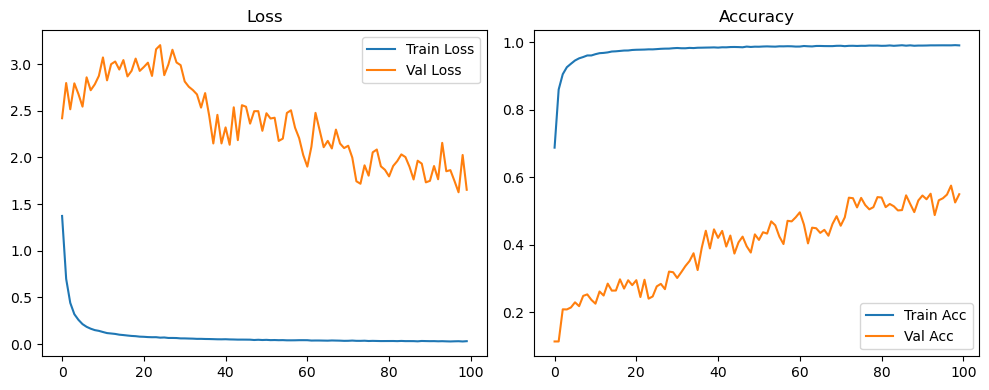

🏆 Best Config: batch64_lr0.01_0.002_0.001_dp0.0 Accuracy: 0.9934


In [8]:
root_path = "TCV_float_regular_Sigmoid"

epochs = 100
batch_sizes = [64, 128, 256]
dropout_rates = [0.0, 0.2, 0.5]
lr_pool = [0.01, 0.005, 0.002, 0.001]

Hyperparameter_searching(root_path, epochs, batch_sizes, lr_pool, dropout_rates)